In [1]:
import pandas
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import pickle
import zfit
import mplhep
from numpy import random 

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})

/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/util/execution.py:73: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
#Dowloading the data
bc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root')['events']
bu_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bu2TauNuTAUHADNU.root')['events']
bb_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen.root')['events']
cc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zcc_ecm91.root')['events']

tree_gen = uproot.open("root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root")["metadata"]

In [3]:
#Transforming the data into a dataframe
bc_df = bc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bu_df = bu_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bb_df = bb_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
cc_df = cc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])

#Getting general information on the data
df_gen = tree_gen.arrays(library="pd", how="zip")

### Initialization of the data parameters

In [4]:
#We consider as initial data the data whose MVAs are between 0.95 and 1
bc_sig = bc_df[bc_df['EVT_MVA2']> 0.95]
bc_sig = bc_sig[bc_sig['EVT_MVA1']> 0.95]

bu_bkg = bu_df[bu_df['EVT_MVA2']> 0.95]
bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']> 0.95] 

bb_bkg = bb_df[bb_df['EVT_MVA2']> 0.95]
bb_bkg = bb_bkg[bb_bkg['EVT_MVA1']> 0.95] 

cc_bkg = cc_df[cc_df['EVT_MVA2']> 0.95]
cc_bkg = cc_bkg[cc_bkg['EVT_MVA1']> 0.95] 


In [5]:
#Number of Z0 produced
N_Z0_init = 5*10**(12)
N_Z0 = 3*10**(12)

#Branching fraction Z->quark-pair
BF_Zbb = 0.1512
BF_Zcc = 0.1203
BF_Zqq = 0.4276

#Production ratio of Bc+ and B+
f_Bc = 0.0004
f_Bu = 0.43

#Branching fraction Bc+->tau nu B+->tau nu and tau->3pions
BF_Bctaunu = 0.0194
BF_Butaunu = 1.09*10**(-4)
BF_tau3pion = 0.0931

#Definition of the functions computing the different yields
def S_bc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bc*BF_Bctaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bu_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bu*BF_Butaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bb_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2)*initial_eff*cut_eff

def B_cc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zcc*2)*initial_eff*cut_eff

def B_qq_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zqq*2)*initial_eff*cut_eff

#Dowloading the splines to compute the number of inclusive background events
bb_spline_MVA1_log = pickle.load(open(r'../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA1_spline_log.pkl','rb'))
bb_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA2_spline_log.pkl','rb'))

cc_spline_MVA1_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA1_spline_log.pkl','rb'))
cc_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA2_spline_log.pkl','rb'))

#Initialization of the number of events in the MVAs for all contributions
nb_total_events = df_gen.iloc[0]["eventsProcessed"]
nb_bc_events = len(bc_sig)
nb_bu_events = len(bu_bkg)
nb_bb_events = len(bb_bkg)
nb_cc_events = len(cc_bkg)

#Initialization of the number of events for both MVAs for inclusive backgrounds
nb_bb_events_1 = interpolate.splint(-np.log(1-0.95), 9, bb_spline_MVA1_log)
nb_cc_events_1 = interpolate.splint(-np.log(1-0.95), 9, cc_spline_MVA1_log)

nb_bb_events_2 = interpolate.splint(-np.log(1-0.95), 8, bb_spline_MVA2_log)
nb_cc_events_2 = interpolate.splint(-np.log(1-0.95), 7, cc_spline_MVA2_log)

#Computing of the initial efficiencies for all backgrounds
initial_eff_bc_sig = nb_bc_events / nb_total_events
initial_eff_bu_bkg = nb_bu_events / nb_total_events
initial_eff_bb_bkg = nb_bb_events / nb_total_events
initial_eff_cc_bkg = nb_cc_events / nb_total_events

print('eff sig {}'.format(initial_eff_bc_sig))

eff sig 0.2320645


In [6]:
#Optimized MVAs
Optimized_MVA1 = 0.9998599999999961  #+-0.00001
Optimized_MVA2 = 0.9963399999999984 #+-0.00001

Optimized_MVA1_log = -np.log(1-Optimized_MVA1)
Optimized_MVA2_log = -np.log(1-Optimized_MVA2)


#Applying the MVA2 cut on the dataframe
df_bc_sig = bc_sig[bc_sig['EVT_MVA1']>Optimized_MVA1]
df_bc_sig = df_bc_sig[df_bc_sig['EVT_MVA2']>Optimized_MVA2]

df_bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']>Optimized_MVA1]
df_bu_bkg = df_bu_bkg[df_bu_bkg['EVT_MVA2']>Optimized_MVA2]
          
    
#Counting the number of events in the Bc+ and B+ dataframes after the cut
nb_bc_after_cut = len(df_bc_sig)
nb_bu_after_cut = len(df_bu_bkg)
        
    
#Counting the number of events left for each MVAs for inclusive backgrounds
nb_bb_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, bb_spline_MVA1_log)
nb_bb_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 8, bb_spline_MVA2_log)
        
nb_cc_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, cc_spline_MVA1_log)
nb_cc_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 7, cc_spline_MVA2_log)


#Computing the efficiencies
cut_eff_bc_sig = nb_bc_after_cut / nb_bc_events
        
cut_eff_bu_bkg = nb_bu_after_cut / nb_bu_events
cut_eff_bb_bkg = (nb_bb_after_cut_1 / nb_bb_events_1) * (nb_bb_after_cut_2 / nb_bb_events_2)
cut_eff_cc_bkg = (nb_cc_after_cut_1 / nb_cc_events_1) * (nb_cc_after_cut_2 / nb_cc_events_2)
print(cut_eff_bu_bkg)
print(cut_eff_bb_bkg)
print(cut_eff_cc_bkg)
        
    
#Signal, Background and Purity
S = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)
B = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg) + B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg) + B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg) #+ B_qq_cut(initial_eff_qq_bkg, cut_eff_qq_bkg)
P = S/(S+B)

print('Number of signal events = {}'.format(S))
print('Number of bkg events = {}'.format(B))
print('Purity = {}'.format(P))

N_BC = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)

N_BU = B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg)
N_BB = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg)
N_CC = B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg)

N_BB_CC = N_BB + N_CC

print('N_BC = {}'.format(N_BC))
print('N_BU = {}'.format(N_BU))
print('N_BB = {}'.format(N_BB))
print('N_CC = {}'.format(N_CC))

0.0007226931575174898
3.137790945458242e-06
1.797967906975173e-06
Number of signal events = 2405.55896896896
Number of bkg events = 2683.7345816239226
Purity = 0.4726705082061383
N_BC = 2405.55896896896
N_BU = 144.88678026144
N_BB = 2169.1122066384246
N_CC = 369.7355947240583


### Creating the templates

[]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Roman


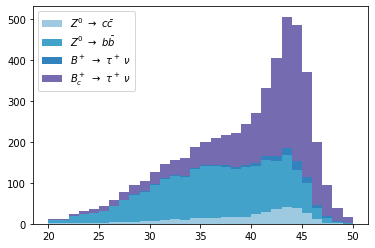

In [7]:
#Paramètres pour les histogrammes
variable = 'EVT_ThrustEmax_E'
nb_bins = int(40/np.sqrt(N_Z0_init/N_Z0))
min_bin = 20
max_bin = 50

name_bc = r"$B_c^+$ $\rightarrow$ $\tau^+$ $\nu$ "
name_bu = r"$B^+$ $\rightarrow$ $\tau^+$ $\nu$ "
name_bb = r"$Z^0$ $\rightarrow$ $b\bar{b}$ "
name_cc = r"$Z^0$ $\rightarrow$ $c\bar{c}$ "

colour_bc = "#756bb1"
colour_bu = "#3182bd"
colour_bb = "#43a2ca" 
colour_cc = "#9ecae1" 

#Stocker la forme théorique (ie simulée) des différentes contributions
counts_bc, bins_bc = np.histogram(bc_sig[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bu, bins_bu = np.histogram(bu_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bb, bins_bb = np.histogram(bb_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_cc, bins_cc = np.histogram(cc_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))

counts_bc = (counts_bc/np.sum(counts_bc)) * N_BC
counts_bu = (counts_bu/np.sum(counts_bu)) * N_BU
counts_bb = (counts_bb/np.sum(counts_bb)) * N_BB
counts_cc = (counts_cc/np.sum(counts_cc)) * N_CC

#Uniformiser les bin_edges
x = [bins_cc[:-1], bins_bb[:-1], bins_bu[:-1], bins_bc[:-1]]
bins = bins_bc
weights = [counts_cc, counts_bb, counts_bu, counts_bc ]
colour = [colour_cc, colour_bb, colour_bu, colour_bc]
name = [name_cc, name_bb, name_bu, name_bc]

plt.figure()
counts, bin_edges, _ = plt.hist(x, bins, weights=weights, color=colour, label=name, stacked=True)
plt.legend()
plt.plot()

In [8]:
#Getting the right bins_edges size
_ , bins_edges = np.histogram(a=bin_edges[:-1], bins=bin_edges, weights=counts[3])

#Templates and templates normalisation from the predicted simulated data.
template_yield_bc, _ = np.histogram(a=bins_bc[:-1], bins=bins_edges, weights=counts_bc)
template_yield_bu, _ = np.histogram(a=bins_bu[:-1], bins=bins_edges, weights=counts_bu)
template_yield_bb, _ = np.histogram(a=bins_bb[:-1], bins=bins_edges, weights=counts_bb)
template_yield_cc, _ = np.histogram(a=bins_cc[:-1], bins=bins_edges, weights=counts_cc)
    
template_yield_bc = template_yield_bc/np.sum(template_yield_bc)
template_yield_bu = template_yield_bu/np.sum(template_yield_bu)
template_yield_bb = template_yield_bb/np.sum(template_yield_bb)
template_yield_cc = template_yield_cc/np.sum(template_yield_cc)
 
#Checking if there are zero bins    
print(template_yield_bc)
print(template_yield_bu)
print(template_yield_bb)
print(template_yield_cc)

[0.00128622 0.00170903 0.00238553 0.00311234 0.0039198  0.00503473
 0.00616093 0.00744021 0.00907899 0.01043459 0.01220043 0.01384572
 0.01583185 0.01808339 0.02061419 0.02345333 0.02665326 0.03034019
 0.03507353 0.04120844 0.05139671 0.06878842 0.09877302 0.13308115
 0.13889125 0.10618938 0.06348526 0.03171835 0.01405474 0.00575503]
[0.00182489 0.00257865 0.00336216 0.00475662 0.00583171 0.00714881
 0.00847979 0.00950331 0.0116793  0.01325227 0.01488079 0.01599754
 0.01788789 0.01992899 0.0219205  0.02515174 0.02839687 0.03277264
 0.0362558  0.0420776  0.05152339 0.06572976 0.09395009 0.13005911
 0.14146467 0.10535169 0.05535169 0.02280121 0.00766454 0.002416  ]
[0.00369881 0.00317041 0.00726552 0.01017173 0.01070013 0.01321004
 0.01796565 0.02430647 0.03025099 0.032893   0.04002642 0.04676354
 0.04848085 0.04874505 0.05508587 0.05852048 0.05878468 0.05693527
 0.05389696 0.05548217 0.05429326 0.05891678 0.05442536 0.05891678
 0.04359313 0.0336856  0.01215324 0.00554822 0.0015852  0.00

##### Creating the function that we will use for the fit

In [9]:
#When considering Z->bb, Z->cc and Bu for background
def get_template(yield_bc, yield_bu, yield_bb_cc): 
    return yield_bc*template_yield_bc + yield_bu*template_yield_bu + yield_bb_cc*((N_BB/N_BB_CC)*template_yield_bb + (N_CC/N_BB_CC)*template_yield_cc)
    
def binned_nll(template, sample_hist):
    return np.sum(template - sample_hist + sample_hist * np.log((sample_hist + 1*10**(-14)) / (template + 1*10**(-14))))
  # 1e-14 added in case there are empty bins

def loss(x):
    # by default, `x` is an `OrderedSet` of zfit parameters.
    x = np.array(x)

    print("Value of the parameters", x)
  
    # The first parameter is the Bc yield 
    yield_bc = x[0]
    # The second parameter is the Bu yield 
    yield_bu = x[1]
    # The second parameter is the Z->bb and Z->cc combined yield 
    yield_bb_cc = x[2]

    template = get_template(yield_bc, yield_bu, yield_bb_cc)

    nll = binned_nll(template, sample_hist)
    
    #Gaussian constraint on B+ -> tau nu yield
    nll += (yield_bu - N_BU)**2/2./N_BU*0.05

    return nll

loss.errordef = 0.5 # 0.5 for a log-likelihood
# We would set this parameter at 1 for a chi2 loss function.

##### Toy samples

Playing on the value of the background yield

In [10]:
#Theoretical value of the yields parameters to give initial value to the fit parameters
print('N_Z0 = {:.0e}'.format(N_Z0))
print('N_BC = {}'.format(N_BC))
print('N_BU = {}'.format(N_BU))
print('N_BB_CC = {}'.format(N_BB_CC))
print('N_BB_CC = {}'.format(N_BB_CC*10))

N_Z0 = 3e+12
N_BC = 2405.55896896896
N_BU = 144.88678026144
N_BB_CC = 2538.8478013624826
N_BB_CC = 25388.478013624826


In [ ]:
#Faire ça pour 10, 5, 1/5 et 1/10
bkg_var = 10

#Initialisation des paramètres de la boucle
n_loop = 2000
new_bc_yield = np.zeros(n_loop)
new_bu_yield = np.zeros(n_loop)
new_bb_cc_yield = np.zeros(n_loop)


#Initialisation des "données experimentales" pour un level de bkg différent de ce qu'on a avec la simulation
new_bc_yield_error = np.zeros(n_loop)
new_bu_yield_error = np.zeros(n_loop)
new_bb_cc_yield_error = np.zeros(n_loop)

new_counts_bc = (counts_bc/np.sum(counts_bc)) * N_BC
new_counts_bu = (counts_bu/np.sum(counts_bu)) * N_BU
new_counts_bb = (counts_bb/np.sum(counts_bb)) * N_BB * bkg_var
new_counts_cc = (counts_cc/np.sum(counts_cc)) * N_CC * bkg_var

x = [bins_cc[:-1], bins_bb[:-1], bins_bu[:-1], bins_bc[:-1]]
bins = bins_edges
weights = [new_counts_cc, new_counts_bb, new_counts_bu, new_counts_bc]
colour = [colour_cc, colour_bb, colour_bu, colour_bc]
name = [name_cc, name_bb, name_bu, name_bc]

plt.figure()
new_counts, new_bin_edges, _ = plt.hist(x, bins, weights=weights, color=colour, label=name, stacked=True)
plt.plot()


#Boucle sur les toy samples
for i in range (n_loop) :
    
    #Toy sample
    data = np.random.poisson(new_counts[3])
    sample_hist, bins_edges = np.histogram(a=new_bin_edges[:-1], bins=new_bin_edges, weights=data)

    #Initialisation of the parameters
    i_rand = random.randint(0,1000000000000,size=1)
    
    initial_params = {
            'value': [2500, 150, 25500], #j'ai écrit 4000 alors que les valeurs exp sont 4000*bkg_var
            'lower' : [-1000., -1000., -1000.], # optional
            'upper': [10000., 10000., 100000.], # optional
            'name': [f"bc_yield_{i_rand}", f"bu_yield_{i_rand}", f"bb_cc_yield_{i_rand}"] # optional
        }

    #Fit
    minimiser = zfit.minimize.Minuit(verbosity=5)
    zfit.run.set_autograd_mode(False)
    zfit.run.set_graph_mode(False)
    
    #Extracting the informations
    result = minimiser.minimize(loss, initial_params)
    params = result.params
    params_hesse = result.hesse() #Computation of the errors
    corr = result.correlation(method="minuit_hesse")
    
    print(result.info['original'])
    print(params)
    print('correction {}'.format(corr))

    #Extracting the yield results
    new_bc_yield[i] = params[f"bc_yield_{i_rand}"]['value']
    new_bu_yield[i] = params[f"bu_yield_{i_rand}"]['value']
    new_bb_cc_yield[i] = params[f"bb_cc_yield_{i_rand}"]['value']
    
    new_bc_yield_error[i] = params[f"bc_yield_{i_rand}"]['minuit_hesse']['error']
    new_bu_yield_error[i] = params[f"bu_yield_{i_rand}"]['minuit_hesse']['error']
    new_bb_cc_yield_error[i] = params[f"bb_cc_yield_{i_rand}"]['minuit_hesse']['error']
    

Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13531195 25500.        ]
Value of the parameters [ 2500.           149.86469508 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.45707272]
Value of the parameters [ 2500.           150.         25499.54292982]
Value of the parameters [ 2240.67693982   103.80276915 25083.23312183]
Value of the parameters [ 2361.92429329   125.42173646 25278.94407437]
Value of the parameters [ 2362.23817058   125.42173646 25278.94407437]
Value of the parameters [ 2361

Value of the parameters [ 2453.55890562   145.64009574 25268.0955304 ]
Value of the parameters [ 2453.55890562   145.74753669 25268.45339851]
Value of the parameters [ 2453.55890562   145.74753669 25267.73766387]
Value of the parameters [ 2453.55890562   145.74753669 25268.0955304 ]
Value of the parameters [ 2453.83762767   145.74753669 25268.0955304 ]
Value of the parameters [ 2453.28018966   145.74753669 25268.0955304 ]
Value of the parameters [ 2453.55890562   145.85498209 25268.0955304 ]
Value of the parameters [ 2453.55890562   145.64009574 25268.0955304 ]
Value of the parameters [ 2453.55890562   145.74753669 25268.45339851]
Value of the parameters [ 2453.55890562   145.74753669 25267.73766387]
Value of the parameters [ 2453.61464954   145.74753669 25268.0955304 ]
Value of the parameters [ 2453.50316194   145.74753669 25268.0955304 ]
Value of the parameters [ 2453.55890562   145.76902541 25268.0955304 ]
Value of the parameters [ 2453.55890562   145.72604814 25268.0955304 ]
Value 

Value of the parameters [ 2381.00030205   143.96566806 25574.00121313]
Value of the parameters [ 2381.04356344   143.98241114 25574.01236242]
Value of the parameters [ 2381.04356344   143.96566806 25574.06810892]
Value of the parameters [ 2381.00030205   143.98241114 25574.06810892]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.335                      │              Nfcn = 51               │
│ EDM = 1.16e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2500.           150.         25500.49950789]
Value of the parameters [ 2500.           150.         25499.50049515]
Value of the parameters [ 2097.70857147    88.51338169 25039.65387188]
Value of the parameters [ 2286.21299392   117.4058212  25257.04144413]
Value of the parameters [ 2286.53686754   117.4058212  25257.04144413]
Value of the parameters [ 2285.88912947   117.4058212  25257.04144413]
Value of the parameters [ 2286.21299392   117.530096   25257.04144413]
Value of the parameters [ 2286.21299392   117.28155253 25257.04144413]
Value of the parameters [ 2286.21299392   117.4058212  25257.46648706]
Value of the parameters [ 2286.21299392   117.4058212  25256.61640343]
Value of the parameters [ 2253.31667926   134.94352487 25266.51318583]
Value of the parameters [ 2230.41816034   147.25308239 25273.12332904]
Value of the parameters [ 2230.73978574   147.25308239 25273.12332904]
Value of the parameters [ 2230.09654429   147.25308239 25273.12332904]
Value 

Value of the parameters [ 2347.70275493   141.89496407 25649.62043952]
Value of the parameters [ 2347.70275493   141.59611643 25649.62043952]
Value of the parameters [ 2347.70275493   141.74553593 25650.11687203]
Value of the parameters [ 2347.70275493   141.74553593 25649.12400998]
Value of the parameters [ 2347.7794818    141.74553593 25649.62043952]
Value of the parameters [ 2347.62602855   141.74553593 25649.62043952]
Value of the parameters [ 2347.70275493   141.77542086 25649.62043952]
Value of the parameters [ 2347.70275493   141.71565134 25649.62043952]
Value of the parameters [ 2347.70275493   141.74553593 25649.71972579]
Value of the parameters [ 2347.70275493   141.74553593 25649.52115337]
Value of the parameters [ 2348.08639424   141.89496407 25649.62043952]
Value of the parameters [ 2348.08639424   141.74553593 25650.11687203]
Value of the parameters [ 2347.70275493   141.89496407 25650.11687203]
Value of the parameters [ 2347.70275493   141.74553593 25649.62043952]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[982922088492]        2502     +/- 1.9e+02       False
bu_yield_[982922088492]       146.2     +/-      54       False
bb_cc_yield_[982922088492]    25370     +/- 2.4e+02       False
correction [[ 1.         -0.23809982 -0.69302028]
 [-0.23809982  1.         -0.03200867]
 [-0.69302028 -0.03200867  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38509965   150.         25500.        ]
Value of the parameters [ 2499.61491165   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2217.06192209   157.70498125 25482.36883829]
Value of the parameters [ 2217.32006054   157.80739806 25482.36883829]
Value of the parameters [ 2217.32006054   157.60256844 25482.36883829]
Value of the parameters [ 2217.32006054   157.70498125 25482.7044194 ]
Value of the parameters [ 2217.32006054   157.70498125 25482.03325854]
Value of the parameters [ 2202.87237356   150.6036029  25515.51713866]
Value of the parameters [ 2193.98487573   146.24010414 25535.93683585]
Value of the parameters [ 2194.24379255   146.24010414 25535.93683585]
Value of the parameters [ 2193.7259651    146.24010414 25535.93683585]
Value of the parameters [ 2193.98487573   146.34012488 25535.93683585]
Value of the parameters [ 2193.98487573   146.14008725 25535.93683585]
Value of the parameters [ 2193.98487573   146.24010414 25536.2715748 ]
Value of the parameters [ 2193.98487573   146.24010414 25535.60209827]
Value of the parameters [ 2193.98487573   146.24010414 25535.93683585]
Value 

Value of the parameters [ 2349.5627375    144.32344768 25557.58792002]
Value of the parameters [ 2349.58039402   144.33032427 25557.58792002]
Value of the parameters [ 2349.58039402   144.31657111 25557.58792002]
Value of the parameters [ 2349.58039402   144.32344768 25557.61075917]
Value of the parameters [ 2349.58039402   144.32344768 25557.56508088]
Value of the parameters [ 2349.66867701   144.35783083 25557.58792002]
Value of the parameters [ 2349.66867701   144.32344768 25557.70211582]
Value of the parameters [ 2349.58039402   144.35783083 25557.70211582]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 24.02                      │              Nfcn = 45               │
│ EDM = 0.000143 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13802844 25500.        ]
Value of the parameters [ 2500.           149.86197887 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46025831]
Value of the parameters [ 2500.           150.         25499.53974426]
Value of the parameters [ 2577.17692867   156.1692703  25485.74464387]
Value of the parameters [ 2582.86708574   156.62331245 25484.69691251]
Value of the parameters [ 2583.22508154   156.62331245 25484.69691251]
Value of the parameters [ 2582.50909918   156.62331245 25484.69691251]
Value of the parameters [ 2582.86708574   156.76081792 25484.69691251]
Value of the parameters [ 2582.86708574   156.48581419 25484.69691251]
Value 

Value of the parameters [ 2392.0865773    144.31774507 25050.69909248]
Value of the parameters [ 2392.0865773    144.31774507 25049.96193851]
Value of the parameters [ 2392.14413204   144.31774507 25050.33051464]
Value of the parameters [ 2392.02902282   144.31774507 25050.33051464]
Value of the parameters [ 2392.0865773    144.33992887 25050.33051464]
Value of the parameters [ 2392.0865773    144.29556146 25050.33051464]
Value of the parameters [ 2392.0865773    144.31774507 25050.40423008]
Value of the parameters [ 2392.0865773    144.31774507 25050.25679928]
Value of the parameters [ 2392.37435372   144.42866595 25050.33051464]
Value of the parameters [ 2392.37435372   144.31774507 25050.69909248]
Value of the parameters [ 2392.0865773    144.42866595 25050.69909248]
Value of the parameters [ 2392.0865773    144.31774507 25050.33051464]
Value of the parameters [ 2392.14413204   144.31774507 25050.33051464]
Value of the parameters [ 2392.02902282   144.31774507 25050.33051464]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[302088880843]        2771     +/- 1.9e+02       False
bu_yield_[302088880843]       142.8     +/-      54       False
bb_cc_yield_[302088880843]    24960     +/- 2.4e+02       False
correction [[ 1.         -0.23624938 -0.69300124]
 [-0.23624938  1.         -0.03273968]
 [-0.69300124 -0.03273968  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.37855236   150.         25500.        ]
Value of the parameters [ 2499.62145855   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2344.66745817   146.99555374 25421.49890445]
Value of the parameters [ 2344.99946875   147.125684   25421.49890445]
Value of the parameters [ 2344.99946875   146.86543    25421.49890445]
Value of the parameters [ 2344.99946875   146.99555374 25421.92837429]
Value of the parameters [ 2344.99946875   146.99555374 25421.06943687]
Value of the parameters [ 2335.75195261   144.65921932 25438.89526695]
Value of the parameters [ 2326.50861354   142.32421832 25456.30108258]
Value of the parameters [ 2326.84084497   142.32421832 25456.30108258]
Value of the parameters [ 2326.1763915    142.32421832 25456.30108258]
Value of the parameters [ 2326.50861354   142.45296918 25456.30108258]
Value of the parameters [ 2326.50861354   142.19547386 25456.30108258]
Value of the parameters [ 2326.50861354   142.32421832 25456.73041437]
Value of the parameters [ 2326.50861354   142.32421832 25455.87175303]
Value of the parameters [ 2326.50861354   142.32421832 25456.30108258]
Value 

Value of the parameters [ 2293.10881414   147.76993347 25765.09374995]
Value of the parameters [ 2293.17517892   147.79574728 25765.09374995]
Value of the parameters [ 2293.17517892   147.74411992 25765.09374995]
Value of the parameters [ 2293.17517892   147.76993347 25765.1796405 ]
Value of the parameters [ 2293.17517892   147.76993347 25765.00785949]
Value of the parameters [ 2293.18845193   147.76993347 25765.09374995]
Value of the parameters [ 2293.16190594   147.76993347 25765.09374995]
Value of the parameters [ 2293.17517892   147.77509621 25765.09374995]
Value of the parameters [ 2293.17517892   147.76477074 25765.09374995]
Value of the parameters [ 2293.17517892   147.76993347 25765.11092805]
Value of the parameters [ 2293.17517892   147.76993347 25765.07657185]
Value of the parameters [ 2293.24154409   147.79574728 25765.09374995]
Value of the parameters [ 2293.24154409   147.76993347 25765.1796405 ]
Value of the parameters [ 2293.17517892   147.79574728 25765.1796405 ]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38013   150.      25500.     ]
Value of the parameters [ 2499.61988101   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14569366 25500.        ]
Value of the parameters [ 2500.           149.85431449 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48684755]
Value of the parameters [ 2500.           150.         25499.51315533]
Value of the parameters [ 2423.82103255   137.10203903 25501.88802224]
Value of the parameters [ 2438.27061258   139.5494956  25501.52903176]
Value of the pa

Value of the parameters [ 2294.64002959   147.48895183 25667.24690325]
Value of the parameters [ 2294.96274857   147.61384452 25667.24690325]
Value of the parameters [ 2294.96274857   147.36406514 25667.24690325]
Value of the parameters [ 2294.96274857   147.48895183 25667.66316216]
Value of the parameters [ 2294.96274857   147.48895183 25666.83064642]
Value of the parameters [ 2294.96274857   147.48895183 25667.24690325]
Value of the parameters [ 2295.2854766    147.48895183 25667.24690325]
Value of the parameters [ 2294.64002959   147.48895183 25667.24690325]
Value of the parameters [ 2294.96274857   147.61384452 25667.24690325]
Value of the parameters [ 2294.96274857   147.36406514 25667.24690325]
Value of the parameters [ 2294.96274857   147.48895183 25667.66316216]
Value of the parameters [ 2294.96274857   147.48895183 25666.83064642]
Value of the parameters [ 2295.02729345   147.48895183 25667.24690325]
Value of the parameters [ 2294.89820405   147.48895183 25667.24690325]
Value 

Value of the parameters [ 2549.90011733   137.73260555 25218.01383412]
Value of the parameters [ 2549.91882718   137.7397937  25218.01383412]
Value of the parameters [ 2549.91882718   137.72541743 25218.01383412]
Value of the parameters [ 2549.91882718   137.73260555 25218.03784552]
Value of the parameters [ 2549.91882718   137.73260555 25217.98982273]
Value of the parameters [ 2550.01237682   137.76854649 25218.01383412]
Value of the parameters [ 2550.01237682   137.73260555 25218.13389119]
Value of the parameters [ 2549.91882718   137.76854649 25218.13389119]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 26.79                      │              Nfcn = 53               │
│ EDM = 2.11e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.          150.1480829 25500.       ]
Value of the parameters [ 2500.           149.85192552 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.49974259]
Value of the parameters [ 2500.           150.         25499.50026045]
Value of the parameters [ 2406.64058177   124.76014164 24964.21894168]
Value of the parameters [ 2434.178495     132.19857851 25122.29640492]
Value of the parameters [ 2434.51777523   132.19857851 25122.29640492]
Value of the parameters [ 2433.83922391   132.19857851 25122.29640492]
Value of the parameters [ 2434.178495     132.32931191 25122.29640492]
Value of the parameters [ 2434.178495     132.06785179 25122.29640492]
Value of 

Value of the parameters [ 2481.54506788   150.36840137 25690.52970126]
Value of the parameters [ 2481.54506788   150.36840137 25690.94113102]
Value of the parameters [ 2481.86510626   150.36840137 25690.94113102]
Value of the parameters [ 2481.22503739   150.36840137 25690.94113102]
Value of the parameters [ 2481.54506788   150.49185016 25690.94113102]
Value of the parameters [ 2481.54506788   150.24495843 25690.94113102]
Value of the parameters [ 2481.54506788   150.36840137 25691.35256281]
Value of the parameters [ 2481.54506788   150.36840137 25690.52970126]
Value of the parameters [ 2481.60907492   150.36840137 25690.94113102]
Value of the parameters [ 2481.48106115   150.36840137 25690.94113102]
Value of the parameters [ 2481.54506788   150.39309066 25690.94113102]
Value of the parameters [ 2481.54506788   150.34371231 25690.94113102]
Value of the parameters [ 2481.54506788   150.36840137 25691.02341722]
Value of the parameters [ 2481.54506788   150.36840137 25690.85884491]
Value 

Value of the parameters [ 2662.19828058   142.53615508 24920.01122773]
Value of the parameters [ 2662.26611409   142.56180886 24920.02845944]
Value of the parameters [ 2662.26611409   142.53615508 24920.11461806]
Value of the parameters [ 2662.19828058   142.56180886 24920.11461806]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.66                      │              Nfcn = 53               │
│ EDM = 3.36e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2500.           150.         25500.54785192]
Value of the parameters [ 2500.           150.         25499.45215173]
Value of the parameters [ 2273.98046935   120.93430644 25329.37416975]
Value of the parameters [ 2375.2588375    133.98454568 25406.17881943]
Value of the parameters [ 2375.67126879   133.98454568 25406.17881943]
Value of the parameters [ 2374.84642025   133.98454568 25406.17881943]
Value of the parameters [ 2375.2588375    134.142287   25406.17881943]
Value of the parameters [ 2375.2588375    133.82681406 25406.17881943]
Value of the parameters [ 2375.2588375    133.98454568 25406.71102482]
Value of the parameters [ 2375.2588375    133.98454568 25405.64661752]
Value of the parameters [ 2331.15120068   143.36074448 25449.47639279]
Value of the parameters [ 2240.60829975   162.82723491 25538.94348295]
Value of the parameters [ 2241.01398354   162.82723491 25538.94348295]
Value of the parameters [ 2240.20263074   162.82723491 25538.94348295]
Value 

Value of the parameters [ 2264.31903175   144.36212321 25391.69094969]
Value of the parameters [ 2264.31903175   144.07711257 25391.69094969]
Value of the parameters [ 2264.31903175   144.21961397 25392.16515959]
Value of the parameters [ 2264.31903175   144.21961397 25391.21674253]
Value of the parameters [ 2264.39232774   144.21961397 25391.69094969]
Value of the parameters [ 2264.24573623   144.21961397 25391.69094969]
Value of the parameters [ 2264.31903175   144.24811519 25391.69094969]
Value of the parameters [ 2264.31903175   144.19111306 25391.69094969]
Value of the parameters [ 2264.31903175   144.21961397 25391.78579145]
Value of the parameters [ 2264.31903175   144.21961397 25391.59610803]
Value of the parameters [ 2264.68551647   144.36212321 25391.69094969]
Value of the parameters [ 2264.68551647   144.21961397 25392.16515959]
Value of the parameters [ 2264.31903175   144.36212321 25392.16515959]
Value of the parameters [ 2264.31903175   144.21961397 25391.69094969]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[564656218231]        2405     +/- 1.9e+02       False
bu_yield_[564656218231]       149.4     +/-      54       False
bb_cc_yield_[564656218231]    25270     +/- 2.4e+02       False
correction [[ 1.         -0.23920585 -0.69556573]
 [-0.23920585  1.         -0.03107248]
 [-0.69556573 -0.03107248  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38505466   150.         25500.        ]
Value of the parameters [ 2499.61495663   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2367.03741815   148.40233329 25414.76206418]
Value of the parameters [ 2367.34099696   148.52084076 25414.76206418]
Value of the parameters [ 2367.34099696   148.28383122 25414.76206418]
Value of the parameters [ 2367.34099696   148.40233329 25415.15343306]
Value of the parameters [ 2367.34099696   148.40233329 25414.37069718]
Value of the parameters [ 2358.60625955   147.02314162 25429.3251842 ]
Value of the parameters [ 2346.72043293   145.14596287 25449.1632378 ]
Value of the parameters [ 2347.02395332   145.14596287 25449.1632378 ]
Value of the parameters [ 2346.41692028   145.14596287 25449.1632378 ]
Value of the parameters [ 2346.72043293   145.26335157 25449.1632378 ]
Value of the parameters [ 2346.72043293   145.02857948 25449.1632378 ]
Value of the parameters [ 2346.72043293   145.14596287 25449.55448491]
Value of the parameters [ 2346.72043293   145.14596287 25448.77199255]
Value of the parameters [ 2346.72043293   145.14596287 25449.1632378 ]
Value 

Value of the parameters [ 2162.33247921   142.73300934 25790.59201609]
Value of the parameters [ 2162.39779214   142.75856666 25790.59201609]
Value of the parameters [ 2162.39779214   142.70745227 25790.59201609]
Value of the parameters [ 2162.39779214   142.73300934 25790.67694637]
Value of the parameters [ 2162.39779214   142.73300934 25790.5070859 ]
Value of the parameters [ 2162.41085478   142.73300934 25790.59201609]
Value of the parameters [ 2162.38472953   142.73300934 25790.59201609]
Value of the parameters [ 2162.39779214   142.73812078 25790.59201609]
Value of the parameters [ 2162.39779214   142.72789791 25790.59201609]
Value of the parameters [ 2162.39779214   142.73300934 25790.60900214]
Value of the parameters [ 2162.39779214   142.73300934 25790.57503005]
Value of the parameters [ 2162.46310548   142.75856666 25790.59201609]
Value of the parameters [ 2162.46310548   142.73300934 25790.67694637]
Value of the parameters [ 2162.39779214   142.75856666 25790.67694637]
┌─────

 [-0.69056882 -0.03293539  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.42101944   150.         25500.        ]
Value of the parameters [ 2499.57899406   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.5435342]
Value of the parameters [ 2500.           150.         25499.45646939]
Value of the parameters [ 2474.347099     139.59499887 25276.655

Value of the parameters [ 2261.04802481   148.83811081 25563.56191577]
Value of the parameters [ 2258.83095251   146.55778308 25571.05041285]
Value of the parameters [ 2259.17673099   146.55778308 25571.05041285]
Value of the parameters [ 2258.48518465   146.55778308 25571.05041285]
Value of the parameters [ 2258.83095251   146.69132803 25571.05041285]
Value of the parameters [ 2258.83095251   146.424245   25571.05041285]
Value of the parameters [ 2258.83095251   146.55778308 25571.49714026]
Value of the parameters [ 2258.83095251   146.55778308 25570.60368786]
Value of the parameters [ 2258.83095251   146.55778308 25571.05041285]
Value of the parameters [ 2259.17673099   146.55778308 25571.05041285]
Value of the parameters [ 2258.48518465   146.55778308 25571.05041285]
Value of the parameters [ 2258.83095251   146.69132803 25571.05041285]
Value of the parameters [ 2258.83095251   146.424245   25571.05041285]
Value of the parameters [ 2258.83095251   146.55778308 25571.49714026]
Value 

Value of the parameters [ 2637.42931147   146.28635045 25121.34269886]
Value of the parameters [ 2637.40294071   146.28635045 25121.34269886]
Value of the parameters [ 2637.41612609   146.29135814 25121.34269886]
Value of the parameters [ 2637.41612609   146.28134277 25121.34269886]
Value of the parameters [ 2637.41612609   146.28635045 25121.35949556]
Value of the parameters [ 2637.41612609   146.28635045 25121.32590216]
Value of the parameters [ 2637.48205313   146.31138898 25121.34269886]
Value of the parameters [ 2637.48205313   146.28635045 25121.4266824 ]
Value of the parameters [ 2637.41612609   146.31138898 25121.4266824 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.86                      │              Nfcn = 51               │
│ EDM = 4.21e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2499.6070376   150.        25500.       ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.50650715]
Value of the parameters [ 2500.           150.         25499.49349597]
Value of the parameters [ 2399.26883366   129.62674785 25320.66837825]
Value of the parameters [ 2446.12470398   139.10359794 25404.2139656 ]
Value of the parameters [ 2446.51076176   139.10359794 25404.2139656 ]
Value of the parameters [ 2445.73865795   139.10359794 25404.2139656 ]
Value of the parameters [ 2446.12470398   139.25192917 25404.2139656 ]
Value of 

Value of the parameters [ 2065.02051092   139.47072177 25493.6603364 ]
Value of the parameters [ 2065.02051092   139.21644854 25493.6603364 ]
Value of the parameters [ 2065.02051092   139.34358202 25494.08563252]
Value of the parameters [ 2065.02051092   139.34358202 25493.23504249]
Value of the parameters [ 2065.02051092   139.34358202 25493.6603364 ]
Value of the parameters [ 2065.34663476   139.34358202 25493.6603364 ]
Value of the parameters [ 2064.69439772   139.34358202 25493.6603364 ]
Value of the parameters [ 2065.02051092   139.47072177 25493.6603364 ]
Value of the parameters [ 2065.02051092   139.21644854 25493.6603364 ]
Value of the parameters [ 2065.02051092   139.34358202 25494.08563252]
Value of the parameters [ 2065.02051092   139.34358202 25493.23504249]
Value of the parameters [ 2065.08573483   139.34358202 25493.6603364 ]
Value of the parameters [ 2064.95528743   139.34358202 25493.6603364 ]
Value of the parameters [ 2065.02051092   139.36900947 25493.6603364 ]
Value 

Value of the parameters [ 2056.50778771   150.56044418 25715.72861931]
Value of the parameters [ 2056.50778771   150.5485128  25715.72861931]
Value of the parameters [ 2056.50778771   150.55447849 25715.74863094]
Value of the parameters [ 2056.50778771   150.55447849 25715.7086077 ]
Value of the parameters [ 2056.58516996   150.58430712 25715.72861931]
Value of the parameters [ 2056.58516996   150.55447849 25715.82867749]
Value of the parameters [ 2056.50778771   150.58430712 25715.82867749]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.39                      │              Nfcn = 53               │
│ EDM = 7.45e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           

Value of the parameters [ 2500.           149.87995844 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.40265333]
Value of the parameters [ 2500.           150.         25499.59734864]
Value of the parameters [ 2354.04142763   126.62210961 25342.50958681]
Value of the parameters [ 2423.27742097   137.71903024 25417.4070997 ]
Value of the parameters [ 2423.58109361   137.71903024 25417.4070997 ]
Value of the parameters [ 2422.97375572   137.71903024 25417.4070997 ]
Value of the parameters [ 2423.27742097   137.83539914 25417.4070997 ]
Value of the parameters [ 2423.27742097   137.60266661 25417.4070997 ]
Value of the parameters [ 2423.27742097   137.71903024 25417.79887956]
Value of the parameters [ 2423.27742097   137.71903024 25417.01532171]
Value of the parameters [ 2409.88199272   143.48972971 25423.73294703]
Value 

Value of the parameters [ 2340.99954848   138.3627056  25762.56423017]
Value of the parameters [ 2341.3551866    138.3627056  25762.56423017]
Value of the parameters [ 2340.64392104   138.3627056  25762.56423017]
Value of the parameters [ 2340.99954848   138.50202175 25762.56423017]
Value of the parameters [ 2340.99954848   138.22339698 25762.56423017]
Value of the parameters [ 2340.99954848   138.3627056  25763.02551631]
Value of the parameters [ 2340.99954848   138.3627056  25762.10294657]
Value of the parameters [ 2341.07067525   138.3627056  25762.56423017]
Value of the parameters [ 2340.92842214   138.3627056  25762.56423017]
Value of the parameters [ 2340.99954848   138.39056822 25762.56423017]
Value of the parameters [ 2340.99954848   138.33484327 25762.56423017]
Value of the parameters [ 2340.99954848   138.3627056  25762.6564872 ]
Value of the parameters [ 2340.99954848   138.3627056  25762.47197325]
Value of the parameters [ 2341.3551866    138.50202175 25762.56423017]
Value 

Value of the parameters [ 2337.4297963    143.65234221 25153.41786762]
Value of the parameters [ 2337.4297963    143.62378964 25153.51252549]
Value of the parameters [ 2337.35622889   143.65234221 25153.51252549]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.61                      │              Nfcn = 53               │
│ EDM = 5.88e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                       

Value of the parameters [ 2433.45589521   140.40641161 25483.37263839]
Value of the parameters [ 2433.79327285   140.40641161 25483.37263839]
Value of the parameters [ 2433.11852661   140.40641161 25483.37263839]
Value of the parameters [ 2433.45589521   140.53585539 25483.37263839]
Value of the parameters [ 2433.45589521   140.27697432 25483.37263839]
Value of the parameters [ 2433.45589521   140.40641161 25483.80700527]
Value of the parameters [ 2433.45589521   140.40641161 25482.93827381]
Value of the parameters [ 2402.24314466   142.21473738 25528.89476846]
Value of the parameters [ 2324.56472022   146.7407483  25642.80141739]
Value of the parameters [ 2324.89691079   146.7407483  25642.80141739]
Value of the parameters [ 2324.23253906   146.7407483  25642.80141739]
Value of the parameters [ 2324.56472022   146.87031092 25642.80141739]
Value of the parameters [ 2324.56472022   146.61119215 25642.80141739]
Value of the parameters [ 2324.56472022   146.7407483  25643.23205503]
Value 

Value of the parameters [ 2289.49932938   146.35293195 25519.28383513]
Value of the parameters [ 2289.5729822    146.35293195 25519.75941878]
Value of the parameters [ 2289.42567703   146.35293195 25519.75941878]
Value of the parameters [ 2289.49932938   146.38138719 25519.75941878]
Value of the parameters [ 2289.49932938   146.32447703 25519.75941878]
Value of the parameters [ 2289.49932938   146.35293195 25519.85453584]
Value of the parameters [ 2289.49932938   146.35293195 25519.66430183]
Value of the parameters [ 2289.86759821   146.49521127 25519.75941878]
Value of the parameters [ 2289.86759821   146.35293195 25520.23500517]
Value of the parameters [ 2289.49932938   146.49521127 25520.23500517]
Value of the parameters [ 2289.49932938   146.35293195 25519.75941878]
Value of the parameters [ 2289.5729822    146.35293195 25519.75941878]
Value of the parameters [ 2289.42567703   146.35293195 25519.75941878]
Value of the parameters [ 2289.49932938   146.38138719 25519.75941878]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[751424999854]        2225     +/- 1.9e+02       False
bu_yield_[751424999854]       146.1     +/-      54       False
bb_cc_yield_[751424999854]    25790     +/- 2.4e+02       False
correction [[ 1.         -0.23918085 -0.69185705]
 [-0.23918085  1.         -0.03228046]
 [-0.69185705 -0.03228046  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12773947 25500.        ]
Value of the parameters [ 2500.           149.87226679 25500.        ]
Va

Value of the parameters [ 2387.00381749   165.14107311 24978.17930413]
Value of the parameters [ 2387.30516774   165.26075438 24978.17930413]
Value of the parameters [ 2387.30516774   165.02139725 24978.17930413]
Value of the parameters [ 2387.30516774   165.14107311 24978.56604011]
Value of the parameters [ 2387.30516774   165.14107311 24977.79257002]
Value of the parameters [ 2427.90343586   156.4177328  24943.9856701 ]
Value of the parameters [ 2487.8073336    143.65004853 24893.7598914 ]
Value of the parameters [ 2488.10775351   143.65004853 24893.7598914 ]
Value of the parameters [ 2487.50692062   143.65004853 24893.7598914 ]
Value of the parameters [ 2487.8073336    143.76485535 24893.7598914 ]
Value of the parameters [ 2487.8073336    143.53524681 24893.7598914 ]
Value of the parameters [ 2487.8073336    143.65004853 24894.1431737 ]
Value of the parameters [ 2487.8073336    143.65004853 24893.37661097]
Value of the parameters [ 2487.8073336    143.65004853 24893.7598914 ]
Value 

Value of the parameters [ 2274.7154277    145.92197033 25745.42024405]
Value of the parameters [ 2274.78875915   145.92197033 25745.42024405]
Value of the parameters [ 2274.64209673   145.92197033 25745.42024405]
Value of the parameters [ 2274.7154277    145.95048745 25745.42024405]
Value of the parameters [ 2274.7154277    145.89345352 25745.42024405]
Value of the parameters [ 2274.7154277    145.92197033 25745.51498884]
Value of the parameters [ 2274.7154277    145.92197033 25745.32549937]
Value of the parameters [ 2274.73009395   145.92197033 25745.42024405]
Value of the parameters [ 2274.70076147   145.92197033 25745.42024405]
Value of the parameters [ 2274.7154277    145.92767373 25745.42024405]
Value of the parameters [ 2274.7154277    145.91626694 25745.42024405]
Value of the parameters [ 2274.7154277    145.92197033 25745.439193  ]
Value of the parameters [ 2274.7154277    145.92197033 25745.40129511]
Value of the parameters [ 2274.78875915   145.95048745 25745.42024405]
Value 

bu_yield_[259425288756]       142.5     +/-      54       False
bb_cc_yield_[259425288756]    25800     +/- 2.4e+02       False
correction [[ 1.         -0.2395076  -0.69143756]
 [-0.2395076   1.         -0.03359694]
 [-0.69143756 -0.03359694  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.10332702 25500.        ]
Value of the parameters [ 2500.           149.89667708 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.34685504]
Value of the parameters [ 2500.           150.         25

Value of the parameters [ 2384.21302725   144.49060105 25558.89008415]
Value of the parameters [ 2384.46034013   144.58673921 25558.89008415]
Value of the parameters [ 2384.46034013   144.39446645 25558.89008415]
Value of the parameters [ 2384.46034013   144.49060105 25559.21002575]
Value of the parameters [ 2384.46034013   144.49060105 25558.57014378]
Value of the parameters [ 2384.50980331   144.49060105 25558.89008415]
Value of the parameters [ 2384.41087715   144.49060105 25558.89008415]
Value of the parameters [ 2384.46034013   144.5098284  25558.89008415]
Value of the parameters [ 2384.46034013   144.47137384 25558.89008415]
Value of the parameters [ 2384.46034013   144.49060105 25558.95407237]
Value of the parameters [ 2384.46034013   144.49060105 25558.82609597]
Value of the parameters [ 2384.70765803   144.58673921 25558.89008415]
Value of the parameters [ 2384.70765803   144.49060105 25559.21002575]
Value of the parameters [ 2384.46034013   144.58673921 25559.21002575]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[822151713810]        2439     +/- 1.9e+02       False
bu_yield_[822151713810]       146.7     +/-      54       False
bb_cc_yield_[822151713810]    25510     +/- 2.4e+02       False
correction [[ 1.         -0.23794431 -0.69304467]
 [-0.23794431  1.         -0.03208016]
 [-0.69304467 -0.03208016  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12951519 25500.        ]
Value of the parameters [ 2500.           149.87049126 25500.        ]
Va

Value of the parameters [ 2416.83911787   154.37874632 25168.15051302]
Value of the parameters [ 2417.16969329   154.50870781 25168.15051302]
Value of the parameters [ 2417.16969329   154.24879129 25168.15051302]
Value of the parameters [ 2417.16969329   154.37874632 25168.5756687 ]
Value of the parameters [ 2417.16969329   154.37874632 25167.72535958]
Value of the parameters [ 2441.98742484   149.19470863 25147.03270644]
Value of the parameters [ 2478.07155126   141.6937099  25116.41169926]
Value of the parameters [ 2478.40234936   141.6937099  25116.41169926]
Value of the parameters [ 2477.74076162   141.6937099  25116.41169926]
Value of the parameters [ 2478.07155126   141.82080542 25116.41169926]
Value of the parameters [ 2478.07155126   141.56662063 25116.41169926]
Value of the parameters [ 2478.07155126   141.6937099  25116.83555806]
Value of the parameters [ 2478.07155126   141.6937099  25115.98784271]
Value of the parameters [ 2478.07155126   141.6937099  25116.41169926]
Value 

Value of the parameters [ 2352.48087648   149.94488583 25423.31838989]
Value of the parameters [ 2352.54118076   149.9681818  25423.31838989]
Value of the parameters [ 2352.54118076   149.92159007 25423.31838989]
Value of the parameters [ 2352.54118076   149.94488583 25423.39595276]
Value of the parameters [ 2352.54118076   149.94488583 25423.24082709]
Value of the parameters [ 2352.55324165   149.94488583 25423.31838989]
Value of the parameters [ 2352.52911988   149.94488583 25423.31838989]
Value of the parameters [ 2352.54118076   149.94954501 25423.31838989]
Value of the parameters [ 2352.54118076   149.94022667 25423.31838989]
Value of the parameters [ 2352.54118076   149.94488583 25423.33390246]
Value of the parameters [ 2352.54118076   149.94488583 25423.30287732]
Value of the parameters [ 2352.60148535   149.9681818  25423.31838989]
Value of the parameters [ 2352.60148535   149.94488583 25423.39595276]
Value of the parameters [ 2352.54118076   149.9681818  25423.39595276]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13032622 25500.        ]
Value of the parameters [ 2500.           149.86968031 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.43645037]
Value of the parameters [ 2500.           150.         25499.56355194]
Value of the parameters [ 2464.62256261   138.27730632 25351.24246096]
Value of the parameters [ 2477.30261345   142.47655035 25404.57602098]
Value of the parameters [ 2477.63699371   142.47655035 25404.57602098]
Value of the parameters [ 2476.96824183   142.47655035 25404.57602098]
Value 

Value of the parameters [ 2229.6986719    145.65805036 25489.83434643]
Value of the parameters [ 2230.03051041   145.78666476 25489.83434643]
Value of the parameters [ 2230.03051041   145.52944234 25489.83434643]
Value of the parameters [ 2230.03051041   145.65805036 25490.26415963]
Value of the parameters [ 2230.03051041   145.65805036 25489.40453548]
Value of the parameters [ 2230.03051041   145.65805036 25489.83434643]
Value of the parameters [ 2230.36235889   145.65805036 25489.83434643]
Value of the parameters [ 2229.6986719    145.65805036 25489.83434643]
Value of the parameters [ 2230.03051041   145.78666476 25489.83434643]
Value of the parameters [ 2230.03051041   145.52944234 25489.83434643]
Value of the parameters [ 2230.03051041   145.65805036 25490.26415963]
Value of the parameters [ 2230.03051041   145.65805036 25489.40453548]
Value of the parameters [ 2230.09687931   145.65805036 25489.83434643]
Value of the parameters [ 2229.96414191   145.65805036 25489.83434643]
Value 

Value of the parameters [ 2549.18783969   145.64608852 25158.57510176]
Value of the parameters [ 2549.18783969   145.65006044 25158.58838668]
Value of the parameters [ 2549.18783969   145.65006044 25158.56181685]
Value of the parameters [ 2549.23989422   145.6699201  25158.57510176]
Value of the parameters [ 2549.23989422   145.65006044 25158.64152636]
Value of the parameters [ 2549.18783969   145.6699201  25158.64152636]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.871                      │              Nfcn = 51               │
│ EDM = 1.03e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.13620253 25500.        ]
Value of the parameters [ 2500.           149.86380459 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.45765555]
Value of the parameters [ 2500.           150.         25499.54234699]
Value of the parameters [ 2217.27221876   112.03651153 25347.0627292 ]
Value of the parameters [ 2334.27719672   127.7881799  25410.76043091]
Value of the parameters [ 2334.60936421   127.7881799  25410.76043091]
Value of the parameters [ 2333.94503857   127.7881799  25410.76043091]
Value of the parameters [ 2334.27719672   127.91518656 25410.76043091]
Value of the parameters [ 2334.27719672   127.66117956 25410.76043091]
Value of the parameters [ 2334.27719672   127.7881799  25411.19042018]
Value of the parameters [ 2334.27719672   127.7881799  25410.33044391]
Value 

Value of the parameters [ 2260.33024696   144.1631877  25289.78744319]
Value of the parameters [ 2260.33024696   144.1631877  25290.2426331 ]
Value of the parameters [ 2260.68266433   144.1631877  25290.2426331 ]
Value of the parameters [ 2259.97784061   144.1631877  25290.2426331 ]
Value of the parameters [ 2260.33024696   144.30045024 25290.2426331 ]
Value of the parameters [ 2260.33024696   144.02593244 25290.2426331 ]
Value of the parameters [ 2260.33024696   144.1631877  25290.69782558]
Value of the parameters [ 2260.33024696   144.1631877  25289.78744319]
Value of the parameters [ 2260.40072955   144.1631877  25290.2426331 ]
Value of the parameters [ 2260.25976481   144.1631877  25290.2426331 ]
Value of the parameters [ 2260.33024696   144.19063963 25290.2426331 ]
Value of the parameters [ 2260.33024696   144.13573607 25290.2426331 ]
Value of the parameters [ 2260.33024696   144.1631877  25290.33367139]
Value of the parameters [ 2260.33024696   144.1631877  25290.15159492]
Value 

Value of the parameters [ 2234.85623069   145.50125523 25485.35631158]
Value of the parameters [ 2234.79552934   145.52475442 25485.35631158]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.17                      │              Nfcn = 51               │
│ EDM = 9.99e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  ------

Value of the parameters [ 2500.           150.         25500.49482386]
Value of the parameters [ 2500.           150.         25499.50517912]
Value of the parameters [ 2370.23720852   119.27492505 25264.51580684]
Value of the parameters [ 2430.75095003   133.59692925 25374.54971099]
Value of the parameters [ 2431.12156648   133.59692925 25374.54971099]
Value of the parameters [ 2430.38034453   133.59692925 25374.54971099]
Value of the parameters [ 2430.75095003   133.73952365 25374.54971099]
Value of the parameters [ 2430.75095003   133.45434278 25374.54971099]
Value of the parameters [ 2430.75095003   133.59692925 25375.03144526]
Value of the parameters [ 2430.75095003   133.59692925 25374.06797957]
Value of the parameters [ 2450.91516925   138.04062413 25340.13839666]
Value of the parameters [ 2483.90395986   145.31191617 25283.98975626]
Value of the parameters [ 2484.27524027   145.31191617 25283.98975626]
Value of the parameters [ 2483.53269007   145.31191617 25283.98975626]
Value 

Value of the parameters [ 2444.83812879   146.89112807 25154.18795316]
Value of the parameters [ 2444.83812879   146.5955662  25154.18795316]
Value of the parameters [ 2444.83812879   146.74334293 25154.68011264]
Value of the parameters [ 2444.83812879   146.74334293 25153.69579669]
Value of the parameters [ 2444.9150083    146.74334293 25154.18795316]
Value of the parameters [ 2444.76124976   146.74334293 25154.18795316]
Value of the parameters [ 2444.83812879   146.77289928 25154.18795316]
Value of the parameters [ 2444.83812879   146.71378691 25154.18795316]
Value of the parameters [ 2444.83812879   146.74334293 25154.28638482]
Value of the parameters [ 2444.83812879   146.74334293 25154.08952163]
Value of the parameters [ 2445.22253097   146.89112807 25154.18795316]
Value of the parameters [ 2445.22253097   146.74334293 25154.68011264]
Value of the parameters [ 2444.83812879   146.89112807 25154.68011264]
Value of the parameters [ 2444.83812879   146.74334293 25154.18795316]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[404208446460]        2207     +/- 1.9e+02       False
bu_yield_[404208446460]       148.2     +/-      54       False
bb_cc_yield_[404208446460]    25500     +/- 2.4e+02       False
correction [[ 1.         -0.23973562 -0.69565728]
 [-0.23973562  1.         -0.03121301]
 [-0.69565728 -0.03121301  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.43722261   150.         25500.        ]
Value of the parameters [ 2499.56279195   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2549.68046046   139.32153358 25686.64235237]
Value of the parameters [ 2549.95789977   139.42675197 25686.64235237]
Value of the parameters [ 2549.95789977   139.2163195  25686.64235237]
Value of the parameters [ 2549.95789977   139.32153358 25686.99794755]
Value of the parameters [ 2549.95789977   139.32153358 25686.2867587 ]
Value of the parameters [ 2534.48444085   141.69458151 25701.91685809]
Value of the parameters [ 2506.44772851   146.00692868 25729.6452453 ]
Value of the parameters [ 2506.72399164   146.00692868 25729.6452453 ]
Value of the parameters [ 2506.17147118   146.00692868 25729.6452453 ]
Value of the parameters [ 2506.44772851   146.11340542 25729.6452453 ]
Value of the parameters [ 2506.44772851   145.90045631 25729.6452453 ]
Value of the parameters [ 2506.44772851   146.00692868 25730.00046653]
Value of the parameters [ 2506.44772851   146.00692868 25729.29002559]
Value of the parameters [ 2506.44772851   146.00692868 25729.6452453 ]
Value 

Value of the parameters [ 2404.08348427   146.28692342 25705.48856552]
Value of the parameters [ 2404.14882043   146.31225966 25705.48856552]
Value of the parameters [ 2404.14882043   146.26158743 25705.48856552]
Value of the parameters [ 2404.14882043   146.28692342 25705.57273003]
Value of the parameters [ 2404.14882043   146.28692342 25705.40440109]
Value of the parameters [ 2404.1618877    146.28692342 25705.48856552]
Value of the parameters [ 2404.13575317   146.28692342 25705.48856552]
Value of the parameters [ 2404.14882043   146.29199065 25705.48856552]
Value of the parameters [ 2404.14882043   146.2818562  25705.48856552]
Value of the parameters [ 2404.14882043   146.28692342 25705.50539841]
Value of the parameters [ 2404.14882043   146.28692342 25705.47173262]
Value of the parameters [ 2404.21415693   146.31225966 25705.48856552]
Value of the parameters [ 2404.21415693   146.28692342 25705.57273003]
Value of the parameters [ 2404.14882043   146.31225966 25705.57273003]
┌─────

 [-0.69100836 -0.03213986  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.43693384   150.         25500.        ]
Value of the parameters [ 2499.5630807   150.        25500.       ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.56184881]
Value of the parameters [ 2500.           150.         25499.43815503]
Value of the parameters [ 2286.09077431   113.74149751 25407.630

Value of the parameters [ 2513.2884653    138.77699817 25431.25636949]
Value of the parameters [ 2513.94272587   139.40372711 25428.86536688]
Value of the parameters [ 2514.34411328   139.40372711 25428.86536688]
Value of the parameters [ 2513.54135062   139.40372711 25428.86536688]
Value of the parameters [ 2513.94272587   139.55881695 25428.86536688]
Value of the parameters [ 2513.94272587   139.2486466  25428.86536688]
Value of the parameters [ 2513.94272587   139.40372711 25429.38139086]
Value of the parameters [ 2513.94272587   139.40372711 25428.34934615]
Value of the parameters [ 2513.94272587   139.40372711 25428.86536688]
Value of the parameters [ 2514.34411328   139.40372711 25428.86536688]
Value of the parameters [ 2513.54135062   139.40372711 25428.86536688]
Value of the parameters [ 2513.94272587   139.55881695 25428.86536688]
Value of the parameters [ 2513.94272587   139.2486466  25428.86536688]
Value of the parameters [ 2513.94272587   139.40372711 25429.38139086]
Value 

Value of the parameters [ 1976.43924284   146.49736175 25865.9222383 ]
Value of the parameters [ 1976.45227749   146.49736175 25866.0070412 ]
Value of the parameters [ 1976.42620822   146.49736175 25866.0070412 ]
Value of the parameters [ 1976.43924284   146.50244156 25866.0070412 ]
Value of the parameters [ 1976.43924284   146.49228195 25866.0070412 ]
Value of the parameters [ 1976.43924284   146.49736175 25866.0240018 ]
Value of the parameters [ 1976.43924284   146.49736175 25865.99008062]
Value of the parameters [ 1976.50441624   146.5227609  25866.0070412 ]
Value of the parameters [ 1976.50441624   146.49736175 25866.09184419]
Value of the parameters [ 1976.43924284   146.5227609  25866.09184419]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.03                      │              Nfcn = 52               │
│ EDM = 3.08e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────

Value of the parameters [ 2450.68574184   140.34246437 25376.4972132 ]
Value of the parameters [ 2471.6651837    144.45111694 25429.073114  ]
Value of the parameters [ 2472.07265562   144.45111694 25429.073114  ]
Value of the parameters [ 2471.25772466   144.45111694 25429.073114  ]
Value of the parameters [ 2471.6651837    144.60769779 25429.073114  ]
Value of the parameters [ 2471.6651837    144.29454557 25429.073114  ]
Value of the parameters [ 2471.6651837    144.45111694 25429.59783692]
Value of the parameters [ 2471.6651837    144.45111694 25428.54839443]
Value of the parameters [ 2489.80111109   148.95438922 25400.00984395]
Value of the parameters [ 2517.20186763   155.76110269 25356.19546154]
Value of the parameters [ 2517.61007891   155.76110269 25356.19546154]
Value of the parameters [ 2516.79366889   155.76110269 25356.19546154]
Value of the parameters [ 2517.20186763   155.9187943  25356.19546154]
Value of the parameters [ 2517.20186763   155.60342057 25356.19546154]
Value 

Value of the parameters [ 2162.8077346    143.51244181 25506.41108183]
Value of the parameters [ 2162.8077346    143.51244181 25505.52670355]
Value of the parameters [ 2162.87578828   143.51244181 25505.9688915 ]
Value of the parameters [ 2162.73968136   143.51244181 25505.9688915 ]
Value of the parameters [ 2162.8077346    143.53887831 25505.9688915 ]
Value of the parameters [ 2162.8077346    143.48600558 25505.9688915 ]
Value of the parameters [ 2162.8077346    143.51244181 25506.05732938]
Value of the parameters [ 2162.8077346    143.51244181 25505.88045372]
Value of the parameters [ 2163.14800735   143.64462702 25505.9688915 ]
Value of the parameters [ 2163.14800735   143.51244181 25506.41108183]
Value of the parameters [ 2162.8077346    143.64462702 25506.41108183]
Value of the parameters [ 2162.8077346    143.51244181 25505.9688915 ]
Value of the parameters [ 2162.87578828   143.51244181 25505.9688915 ]
Value of the parameters [ 2162.73968136   143.51244181 25505.9688915 ]
Value 

name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[807620945522]        2329     +/- 1.9e+02       False
bu_yield_[807620945522]       142.2     +/-      54       False
bb_cc_yield_[807620945522]    25600     +/- 2.4e+02       False
correction [[ 1.         -0.23837243 -0.69138897]
 [-0.23837243  1.         -0.0329301 ]
 [-0.69138897 -0.0329301   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11907164 25500.        ]
Value of the parameters [ 2500.           149.88093381 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value o

Value of the parameters [ 2551.82720299   143.2766136  25557.69879576]
Value of the parameters [ 2551.82720299   143.2766136  25556.83901816]
Value of the parameters [ 2551.82720299   143.2766136  25557.26890584]
Value of the parameters [ 2552.16230739   143.2766136  25557.26890584]
Value of the parameters [ 2551.49210686   143.2766136  25557.26890584]
Value of the parameters [ 2551.82720299   143.40463734 25557.26890584]
Value of the parameters [ 2551.82720299   143.1485962  25557.26890584]
Value of the parameters [ 2551.82720299   143.2766136  25557.69879576]
Value of the parameters [ 2551.82720299   143.2766136  25556.83901816]
Value of the parameters [ 2551.89422321   143.2766136  25557.26890584]
Value of the parameters [ 2551.7601831    143.2766136  25557.26890584]
Value of the parameters [ 2551.82720299   143.30221784 25557.26890584]
Value of the parameters [ 2551.82720299   143.25100961 25557.26890584]
Value of the parameters [ 2551.82720299   143.2766136  25557.35488365]
Value 

Value of the parameters [ 2454.3873501    143.48535088 25324.53139949]
Value of the parameters [ 2454.3873501    143.48535088 25324.49175712]
Value of the parameters [ 2454.46451455   143.51511377 25324.5115783 ]
Value of the parameters [ 2454.46451455   143.48535088 25324.6106843 ]
Value of the parameters [ 2454.3873501    143.51511377 25324.6106843 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.07                      │              Nfcn = 53               │
│ EDM = 2.29e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ 

Value of the parameters [ 2500.           149.86117378 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.4644962]
Value of the parameters [ 2500.           150.         25499.53550642]
Value of the parameters [ 2438.585466     136.21563199 25439.26560664]
Value of the parameters [ 2467.95710041   142.80708042 25468.34253975]
Value of the parameters [ 2468.31632012   142.80708042 25468.34253975]
Value of the parameters [ 2467.59789073   142.80708042 25468.34253975]
Value of the parameters [ 2467.95710041   142.94504724 25468.34253975]
Value of the parameters [ 2467.95710041   142.66912096 25468.34253975]
Value of the parameters [ 2467.95710041   142.80708042 25468.80523718]
Value of the parameters [ 2467.95710041   142.80708042 25467.87984493]
Value of the parameters [ 2462.47640969   143.10402121 25475.16545244]
Value of 

Value of the parameters [ 2547.24309749   146.54771156 25442.67336548]
Value of the parameters [ 2547.32238945   146.54771156 25442.67336548]
Value of the parameters [ 2547.163806     146.54771156 25442.67336548]
Value of the parameters [ 2547.24309749   146.57819738 25442.67336548]
Value of the parameters [ 2547.24309749   146.51722609 25442.67336548]
Value of the parameters [ 2547.24309749   146.54771156 25442.77489795]
Value of the parameters [ 2547.24309749   146.54771156 25442.57183314]
Value of the parameters [ 2547.25895584   146.54771156 25442.67336548]
Value of the parameters [ 2547.22723915   146.54771156 25442.67336548]
Value of the parameters [ 2547.24309749   146.55380869 25442.67336548]
Value of the parameters [ 2547.24309749   146.54161443 25442.67336548]
Value of the parameters [ 2547.24309749   146.54771156 25442.69367197]
Value of the parameters [ 2547.24309749   146.54771156 25442.653059  ]
Value of the parameters [ 2547.32238945   146.57819738 25442.67336548]
Value 

 [-0.69139638 -0.03207222  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39134711   150.         25500.        ]
Value of the parameters [ 2499.60866456   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14945526 25500.        ]
Value of the parameters [ 2500.           149.85055332 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.50473177]
Value of the parameters [ 2500.           150.         25499.49527132]
Value of the parameters [ 2200.45090861   100.92105346 25107.

Value of the parameters [ 2147.75944397   146.84044886 25423.80090999]
Value of the parameters [ 2148.08463278   146.84044886 25423.80090999]
Value of the parameters [ 2147.43426523   146.84044886 25423.80090999]
Value of the parameters [ 2147.75944397   146.96696897 25423.80090999]
Value of the parameters [ 2147.75944397   146.71393491 25423.80090999]
Value of the parameters [ 2147.75944397   146.84044886 25424.22302853]
Value of the parameters [ 2147.75944397   146.84044886 25423.37879362]
Value of the parameters [ 2147.82448093   146.84044886 25423.80090999]
Value of the parameters [ 2147.69440742   146.84044886 25423.80090999]
Value of the parameters [ 2147.75944397   146.86575239 25423.80090999]
Value of the parameters [ 2147.75944397   146.81514558 25423.80090999]
Value of the parameters [ 2147.75944397   146.84044886 25423.88533352]
Value of the parameters [ 2147.75944397   146.84044886 25423.71648654]
Value of the parameters [ 2148.08463278   146.96696897 25423.80090999]
Value 

Value of the parameters [ 2026.47758949   148.45720179 25668.75407395]
Value of the parameters [ 2026.47758949   148.42989803 25668.84571541]
Value of the parameters [ 2026.40701221   148.45720179 25668.84571541]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.39                      │              Nfcn = 53               │
│ EDM = 9.4e-05 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                       

Value of the parameters [ 2500.           150.         25499.58955108]
Value of the parameters [ 2546.49316175   150.41382784 25607.06620245]
Value of the parameters [ 2528.69174455   150.25554299 25566.10010621]
Value of the parameters [ 2529.01031977   150.25554299 25566.10010621]
Value of the parameters [ 2528.37317692   150.25554299 25566.10010621]
Value of the parameters [ 2528.69174455   150.37797339 25566.10010621]
Value of the parameters [ 2528.69174455   150.13311834 25566.10010621]
Value of the parameters [ 2528.69174455   150.25554299 25566.50818804]
Value of the parameters [ 2528.69174455   150.25554299 25565.69202639]
Value of the parameters [ 2516.20700651   141.95618714 25590.44861749]
Value of the parameters [ 2508.43573667   136.7996478  25605.6198176 ]
Value of the parameters [ 2508.75314307   136.7996478  25605.6198176 ]
Value of the parameters [ 2508.1183379   136.7996478 25605.6198176]
Value of the parameters [ 2508.43573667   136.92104154 25605.6198176 ]
Value of 

Value of the parameters [ 2384.27926205   147.62286208 25414.68694404]
Value of the parameters [ 2384.34238827   147.62286208 25415.09316781]
Value of the parameters [ 2384.21613615   147.62286208 25415.09316781]
Value of the parameters [ 2384.27926205   147.64727429 25415.09316781]
Value of the parameters [ 2384.27926205   147.59845011 25415.09316781]
Value of the parameters [ 2384.27926205   147.62286208 25415.17441281]
Value of the parameters [ 2384.27926205   147.62286208 25415.0119229 ]
Value of the parameters [ 2384.59489641   147.7449254  25415.09316781]
Value of the parameters [ 2384.59489641   147.62286208 25415.4993936 ]
Value of the parameters [ 2384.27926205   147.7449254  25415.4993936 ]
Value of the parameters [ 2384.27926205   147.62286208 25415.09316781]
Value of the parameters [ 2384.34238827   147.62286208 25415.09316781]
Value of the parameters [ 2384.21613615   147.62286208 25415.09316781]
Value of the parameters [ 2384.27926205   147.64727429 25415.09316781]
Value 

bu_yield_[724134035173]       145.2     +/-      54       False
bb_cc_yield_[724134035173]    25340     +/- 2.4e+02       False
correction [[ 1.         -0.23953493 -0.69090109]
 [-0.23953493  1.         -0.03269545]
 [-0.69090109 -0.03269545  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38342986   150.         25500.        ]
Value of the parameters [ 2499.61658134   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14700787 25500.        ]
Value of the parameters [ 2500.           149.85300043 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25

Value of the parameters [ 2312.96156923   149.45927966 25232.82572924]
Value of the parameters [ 2312.85838983   149.45927966 25232.82572924]
Value of the parameters [ 2312.90997942   149.47959755 25232.82572924]
Value of the parameters [ 2312.90997942   149.43896193 25232.82572924]
Value of the parameters [ 2312.90997942   149.45927966 25232.89218688]
Value of the parameters [ 2312.90997942   149.45927966 25232.75927165]
Value of the parameters [ 2313.16793077   149.56087068 25232.82572924]
Value of the parameters [ 2313.16793077   149.45927966 25233.158018  ]
Value of the parameters [ 2312.90997942   149.56087068 25233.158018  ]
Value of the parameters [ 2312.90997942   149.45927966 25232.82572924]
Value of the parameters [ 2312.96156923   149.45927966 25232.82572924]
Value of the parameters [ 2312.85838983   149.45927966 25232.82572924]
Value of the parameters [ 2312.90997942   149.47959755 25232.82572924]
Value of the parameters [ 2312.90997942   149.43896193 25232.82572924]
Value 

bb_cc_yield_[578274646876]    25450     +/- 2.4e+02       False
correction [[ 1.         -0.23769346 -0.69236055]
 [-0.23769346  1.         -0.03261941]
 [-0.69236055 -0.03261941  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.44087051   150.         25500.        ]
Value of the parameters [ 2499.5591443   150.        25500.       ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.       

Value of the parameters [ 2092.67593412   142.29802171 25813.50106605]
Value of the parameters [ 2087.29882015   144.42768804 25811.16556308]
Value of the parameters [ 2086.01155131   144.93795317 25810.49958417]
Value of the parameters [ 2086.35478052   144.93795317 25810.49958417]
Value of the parameters [ 2085.66833375   144.93795317 25810.49958417]
Value of the parameters [ 2086.01155131   145.07168575 25810.49958417]
Value of the parameters [ 2086.01155131   144.80422749 25810.49958417]
Value of the parameters [ 2086.01155131   144.93795317 25810.94526829]
Value of the parameters [ 2086.01155131   144.93795317 25810.05390241]
Value of the parameters [ 2086.01155131   144.93795317 25810.49958417]
Value of the parameters [ 2086.35478052   144.93795317 25810.49958417]
Value of the parameters [ 2085.66833375   144.93795317 25810.49958417]
Value of the parameters [ 2086.01155131   145.07168575 25810.49958417]
Value of the parameters [ 2086.01155131   144.80422749 25810.49958417]
Value 

Value of the parameters [ 2497.97475018   142.0883984  25503.73749658]
Value of the parameters [ 2498.06380846   142.1226307  25503.76034827]
Value of the parameters [ 2498.06380846   142.0883984  25503.87460683]
Value of the parameters [ 2497.97475018   142.1226307  25503.87460683]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 24                         │              Nfcn = 45               │
│ EDM = 2.93e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2500.94255909   151.58492927 25596.82995792]
Value of the parameters [ 2500.94255909   151.73159837 25597.31868526]
Value of the parameters [ 2500.94255909   151.73159837 25596.34123348]
Value of the parameters [ 2467.15694005   147.3080583  25628.9897842 ]
Value of the parameters [ 2411.71823828   140.04050939 25681.97235084]
Value of the parameters [ 2412.09650794   140.04050939 25681.97235084]
Value of the parameters [ 2411.33998016   140.04050939 25681.97235084]
Value of the parameters [ 2411.71823828   140.18554648 25681.97235084]
Value of the parameters [ 2411.71823828   139.89548047 25681.97235084]
Value of the parameters [ 2411.71823828   140.04050939 25682.46021218]
Value of the parameters [ 2411.71823828   140.04050939 25681.48449235]
Value of the parameters [ 2394.87770808   146.88508405 25696.70022242]
Value of the parameters [ 2386.54767453   150.28086727 25703.99367545]
Value of the parameters [ 2386.9262712    150.28086727 25703.99367545]
Value 

Value of the parameters [ 2244.05336058   147.64967283 25731.88307365]
Value of the parameters [ 2244.35141539   147.76526534 25731.9600492 ]
Value of the parameters [ 2244.35141539   147.64967283 25732.34492801]
Value of the parameters [ 2244.05336058   147.76526534 25732.34492801]
Value of the parameters [ 2244.05336058   147.64967283 25731.9600492 ]
Value of the parameters [ 2244.1129709    147.64967283 25731.9600492 ]
Value of the parameters [ 2243.99375057   147.64967283 25731.9600492 ]
Value of the parameters [ 2244.05336058   147.67279092 25731.9600492 ]
Value of the parameters [ 2244.05336058   147.62655495 25731.9600492 ]
Value of the parameters [ 2244.05336058   147.64967283 25732.03702482]
Value of the parameters [ 2244.05336058   147.64967283 25731.88307365]
Value of the parameters [ 2244.06528262   147.64967283 25731.9600492 ]
Value of the parameters [ 2244.04143855   147.64967283 25731.9600492 ]
Value of the parameters [ 2244.05336058   147.65429643 25731.9600492 ]
Value 

bc_yield_[199948221339]        2297     +/- 1.9e+02       False
bu_yield_[199948221339]       146.5     +/-      54       False
bb_cc_yield_[199948221339]    25450     +/- 2.4e+02       False
correction [[ 1.         -0.24037639 -0.69099357]
 [-0.24037639  1.         -0.0322977 ]
 [-0.69099357 -0.0322977   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13326675 25500.        ]
Value of the parameters [ 2500.           149.86674007 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.440

Value of the parameters [ 2384.31622205   143.51106891 25408.40343389]
Value of the parameters [ 2384.31622205   143.51106891 25407.40996639]
Value of the parameters [ 2378.28567404   142.68523257 25417.84328934]
Value of the parameters [ 2369.52856266   141.48575346 25432.28341416]
Value of the parameters [ 2369.9124479    141.48575346 25432.28341416]
Value of the parameters [ 2369.14468963   141.48575346 25432.28341416]
Value of the parameters [ 2369.52856266   141.63490991 25432.28341416]
Value of the parameters [ 2369.52856266   141.33660564 25432.28341416]
Value of the parameters [ 2369.52856266   141.48575346 25432.78014072]
Value of the parameters [ 2369.52856266   141.48575346 25431.7866906 ]
Value of the parameters [ 2369.52856266   141.48575346 25432.28341416]
Value of the parameters [ 2369.9124479    141.48575346 25432.28341416]
Value of the parameters [ 2369.14468963   141.48575346 25432.28341416]
Value of the parameters [ 2369.52856266   141.63490991 25432.28341416]
Value 

Value of the parameters [ 2489.15883218   144.519804   25180.02223222]
Value of the parameters [ 2489.15883218   144.46420545 25180.02223222]
Value of the parameters [ 2489.15883218   144.49200457 25180.11498861]
Value of the parameters [ 2489.15883218   144.49200457 25179.92947594]
Value of the parameters [ 2489.17332146   144.49200457 25180.02223222]
Value of the parameters [ 2489.14434291   144.49200457 25180.02223222]
Value of the parameters [ 2489.15883218   144.49756444 25180.02223222]
Value of the parameters [ 2489.15883218   144.48644473 25180.02223222]
Value of the parameters [ 2489.15883218   144.49200457 25180.04078349]
Value of the parameters [ 2489.15883218   144.49200457 25180.00368096]
Value of the parameters [ 2489.23127874   144.519804   25180.02223222]
Value of the parameters [ 2489.23127874   144.49200457 25180.11498861]
Value of the parameters [ 2489.15883218   144.519804   25180.11498861]
┌──────────────────────────────────┬──────────────────────────────────────┐
│

Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11165973 25500.        ]
Value of the parameters [ 2500.           149.88834506 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.37303889]
Value of the parameters [ 2500.          150.        25499.6269628]
Value of the parameters [ 2534.09780616   149.13291997 25422.85159987]
Value of the parameters [ 2588.6509394    147.75082808 25299.97727299]
Value of the parameters [ 2588.93733083   147.75082808 25299.97727299]
Value of the parameters [ 2588.36455387   147.75082808 25299.97727299]
Value of the parameters [ 2588.6509394    147.86041637 25299.97727299]
Value of 

Value of the parameters [ 2386.58711905   144.10426516 25695.66841249]
Value of the parameters [ 2386.58711905   143.80581778 25695.66841249]
Value of the parameters [ 2386.58711905   143.95503717 25696.16377446]
Value of the parameters [ 2386.58711905   143.95503717 25695.17305346]
Value of the parameters [ 2386.58711905   143.95503717 25695.66841249]
Value of the parameters [ 2386.97054645   143.95503717 25695.66841249]
Value of the parameters [ 2386.2037037    143.95503717 25695.66841249]
Value of the parameters [ 2386.58711905   144.10426516 25695.66841249]
Value of the parameters [ 2386.58711905   143.80581778 25695.66841249]
Value of the parameters [ 2386.58711905   143.95503717 25696.16377446]
Value of the parameters [ 2386.58711905   143.95503717 25695.17305346]
Value of the parameters [ 2386.66380356   143.95503717 25695.66841249]
Value of the parameters [ 2386.51043501   143.95503717 25695.66841249]
Value of the parameters [ 2386.58711905   143.98488208 25695.66841249]
Value 

Value of the parameters [ 2653.06340958   147.88472095 25398.69229768]
Value of the parameters [ 2653.06340958   147.8734996  25398.69229768]
Value of the parameters [ 2653.06340958   147.87911027 25398.71097235]
Value of the parameters [ 2653.06340958   147.87911027 25398.67362302]
Value of the parameters [ 2653.13661151   147.90716379 25398.69229768]
Value of the parameters [ 2653.13661151   147.87911027 25398.78567105]
Value of the parameters [ 2653.06340958   147.90716379 25398.78567105]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.83                      │              Nfcn = 53               │
│ EDM = 1.07e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           

Value of the parameters [ 2365.09465654   128.30502611 25276.72553275]
Value of the parameters [ 2365.09465654   128.42726357 25277.14044344]
Value of the parameters [ 2365.09465654   128.42726357 25276.31062418]
Value of the parameters [ 2384.94641529   144.72579168 25221.8601005 ]
Value of the parameters [ 2398.96398729   156.28044764 25183.19519195]
Value of the parameters [ 2399.28166227   156.28044764 25183.19519195]
Value of the parameters [ 2398.64632052   156.28044764 25183.19519195]
Value of the parameters [ 2398.96398729   156.40517375 25183.19519195]
Value of the parameters [ 2398.96398729   156.15572746 25183.19519195]
Value of the parameters [ 2398.96398729   156.28044764 25183.60305733]
Value of the parameters [ 2398.96398729   156.28044764 25182.78732863]
Value of the parameters [ 2420.41750688   152.40349877 25163.56636348]
Value of the parameters [ 2457.92300732   145.65544855 25129.34305157]
Value of the parameters [ 2458.2410904    145.65544855 25129.34305157]
Value 

Value of the parameters [ 2564.63343415   146.23769905 25236.21205668]
Value of the parameters [ 2564.63343415   146.26480922 25236.30276498]
Value of the parameters [ 2564.63343415   146.26480922 25236.12134847]
Value of the parameters [ 2564.98855431   146.40036436 25236.21205668]
Value of the parameters [ 2564.98855431   146.26480922 25236.66559922]
Value of the parameters [ 2564.63343415   146.40036436 25236.66559922]
Value of the parameters [ 2564.63343415   146.26480922 25236.21205668]
Value of the parameters [ 2564.70445744   146.26480922 25236.21205668]
Value of the parameters [ 2564.56241122   146.26480922 25236.21205668]
Value of the parameters [ 2564.63343415   146.29191968 25236.21205668]
Value of the parameters [ 2564.63343415   146.23769905 25236.21205668]
Value of the parameters [ 2564.63343415   146.26480922 25236.30276498]
Value of the parameters [ 2564.63343415   146.26480922 25236.12134847]
Value of the parameters [ 2564.64763878   146.26480922 25236.21205668]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[520913243900]        2291     +/- 1.9e+02       False
bu_yield_[520913243900]       141.7     +/-      54       False
bb_cc_yield_[520913243900]    25480     +/- 2.4e+02       False
correction [[ 1.         -0.23977203 -0.68911102]
 [-0.23977203  1.         -0.03333351]
 [-0.68911102 -0.03333351  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11989264 25500.        ]
Value of the parameters [ 2500.           149.88011288 25500.        ]
Va

Value of the parameters [ 2395.33899507   125.22498777 25765.29118649]
Value of the parameters [ 2395.33899507   124.94104907 25765.29118649]
Value of the parameters [ 2395.33899507   125.08301445 25765.7711765 ]
Value of the parameters [ 2395.33899507   125.08301445 25764.81119924]
Value of the parameters [ 2365.10394219   135.40383077 25782.32177244]
Value of the parameters [ 2343.83046602   142.70617545 25794.3322475 ]
Value of the parameters [ 2344.19918492   142.70617545 25794.3322475 ]
Value of the parameters [ 2343.46175856   142.70617545 25794.3322475 ]
Value of the parameters [ 2343.83046602   142.85059536 25794.3322475 ]
Value of the parameters [ 2343.83046602   142.56176361 25794.3322475 ]
Value of the parameters [ 2343.83046602   142.70617545 25794.81086925]
Value of the parameters [ 2343.83046602   142.70617545 25793.85362847]
Value of the parameters [ 2343.83046602   142.70617545 25794.3322475 ]
Value of the parameters [ 2344.19918492   142.70617545 25794.3322475 ]
Value 

Value of the parameters [ 2403.92379436   144.09571503 25052.71766341]
Value of the parameters [ 2403.80544004   144.09571503 25052.71766341]
Value of the parameters [ 2403.86461706   144.11853898 25052.71766341]
Value of the parameters [ 2403.86461706   144.07289127 25052.71766341]
Value of the parameters [ 2403.86461706   144.09571503 25052.79355097]
Value of the parameters [ 2403.86461706   144.09571503 25052.64177593]
Value of the parameters [ 2403.87645249   144.09571503 25052.71766341]
Value of the parameters [ 2403.85278163   144.09571503 25052.71766341]
Value of the parameters [ 2403.86461706   144.1002798  25052.71766341]
Value of the parameters [ 2403.86461706   144.09115026 25052.71766341]
Value of the parameters [ 2403.86461706   144.09571503 25052.73284092]
Value of the parameters [ 2403.86461706   144.09571503 25052.70248591]
Value of the parameters [ 2403.92379436   144.11853898 25052.71766341]
Value of the parameters [ 2403.92379436   144.09571503 25052.79355097]
Value 

Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13950709 25500.        ]
Value of the parameters [ 2500.           149.86050039 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46778202]
Value of the parameters [ 2500.           150.         25499.53222064]
Value of the parameters [ 2389.6907894    128.57287897 25355.37799472]
Value of the parameters [ 2442.52593787   138.83695541 25424.77345372]
Value of the parameters [ 2442.88293182   138.83695541 25424.77345372]
Value of the parameters [ 2442.16895401   138.83695541 25424.77345372]
Value of the parameters [ 2442.52593787   138.97401906 25424.77345372]
Value of the parameters [ 2442.52593787   138.69989906 25424.77345372]
Value of the parameters [ 2442.52593787   138.83695541 25425.23460453]
Value 

Value of the parameters [ 2354.76501025   142.14579435 25313.56483161]
Value of the parameters [ 2354.82774217   142.14579435 25313.56483161]
Value of the parameters [ 2354.70227866   142.14579435 25313.56483161]
Value of the parameters [ 2354.76501025   142.17035351 25313.56483161]
Value of the parameters [ 2354.76501025   142.12123542 25313.56483161]
Value of the parameters [ 2354.76501025   142.14579435 25313.64570549]
Value of the parameters [ 2354.76501025   142.14579435 25313.4839578 ]
Value of the parameters [ 2354.7775566    142.14579435 25313.56483161]
Value of the parameters [ 2354.7524639    142.14579435 25313.56483161]
Value of the parameters [ 2354.76501025   142.15070616 25313.56483161]
Value of the parameters [ 2354.76501025   142.14088254 25313.56483161]
Value of the parameters [ 2354.76501025   142.14579435 25313.58100638]
Value of the parameters [ 2354.76501025   142.14579435 25313.54865684]
Value of the parameters [ 2354.82774217   142.17035351 25313.56483161]
Value 

bu_yield_[755153460474]       150.2     +/-      54       False
bb_cc_yield_[755153460474]    25460     +/- 2.4e+02       False
correction [[ 1.         -0.23974281 -0.69393877]
 [-0.23974281  1.         -0.0311957 ]
 [-0.69393877 -0.0311957   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.43843642   150.         25500.        ]
Value of the parameters [ 2499.56157822   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25

Value of the parameters [ 2437.75669732   152.36938262 25372.65474278]
Value of the parameters [ 2437.75669732   152.50891469 25373.11613748]
Value of the parameters [ 2437.75669732   152.50891469 25372.19335068]
Value of the parameters [ 2443.25079915   151.83081962 25366.91715493]
Value of the parameters [ 2455.99849986   150.25927827 25353.61563771]
Value of the parameters [ 2456.35899503   150.25927827 25353.61563771]
Value of the parameters [ 2455.63801487   150.25927827 25353.61563771]
Value of the parameters [ 2455.99849986   150.39775685 25353.61563771]
Value of the parameters [ 2455.99849986   150.12080706 25353.61563771]
Value of the parameters [ 2455.99849986   150.25927827 25354.07682943]
Value of the parameters [ 2455.99849986   150.25927827 25353.1544486 ]
Value of the parameters [ 2455.99849986   150.25927827 25353.61563771]
Value of the parameters [ 2456.35899503   150.25927827 25353.61563771]
Value of the parameters [ 2455.63801487   150.25927827 25353.61563771]
Value 

Value of the parameters [ 2050.38865473   148.64383788 25643.67330948]
Value of the parameters [ 2050.45211557   148.66838318 25643.67330948]
Value of the parameters [ 2050.45211557   148.6192928  25643.67330948]
Value of the parameters [ 2050.45211557   148.64383788 25643.75569225]
Value of the parameters [ 2050.45211557   148.64383788 25643.59092679]
Value of the parameters [ 2050.46480779   148.64383788 25643.67330948]
Value of the parameters [ 2050.43942337   148.64383788 25643.67330948]
Value of the parameters [ 2050.45211557   148.64874692 25643.67330948]
Value of the parameters [ 2050.45211557   148.63892884 25643.67330948]
Value of the parameters [ 2050.45211557   148.64383788 25643.68978602]
Value of the parameters [ 2050.45211557   148.64383788 25643.65683293]
Value of the parameters [ 2050.51557682   148.66838318 25643.67330948]
Value of the parameters [ 2050.51557682   148.64383788 25643.75569225]
Value of the parameters [ 2050.45211557   148.66838318 25643.75569225]
┌─────

 [-0.69175141 -0.03229528  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12858351 25500.        ]
Value of the parameters [ 2500.           149.87142284 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.4310044]
Value of the parameters [ 2500.           150.         25499.56899786]
Value of the parameters [ 2355.3766503    126.09947523 25397.45006436]
Value of the parameters [ 2420.55015432   136.87680502 25443.79443614]
Value of the parameters [ 2420.87758509   136.87680502 25443.794

Value of the parameters [ 2418.19096454   140.56640734 25235.54499511]
Value of the parameters [ 2417.51476681   140.56640734 25235.54499511]
Value of the parameters [ 2417.85286108   140.69719344 25235.54499511]
Value of the parameters [ 2417.85286108   140.43562787 25235.54499511]
Value of the parameters [ 2417.85286108   140.56640734 25235.97986502]
Value of the parameters [ 2417.85286108   140.56640734 25235.11012755]
Value of the parameters [ 2417.85286108   140.56640734 25235.54499511]
Value of the parameters [ 2418.19096454   140.56640734 25235.54499511]
Value of the parameters [ 2417.51476681   140.56640734 25235.54499511]
Value of the parameters [ 2417.85286108   140.69719344 25235.54499511]
Value of the parameters [ 2417.85286108   140.43562787 25235.54499511]
Value of the parameters [ 2417.85286108   140.56640734 25235.97986502]
Value of the parameters [ 2417.85286108   140.56640734 25235.11012755]
Value of the parameters [ 2417.92048104   140.56640734 25235.54499511]
Value 

Value of the parameters [ 2347.38049762   148.31188579 25510.97894333]
Value of the parameters [ 2347.35161326   148.31188579 25510.97894333]
Value of the parameters [ 2347.36605543   148.31744676 25510.97894333]
Value of the parameters [ 2347.36605543   148.30632483 25510.97894333]
Value of the parameters [ 2347.36605543   148.31188579 25510.99752238]
Value of the parameters [ 2347.36605543   148.31188579 25510.96036429]
Value of the parameters [ 2347.43826656   148.33969078 25510.97894333]
Value of the parameters [ 2347.43826656   148.31188579 25511.0718386 ]
Value of the parameters [ 2347.36605543   148.33969078 25511.0718386 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.76                      │              Nfcn = 53               │
│ EDM = 9.65e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13371823 25500.        ]
Value of the parameters [ 2500.           149.86628863 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.44523658]
Value of the parameters [ 2500.           150.         25499.55476583]
Value of the parameters [ 2422.59589168   136.24344717 25748.50065386]
Value of the parameters [ 2338.40591931   121.26761279 26021.39379409]
Value of the parameters [ 2338.7168911    121.26761279 26021.39379409]
Value of the parameters [ 2338.09495569   121.26761279 26021.39379409]
Value of the parameters [ 2338.40591931   121.38697557 26021.39379409]
Value of the parameters [ 2338.40591931   121.14825565 26021.39379409]
Value of the parameters [ 2338.40591931   121.26761279 26021.79821792]
Value 

Value of the parameters [ 2434.24951991   142.57321627 25083.66227742]
Value of the parameters [ 2434.51698823   142.57321627 25083.66227742]
Value of the parameters [ 2433.98205729   142.57321627 25083.66227742]
Value of the parameters [ 2434.24951991   142.67630792 25083.66227742]
Value of the parameters [ 2434.24951991   142.47012875 25083.66227742]
Value of the parameters [ 2434.24951991   142.57321627 25084.00548638]
Value of the parameters [ 2434.24951991   142.57321627 25083.31906995]
Value of the parameters [ 2434.30301312   142.57321627 25083.66227742]
Value of the parameters [ 2434.19602693   142.57321627 25083.66227742]
Value of the parameters [ 2434.24951991   142.59383427 25083.66227742]
Value of the parameters [ 2434.24951991   142.55259844 25083.66227742]
Value of the parameters [ 2434.24951991   142.57321627 25083.7309191 ]
Value of the parameters [ 2434.24951991   142.57321627 25083.59363581]
Value of the parameters [ 2434.51698823   142.67630792 25083.66227742]
Value 

Value of the parameters [ 2373.51686397   145.21041995 25518.27661611]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.56                      │              Nfcn = 51               │
│ EDM = 1.26e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[688411914025]        2374     +

Value of the parameters [ 2485.06365434   146.14087823 25481.5847934 ]
Value of the parameters [ 2485.35983401   146.14087823 25481.5847934 ]
Value of the parameters [ 2484.76748143   146.14087823 25481.5847934 ]
Value of the parameters [ 2485.06365434   146.25475004 25481.5847934 ]
Value of the parameters [ 2485.06365434   146.02701142 25481.5847934 ]
Value of the parameters [ 2485.06365434   146.14087823 25481.96577492]
Value of the parameters [ 2485.06365434   146.14087823 25481.20381365]
Value of the parameters [ 2485.06365434   146.14087823 25481.5847934 ]
Value of the parameters [ 2485.35983401   146.14087823 25481.5847934 ]
Value of the parameters [ 2484.76748143   146.14087823 25481.5847934 ]
Value of the parameters [ 2485.06365434   146.25475004 25481.5847934 ]
Value of the parameters [ 2485.06365434   146.02701142 25481.5847934 ]
Value of the parameters [ 2485.06365434   146.14087823 25481.96577492]
Value of the parameters [ 2485.06365434   146.14087823 25481.20381365]
Value 

Value of the parameters [ 2147.84524843   144.83487279 25418.83522182]
Value of the parameters [ 2147.85806358   144.83487279 25418.9183531 ]
Value of the parameters [ 2147.83243329   144.83487279 25418.9183531 ]
Value of the parameters [ 2147.84524843   144.83985774 25418.9183531 ]
Value of the parameters [ 2147.84524843   144.82988784 25418.9183531 ]
Value of the parameters [ 2147.84524843   144.83487279 25418.93497936]
Value of the parameters [ 2147.84524843   144.83487279 25418.90172684]
Value of the parameters [ 2147.90932435   144.85979766 25418.9183531 ]
Value of the parameters [ 2147.90932435   144.83487279 25419.00148446]
Value of the parameters [ 2147.84524843   144.85979766 25419.00148446]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.65                      │              Nfcn = 53               │
│ EDM = 6.04e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14996916 25500.        ]
Value of the parameters [ 2500.           149.85003947 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.50235605]
Value of the parameters [ 2500.           150.         25499.49764702]
Value of the parameters [ 2437.14611425   139.63240757 25313.61178197]
Value of the parameters [ 2461.89083263   143.71509023 25387.04843537]
Value of the parameters [ 2462.2762799    143.71509023 25387.04843537]
Value of the parameters [ 2461.50539696   143.71509023 25387.04843537]
Value of the parameters [ 2461.89083263   143.86286145 25387.04843537]
Value of the parameters [ 2461.89083263   143.56732746 25387.04843537]
Value 

Value of the parameters [ 2301.35042595   141.81661439 25722.6417347 ]
Value of the parameters [ 2301.35042595   141.81661439 25723.05548425]
Value of the parameters [ 2301.66976324   141.81661439 25723.05548425]
Value of the parameters [ 2301.03109748   141.81661439 25723.05548425]
Value of the parameters [ 2301.35042595   141.94131009 25723.05548425]
Value of the parameters [ 2301.35042595   141.69192472 25723.05548425]
Value of the parameters [ 2301.35042595   141.81661439 25723.46923585]
Value of the parameters [ 2301.35042595   141.81661439 25722.6417347 ]
Value of the parameters [ 2301.4142927    141.81661439 25723.05548425]
Value of the parameters [ 2301.28655955   141.81661439 25723.05548425]
Value of the parameters [ 2301.35042595   141.84155305 25723.05548425]
Value of the parameters [ 2301.35042595   141.79167598 25723.05548425]
Value of the parameters [ 2301.35042595   141.81661439 25723.1382344 ]
Value of the parameters [ 2301.35042595   141.81661439 25722.97273417]
Value 

Value of the parameters [ 2625.99508315   144.65534011 24975.00996788]
Value of the parameters [ 2626.06727943   144.68267585 24975.02831048]
Value of the parameters [ 2626.06727943   144.65534011 24975.12002354]
Value of the parameters [ 2625.99508315   144.68267585 24975.12002354]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.53                      │              Nfcn = 53               │
│ EDM = 3.45e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2561.79081439   144.33736627 25130.37305634]
Value of the parameters [ 2561.79081439   144.33736627 25129.43042752]
Value of the parameters [ 2684.34218694   154.55366515 25024.48437064]
Value of the parameters [ 2867.51145598   169.74240606 24868.77201244]
Value of the parameters [ 2867.86515972   169.74240606 24868.77201244]
Value of the parameters [ 2867.15775965   169.74240606 24868.77201244]
Value of the parameters [ 2867.51145598   169.87847396 24868.77201244]
Value of the parameters [ 2867.51145598   169.60634513 24868.77201244]
Value of the parameters [ 2867.51145598   169.74240606 24869.21591515]
Value of the parameters [ 2867.51145598   169.74240606 24868.32811224]
Value of the parameters [ 2899.92671287   149.69779493 24861.24329339]
Value of the parameters [ 2911.03041263   142.87540626 24858.66778778]
Value of the parameters [ 2911.38054862   142.87540626 24858.66778778]
Value of the parameters [ 2910.68028367   142.87540626 24858.66778778]
Value 

Value of the parameters [ 2536.13707998   142.71914311 25039.36783186]
Value of the parameters [ 2536.13707998   142.71914311 25039.17559325]
Value of the parameters [ 2536.51305879   142.86286707 25039.2717125 ]
Value of the parameters [ 2536.51305879   142.71914311 25039.75231047]
Value of the parameters [ 2536.13707998   142.86286707 25039.75231047]
Value of the parameters [ 2536.13707998   142.71914311 25039.2717125 ]
Value of the parameters [ 2536.2122749    142.71914311 25039.2717125 ]
Value of the parameters [ 2536.06188548   142.71914311 25039.2717125 ]
Value of the parameters [ 2536.13707998   142.74788726 25039.2717125 ]
Value of the parameters [ 2536.13707998   142.69039928 25039.2717125 ]
Value of the parameters [ 2536.13707998   142.71914311 25039.36783186]
Value of the parameters [ 2536.13707998   142.71914311 25039.17559325]
Value of the parameters [ 2536.15211893   142.71914311 25039.2717125 ]
Value of the parameters [ 2536.12204105   142.71914311 25039.2717125 ]
Value 

bc_yield_[396565612444]        2709     +/- 1.9e+02       False
bu_yield_[396565612444]       143.2     +/-      54       False
bb_cc_yield_[396565612444]    24940     +/- 2.4e+02       False
correction [[ 1.         -0.23862023 -0.68987219]
 [-0.23862023  1.         -0.03273996]
 [-0.68987219 -0.03273996  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.40358412   150.         25500.        ]
Value of the parameters [ 2499.59642829   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.550

Value of the parameters [ 2474.99659838   136.73492558 25599.67266964]
Value of the parameters [ 2474.99659838   136.73492558 25598.93979934]
Value of the parameters [ 2461.51035124   140.17702867 25610.81786744]
Value of the parameters [ 2447.22819788   143.83125249 25623.02385228]
Value of the parameters [ 2447.51224676   143.83125249 25623.02385228]
Value of the parameters [ 2446.94415536   143.83125249 25623.02385228]
Value of the parameters [ 2447.22819788   143.94129115 25623.02385228]
Value of the parameters [ 2447.22819788   143.72121852 25623.02385228]
Value of the parameters [ 2447.22819788   143.83125249 25623.38995359]
Value of the parameters [ 2447.22819788   143.83125249 25622.65775259]
Value of the parameters [ 2447.22819788   143.83125249 25623.02385228]
Value of the parameters [ 2447.51224676   143.83125249 25623.02385228]
Value of the parameters [ 2446.94415536   143.83125249 25623.02385228]
Value of the parameters [ 2447.22819788   143.94129115 25623.02385228]
Value 

Value of the parameters [ 2584.738806     147.70661874 25244.52541269]
Value of the parameters [ 2584.738806     147.65183592 25244.52541269]
Value of the parameters [ 2584.738806     147.67922718 25244.61711448]
Value of the parameters [ 2584.738806     147.67922718 25244.43371101]
Value of the parameters [ 2584.75319721   147.67922718 25244.52541269]
Value of the parameters [ 2584.72441481   147.67922718 25244.52541269]
Value of the parameters [ 2584.738806     147.68470547 25244.52541269]
Value of the parameters [ 2584.738806     147.67374891 25244.52541269]
Value of the parameters [ 2584.738806     147.67922718 25244.54375304]
Value of the parameters [ 2584.738806     147.67922718 25244.50707235]
Value of the parameters [ 2584.81076218   147.70661874 25244.52541269]
Value of the parameters [ 2584.81076218   147.67922718 25244.61711448]
Value of the parameters [ 2584.738806     147.70661874 25244.61711448]
┌──────────────────────────────────┬──────────────────────────────────────┐
│

Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36416417   150.         25500.        ]
Value of the parameters [ 2499.63584594   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14002694 25500.        ]
Value of the parameters [ 2500.           149.85998059 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46803277]
Value of the parameters [ 2500.           150.         25499.53196989]
Value of the parameters [ 2459.35057348   136.46864593 25492.94474141]
Value of the parameters [ 2472.77404616   140.93391248 25495.2769527 ]
Value of the parameters [ 2473.13680752   140.93391248 25495.2769527 ]
Value 

Value of the parameters [ 2301.11082132   144.11751499 25403.13563697]
Value of the parameters [ 2301.11082132   143.8664008  25403.13563697]
Value of the parameters [ 2301.11082132   143.99195485 25403.55352823]
Value of the parameters [ 2301.11082132   143.99195485 25402.71774784]
Value of the parameters [ 2301.11082132   143.99195485 25403.13563697]
Value of the parameters [ 2301.43383896   143.99195485 25403.13563697]
Value of the parameters [ 2300.78781272   143.99195485 25403.13563697]
Value of the parameters [ 2301.11082132   144.11751499 25403.13563697]
Value of the parameters [ 2301.11082132   143.8664008  25403.13563697]
Value of the parameters [ 2301.11082132   143.99195485 25403.55352823]
Value of the parameters [ 2301.11082132   143.99195485 25402.71774784]
Value of the parameters [ 2301.17542413   143.99195485 25403.13563697]
Value of the parameters [ 2301.04621888   143.99195485 25403.13563697]
Value of the parameters [ 2301.11082132   144.01706639 25403.13563697]
Value 

Value of the parameters [ 2210.65505334   145.09660513 25602.59859609]
Value of the parameters [ 2210.65505334   145.09660513 25602.57130608]
Value of the parameters [ 2210.7077658    145.11700325 25602.58495108]
Value of the parameters [ 2210.7077658    145.09660513 25602.65317616]
Value of the parameters [ 2210.65505334   145.11700325 25602.65317616]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.279                      │              Nfcn = 51               │
│ EDM = 9.02e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ 

Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.44764879]
Value of the parameters [ 2500.           150.         25499.55235364]
Value of the parameters [ 2367.02275505   126.8762042  25333.85865852]
Value of the parameters [ 2430.45338626   137.91095473 25413.28597729]
Value of the parameters [ 2430.79245973   137.91095473 25413.28597729]
Value of the parameters [ 2430.11432195   137.91095473 25413.28597729]
Value of the parameters [ 2430.45338626   138.04111132 25413.28597729]
Value of the parameters [ 2430.45338626   137.78080472 25413.28597729]
Value of the parameters [ 2430.45338626   137.91095473 25413.72426511]
Value of the parameters [ 2430.45338626   137.91095473 25412.84769182]
Value of the parameters [ 2425.49703663   143.28490677 25409.00900469]
Value of the parameters [ 2423.94635798   144.96897576 25407.67057884]
Value of the parameters [ 2424.28552509   144.96897576 25407.67057884]
Value 

Value of the parameters [ 2516.36244024   146.39528127 25380.81106579]
Value of the parameters [ 2516.1090463    146.49246466 25380.81106579]
Value of the parameters [ 2516.1090463    146.39528127 25380.48659693]
Value of the parameters [ 2516.1597247    146.39528127 25380.48659693]
Value of the parameters [ 2516.0583681    146.39528127 25380.48659693]
Value of the parameters [ 2516.1090463    146.41471766 25380.48659693]
Value of the parameters [ 2516.1090463    146.37584503 25380.48659693]
Value of the parameters [ 2516.1090463    146.39528127 25380.5514906 ]
Value of the parameters [ 2516.1090463    146.39528127 25380.42170332]
Value of the parameters [ 2516.11918197   146.39528127 25380.48659693]
Value of the parameters [ 2516.09891065   146.39528127 25380.48659693]
Value of the parameters [ 2516.1090463    146.39916854 25380.48659693]
Value of the parameters [ 2516.1090463    146.39139401 25380.48659693]
Value of the parameters [ 2516.1090463    146.39528127 25380.49957566]
Value 

bu_yield_[847237498312]       145.7     +/-      54       False
bb_cc_yield_[847237498312]    25450     +/- 2.4e+02       False
correction [[ 1.         -0.24042926 -0.68985509]
 [-0.24042926  1.         -0.03253961]
 [-0.68985509 -0.03253961  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38582724   150.         25500.        ]
Value of the parameters [ 2499.6141841   150.        25500.       ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.         150.147956 25500.      ]
Value of the parameters [ 2500.           149.85205241 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001

Value of the parameters [ 2580.29595687   147.11035372 25064.71085227]
Value of the parameters [ 2580.29595687   147.11035372 25065.06146512]
Value of the parameters [ 2580.57170434   147.11035372 25065.06146512]
Value of the parameters [ 2580.02021489   147.11035372 25065.06146512]
Value of the parameters [ 2580.29595687   147.21501991 25065.06146512]
Value of the parameters [ 2580.29595687   147.00569174 25065.06146512]
Value of the parameters [ 2580.29595687   147.11035372 25065.41207951]
Value of the parameters [ 2580.29595687   147.11035372 25064.71085227]
Value of the parameters [ 2580.35110593   147.11035372 25065.06146512]
Value of the parameters [ 2580.24080804   147.11035372 25065.06146512]
Value of the parameters [ 2580.29595687   147.13128662 25065.06146512]
Value of the parameters [ 2580.29595687   147.08942098 25065.06146512]
Value of the parameters [ 2580.29595687   147.11035372 25065.13158788]
Value of the parameters [ 2580.29595687   147.11035372 25064.99134243]
Value 

Value of the parameters [ 2261.17097403   143.06323281 25841.26454434]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.36                      │              Nfcn = 50               │
│ EDM = 7.25e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[837995608440]        2261     +

Value of the parameters [ 2500.         150.       25499.501093]
Value of the parameters [ 2270.30252548   109.45093322 25297.13415938]
Value of the parameters [ 2377.17041128   128.33163148 25391.93244925]
Value of the parameters [ 2377.53893234   128.33163148 25391.93244925]
Value of the parameters [ 2376.80190142   128.33163148 25391.93244925]
Value of the parameters [ 2377.17041128   128.47295698 25391.93244925]
Value of the parameters [ 2377.17041128   128.19031382 25391.93244925]
Value of the parameters [ 2377.17041128   128.33163148 25392.41132586]
Value of the parameters [ 2377.17041128   128.33163148 25391.45357544]
Value of the parameters [ 2344.55927523   133.41388546 25426.37387005]
Value of the parameters [ 2268.95195788   145.29030768 25506.64880572]
Value of the parameters [ 2269.31586498   145.29030768 25506.64880572]
Value of the parameters [ 2268.58806248   145.29030768 25506.64880572]
Value of the parameters [ 2268.95195788   145.43399698 25506.64880572]
Value of the

Value of the parameters [ 2329.39408816   145.10882834 25332.78771013]
Value of the parameters [ 2329.39408816   145.24785648 25333.24934746]
Value of the parameters [ 2329.39408816   145.24785648 25332.32607541]
Value of the parameters [ 2329.46577322   145.24785648 25332.78771013]
Value of the parameters [ 2329.32240352   145.24785648 25332.78771013]
Value of the parameters [ 2329.39408816   145.275663   25332.78771013]
Value of the parameters [ 2329.39408816   145.22005025 25332.78771013]
Value of the parameters [ 2329.39408816   145.24785648 25332.88003738]
Value of the parameters [ 2329.39408816   145.24785648 25332.69538297]
Value of the parameters [ 2329.75251787   145.38689208 25332.78771013]
Value of the parameters [ 2329.75251787   145.24785648 25333.24934746]
Value of the parameters [ 2329.39408816   145.38689208 25333.24934746]
Value of the parameters [ 2329.39408816   145.24785648 25332.78771013]
Value of the parameters [ 2329.46577322   145.24785648 25332.78771013]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[216434328959]        2369     +/- 1.9e+02       False
bu_yield_[216434328959]       144.3     +/-      54       False
bb_cc_yield_[216434328959]    25380     +/- 2.4e+02       False
correction [[ 1.         -0.24048086 -0.68895291]
 [-0.24048086  1.         -0.03272446]
 [-0.68895291 -0.03272446  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12070377 25500.        ]
Value of the parameters [ 2500.           149.87930183 25500.        ]
Va

Value of the parameters [ 2435.03534626   147.7960342  25322.08154764]
Value of the parameters [ 2435.03534626   147.91002794 25322.45797922]
Value of the parameters [ 2435.03534626   147.91002794 25321.7051178 ]
Value of the parameters [ 2445.98798929   145.9092816  25312.16047768]
Value of the parameters [ 2464.01577814   142.62321093 25295.85189786]
Value of the parameters [ 2464.30829456   142.62321093 25295.85189786]
Value of the parameters [ 2463.72326839   142.62321093 25295.85189786]
Value of the parameters [ 2464.01577814   142.73607398 25295.85189786]
Value of the parameters [ 2464.01577814   142.5103528  25295.85189786]
Value of the parameters [ 2464.01577814   142.62321093 25296.22794175]
Value of the parameters [ 2464.01577814   142.62321093 25295.47585572]
Value of the parameters [ 2464.01577814   142.62321093 25295.85189786]
Value of the parameters [ 2464.30829456   142.62321093 25295.85189786]
Value of the parameters [ 2463.72326839   142.62321093 25295.85189786]
Value 

Value of the parameters [ 2597.07617189   141.6820269  25148.65681297]
Value of the parameters [ 2597.07617189   141.70747737 25148.74202742]
Value of the parameters [ 2597.07617189   141.70747737 25148.57159861]
Value of the parameters [ 2597.0894853    141.70747737 25148.65681297]
Value of the parameters [ 2597.0628585    141.70747737 25148.65681297]
Value of the parameters [ 2597.07617189   141.7125675  25148.65681297]
Value of the parameters [ 2597.07617189   141.70238726 25148.65681297]
Value of the parameters [ 2597.07617189   141.70747737 25148.67385586]
Value of the parameters [ 2597.07617189   141.70747737 25148.63977009]
Value of the parameters [ 2597.14273904   141.73292809 25148.65681297]
Value of the parameters [ 2597.14273904   141.70747737 25148.74202742]
Value of the parameters [ 2597.07617189   141.73292809 25148.74202742]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.26                      │              Nfcn = 51             

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.35960879   150.         25500.        ]
Value of the parameters [ 2499.64040106   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13747002 25500.        ]
Value of the parameters [ 2500.           149.86253724 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46611735]
Value of the parameters [ 2500.           150.         25499.53388529]
Value of the parameters [ 2130.49257374    90.35231558 24945.67536454]
Value of the parameters [ 2303.28493558   118.30597389 25206.61424853]
Value 

Value of the parameters [ 2494.20007881   142.38072901 25041.54650474]
Value of the parameters [ 2494.47491214   142.48606444 25041.54650474]
Value of the parameters [ 2494.47491214   142.27539787 25041.54650474]
Value of the parameters [ 2494.47491214   142.38072901 25041.89813369]
Value of the parameters [ 2494.47491214   142.38072901 25041.19487734]
Value of the parameters [ 2494.47491214   142.38072901 25041.54650474]
Value of the parameters [ 2494.74975124   142.38072901 25041.54650474]
Value of the parameters [ 2494.20007881   142.38072901 25041.54650474]
Value of the parameters [ 2494.47491214   142.48606444 25041.54650474]
Value of the parameters [ 2494.47491214   142.27539787 25041.54650474]
Value of the parameters [ 2494.47491214   142.38072901 25041.89813369]
Value of the parameters [ 2494.47491214   142.38072901 25041.19487734]
Value of the parameters [ 2494.5298795    142.38072901 25041.54650474]
Value of the parameters [ 2494.41994501   142.38072901 25041.54650474]
Value 

Value of the parameters [ 2092.46878639   148.91378679 25472.13344594]
Value of the parameters [ 2092.48214417   148.91897394 25472.13344594]
Value of the parameters [ 2092.48214417   148.90859964 25472.13344594]
Value of the parameters [ 2092.48214417   148.91378679 25472.1507953 ]
Value of the parameters [ 2092.48214417   148.91378679 25472.11609657]
Value of the parameters [ 2092.54893332   148.93972266 25472.13344594]
Value of the parameters [ 2092.54893332   148.91378679 25472.22019281]
Value of the parameters [ 2092.48214417   148.93972266 25472.22019281]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.81                      │              Nfcn = 53               │
│ EDM = 0.000112 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13695333 25500.        ]
Value of the parameters [ 2500.           149.86305387 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.45923166]
Value of the parameters [ 2500.          150.        25499.5407709]
Value of the parameters [ 2346.65251327   125.62341704 25370.17604563]
Value of the parameters [ 2417.76203598   136.93573514 25430.55024721]
Value of the parameters [ 2418.11121864   136.93573514 25430.55024721]
Value of the parameters [ 2417.41286311   136.93573514 25430.55024721]
Value of the parameters [ 2417.76203598   137.06938831 25430.55024721]
Value of the parameters [ 2417.76203598   136.80208891 25430.55024721]
Value of 

Value of the parameters [ 2262.24468601   147.56299487 25497.5333124 ]
Value of the parameters [ 2262.24468601   147.69903716 25497.9880007 ]
Value of the parameters [ 2262.24468601   147.69903716 25497.07862661]
Value of the parameters [ 2262.24468601   147.69903716 25497.5333124 ]
Value of the parameters [ 2262.59699638   147.69903716 25497.5333124 ]
Value of the parameters [ 2261.89238666   147.69903716 25497.5333124 ]
Value of the parameters [ 2262.24468601   147.83508657 25497.5333124 ]
Value of the parameters [ 2262.24468601   147.56299487 25497.5333124 ]
Value of the parameters [ 2262.24468601   147.69903716 25497.9880007 ]
Value of the parameters [ 2262.24468601   147.69903716 25497.07862661]
Value of the parameters [ 2262.31514721   147.69903716 25497.5333124 ]
Value of the parameters [ 2262.17422526   147.69903716 25497.5333124 ]
Value of the parameters [ 2262.24468601   147.72624647 25497.5333124 ]
Value of the parameters [ 2262.24468601   147.67182813 25497.5333124 ]
Value 

Value of the parameters [ 2701.45447988   145.07281639 25194.31699776]
Value of the parameters [ 2701.52446396   145.09946432 25194.33483271]
Value of the parameters [ 2701.52446396   145.07281639 25194.42400754]
Value of the parameters [ 2701.45447988   145.09946432 25194.42400754]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.49                      │              Nfcn = 51               │
│ EDM = 5.87e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2361.05392907   122.34773182 25200.39399276]
Value of the parameters [ 2422.9838239    134.67376392 25334.20627817]
Value of the parameters [ 2423.30119857   134.67376392 25334.20627817]
Value of the parameters [ 2422.66645729   134.67376392 25334.20627817]
Value of the parameters [ 2422.9838239    134.79580684 25334.20627817]
Value of the parameters [ 2422.9838239    134.5517268  25334.20627817]
Value of the parameters [ 2422.9838239    134.67376392 25334.6183972 ]
Value of the parameters [ 2422.9838239    134.67376392 25333.79416123]
Value of the parameters [ 2457.61530508   144.42452984 25274.51441161]
Value of the parameters [ 2506.85382094   158.30581222 25189.99807034]
Value of the parameters [ 2507.16981058   158.30581222 25189.99807034]
Value of the parameters [ 2506.53783886   158.30581222 25189.99807034]
Value of the parameters [ 2506.85382094   158.42904977 25189.99807034]
Value of the parameters [ 2506.85382094   158.18258045 25189.99807034]
Value 

Value of the parameters [ 2327.13359285   141.38526467 25337.70849662]
Value of the parameters [ 2327.13359285   141.38526467 25336.61268925]
Value of the parameters [ 2327.21829547   141.38526467 25337.16059109]
Value of the parameters [ 2327.04889084   141.38526467 25337.16059109]
Value of the parameters [ 2327.13359285   141.41826299 25337.16059109]
Value of the parameters [ 2327.13359285   141.35226677 25337.16059109]
Value of the parameters [ 2327.13359285   141.38526467 25337.2701719 ]
Value of the parameters [ 2327.13359285   141.38526467 25337.05101043]
Value of the parameters [ 2327.55711208   141.55026048 25337.16059109]
Value of the parameters [ 2327.55711208   141.38526467 25337.70849662]
Value of the parameters [ 2327.13359285   141.55026048 25337.70849662]
Value of the parameters [ 2327.13359285   141.38526467 25337.16059109]
Value of the parameters [ 2327.21829547   141.38526467 25337.16059109]
Value of the parameters [ 2327.04889084   141.38526467 25337.16059109]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[424761861796]        2103     +/- 1.9e+02       False
bu_yield_[424761861796]       144.2     +/-      54       False
bb_cc_yield_[424761861796]    25880     +/- 2.4e+02       False
correction [[ 1.         -0.23930447 -0.69030756]
 [-0.23930447  1.         -0.03341726]
 [-0.69030756 -0.03341726  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.37167789   150.         25500.        ]
Value of the parameters [ 2499.62833263   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2220.01488596   154.77590618 25406.60237296]
Value of the parameters [ 2220.28916149   154.88505863 25406.60237296]
Value of the parameters [ 2220.28916149   154.66675828 25406.60237296]
Value of the parameters [ 2220.28916149   154.77590618 25406.95931774]
Value of the parameters [ 2220.28916149   154.77590618 25406.24542973]
Value of the parameters [ 2202.23627678   149.28866866 25441.64955977]
Value of the parameters [ 2186.15292269   144.40214383 25472.93489373]
Value of the parameters [ 2186.42730296   144.40214383 25472.93489373]
Value of the parameters [ 2185.87854941   144.40214383 25472.93489373]
Value of the parameters [ 2186.15292269   144.50869616 25472.93489373]
Value of the parameters [ 2186.15292269   144.29559588 25472.93489373]
Value of the parameters [ 2186.15292269   144.40214383 25473.29092313]
Value of the parameters [ 2186.15292269   144.40214383 25472.57886588]
Value of the parameters [ 2186.15292269   144.40214383 25472.93489373]
Value 

Value of the parameters [ 2232.25089529   147.76297379 25462.43205365]
Value of the parameters [ 2232.31004315   147.78590843 25462.43205365]
Value of the parameters [ 2232.31004315   147.74003936 25462.43205365]
Value of the parameters [ 2232.31004315   147.76297379 25462.50863039]
Value of the parameters [ 2232.31004315   147.76297379 25462.35547699]
Value of the parameters [ 2232.32187276   147.76297379 25462.43205365]
Value of the parameters [ 2232.29821355   147.76297379 25462.43205365]
Value of the parameters [ 2232.31004315   147.7675607  25462.43205365]
Value of the parameters [ 2232.31004315   147.75838689 25462.43205365]
Value of the parameters [ 2232.31004315   147.76297379 25462.44736899]
Value of the parameters [ 2232.31004315   147.76297379 25462.41673831]
Value of the parameters [ 2232.36919133   147.78590843 25462.43205365]
Value of the parameters [ 2232.36919133   147.76297379 25462.50863039]
Value of the parameters [ 2232.31004315   147.78590843 25462.50863039]
┌─────

Value of the parameters [ 2500.         150.       25500.357207]
Value of the parameters [ 2500.           150.         25499.64279455]
Value of the parameters [ 2558.43164793   152.49192849 25627.92371104]
Value of the parameters [ 2534.95182664   151.49160708 25576.56288009]
Value of the parameters [ 2535.2274867    151.49160708 25576.56288009]
Value of the parameters [ 2534.67617223   151.49160708 25576.56288009]
Value of the parameters [ 2534.95182664   151.59763839 25576.56288009]
Value of the parameters [ 2534.95182664   151.38558008 25576.56288009]
Value of the parameters [ 2534.95182664   151.49160708 25576.91599499]
Value of the parameters [ 2534.95182664   151.49160708 25576.2097667 ]
Value of the parameters [ 2521.26570725   142.38374658 25604.50731783]
Value of the parameters [ 2512.30493692   136.43279233 25622.82416916]
Value of the parameters [ 2512.57916489   136.43279233 25622.82416916]
Value of the parameters [ 2512.03071463   136.43279233 25622.82416916]
Value of the

Value of the parameters [ 2493.80032111   146.1975081  25329.27580247]
Value of the parameters [ 2493.80032111   145.9219341  25329.27580247]
Value of the parameters [ 2493.80032111   146.05971744 25329.73555752]
Value of the parameters [ 2493.80032111   146.05971744 25328.81605002]
Value of the parameters [ 2493.87198944   146.05971744 25329.27580247]
Value of the parameters [ 2493.72865317   146.05971744 25329.27580247]
Value of the parameters [ 2493.80032111   146.08727499 25329.27580247]
Value of the parameters [ 2493.80032111   146.03216019 25329.27580247]
Value of the parameters [ 2493.80032111   146.05971744 25329.36775327]
Value of the parameters [ 2493.80032111   146.05971744 25329.18385177]
Value of the parameters [ 2494.1586667    146.1975081  25329.27580247]
Value of the parameters [ 2494.1586667    146.05971744 25329.73555752]
Value of the parameters [ 2493.80032111   146.1975081  25329.73555752]
Value of the parameters [ 2493.80032111   146.05971744 25329.27580247]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[359559695982]        2498     +/- 1.9e+02       False
bu_yield_[359559695982]       143.4     +/-      54       False
bb_cc_yield_[359559695982]    25410     +/- 2.4e+02       False
correction [[ 1.         -0.2380154  -0.69218176]
 [-0.2380154   1.         -0.03220672]
 [-0.69218176 -0.03220672  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38503599   150.         25500.        ]
Value of the parameters [ 2499.6149753   150.        25500.       ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value

Value of the parameters [ 2262.70172005   154.83916669 25549.50665523]
Value of the parameters [ 2263.04393217   154.83916669 25549.50665523]
Value of the parameters [ 2262.3595183    154.83916669 25549.50665523]
Value of the parameters [ 2262.70172005   154.97411288 25549.50665523]
Value of the parameters [ 2262.70172005   154.70422746 25549.50665523]
Value of the parameters [ 2262.70172005   154.83916669 25549.95148825]
Value of the parameters [ 2262.70172005   154.83916669 25549.0618246 ]
Value of the parameters [ 2257.23878655   149.12839412 25568.05108945]
Value of the parameters [ 2255.03340015   146.8257139  25575.54120945]
Value of the parameters [ 2255.37768696   146.8257139  25575.54120945]
Value of the parameters [ 2254.6891239    146.8257139  25575.54120945]
Value of the parameters [ 2255.03340015   146.95861103 25575.54120945]
Value of the parameters [ 2255.03340015   146.69282357 25575.54120945]
Value of the parameters [ 2255.03340015   146.8257139  25575.98581348]
Value 

Value of the parameters [ 2323.60627035   144.54766834 25354.25545844]
Value of the parameters [ 2323.663732     144.54766834 25354.25545844]
Value of the parameters [ 2323.54880898   144.54766834 25354.25545844]
Value of the parameters [ 2323.60627035   144.56999879 25354.25545844]
Value of the parameters [ 2323.60627035   144.52533809 25354.25545844]
Value of the parameters [ 2323.60627035   144.54766834 25354.3296405 ]
Value of the parameters [ 2323.60627035   144.54766834 25354.18127644]
Value of the parameters [ 2323.61776266   144.54766834 25354.25545844]
Value of the parameters [ 2323.59477806   144.54766834 25354.25545844]
Value of the parameters [ 2323.60627035   144.55213442 25354.25545844]
Value of the parameters [ 2323.60627035   144.54320228 25354.25545844]
Value of the parameters [ 2323.60627035   144.54766834 25354.27029485]
Value of the parameters [ 2323.60627035   144.54766834 25354.24062203]
Value of the parameters [ 2323.663732     144.56999879 25354.25545844]
Value 

bu_yield_[100057806740]       143.8     +/-      54       False
bb_cc_yield_[100057806740]    25030     +/- 2.4e+02       False
correction [[ 1.         -0.23989443 -0.69115615]
 [-0.23989443  1.         -0.03239162]
 [-0.69115615 -0.03239162  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.10265828 25500.        ]
Value of the parameters [ 2500.           149.89734577 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2355.44722207   126.60045754 25390.75515046]
Value of the parameters [ 2421.32555247   137.27168786 25

Value of the parameters [ 2470.55641026   145.34269793 25233.2680774 ]
Value of the parameters [ 2470.88649652   145.46947134 25233.2680774 ]
Value of the parameters [ 2470.88649652   145.21593073 25233.2680774 ]
Value of the parameters [ 2470.88649652   145.34269793 25233.69064884]
Value of the parameters [ 2470.88649652   145.34269793 25232.84550817]
Value of the parameters [ 2470.88649652   145.34269793 25233.2680774 ]
Value of the parameters [ 2471.21659125   145.34269793 25233.2680774 ]
Value of the parameters [ 2470.55641026   145.34269793 25233.2680774 ]
Value of the parameters [ 2470.88649652   145.46947134 25233.2680774 ]
Value of the parameters [ 2470.88649652   145.21593073 25233.2680774 ]
Value of the parameters [ 2470.88649652   145.34269793 25233.69064884]
Value of the parameters [ 2470.88649652   145.34269793 25232.84550817]
Value of the parameters [ 2470.95251479   145.34269793 25233.2680774 ]
Value of the parameters [ 2470.82047859   145.34269793 25233.2680774 ]
Value 

Value of the parameters [ 2466.87307259   140.66382853 24910.96867008]
Value of the parameters [ 2466.88618736   140.66885503 24910.96867008]
Value of the parameters [ 2466.88618736   140.65880203 24910.96867008]
Value of the parameters [ 2466.88618736   140.66382853 24910.98543357]
Value of the parameters [ 2466.88618736   140.66382853 24910.95190659]
Value of the parameters [ 2466.95176142   140.68896113 24910.96867008]
Value of the parameters [ 2466.95176142   140.66382853 24911.05248757]
Value of the parameters [ 2466.88618736   140.68896113 24911.05248757]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.99                      │              Nfcn = 53               │
│ EDM = 0.000207 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.57810004]
Value of the parameters [ 2500.           150.         25499.42190402]
Value of the parameters [ 2279.31500239   116.03092761 25297.0061979 ]
Value of the parameters [ 2382.20203284   131.88822007 25392.03948247]
Value of the parameters [ 2382.63686254   131.88822007 25392.03948247]
Value of the parameters [ 2381.76721867   131.88822007 25392.03948247]
Value of the parameters [ 2382.20203284   132.05455954 25392.03948247]
Value of the parameters [ 2382.20203284   131.72189142 25392.03948247]
Value of the parameters [ 2382.20203284   131.88822007 25392.60171143]
Value of the parameters [ 2382.20203284   131.88822007 25391.47725737]
Value 

Value of the parameters [ 2234.26472156   148.04205232 25342.34286377]
Value of the parameters [ 2234.26472156   148.04205232 25342.82652135]
Value of the parameters [ 2234.63850732   148.04205232 25342.82652135]
Value of the parameters [ 2233.8909484    148.04205232 25342.82652135]
Value of the parameters [ 2234.26472156   148.1876241  25342.82652135]
Value of the parameters [ 2234.26472156   147.8964887  25342.82652135]
Value of the parameters [ 2234.26472156   148.04205232 25343.3101818 ]
Value of the parameters [ 2234.26472156   148.04205232 25342.34286377]
Value of the parameters [ 2234.3394777    148.04205232 25342.82652135]
Value of the parameters [ 2234.18996592   148.04205232 25342.82652135]
Value of the parameters [ 2234.26472156   148.07116603 25342.82652135]
Value of the parameters [ 2234.26472156   148.01293895 25342.82652135]
Value of the parameters [ 2234.26472156   148.04205232 25342.92325321]
Value of the parameters [ 2234.26472156   148.04205232 25342.7297896 ]
Value 

Value of the parameters [ 2612.26332124   142.55623536 25604.43854621]
Value of the parameters [ 2612.19510514   142.58241051 25604.43854621]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.79                      │              Nfcn = 51               │
│ EDM = 5.17e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  ------

Value of the parameters [ 2300.30340834   122.39115621 25474.56628249]
Value of the parameters [ 2353.09936591   129.70549266 25481.33030462]
Value of the parameters [ 2353.41199773   129.70549266 25481.33030462]
Value of the parameters [ 2352.78674226   129.70549266 25481.33030462]
Value of the parameters [ 2353.09936591   129.8252032  25481.33030462]
Value of the parameters [ 2353.09936591   129.58578775 25481.33030462]
Value of the parameters [ 2353.09936591   129.70549266 25481.73430953]
Value of the parameters [ 2353.09936591   129.70549266 25480.9263017 ]
Value of the parameters [ 2285.23552873   133.13508267 25586.24849561]
Value of the parameters [ 2122.68527775   141.45368495 25840.69962086]
Value of the parameters [ 2122.97799865   141.45368495 25840.69962086]
Value of the parameters [ 2122.39256513   141.45368495 25840.69962086]
Value of the parameters [ 2122.68527775   141.56978802 25840.69962086]
Value of the parameters [ 2122.68527775   141.3375871  25840.69962086]
Value 

Value of the parameters [ 2333.6467778    142.7594376  25322.69951943]
Value of the parameters [ 2333.6467778    142.7594376  25321.75384961]
Value of the parameters [ 2333.72014416   142.7594376  25322.22668315]
Value of the parameters [ 2333.5734119    142.7594376  25322.22668315]
Value of the parameters [ 2333.6467778    142.78792686 25322.22668315]
Value of the parameters [ 2333.6467778    142.73094865 25322.22668315]
Value of the parameters [ 2333.6467778    142.7594376  25322.32125018]
Value of the parameters [ 2333.6467778    142.7594376  25322.13211622]
Value of the parameters [ 2334.01361416   142.90188703 25322.22668315]
Value of the parameters [ 2334.01361416   142.7594376  25322.69951943]
Value of the parameters [ 2333.6467778    142.90188703 25322.69951943]
Value of the parameters [ 2333.6467778    142.7594376  25322.22668315]
Value of the parameters [ 2333.72014416   142.7594376  25322.22668315]
Value of the parameters [ 2333.5734119    142.7594376  25322.22668315]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[180165485742]        2218     +/- 1.9e+02       False
bu_yield_[180165485742]         141     +/-      54       False
bb_cc_yield_[180165485742]    25380     +/- 2.4e+02       False
correction [[ 1.         -0.2394612  -0.68924069]
 [-0.2394612   1.         -0.03433352]
 [-0.68924069 -0.03433352  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39172621   150.         25500.        ]
Value of the parameters [ 2499.60828549   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2355.28760007   146.0211305  25482.02068834]
Value of the parameters [ 2355.63390119   146.0211305  25482.02068834]
Value of the parameters [ 2354.94130897   146.0211305  25482.02068834]
Value of the parameters [ 2355.28760007   146.15656569 25482.02068834]
Value of the parameters [ 2355.28760007   145.88570237 25482.02068834]
Value of the parameters [ 2355.28760007   146.0211305  25482.46912828]
Value of the parameters [ 2355.28760007   146.0211305  25481.57225084]
Value of the parameters [ 2351.83114193   143.08114527 25493.03880457]
Value of the parameters [ 2350.23271866   141.72240377 25498.13566043]
Value of the parameters [ 2350.5799532    141.72240377 25498.13566043]
Value of the parameters [ 2349.88549422   141.72240377 25498.13566043]
Value of the parameters [ 2350.23271866   141.85676815 25498.13566043]
Value of the parameters [ 2350.23271866   141.58804639 25498.13566043]
Value of the parameters [ 2350.23271866   141.72240377 25498.58401999]
Value 

Value of the parameters [ 2600.75833991   140.6149298  24946.69706002]
Value of the parameters [ 2600.39439011   140.75348747 24946.69706002]
Value of the parameters [ 2600.39439011   140.6149298  24946.23257856]
Value of the parameters [ 2600.46717932   140.6149298  24946.23257856]
Value of the parameters [ 2600.32160129   140.6149298  24946.23257856]
Value of the parameters [ 2600.39439011   140.64264074 24946.23257856]
Value of the parameters [ 2600.39439011   140.58721915 24946.23257856]
Value of the parameters [ 2600.39439011   140.6149298  24946.32547464]
Value of the parameters [ 2600.39439011   140.6149298  24946.1396826 ]
Value of the parameters [ 2600.40894792   140.6149298  24946.23257856]
Value of the parameters [ 2600.37983232   140.6149298  24946.23257856]
Value of the parameters [ 2600.39439011   140.62047196 24946.23257856]
Value of the parameters [ 2600.39439011   140.60938764 24946.23257856]
Value of the parameters [ 2600.39439011   140.6149298  24946.25115777]
Value 

bc_yield_[700024655826]        2356     +/- 1.9e+02       False
bu_yield_[700024655826]       148.3     +/-      54       False
bb_cc_yield_[700024655826]    25690     +/- 2.4e+02       False
correction [[ 1.         -0.23826518 -0.69389907]
 [-0.23826518  1.         -0.03162475]
 [-0.69389907 -0.03162475  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13656745 25500.        ]
Value of the parameters [ 2500.           149.86343972 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2417.44841036   134.28119099 25390.016

Value of the parameters [ 2644.14378941   146.27894344 25337.55483451]
Value of the parameters [ 2644.50454224   146.27894344 25337.55483451]
Value of the parameters [ 2643.78304558   146.27894344 25337.55483451]
Value of the parameters [ 2644.14378941   146.41700795 25337.55483451]
Value of the parameters [ 2644.14378941   146.14088628 25337.55483451]
Value of the parameters [ 2644.14378941   146.27894344 25338.01528589]
Value of the parameters [ 2644.14378941   146.27894344 25337.09438573]
Value of the parameters [ 2644.21593925   146.27894344 25337.55483451]
Value of the parameters [ 2644.07163992   146.27894344 25337.55483451]
Value of the parameters [ 2644.14378941   146.30655575 25337.55483451]
Value of the parameters [ 2644.14378941   146.25133142 25337.55483451]
Value of the parameters [ 2644.14378941   146.27894344 25337.64692458]
Value of the parameters [ 2644.14378941   146.27894344 25337.46274455]
Value of the parameters [ 2644.50454224   146.41700795 25337.55483451]
Value 

Value of the parameters [ 2392.7894634    149.89558408 25529.06563581]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.93                      │              Nfcn = 51               │
│ EDM = 2.41e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[274719667119]        2393     +

Value of the parameters [ 2107.31503053   132.60033004 25936.67788661]
Value of the parameters [ 2107.31503053   132.37355207 25936.67788661]
Value of the parameters [ 2107.31503053   132.48693854 25937.05301164]
Value of the parameters [ 2107.31503053   132.48693854 25936.30276325]
Value of the parameters [ 2078.35288987   141.6214972  25935.72883629]
Value of the parameters [ 2069.18204301   144.52618823 25935.42775506]
Value of the parameters [ 2069.46941177   144.52618823 25935.42775506]
Value of the parameters [ 2068.8946825    144.52618823 25935.42775506]
Value of the parameters [ 2069.18204301   144.63904821 25935.42775506]
Value of the parameters [ 2069.18204301   144.41333316 25935.42775506]
Value of the parameters [ 2069.18204301   144.52618823 25935.80287873]
Value of the parameters [ 2069.18204301   144.52618823 25935.05263305]
Value of the parameters [ 2069.18204301   144.52618823 25935.42775506]
Value of the parameters [ 2069.46941177   144.52618823 25935.42775506]
Value 

Value of the parameters [ 2545.02446653   147.83983787 25307.11064695]
Value of the parameters [ 2545.02446653   147.79323446 25307.11064695]
Value of the parameters [ 2545.02446653   147.81653606 25307.18854597]
Value of the parameters [ 2545.02446653   147.81653606 25307.03274802]
Value of the parameters [ 2545.03667218   147.81653606 25307.11064695]
Value of the parameters [ 2545.0122609    147.81653606 25307.11064695]
Value of the parameters [ 2545.02446653   147.82119641 25307.11064695]
Value of the parameters [ 2545.02446653   147.81187572 25307.11064695]
Value of the parameters [ 2545.02446653   147.81653606 25307.12622675]
Value of the parameters [ 2545.02446653   147.81653606 25307.09506716]
Value of the parameters [ 2545.08549486   147.83983787 25307.11064695]
Value of the parameters [ 2545.08549486   147.81653606 25307.18854597]
Value of the parameters [ 2545.02446653   147.83983787 25307.18854597]
┌──────────────────────────────────┬──────────────────────────────────────┐
│

Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.37992854]
Value of the parameters [ 2500.           150.         25499.62007322]
Value of the parameters [ 2506.7576726    144.73395321 25452.87289223]
Value of the parameters [ 2507.42606753   144.21382068 25448.21437929]
Value of the parameters [ 2507.72120556   144.21382068 25448.21437929]
Value of the parameters [ 2507.1309361    144.21382068 25448.21437929]
Value of the parameters [ 2507.42606753   144.32702901 25448.21437929]
Value of the parameters [ 2507.42606753   144.1006173  25448.21437929]
Value of the parameters [ 2507.42606753   144.21382068 25448.59316866]
Value of the parameters [ 2507.42606753   144.21382068 25447.83559166]
Value of the parameters [ 2529.33586999   144.01478152 25429.18527395]
Value of the parameters [ 2575.00805694   143.60096345 25389.63174359]
Value of the parameters [ 2575.30352574   143.60096345 25389.63174359]
Value 

Value of the parameters [ 2317.27765884   142.98781209 25078.69468948]
Value of the parameters [ 2317.27765884   143.01841681 25078.79607693]
Value of the parameters [ 2317.27765884   143.01841681 25078.59330216]
Value of the parameters [ 2317.67249848   143.17144586 25078.69468948]
Value of the parameters [ 2317.67249848   143.01841681 25079.201628  ]
Value of the parameters [ 2317.27765884   143.17144586 25079.201628  ]
Value of the parameters [ 2317.27765884   143.01841681 25078.69468948]
Value of the parameters [ 2317.3566257    143.01841681 25078.69468948]
Value of the parameters [ 2317.19869252   143.01841681 25078.69468948]
Value of the parameters [ 2317.27765884   143.0490219  25078.69468948]
Value of the parameters [ 2317.27765884   142.98781209 25078.69468948]
Value of the parameters [ 2317.27765884   143.01841681 25078.79607693]
Value of the parameters [ 2317.27765884   143.01841681 25078.59330216]
Value of the parameters [ 2317.29345217   143.01841681 25078.69468948]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[676784808201]        2513     +/- 1.9e+02       False
bu_yield_[676784808201]       140.3     +/-      54       False
bb_cc_yield_[676784808201]    25190     +/- 2.4e+02       False
correction [[ 1.         -0.23843478 -0.68890065]
 [-0.23843478  1.         -0.03377425]
 [-0.68890065 -0.03377425  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.40885178   150.         25500.        ]
Value of the parameters [ 2499.59116095   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2365.25456114   128.60921625 25723.8258781 ]
Value of the parameters [ 2365.57291958   128.73343734 25723.8258781 ]
Value of the parameters [ 2365.57291958   128.48500122 25723.8258781 ]
Value of the parameters [ 2365.57291958   128.60921625 25724.2377846 ]
Value of the parameters [ 2365.57291958   128.60921625 25723.41397364]
Value of the parameters [ 2340.92067322   135.80364639 25730.05155133]
Value of the parameters [ 2324.65244082   140.5706045  25734.16726809]
Value of the parameters [ 2324.9698072    140.5706045  25734.16726809]
Value of the parameters [ 2324.33508303   140.5706045  25734.16726809]
Value of the parameters [ 2324.65244082   140.6945792  25734.16726809]
Value of the parameters [ 2324.65244082   140.44663577 25734.16726809]
Value of the parameters [ 2324.65244082   140.5706045  25734.57903782]
Value of the parameters [ 2324.65244082   140.5706045  25733.75550039]
Value of the parameters [ 2324.65244082   140.5706045  25734.16726809]
Value 

Value of the parameters [ 2616.19637954   146.90003224 25201.85455999]
Value of the parameters [ 2616.26915842   146.90003224 25201.85455999]
Value of the parameters [ 2616.12360103   146.90003224 25201.85455999]
Value of the parameters [ 2616.19637954   146.92767101 25201.85455999]
Value of the parameters [ 2616.19637954   146.87239377 25201.85455999]
Value of the parameters [ 2616.19637954   146.90003224 25201.94715239]
Value of the parameters [ 2616.19637954   146.90003224 25201.7619677 ]
Value of the parameters [ 2616.21093529   146.90003224 25201.85455999]
Value of the parameters [ 2616.18182381   146.90003224 25201.85455999]
Value of the parameters [ 2616.19637954   146.90555997 25201.85455999]
Value of the parameters [ 2616.19637954   146.89450452 25201.85455999]
Value of the parameters [ 2616.19637954   146.90003224 25201.87307846]
Value of the parameters [ 2616.19637954   146.90003224 25201.83604153]
Value of the parameters [ 2616.26915842   146.92767101 25201.85455999]
Value 

 [-0.69347737 -0.03141347  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13676931 25500.        ]
Value of the parameters [ 2500.           149.86323787 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.45784625]
Value of the parameters [ 2500.          150.        25499.5421563]
Value of the parameters [ 2495.3898083    142.00315471 25352.55615665]
Value of the parameters [ 2496.03132844   143.11462775 25373.06053811]
Value of the parameters [ 2496.38221645   143.11462775 25373.060

Value of the parameters [ 2745.2644215    147.72210595 25071.62819528]
Value of the parameters [ 2745.63094436   147.86088465 25071.62819528]
Value of the parameters [ 2745.63094436   147.58333467 25071.62819528]
Value of the parameters [ 2745.63094436   147.72210595 25072.09437895]
Value of the parameters [ 2745.63094436   147.72210595 25071.16201433]
Value of the parameters [ 2745.63094436   147.72210595 25071.62819528]
Value of the parameters [ 2745.99747589   147.72210595 25071.62819528]
Value of the parameters [ 2745.2644215    147.72210595 25071.62819528]
Value of the parameters [ 2745.63094436   147.86088465 25071.62819528]
Value of the parameters [ 2745.63094436   147.58333467 25071.62819528]
Value of the parameters [ 2745.63094436   147.72210595 25072.09437895]
Value of the parameters [ 2745.63094436   147.72210595 25071.16201433]
Value of the parameters [ 2745.70424997   147.72210595 25071.62819528]
Value of the parameters [ 2745.55763909   147.72210595 25071.62819528]
Value 

Value of the parameters [ 2539.2421576    144.27634279 24941.96675079]
Value of the parameters [ 2539.25449952   144.28104016 24941.96675079]
Value of the parameters [ 2539.25449952   144.27164543 24941.96675079]
Value of the parameters [ 2539.25449952   144.27634279 24941.98246459]
Value of the parameters [ 2539.25449952   144.27634279 24941.951037  ]
Value of the parameters [ 2539.31620928   144.29982972 24941.96675079]
Value of the parameters [ 2539.31620928   144.27634279 24942.0453198 ]
Value of the parameters [ 2539.25449952   144.29982972 24942.0453198 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.31                      │              Nfcn = 53               │
│ EDM = 0.000118 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.4115672]
Value of the parameters [ 2500.           150.         25499.58843486]
Value of the parameters [ 2299.79702671   118.63270486 25384.00570213]
Value of the parameters [ 2385.44357406   132.06724806 25433.83964812]
Value of the parameters [ 2385.74926378   132.06724806 25433.83964812]
Value of the parameters [ 2385.13789201   132.06724806 25433.83964812]
Value of the parameters [ 2385.44357406   132.18446013 25433.83964812]
Value of the parameters [ 2385.44357406   131.95004136 25433.83964812]
Value of the parameters [ 2385.44357406   132.06724806 25434.23543511]
Value of the parameters [ 2385.44357406   132.06724806 25433.44386305]
Value of the parameters [ 2339.40856198   136.29987072 25492.24955239]
Value of the parameters [ 2222.40878914   147.16454477 25641.93128996]
Value of 

Value of the parameters [ 2630.39269823   145.26958977 25332.43268216]
Value of the parameters [ 2630.39269823   145.08038231 25332.43268216]
Value of the parameters [ 2630.39269823   145.17498431 25332.74828282]
Value of the parameters [ 2630.39269823   145.17498431 25332.11708273]
Value of the parameters [ 2630.44208721   145.17498431 25332.43268216]
Value of the parameters [ 2630.34330942   145.17498431 25332.43268216]
Value of the parameters [ 2630.39269823   145.19390513 25332.43268216]
Value of the parameters [ 2630.39269823   145.15606364 25332.43268216]
Value of the parameters [ 2630.39269823   145.17498431 25332.4958022 ]
Value of the parameters [ 2630.39269823   145.17498431 25332.36956218]
Value of the parameters [ 2630.63964484   145.26958977 25332.43268216]
Value of the parameters [ 2630.63964484   145.17498431 25332.74828282]
Value of the parameters [ 2630.39269823   145.26958977 25332.74828282]
Value of the parameters [ 2630.39269823   145.17498431 25332.43268216]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[669695587139]        2480     +/- 1.9e+02       False
bu_yield_[669695587139]       142.1     +/-      54       False
bb_cc_yield_[669695587139]    25240     +/- 2.4e+02       False
correction [[ 1.         -0.23838424 -0.69077526]
 [-0.23838424  1.         -0.03311544]
 [-0.69077526 -0.03311544  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39583246   150.         25500.        ]
Value of the parameters [ 2499.60417947   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2339.75855715   146.30307206 25380.83256999]
Value of the parameters [ 2340.05399414   146.41764117 25380.83256999]
Value of the parameters [ 2340.05399414   146.188508   25380.83256999]
Value of the parameters [ 2340.05399414   146.30307206 25381.21348395]
Value of the parameters [ 2340.05399414   146.30307206 25380.4516578 ]
Value of the parameters [ 2340.05399414   146.30307206 25380.83256999]
Value of the parameters [ 2340.3494385    146.30307206 25380.83256999]
Value of the parameters [ 2339.75855715   146.30307206 25380.83256999]
Value of the parameters [ 2340.05399414   146.41764117 25380.83256999]
Value of the parameters [ 2340.05399414   146.188508   25380.83256999]
Value of the parameters [ 2340.05399414   146.30307206 25381.21348395]
Value of the parameters [ 2340.05399414   146.30307206 25380.4516578 ]
Value of the parameters [ 2340.11308242   146.30307206 25380.83256999]
Value of the parameters [ 2339.99490615   146.30307206 25380.83256999]
Value 

Value of the parameters [ 2080.69737812   145.21027306 25900.73063836]
Value of the parameters [ 2080.69737812   145.21524338 25900.74714499]
Value of the parameters [ 2080.69737812   145.21524338 25900.71413172]
Value of the parameters [ 2080.76084086   145.24009515 25900.73063836]
Value of the parameters [ 2080.76084086   145.21524338 25900.81317156]
Value of the parameters [ 2080.69737812   145.24009515 25900.81317156]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.25                      │              Nfcn = 51               │
│ EDM = 2.24e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.49213636]
Value of the parameters [ 2500.           150.         25499.50786658]
Value of the parameters [ 2229.09124901   105.20460255 25073.63595027]
Value of the parameters [ 2355.72440557   126.17139071 25273.85389135]
Value of the parameters [ 2356.06689722   126.17139071 25273.85389135]
Value of the parameters [ 2355.38192372   126.17139071 25273.85389135]
Value of the parameters [ 2355.72440557   126.30265702 25273.85389135]
Value of the parameters [ 2355.72440557   126.04013119 25273.85389135]
Value of the parameters [ 2355.72440557   126.17139071 25274.30011907]
Value of the parameters [ 2355.72440557   126.17139071 25273.40766609]
Value of the parameters [ 2370.22888993   141.73449921 25226.10867847]
Value of the parameters [ 2379.14214949   151.33578687 25196.8108516 ]
Value 

Value of the parameters [ 2418.00687392   145.19651937 25268.67606357]
Value of the parameters [ 2417.3005382    145.19651937 25268.67606357]
Value of the parameters [ 2417.65370104   145.3329476  25268.67606357]
Value of the parameters [ 2417.65370104   145.06009833 25268.67606357]
Value of the parameters [ 2417.65370104   145.19651937 25269.12975736]
Value of the parameters [ 2417.65370104   145.19651937 25268.22237232]
Value of the parameters [ 2417.72433482   145.19651937 25268.67606357]
Value of the parameters [ 2417.58306767   145.19651937 25268.67606357]
Value of the parameters [ 2417.65370104   145.22380444 25268.67606357]
Value of the parameters [ 2417.65370104   145.16923459 25268.67606357]
Value of the parameters [ 2417.65370104   145.19651937 25268.76680213]
Value of the parameters [ 2417.65370104   145.19651937 25268.58532512]
Value of the parameters [ 2418.00687392   145.3329476  25268.67606357]
Value of the parameters [ 2418.00687392   145.19651937 25269.12975736]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                        value    minuit_hesse    at limit
------------------------  -------  --------------  ----------
bc_yield_[9606629587]        2610     +/- 1.9e+02       False
bu_yield_[9606629587]       144.1     +/-      54       False
bb_cc_yield_[9606629587]    25310     +/- 2.4e+02       False
correction [[ 1.         -0.23668934 -0.69255815]
 [-0.23668934  1.         -0.03270758]
 [-0.69255815 -0.03270758  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36041888   150.         25500.        ]
Value of the parameters [ 2499.63959101   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the

Value of the parameters [ 2344.11331279   144.64548882 25461.67284724]
Value of the parameters [ 2343.40915086   144.64548882 25461.67284724]
Value of the parameters [ 2343.7612266    144.78354746 25461.67284724]
Value of the parameters [ 2343.7612266    144.50743755 25461.67284724]
Value of the parameters [ 2343.7612266    144.64548882 25462.12947892]
Value of the parameters [ 2343.7612266    144.64548882 25461.21621811]
Value of the parameters [ 2338.98153044   141.57332959 25474.80895866]
Value of the parameters [ 2336.4218528    139.92908334 25481.8468042 ]
Value of the parameters [ 2336.77479452   139.92908334 25481.8468042 ]
Value of the parameters [ 2336.06892162   139.92908334 25481.8468042 ]
Value of the parameters [ 2336.4218528    140.06593059 25481.8468042 ]
Value of the parameters [ 2336.4218528    139.79224336 25481.8468042 ]
Value of the parameters [ 2336.4218528    139.92908334 25482.3033432 ]
Value of the parameters [ 2336.4218528    139.92908334 25481.39026774]
Value 

Value of the parameters [ 2260.6675086    144.71038736 25381.48688432]
Value of the parameters [ 2260.6675086    144.56886354 25381.01615036]
Value of the parameters [ 2260.74017941   144.56886354 25381.01615036]
Value of the parameters [ 2260.59483826   144.56886354 25381.01615036]
Value of the parameters [ 2260.6675086    144.59716768 25381.01615036]
Value of the parameters [ 2260.6675086    144.5405597  25381.01615036]
Value of the parameters [ 2260.6675086    144.56886354 25381.11029693]
Value of the parameters [ 2260.6675086    144.56886354 25380.9220039 ]
Value of the parameters [ 2260.68204272   144.56886354 25381.01615036]
Value of the parameters [ 2260.65297449   144.56886354 25381.01615036]
Value of the parameters [ 2260.6675086    144.57452434 25381.01615036]
Value of the parameters [ 2260.6675086    144.56320274 25381.01615036]
Value of the parameters [ 2260.6675086    144.56886354 25381.03497967]
Value of the parameters [ 2260.6675086    144.56886354 25380.99732106]
Value 

bb_cc_yield_[19330075011]    25460     +/- 2.4e+02       False
correction [[ 1.         -0.23922295 -0.69198394]
 [-0.23922295  1.         -0.03297043]
 [-0.69198394 -0.03297043  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13032172 25500.        ]
Value of the parameters [ 2500.          149.8696848 25500.       ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.43813675]
Value of the parameters [ 2500.           150.         25499.56186559]
Value of the parameters [ 2281.27096593   115.19455004

Value of the parameters [ 2060.41908945   147.41956351 25819.14388632]
Value of the parameters [ 2060.7920234    147.41956351 25819.14388632]
Value of the parameters [ 2060.04616947   147.41956351 25819.14388632]
Value of the parameters [ 2060.41908945   147.56445227 25819.14388632]
Value of the parameters [ 2060.41908945   147.27468283 25819.14388632]
Value of the parameters [ 2060.41908945   147.41956351 25819.62753621]
Value of the parameters [ 2060.41908945   147.41956351 25818.66023921]
Value of the parameters [ 2060.41908945   147.41956351 25819.14388632]
Value of the parameters [ 2060.7920234    147.41956351 25819.14388632]
Value of the parameters [ 2060.04616947   147.41956351 25819.14388632]
Value of the parameters [ 2060.41908945   147.56445227 25819.14388632]
Value of the parameters [ 2060.41908945   147.27468283 25819.14388632]
Value of the parameters [ 2060.41908945   147.41956351 25819.62753621]
Value of the parameters [ 2060.41908945   147.41956351 25818.66023921]
Value 

Value of the parameters [ 2784.3167355    145.63085258 25101.13222205]
Value of the parameters [ 2784.32853417   145.63533272 25101.13222205]
Value of the parameters [ 2784.32853417   145.62637245 25101.13222205]
Value of the parameters [ 2784.32853417   145.63085258 25101.1472351 ]
Value of the parameters [ 2784.32853417   145.63085258 25101.11720899]
Value of the parameters [ 2784.38752766   145.65325334 25101.13222205]
Value of the parameters [ 2784.38752766   145.63085258 25101.20728736]
Value of the parameters [ 2784.32853417   145.65325334 25101.20728736]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.13                      │              Nfcn = 51               │
│ EDM = 1.26e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2343.62257566   124.18307483 25240.45562307]
Value of the parameters [ 2343.05096006   124.18307483 25240.45562307]
Value of the parameters [ 2343.33676442   124.29295663 25240.45562307]
Value of the parameters [ 2343.33676442   124.07319779 25240.45562307]
Value of the parameters [ 2343.33676442   124.18307483 25240.82986441]
Value of the parameters [ 2343.33676442   124.18307483 25240.08138345]
Value of the parameters [ 2366.03917137   142.29371626 25178.01780662]
Value of the parameters [ 2382.46072457   155.45209042 25132.95753715]
Value of the parameters [ 2382.74447162   155.45209042 25132.95753715]
Value of the parameters [ 2382.17698413   155.45209042 25132.95753715]
Value of the parameters [ 2382.46072457   155.56419401 25132.95753715]
Value of the parameters [ 2382.46072457   155.33999163 25132.95753715]
Value of the parameters [ 2382.46072457   155.45209042 25133.32315882]
Value of the parameters [ 2382.46072457   155.45209042 25132.59191716]
Value 

Value of the parameters [ 2323.57046517   148.682209   25612.36342007]
Value of the parameters [ 2323.57046517   148.63283538 25612.36342007]
Value of the parameters [ 2323.57046517   148.65752207 25612.44584979]
Value of the parameters [ 2323.57046517   148.65752207 25612.28099043]
Value of the parameters [ 2323.89083908   148.78095904 25612.36342007]
Value of the parameters [ 2323.89083908   148.65752207 25612.7755695 ]
Value of the parameters [ 2323.57046517   148.78095904 25612.7755695 ]
Value of the parameters [ 2323.57046517   148.65752207 25612.36342007]
Value of the parameters [ 2323.63453925   148.65752207 25612.36342007]
Value of the parameters [ 2323.50639143   148.65752207 25612.36342007]
Value of the parameters [ 2323.57046517   148.682209   25612.36342007]
Value of the parameters [ 2323.57046517   148.63283538 25612.36342007]
Value of the parameters [ 2323.57046517   148.65752207 25612.44584979]
Value of the parameters [ 2323.57046517   148.65752207 25612.28099043]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[98942184407]        2505     +/- 1.9e+02       False
bu_yield_[98942184407]       146.8     +/-      54       False
bb_cc_yield_[98942184407]    25210     +/- 2.4e+02       False
correction [[ 1.         -0.2379423  -0.69328944]
 [-0.2379423   1.         -0.03250383]
 [-0.69328944 -0.03250383  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.41305793   150.         25500.        ]
Value of the parameters [ 2499.58695507   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value o

Value of the parameters [ 2305.38565356   123.60507115 25791.77793898]
Value of the parameters [ 2305.72513234   123.73778964 25791.77793898]
Value of the parameters [ 2305.72513234   123.47235961 25791.77793898]
Value of the parameters [ 2305.72513234   123.60507115 25792.21994479]
Value of the parameters [ 2305.72513234   123.60507115 25791.3359355 ]
Value of the parameters [ 2288.72815134   135.24524729 25817.06017039]
Value of the parameters [ 2283.1062843    139.11080024 25825.43234798]
Value of the parameters [ 2283.44580627   139.11080024 25825.43234798]
Value of the parameters [ 2282.76677241   139.11080024 25825.43234798]
Value of the parameters [ 2283.1062843    139.24383111 25825.43234798]
Value of the parameters [ 2283.1062843    138.97777624 25825.43234798]
Value of the parameters [ 2283.1062843    139.11080024 25825.87295252]
Value of the parameters [ 2283.1062843    139.11080024 25824.99174575]
Value of the parameters [ 2283.1062843    139.11080024 25825.43234798]
Value 

Value of the parameters [ 2620.87175771   146.6193285  25165.51917866]
Value of the parameters [ 2620.94617332   146.6193285  25165.51917866]
Value of the parameters [ 2620.79734248   146.6193285  25165.51917866]
Value of the parameters [ 2620.87175771   146.64761571 25165.51917866]
Value of the parameters [ 2620.87175771   146.59104159 25165.51917866]
Value of the parameters [ 2620.87175771   146.6193285  25165.61398724]
Value of the parameters [ 2620.87175771   146.6193285  25165.42437019]
Value of the parameters [ 2620.8866408    146.6193285  25165.51917866]
Value of the parameters [ 2620.85687463   146.6193285  25165.51917866]
Value of the parameters [ 2620.87175771   146.62498591 25165.51917866]
Value of the parameters [ 2620.87175771   146.61367109 25165.51917866]
Value of the parameters [ 2620.87175771   146.6193285  25165.53814037]
Value of the parameters [ 2620.87175771   146.6193285  25165.50021696]
Value of the parameters [ 2620.94617332   146.64761571 25165.51917866]
Value 

 [-0.69513685 -0.03157593  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36377973   150.         25500.        ]
Value of the parameters [ 2499.63623035   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13942512 25500.        ]
Value of the parameters [ 2500.           149.86058235 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46906136]
Value of the parameters [ 2500.           150.         25499.53094131]
Value of the parameters [ 2290.67081442   116.57489885 25240.

Value of the parameters [ 2496.52973836   141.82413687 25303.41330332]
Value of the parameters [ 2495.84025546   141.82413687 25303.41330332]
Value of the parameters [ 2496.18499237   141.95697386 25303.41330332]
Value of the parameters [ 2496.18499237   141.69130672 25303.41330332]
Value of the parameters [ 2496.18499237   141.82413687 25303.8565116 ]
Value of the parameters [ 2496.18499237   141.82413687 25302.97009747]
Value of the parameters [ 2496.18499237   141.82413687 25303.41330332]
Value of the parameters [ 2496.52973836   141.82413687 25303.41330332]
Value of the parameters [ 2495.84025546   141.82413687 25303.41330332]
Value of the parameters [ 2496.18499237   141.95697386 25303.41330332]
Value of the parameters [ 2496.18499237   141.69130672 25303.41330332]
Value of the parameters [ 2496.18499237   141.82413687 25303.8565116 ]
Value of the parameters [ 2496.18499237   141.82413687 25302.97009747]
Value of the parameters [ 2496.25394085   141.82413687 25303.41330332]
Value 

Value of the parameters [ 2608.75704933   150.01460972 25136.14578733]
Value of the parameters [ 2608.72828178   150.01460972 25136.14578733]
Value of the parameters [ 2608.74266555   150.02007334 25136.14578733]
Value of the parameters [ 2608.74266555   150.00914611 25136.14578733]
Value of the parameters [ 2608.74266555   150.01460972 25136.16411074]
Value of the parameters [ 2608.74266555   150.01460972 25136.12746392]
Value of the parameters [ 2608.81458461   150.04192795 25136.14578733]
Value of the parameters [ 2608.81458461   150.01460972 25136.23740442]
Value of the parameters [ 2608.74266555   150.04192795 25136.23740442]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.41                      │              Nfcn = 53               │
│ EDM = 9.5e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2499.62618224   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14325616 25500.        ]
Value of the parameters [ 2500.           149.85675172 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48293946]
Value of the parameters [ 2500.           150.         25499.51706338]
Value of the parameters [ 2255.35913466   111.12289067 25152.31308407]
Value of the parameters [ 2370.47114992   129.44001036 25316.60183155]
Value of the parameters [ 2370.81625755   129.44001036 25316.60183155]
Value of the parameters [ 2370.12605215   129.44001036 25316.60183155]
Value of the parameters [ 2370.47114992   129.57256694 25316.60183155]
Value 

Value of the parameters [ 2614.86677512   150.49727891 25269.45304745]
Value of the parameters [ 2614.86677512   150.20914968 25269.45304745]
Value of the parameters [ 2614.86677512   150.35321031 25269.93566236]
Value of the parameters [ 2614.86677512   150.35321031 25268.97043541]
Value of the parameters [ 2614.86677512   150.35321031 25269.45304745]
Value of the parameters [ 2615.2454901    150.35321031 25269.45304745]
Value of the parameters [ 2614.48807027   150.35321031 25269.45304745]
Value of the parameters [ 2614.86677512   150.49727891 25269.45304745]
Value of the parameters [ 2614.86677512   150.20914968 25269.45304745]
Value of the parameters [ 2614.86677512   150.35321031 25269.93566236]
Value of the parameters [ 2614.86677512   150.35321031 25268.97043541]
Value of the parameters [ 2614.9425173    150.35321031 25269.45304745]
Value of the parameters [ 2614.79103334   150.35321031 25269.45304745]
Value of the parameters [ 2614.86677512   150.38202339 25269.45304745]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[847494827983]        2487     +/- 1.9e+02       False
bu_yield_[847494827983]         150     +/-      54       False
bb_cc_yield_[847494827983]    25470     +/- 2.4e+02       False
correction [[ 1.         -0.23867309 -0.69413378]
 [-0.23867309  1.         -0.03097941]
 [-0.69413378 -0.03097941  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.          150.1243701 25500.       ]
Value of the parameters [ 2500.           149.87563584 25500.        ]
Value

Value of the parameters [ 2509.57025041   158.54661295 25287.7538921 ]
Value of the parameters [ 2509.57025041   158.67867005 25288.18937672]
Value of the parameters [ 2509.57025041   158.67867005 25287.31840981]
Value of the parameters [ 2530.8925033    152.75052846 25272.36404464]
Value of the parameters [ 2550.89566545   147.20988401 25257.95119707]
Value of the parameters [ 2551.23633206   147.20988401 25257.95119707]
Value of the parameters [ 2550.55500739   147.20988401 25257.95119707]
Value of the parameters [ 2550.89566545   147.33991779 25257.95119707]
Value of the parameters [ 2550.89566545   147.07985674 25257.95119707]
Value of the parameters [ 2550.89566545   147.20988401 25258.38603949]
Value of the parameters [ 2550.89566545   147.20988401 25257.51635698]
Value of the parameters [ 2550.89566545   147.20988401 25257.95119707]
Value of the parameters [ 2551.23633206   147.20988401 25257.95119707]
Value of the parameters [ 2550.55500739   147.20988401 25257.95119707]
Value 

Value of the parameters [ 2278.01114505   146.85498813 25579.62072705]
Value of the parameters [ 2278.01114505   146.87386831 25579.68386332]
Value of the parameters [ 2278.01114505   146.87386831 25579.55759083]
Value of the parameters [ 2278.02091906   146.87386831 25579.62072705]
Value of the parameters [ 2278.00137105   146.87386831 25579.62072705]
Value of the parameters [ 2278.01114505   146.87764436 25579.62072705]
Value of the parameters [ 2278.01114505   146.87009226 25579.62072705]
Value of the parameters [ 2278.01114505   146.87386831 25579.6333543 ]
Value of the parameters [ 2278.01114505   146.87386831 25579.6080998 ]
Value of the parameters [ 2278.06001518   146.89274861 25579.62072705]
Value of the parameters [ 2278.06001518   146.87386831 25579.68386332]
Value of the parameters [ 2278.01114505   146.89274861 25579.68386332]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.008                      │              Nfcn = 51             

Value of the parameters [ 2500.39246841   150.         25500.        ]
Value of the parameters [ 2499.60754332   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.50443039]
Value of the parameters [ 2500.           150.         25499.49557271]
Value of the parameters [ 2334.82361051   122.04346835 25340.54899241]
Value of the parameters [ 2412.65568708   135.22510841 25415.90857338]
Value of the parameters [ 2413.03768754   135.22510841 25415.90857338]
Value of the parameters [ 2412.27369838   135.22510841 25415.90857338]
Value 

Value of the parameters [ 2418.99748513   146.50958457 25248.86836021]
Value of the parameters [ 2418.99748513   146.62421873 25249.24959641]
Value of the parameters [ 2418.99748513   146.62421873 25248.4871258 ]
Value of the parameters [ 2418.99748513   146.62421873 25248.86836021]
Value of the parameters [ 2419.29518742   146.62421873 25248.86836021]
Value of the parameters [ 2418.69978997   146.62421873 25248.86836021]
Value of the parameters [ 2418.99748513   146.73885795 25248.86836021]
Value of the parameters [ 2418.99748513   146.50958457 25248.86836021]
Value of the parameters [ 2418.99748513   146.62421873 25249.24959641]
Value of the parameters [ 2418.99748513   146.62421873 25248.4871258 ]
Value of the parameters [ 2419.05702502   146.62421873 25248.86836021]
Value of the parameters [ 2418.93794553   146.62421873 25248.86836021]
Value of the parameters [ 2418.99748513   146.64714617 25248.86836021]
Value of the parameters [ 2418.99748513   146.60129149 25248.86836021]
Value 

Value of the parameters [ 2533.81631395   146.28686684 25004.92562391]
Value of the parameters [ 2533.87576772   146.30952365 25004.9407786 ]
Value of the parameters [ 2533.87576772   146.28686684 25005.01655209]
Value of the parameters [ 2533.81631395   146.30952365 25005.01655209]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.46                      │              Nfcn = 51               │
│ EDM = 8.14e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2500.           150.         25500.42554862]
Value of the parameters [ 2500.           150.         25499.57445358]
Value of the parameters [ 2509.23665015   140.72763996 25264.18467229]
Value of the parameters [ 2509.55304632   140.72763996 25264.18467229]
Value of the parameters [ 2508.92026156   140.72763996 25264.18467229]
Value of the parameters [ 2509.23665015   140.84928828 25264.18467229]
Value of the parameters [ 2509.23665015   140.60599737 25264.18467229]
Value of the parameters [ 2509.23665015   140.72763996 25264.59277826]
Value of the parameters [ 2509.23665015   140.72763996 25263.77656838]
Value of the parameters [ 2598.46150911   148.23968397 25172.1765897 ]
Value of the parameters [ 2764.29228412   162.13391521 25002.9718824 ]
Value of the parameters [ 2764.5985819    162.13391521 25002.9718824 ]
Value of the parameters [ 2763.98599231   162.13391521 25002.9718824 ]
Value of the parameters [ 2764.29228412   162.25184274 25002.9718824 ]
Value 

Value of the parameters [ 2447.12483595   151.49168233 25273.1855938 ]
Value of the parameters [ 2447.12483595   151.64214765 25273.68670401]
Value of the parameters [ 2447.12483595   151.64214765 25272.68448668]
Value of the parameters [ 2447.20321071   151.64214765 25273.1855938 ]
Value of the parameters [ 2447.04646166   151.64214765 25273.1855938 ]
Value of the parameters [ 2447.12483595   151.67224176 25273.1855938 ]
Value of the parameters [ 2447.12483595   151.61205389 25273.1855938 ]
Value of the parameters [ 2447.12483595   151.64214765 25273.28581559]
Value of the parameters [ 2447.12483595   151.64214765 25273.08537213]
Value of the parameters [ 2447.51671463   151.79262165 25273.1855938 ]
Value of the parameters [ 2447.51671463   151.64214765 25273.68670401]
Value of the parameters [ 2447.12483595   151.79262165 25273.68670401]
Value of the parameters [ 2447.12483595   151.64214765 25273.1855938 ]
Value of the parameters [ 2447.20321071   151.64214765 25273.1855938 ]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[396397372053]        2197     +/- 1.9e+02       False
bu_yield_[396397372053]       144.1     +/-      54       False
bb_cc_yield_[396397372053]    25580     +/- 2.4e+02       False
correction [[ 1.         -0.2398989  -0.69059024]
 [-0.2398989   1.         -0.03305542]
 [-0.69059024 -0.03305542  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.40750879   150.         25500.        ]
Value of the parameters [ 2499.59250386   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2505.19600631   158.56589557 25261.96004622]
Value of the parameters [ 2505.49511289   158.68219715 25261.96004622]
Value of the parameters [ 2505.49511289   158.44959913 25261.96004622]
Value of the parameters [ 2505.49511289   158.56589557 25262.34312852]
Value of the parameters [ 2505.49511289   158.56589557 25261.57696574]
Value of the parameters [ 2528.59461502   152.12869484 25245.35366469]
Value of the parameters [ 2550.40937632   146.07422604 25229.70033505]
Value of the parameters [ 2550.70815316   146.07422604 25229.70033505]
Value of the parameters [ 2550.11060607   146.07422604 25229.70033505]
Value of the parameters [ 2550.40937632   146.18850501 25229.70033505]
Value of the parameters [ 2550.40937632   145.95995209 25229.70033505]
Value of the parameters [ 2550.40937632   146.07422604 25230.08257062]
Value of the parameters [ 2550.40937632   146.07422604 25229.31810128]
Value of the parameters [ 2550.40937632   146.07422604 25229.70033505]
Value 

Value of the parameters [ 2671.21428081   148.57862814 25094.93360263]
Value of the parameters [ 2671.28219544   148.60433664 25094.93360263]
Value of the parameters [ 2671.28219544   148.55291989 25094.93360263]
Value of the parameters [ 2671.28219544   148.57862814 25095.01992201]
Value of the parameters [ 2671.28219544   148.57862814 25094.84728335]
Value of the parameters [ 2671.2957784    148.57862814 25094.93360263]
Value of the parameters [ 2671.26861248   148.57862814 25094.93360263]
Value of the parameters [ 2671.28219544   148.58376982 25094.93360263]
Value of the parameters [ 2671.28219544   148.57348647 25094.93360263]
Value of the parameters [ 2671.28219544   148.57862814 25094.9508665 ]
Value of the parameters [ 2671.28219544   148.57862814 25094.91633877]
Value of the parameters [ 2671.35011038   148.60433664 25094.93360263]
Value of the parameters [ 2671.35011038   148.57862814 25095.01992201]
Value of the parameters [ 2671.28219544   148.60433664 25095.01992201]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39263247   150.         25500.        ]
Value of the parameters [ 2499.60737928   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14997571 25500.        ]
Value of the parameters [ 2500.           149.85003292 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.5063516]
Value of the parameters [ 2500.           150.         25499.49365152]
Value of the parameters [ 2193.50318143   100.0692632  25143.41969764]
Value of the parameters [ 2338.33538706   123.70186465 25312.87138477]
Value of 

Value of the parameters [ 2599.34150604   144.630032   25427.57899505]
Value of the parameters [ 2599.65801573   144.75191266 25427.57899505]
Value of the parameters [ 2599.65801573   144.50815708 25427.57899505]
Value of the parameters [ 2599.65801573   144.630032   25427.98451365]
Value of the parameters [ 2599.65801573   144.630032   25427.17347845]
Value of the parameters [ 2599.65801573   144.630032   25427.57899505]
Value of the parameters [ 2599.97453256   144.630032   25427.57899505]
Value of the parameters [ 2599.34150604   144.630032   25427.57899505]
Value of the parameters [ 2599.65801573   144.75191266 25427.57899505]
Value of the parameters [ 2599.65801573   144.50815708 25427.57899505]
Value of the parameters [ 2599.65801573   144.630032   25427.98451365]
Value of the parameters [ 2599.65801573   144.630032   25427.17347845]
Value of the parameters [ 2599.72131852   144.630032   25427.57899505]
Value of the parameters [ 2599.59471322   144.630032   25427.57899505]
Value 

Value of the parameters [ 2353.38781518   146.07616764 25448.51550096]
Value of the parameters [ 2353.38781518   146.08131835 25448.53266572]
Value of the parameters [ 2353.38781518   146.08131835 25448.49833621]
Value of the parameters [ 2353.45449897   146.10707204 25448.51550096]
Value of the parameters [ 2353.45449897   146.08131835 25448.60132477]
Value of the parameters [ 2353.38781518   146.10707204 25448.60132477]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.4                       │              Nfcn = 51               │
│ EDM = 1.72e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.37871513]
Value of the parameters [ 2500.           150.         25499.62128661]
Value of the parameters [ 2455.55046922   140.45234609 25431.81840911]
Value of the parameters [ 2476.74195312   145.00393184 25464.34640623]
Value of the parameters [ 2477.03489909   145.00393184 25464.34640623]
Value of the parameters [ 2476.4490138    145.00393184 25464.34640623]
Value of the parameters [ 2476.74195312   145.11652148 25464.34640623]
Value of the parameters [ 2476.74195312   144.89134708 25464.34640623]
Value of the parameters [ 2476.74195312   145.00393184 25464.72348086]
Value of the parameters [ 2476.74195312   145.00393184 25463.96933332]
Value of the parameters [ 2479.68848554   146.51698394 25457.49774186]
Value of the parameters [ 2482.59405601   148.00952907 25450.74637106]
Value 

Value of the parameters [ 2548.87429416   143.65545341 24964.92000518]
Value of the parameters [ 2548.87429416   143.43196869 24964.92000518]
Value of the parameters [ 2548.87429416   143.54370864 24965.29399343]
Value of the parameters [ 2548.87429416   143.54370864 24964.54601868]
Value of the parameters [ 2548.93287937   143.54370864 24964.92000518]
Value of the parameters [ 2548.8157092    143.54370864 24964.92000518]
Value of the parameters [ 2548.87429416   143.56605721 24964.92000518]
Value of the parameters [ 2548.87429416   143.52136026 24964.92000518]
Value of the parameters [ 2548.87429416   143.54370864 24964.99480269]
Value of the parameters [ 2548.87429416   143.54370864 24964.84520774]
Value of the parameters [ 2549.16722274   143.65545341 24964.92000518]
Value of the parameters [ 2549.16722274   143.54370864 24965.29399343]
Value of the parameters [ 2548.87429416   143.65545341 24965.29399343]
Value of the parameters [ 2548.87429416   143.54370864 24964.92000518]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[97500303404]        2211     +/- 1.9e+02       False
bu_yield_[97500303404]       145.2     +/-      54       False
bb_cc_yield_[97500303404]    25700     +/- 2.4e+02       False
correction [[ 1.         -0.23955095 -0.69139994]
 [-0.23955095  1.         -0.03253891]
 [-0.69139994 -0.03253891  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.40214128   150.         25500.        ]
Value of the parameters [ 2499.59787105   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value o

Value of the parameters [ 2676.01698143   141.18503218 25540.65756299]
Value of the parameters [ 2676.3604532    141.31434089 25540.65756299]
Value of the parameters [ 2676.3604532    141.05572995 25540.65756299]
Value of the parameters [ 2676.3604532    141.18503218 25541.09475888]
Value of the parameters [ 2676.3604532    141.18503218 25540.22036941]
Value of the parameters [ 2691.40159097   144.70630179 25512.62901943]
Value of the parameters [ 2706.08589185   148.14522609 25485.30186795]
Value of the parameters [ 2706.42855248   148.14522609 25485.30186795]
Value of the parameters [ 2705.743239     148.14522609 25485.30186795]
Value of the parameters [ 2706.08589185   148.27632179 25485.30186795]
Value of the parameters [ 2706.08589185   148.014137   25485.30186795]
Value of the parameters [ 2706.08589185   148.14522609 25485.73836899]
Value of the parameters [ 2706.08589185   148.14522609 25484.86536923]
Value of the parameters [ 2706.08589185   148.14522609 25485.30186795]
Value 

Value of the parameters [ 2511.78514114   145.22441273 25371.00484707]
Value of the parameters [ 2511.84342444   145.24682357 25371.00484707]
Value of the parameters [ 2511.84342444   145.20200207 25371.00484707]
Value of the parameters [ 2511.84342444   145.22441273 25371.07966451]
Value of the parameters [ 2511.84342444   145.22441273 25370.93002971]
Value of the parameters [ 2511.85508113   145.22441273 25371.00484707]
Value of the parameters [ 2511.83176776   145.22441273 25371.00484707]
Value of the parameters [ 2511.84342444   145.22889488 25371.00484707]
Value of the parameters [ 2511.84342444   145.21993058 25371.00484707]
Value of the parameters [ 2511.84342444   145.22441273 25371.01981056]
Value of the parameters [ 2511.84342444   145.22441273 25370.9898836 ]
Value of the parameters [ 2511.901708     145.24682357 25371.00484707]
Value of the parameters [ 2511.901708     145.22441273 25371.07966451]
Value of the parameters [ 2511.84342444   145.24682357 25371.07966451]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.42878992   150.         25500.        ]
Value of the parameters [ 2499.57122409   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.55152997]
Value of the parameters [ 2500.           150.         25499.44847373]
Value of the parameters [ 2297.31884902   115.15593863 25303.12830378]
Value of the parameters [ 2392.73802739   131.57252746 25396.15837515]
Value 

Value of the parameters [ 2442.62862497   140.36303147 25293.68683615]
Value of the parameters [ 2443.02729427   140.36303147 25293.68683615]
Value of the parameters [ 2442.22996823   140.36303147 25293.68683615]
Value of the parameters [ 2442.62862497   140.51751835 25293.68683615]
Value of the parameters [ 2442.62862497   140.20855385 25293.68683615]
Value of the parameters [ 2442.62862497   140.36303147 25294.20112402]
Value of the parameters [ 2442.62862497   140.36303147 25293.17255155]
Value of the parameters [ 2442.62862497   140.36303147 25293.68683615]
Value of the parameters [ 2443.02729427   140.36303147 25293.68683615]
Value of the parameters [ 2442.22996823   140.36303147 25293.68683615]
Value of the parameters [ 2442.62862497   140.51751835 25293.68683615]
Value of the parameters [ 2442.62862497   140.20855385 25293.68683615]
Value of the parameters [ 2442.62862497   140.36303147 25294.20112402]
Value of the parameters [ 2442.62862497   140.36303147 25293.17255155]
Value 

Value of the parameters [ 2219.35317955   144.34359804 25527.67361698]
Value of the parameters [ 2219.3673982    144.34359804 25527.76572129]
Value of the parameters [ 2219.33896091   144.34359804 25527.76572129]
Value of the parameters [ 2219.35317955   144.34910532 25527.76572129]
Value of the parameters [ 2219.35317955   144.33809076 25527.76572129]
Value of the parameters [ 2219.35317955   144.34359804 25527.78414216]
Value of the parameters [ 2219.35317955   144.34359804 25527.74730042]
Value of the parameters [ 2219.42427301   144.37113458 25527.76572129]
Value of the parameters [ 2219.42427301   144.34359804 25527.8578257 ]
Value of the parameters [ 2219.35317955   144.37113458 25527.8578257 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.54                      │              Nfcn = 53               │
│ EDM = 6.9e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13809739 25500.        ]
Value of the parameters [ 2500.           149.86190993 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46264256]
Value of the parameters [ 2500.           150.         25499.53736004]
Value of the parameters [ 2459.06692662   139.4841738  25324.48779023]
Value of the parameters [ 2473.14109592   143.09880537 25384.85494626]
Value of the parameters [ 2473.49453654   143.09880537 25384.85494626]
Value of the parameters [ 2472.78766498   143.09880537 25384.85494626]
Value of the parameters [ 2473.14109592   143.23476604 25384.85494626]
Value of the parameters [ 2473.14109592   142.96285185 25384.85494626]
Value 

Value of the parameters [ 2568.32103432   151.87244636 25235.37286918]
Value of the parameters [ 2568.32103432   152.03359982 25235.91249355]
Value of the parameters [ 2568.32103432   152.03359982 25234.83324841]
Value of the parameters [ 2568.32103432   152.03359982 25235.37286918]
Value of the parameters [ 2568.74435089   152.03359982 25235.37286918]
Value of the parameters [ 2567.89773081   152.03359982 25235.37286918]
Value of the parameters [ 2568.32103432   152.19476324 25235.37286918]
Value of the parameters [ 2568.32103432   151.87244636 25235.37286918]
Value of the parameters [ 2568.32103432   152.03359982 25235.91249355]
Value of the parameters [ 2568.32103432   152.03359982 25234.83324841]
Value of the parameters [ 2568.40569659   152.03359982 25235.37286918]
Value of the parameters [ 2568.23637258   152.03359982 25235.37286918]
Value of the parameters [ 2568.32103432   152.06583171 25235.37286918]
Value of the parameters [ 2568.32103432   152.00136833 25235.37286918]
Value 

Value of the parameters [ 2323.91465932   145.44495143 25476.51242073]
Value of the parameters [ 2323.91465932   145.45042133 25476.53067632]
Value of the parameters [ 2323.91465932   145.45042133 25476.49416514]
Value of the parameters [ 2323.98543396   145.47777101 25476.51242073]
Value of the parameters [ 2323.98543396   145.45042133 25476.60369874]
Value of the parameters [ 2323.91465932   145.47777101 25476.60369874]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.23                      │              Nfcn = 53               │
│ EDM = 1.71e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.14057851 25500.        ]
Value of the parameters [ 2500.           149.85942907 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.47566403]
Value of the parameters [ 2500.           150.         25499.52433872]
Value of the parameters [ 2202.83885464   100.7169457  24987.07813798]
Value of the parameters [ 2339.98563177   123.49631334 25224.99165897]
Value of the parameters [ 2340.29937722   123.49631334 25224.99165897]
Value of the parameters [ 2339.67189463   123.49631334 25224.99165897]
Value of the parameters [ 2339.98563177   123.61665237 25224.99165897]
Value of the parameters [ 2339.98563177   123.37598003 25224.99165897]
Value of the parameters [ 2339.98563177   123.49631334 25225.4016771 ]
Value of the parameters [ 2339.98563177   123.49631334 25224.58164293]
Value 

Value of the parameters [ 2150.99384584   147.2094506  25580.07288236]
Value of the parameters [ 2150.99384584   147.2094506  25580.54318171]
Value of the parameters [ 2151.35741338   147.2094506  25580.54318171]
Value of the parameters [ 2150.63029086   147.2094506  25580.54318171]
Value of the parameters [ 2150.99384584   147.34983299 25580.54318171]
Value of the parameters [ 2150.99384584   147.06907581 25580.54318171]
Value of the parameters [ 2150.99384584   147.2094506  25581.01348374]
Value of the parameters [ 2150.99384584   147.2094506  25580.07288236]
Value of the parameters [ 2151.06655835   147.2094506  25580.54318171]
Value of the parameters [ 2150.92113384   147.2094506  25580.54318171]
Value of the parameters [ 2150.99384584   147.23752647 25580.54318171]
Value of the parameters [ 2150.99384584   147.18137504 25580.54318171]
Value of the parameters [ 2150.99384584   147.2094506  25580.6372419 ]
Value of the parameters [ 2150.99384584   147.2094506  25580.44912163]
Value 

Value of the parameters [ 2304.26044576   145.90706168 25149.14347643]
Value of the parameters [ 2304.33089816   145.93442224 25149.16160524]
Value of the parameters [ 2304.33089816   145.90706168 25149.25224938]
Value of the parameters [ 2304.26044576   145.93442224 25149.25224938]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.21                      │              Nfcn = 53               │
│ EDM = 7.62e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2348.86147273   125.22403985 25328.35514316]
Value of the parameters [ 2348.86147273   125.22403985 25327.39376263]
Value of the parameters [ 2327.39661962   136.31364806 25334.18747387]
Value of the parameters [ 2312.43111615   144.08592866 25338.59608328]
Value of the parameters [ 2312.79903544   144.08592866 25338.59608328]
Value of the parameters [ 2312.06320849   144.08592866 25338.59608328]
Value of the parameters [ 2312.43111615   144.23081118 25338.59608328]
Value of the parameters [ 2312.43111615   143.94105424 25338.59608328]
Value of the parameters [ 2312.43111615   144.08592866 25339.07227505]
Value of the parameters [ 2312.43111615   144.08592866 25338.1198943 ]
Value of the parameters [ 2302.50892861   143.15261648 25353.90054573]
Value of the parameters [ 2284.9208869    141.49708737 25381.06860172]
Value of the parameters [ 2285.2885742    141.49708737 25381.06860172]
Value of the parameters [ 2284.55321141   141.49708737 25381.06860172]
Value 

Value of the parameters [ 2011.2809076    148.49587328 25630.95999089]
Value of the parameters [ 2011.2809076    148.39370821 25631.30305881]
Value of the parameters [ 2011.01717659   148.49587328 25631.30305881]
Value of the parameters [ 2011.01717659   148.39370821 25630.95999089]
Value of the parameters [ 2011.06992222   148.39370821 25630.95999089]
Value of the parameters [ 2010.96443125   148.39370821 25630.95999089]
Value of the parameters [ 2011.01717659   148.4141409  25630.95999089]
Value of the parameters [ 2011.01717659   148.37327568 25630.95999089]
Value of the parameters [ 2011.01717659   148.39370821 25631.02860436]
Value of the parameters [ 2011.01717659   148.39370821 25630.89137748]
Value of the parameters [ 2011.02772569   148.39370821 25630.95999089]
Value of the parameters [ 2011.0066275    148.39370821 25630.95999089]
Value of the parameters [ 2011.01717659   148.39779473 25630.95999089]
Value of the parameters [ 2011.01717659   148.38962169 25630.95999089]
Value 

bc_yield_[278572346286]        2508     +/-   2e+02       False
bu_yield_[278572346286]       150.1     +/-      54       False
bb_cc_yield_[278572346286]    25460     +/- 2.4e+02       False
correction [[ 1.         -0.23625261 -0.69700318]
 [-0.23625261  1.         -0.03156157]
 [-0.69700318 -0.03156157  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12814297 25500.        ]
Value of the parameters [ 2500.           149.87186334 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.430

Value of the parameters [ 2365.57618205   151.16495678 25446.35360449]
Value of the parameters [ 2365.57618205   151.16495678 25445.45981869]
Value of the parameters [ 2356.44969922   148.83350632 25462.9980648 ]
Value of the parameters [ 2347.4646222    146.53848404 25479.84082373]
Value of the parameters [ 2347.8109919    146.53848404 25479.84082373]
Value of the parameters [ 2347.11826257   146.53848404 25479.84082373]
Value of the parameters [ 2347.4646222    146.67235474 25479.84082373]
Value of the parameters [ 2347.4646222    146.40462024 25479.84082373]
Value of the parameters [ 2347.4646222    146.53848404 25480.28760606]
Value of the parameters [ 2347.4646222    146.53848404 25479.39404383]
Value of the parameters [ 2347.4646222    146.53848404 25479.84082373]
Value of the parameters [ 2347.8109919    146.53848404 25479.84082373]
Value of the parameters [ 2347.11826257   146.53848404 25479.84082373]
Value of the parameters [ 2347.4646222    146.67235474 25479.84082373]
Value 

Value of the parameters [ 2420.23522905   144.33820652 25556.49960081]
Value of the parameters [ 2420.23522905   144.33820652 25556.32071918]
Value of the parameters [ 2420.24911231   144.33820652 25556.41015994]
Value of the parameters [ 2420.22134581   144.33820652 25556.41015994]
Value of the parameters [ 2420.23522905   144.34357963 25556.41015994]
Value of the parameters [ 2420.23522905   144.33283342 25556.41015994]
Value of the parameters [ 2420.23522905   144.33820652 25556.42804811]
Value of the parameters [ 2420.23522905   144.33820652 25556.39227178]
Value of the parameters [ 2420.3046455    144.36507219 25556.41015994]
Value of the parameters [ 2420.3046455    144.33820652 25556.49960081]
Value of the parameters [ 2420.23522905   144.36507219 25556.49960081]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.51                      │              Nfcn = 51               │
│ EDM = 4.12e-08 (Goal: 0.001)     │                               

Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36225391   150.         25500.        ]
Value of the parameters [ 2499.63775609   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13764974 25500.        ]
Value of the parameters [ 2500.           149.86235754 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46448311]
Value of the parameters [ 2500.           150.         25499.53551951]
Value of the parameters [ 2092.70576839    94.08576554 25227.98153666]
Value of the parameters [ 2269.12409994   118.39731975 25346.88325051]
Value of the parameters [ 2269.43309678   118.39731975 25346.88325051]
Value 

Value of the parameters [ 2469.07556984   144.89271336 25366.32845429]
Value of the parameters [ 2469.07556984   144.66550363 25366.32845429]
Value of the parameters [ 2469.07556984   144.779106   25366.70701395]
Value of the parameters [ 2469.07556984   144.779106   25365.94989639]
Value of the parameters [ 2469.07556984   144.779106   25366.32845429]
Value of the parameters [ 2469.37031958   144.779106   25366.32845429]
Value of the parameters [ 2468.78082686   144.779106   25366.32845429]
Value of the parameters [ 2469.07556984   144.89271336 25366.32845429]
Value of the parameters [ 2469.07556984   144.66550363 25366.32845429]
Value of the parameters [ 2469.07556984   144.779106   25366.70701395]
Value of the parameters [ 2469.07556984   144.779106   25365.94989639]
Value of the parameters [ 2469.13451925   144.779106   25366.32845429]
Value of the parameters [ 2469.0166207    144.779106   25366.32845429]
Value of the parameters [ 2469.07556984   144.80182708 25366.32845429]
Value 

Value of the parameters [ 2295.90979965   145.73509015 25369.62407179]
Value of the parameters [ 2295.90979965   145.72462718 25369.62407179]
Value of the parameters [ 2295.90979965   145.72985866 25369.64146147]
Value of the parameters [ 2295.90979965   145.72985866 25369.60668211]
Value of the parameters [ 2295.97707961   145.75601623 25369.62407179]
Value of the parameters [ 2295.97707961   145.72985866 25369.71102023]
Value of the parameters [ 2295.90979965   145.75601623 25369.71102023]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.84                      │              Nfcn = 53               │
│ EDM = 1.2e-05 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           

Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.51359161]
Value of the parameters [ 2500.          150.        25499.4864116]
Value of the parameters [ 2313.58069752   113.90126258 25141.43738494]
Value of the parameters [ 2398.67703822   130.38397943 25305.58946818]
Value of the parameters [ 2399.04970885   130.38397943 25305.58946818]
Value of the parameters [ 2398.30437888   130.38397943 25305.58946818]
Value of the parameters [ 2398.67703822   130.52743004 25305.58946818]
Value of the parameters [ 2398.67703822   130.24053688 25305.58946818]
Value of the parameters [ 2398.67703822   130.38397943 25306.0755692 ]
Value of 

Value of the parameters [ 2443.9952375    143.54217019 25338.82683814]
Value of the parameters [ 2444.26090466   143.54217019 25338.82683814]
Value of the parameters [ 2443.7295759    143.54217019 25338.82683814]
Value of the parameters [ 2443.9952375    143.64470404 25338.82683814]
Value of the parameters [ 2443.9952375    143.4396404  25338.82683814]
Value of the parameters [ 2443.9952375    143.54217019 25339.16814638]
Value of the parameters [ 2443.9952375    143.54217019 25338.48553133]
Value of the parameters [ 2444.04837048   143.54217019 25338.82683814]
Value of the parameters [ 2443.94210473   143.54217019 25338.82683814]
Value of the parameters [ 2443.9952375    143.56267663 25338.82683814]
Value of the parameters [ 2443.9952375    143.5216639  25338.82683814]
Value of the parameters [ 2443.9952375    143.54217019 25338.89509967]
Value of the parameters [ 2443.9952375    143.54217019 25338.75857666]
Value of the parameters [ 2444.26090466   143.64470404 25338.82683814]
Value 

Value of the parameters [ 2424.37078945   139.50167452 25499.4582509 ]
Value of the parameters [ 2424.37078945   139.47149271 25499.55867409]
Value of the parameters [ 2424.29293231   139.50167452 25499.55867409]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.47                      │              Nfcn = 53               │
│ EDM = 3.15e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                       

Value of the parameters [ 2500.           150.         25500.51911669]
Value of the parameters [ 2500.           150.         25499.48088659]
Value of the parameters [ 2412.73038186   129.46746172 25483.44046819]
Value of the parameters [ 2441.60955322   136.25953801 25488.93254662]
Value of the parameters [ 2442.00980654   136.25953801 25488.93254662]
Value of the parameters [ 2441.20931258   136.25953801 25488.93254662]
Value of the parameters [ 2441.60955322   136.41305742 25488.93254662]
Value of the parameters [ 2441.60955322   136.10602778 25488.93254662]
Value of the parameters [ 2441.60955322   136.25953801 25489.44887479]
Value of the parameters [ 2441.60955322   136.25953801 25488.41622169]
Value of the parameters [ 2417.36455256   134.07979539 25535.99240193]
Value of the parameters [ 2370.39227965   129.8498937  25627.50559695]
Value of the parameters [ 2370.78904997   129.8498937  25627.50559695]
Value of the parameters [ 2369.99552237   129.8498937  25627.50559695]
Value 

Value of the parameters [ 1939.27376997   146.5569859  25612.0208355 ]
Value of the parameters [ 1939.27376997   146.35944044 25612.0208355 ]
Value of the parameters [ 1939.27376997   146.45821129 25612.35261819]
Value of the parameters [ 1939.27376997   146.45821129 25611.68905413]
Value of the parameters [ 1939.32461993   146.45821129 25612.0208355 ]
Value of the parameters [ 1939.22292028   146.45821129 25612.0208355 ]
Value of the parameters [ 1939.27376997   146.47796591 25612.0208355 ]
Value of the parameters [ 1939.27376997   146.43845682 25612.0208355 ]
Value of the parameters [ 1939.27376997   146.45821129 25612.08719193]
Value of the parameters [ 1939.27376997   146.45821129 25611.95447912]
Value of the parameters [ 1939.52802259   146.5569859  25612.0208355 ]
Value of the parameters [ 1939.52802259   146.45821129 25612.35261819]
Value of the parameters [ 1939.27376997   146.5569859  25612.35261819]
Value of the parameters [ 1939.27376997   146.45821129 25612.0208355 ]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[938519120794]        2346     +/- 1.9e+02       False
bu_yield_[938519120794]       145.6     +/-      54       False
bb_cc_yield_[938519120794]    25400     +/- 2.4e+02       False
correction [[ 1.         -0.23854372 -0.69249268]
 [-0.23854372  1.         -0.03285423]
 [-0.69249268 -0.03285423  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.3933768   150.        25500.       ]
Value of the parameters [ 2499.60663499   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value

Value of the parameters [ 2367.11694162   145.4251372  25408.67523393]
Value of the parameters [ 2367.45589166   145.55745491 25408.67523393]
Value of the parameters [ 2367.45589166   145.29282625 25408.67523393]
Value of the parameters [ 2367.45589166   145.4251372  25409.11239459]
Value of the parameters [ 2367.45589166   145.4251372  25408.23807562]
Value of the parameters [ 2359.5980226    144.13732457 25421.96426052]
Value of the parameters [ 2349.16319459   142.426864   25439.62818552]
Value of the parameters [ 2349.50215294   142.426864   25439.62818552]
Value of the parameters [ 2348.82424589   142.426864   25439.62818552]
Value of the parameters [ 2349.16319459   142.55806955 25439.62818552]
Value of the parameters [ 2349.16319459   142.29566511 25439.62818552]
Value of the parameters [ 2349.16319459   142.426864   25440.0652764 ]
Value of the parameters [ 2349.16319459   142.426864   25439.19109697]
Value of the parameters [ 2349.16319459   142.426864   25439.62818552]
Value 

Value of the parameters [ 2432.97930078   143.85752801 25411.97979317]
Value of the parameters [ 2432.99411425   143.86327657 25411.97979317]
Value of the parameters [ 2432.99411425   143.85177945 25411.97979317]
Value of the parameters [ 2432.99411425   143.85752801 25411.99886775]
Value of the parameters [ 2432.99411425   143.85752801 25411.96071861]
Value of the parameters [ 2433.06818183   143.88627097 25411.97979317]
Value of the parameters [ 2433.06818183   143.85752801 25412.07516608]
Value of the parameters [ 2432.99411425   143.88627097 25412.07516608]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.65                      │              Nfcn = 45               │
│ EDM = 6.14e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.          150.1414635 25500.       ]
Value of the parameters [ 2500.           149.85854418 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.4774315]
Value of the parameters [ 2500.           150.         25499.52257127]
Value of the parameters [ 2138.77234086    97.36773615 25203.90632244]
Value of the parameters [ 2302.40811752   121.27700209 25339.04198983]
Value of the parameters [ 2302.73534552   121.27700209 25339.04198983]
Value of the parameters [ 2302.08089878   121.27700209 25339.04198983]
Value of the parameters [ 2302.40811752   121.40249311 25339.04198983]
Value of the parameters [ 2302.40811752   121.1515173  25339.04198983]
Value of the

Value of the parameters [ 2494.065479     151.16293886 25286.49345378]
Value of the parameters [ 2494.065479     151.30810186 25286.97784573]
Value of the parameters [ 2494.065479     151.30810186 25286.00906473]
Value of the parameters [ 2494.065479     151.30810186 25286.49345378]
Value of the parameters [ 2494.44510219   151.30810186 25286.49345378]
Value of the parameters [ 2493.68586682   151.30810186 25286.49345378]
Value of the parameters [ 2494.065479     151.45327294 25286.49345378]
Value of the parameters [ 2494.065479     151.16293886 25286.49345378]
Value of the parameters [ 2494.065479     151.30810186 25286.97784573]
Value of the parameters [ 2494.065479     151.30810186 25286.00906473]
Value of the parameters [ 2494.14140275   151.30810186 25286.49345378]
Value of the parameters [ 2493.98955568   151.30810186 25286.49345378]
Value of the parameters [ 2494.065479     151.33713543 25286.49345378]
Value of the parameters [ 2494.065479     151.27906861 25286.49345378]
Value 

Value of the parameters [ 2455.08342497   145.85215707 25335.26926143]
Value of the parameters [ 2455.08342497   145.85852026 25335.29045241]
Value of the parameters [ 2455.08342497   145.85852026 25335.24807045]
Value of the parameters [ 2455.16601429   145.89033646 25335.26926143]
Value of the parameters [ 2455.16601429   145.85852026 25335.37521641]
Value of the parameters [ 2455.08342497   145.89033646 25335.37521641]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.72                      │              Nfcn = 53               │
│ EDM = 2.02e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.66914839]
Value of the parameters [ 2500.           150.         25499.33085705]
Value of the parameters [ 2445.21466533   132.09142781 24969.42191776]
Value of the parameters [ 2456.80929316   135.87754065 25081.60939461]
Value of the parameters [ 2457.28874132   135.87754065 25081.60939461]
Value of the parameters [ 2456.32986302   135.87754065 25081.60939461]
Value of the parameters [ 2456.80929316   136.06240839 25081.60939461]
Value of the parameters [ 2456.80929316   135.69268621 25081.60939461]
Value of the parameters [ 2456.80929316   135.87754065 25082.23289185]
Value of the parameters [ 2456.80929316   135.87754065 25080.98590222]
Value 

Value of the parameters [ 2360.63764087   143.62112939 25634.29024463]
Value of the parameters [ 2360.63764087   143.62112939 25634.74494577]
Value of the parameters [ 2360.98955947   143.62112939 25634.74494577]
Value of the parameters [ 2360.2857326    143.62112939 25634.74494577]
Value of the parameters [ 2360.63764087   143.75789653 25634.74494577]
Value of the parameters [ 2360.63764087   143.48436947 25634.74494577]
Value of the parameters [ 2360.63764087   143.62112939 25635.19964941]
Value of the parameters [ 2360.63764087   143.62112939 25634.29024463]
Value of the parameters [ 2360.70802377   143.62112939 25634.74494577]
Value of the parameters [ 2360.56725839   143.62112939 25634.74494577]
Value of the parameters [ 2360.63764087   143.64848224 25634.74494577]
Value of the parameters [ 2360.63764087   143.59377682 25634.74494577]
Value of the parameters [ 2360.63764087   143.62112939 25634.8358863 ]
Value of the parameters [ 2360.63764087   143.62112939 25634.65400534]
Value 

Value of the parameters [ 2215.47196846   139.7360329  25480.68231146]
Value of the parameters [ 2215.5423189    139.76333405 25480.70054554]
Value of the parameters [ 2215.5423189    139.7360329  25480.79171599]
Value of the parameters [ 2215.47196846   139.76333405 25480.79171599]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.25                      │              Nfcn = 53               │
│ EDM = 4.5e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2449.42152953   140.0822526  25419.22333839]
Value of the parameters [ 2449.42152953   140.0822526  25418.50986806]
Value of the parameters [ 2457.12378542   144.45917503 25400.56436061]
Value of the parameters [ 2464.16577315   148.46505865 25383.84430583]
Value of the parameters [ 2464.4425483    148.46505865 25383.84430583]
Value of the parameters [ 2463.88900398   148.46505865 25383.84430583]
Value of the parameters [ 2464.16577315   148.57220075 25383.84430583]
Value of the parameters [ 2464.16577315   148.35792096 25383.84430583]
Value of the parameters [ 2464.16577315   148.46505865 25384.19940996]
Value of the parameters [ 2464.16577315   148.46505865 25383.48920325]
Value of the parameters [ 2472.29785469   146.82106683 25376.81795813]
Value of the parameters [ 2483.9955121    144.45989327 25366.71967692]
Value of the parameters [ 2484.27246606   144.45989327 25366.71967692]
Value of the parameters [ 2483.71856406   144.45989327 25366.71967692]
Value 

Value of the parameters [ 2610.12533862   147.91893677 24990.55139459]
Value of the parameters [ 2610.12533862   147.91893677 24990.35262635]
Value of the parameters [ 2610.51687892   148.06708916 24990.45201041]
Value of the parameters [ 2610.51687892   147.91893677 24990.94893258]
Value of the parameters [ 2610.12533862   148.06708916 24990.94893258]
Value of the parameters [ 2610.12533862   147.91893677 24990.45201041]
Value of the parameters [ 2610.20364581   147.91893677 24990.45201041]
Value of the parameters [ 2610.04703187   147.91893677 24990.45201041]
Value of the parameters [ 2610.12533862   147.94856657 24990.45201041]
Value of the parameters [ 2610.12533862   147.88930731 24990.45201041]
Value of the parameters [ 2610.12533862   147.91893677 24990.55139459]
Value of the parameters [ 2610.12533862   147.91893677 24990.35262635]
Value of the parameters [ 2610.14100003   147.91893677 24990.45201041]
Value of the parameters [ 2610.10967724   147.91893677 24990.45201041]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[691948958394]        2438     +/- 1.9e+02       False
bu_yield_[691948958394]       139.6     +/-      54       False
bb_cc_yield_[691948958394]    25250     +/- 2.4e+02       False
correction [[ 1.         -0.23847953 -0.68850458]
 [-0.23847953  1.         -0.03422427]
 [-0.68850458 -0.03422427  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36310618   150.         25500.        ]
Value of the parameters [ 2499.63690387   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2285.05411965   135.43245743 25696.87277442]
Value of the parameters [ 2285.38451755   135.56181554 25696.87277442]
Value of the parameters [ 2285.38451755   135.30310583 25696.87277442]
Value of the parameters [ 2285.38451755   135.43245743 25697.30359621]
Value of the parameters [ 2285.38451755   135.43245743 25696.44195486]
Value of the parameters [ 2275.96332923   141.02899965 25694.92845475]
Value of the parameters [ 2272.68025536   142.98321801 25694.25053551]
Value of the parameters [ 2273.01248693   142.98321801 25694.25053551]
Value of the parameters [ 2272.34803351   142.98321801 25694.25053551]
Value of the parameters [ 2272.68025536   143.11280884 25694.25053551]
Value of the parameters [ 2272.68025536   142.85363368 25694.25053551]
Value of the parameters [ 2272.68025536   142.98321801 25694.68139661]
Value of the parameters [ 2272.68025536   142.98321801 25693.81967664]
Value of the parameters [ 2272.68025536   142.98321801 25694.25053551]
Value 

Value of the parameters [ 2598.6697454    150.12466871 25386.90326952]
Value of the parameters [ 2598.74043437   150.15172626 25386.90326952]
Value of the parameters [ 2598.74043437   150.09761144 25386.90326952]
Value of the parameters [ 2598.74043437   150.12466871 25386.99366245]
Value of the parameters [ 2598.74043437   150.12466871 25386.81287669]
Value of the parameters [ 2598.7545722    150.12466871 25386.90326952]
Value of the parameters [ 2598.72629654   150.12466871 25386.90326952]
Value of the parameters [ 2598.74043437   150.1300802  25386.90326952]
Value of the parameters [ 2598.74043437   150.11925724 25386.90326952]
Value of the parameters [ 2598.74043437   150.12466871 25386.9213481 ]
Value of the parameters [ 2598.74043437   150.12466871 25386.88519095]
Value of the parameters [ 2598.81112369   150.15172626 25386.90326952]
Value of the parameters [ 2598.81112369   150.12466871 25386.99366245]
Value of the parameters [ 2598.74043437   150.15172626 25386.99366245]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13142252 25500.        ]
Value of the parameters [ 2500.           149.86858411 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.44273417]
Value of the parameters [ 2500.           150.         25499.55726821]
Value of the parameters [ 2250.65426756   113.99619983 25160.26135524]
Value of the parameters [ 2367.88960179   130.95350927 25320.69304337]
Value of the parameters [ 2368.20336692   130.95350927 25320.69304337]
Value of the parameters [ 2367.57584482   130.95350927 25320.69304337]
Value 

Value of the parameters [ 2478.77886484   148.92361395 25479.79591642]
Value of the parameters [ 2478.77886484   149.0634863  25480.26186151]
Value of the parameters [ 2478.77886484   149.0634863  25479.32997398]
Value of the parameters [ 2478.8514518    149.0634863  25479.79591642]
Value of the parameters [ 2478.70627829   149.0634863  25479.79591642]
Value of the parameters [ 2478.77886484   149.09146167 25479.79591642]
Value of the parameters [ 2478.77886484   149.03551123 25479.79591642]
Value of the parameters [ 2478.77886484   149.0634863  25479.88910523]
Value of the parameters [ 2478.77886484   149.0634863  25479.70272772]
Value of the parameters [ 2479.14180369   149.20336617 25479.79591642]
Value of the parameters [ 2479.14180369   149.0634863  25480.26186151]
Value of the parameters [ 2478.77886484   149.20336617 25480.26186151]
Value of the parameters [ 2478.77886484   149.0634863  25479.79591642]
Value of the parameters [ 2478.8514518    149.0634863  25479.79591642]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[460172853783]        2565     +/- 1.9e+02       False
bu_yield_[460172853783]       146.4     +/-      54       False
bb_cc_yield_[460172853783]    25220     +/- 2.4e+02       False
correction [[ 1.         -0.23801279 -0.69329163]
 [-0.23801279  1.         -0.03198398]
 [-0.69329163 -0.03198398  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13540708 25500.        ]
Value of the parameters [ 2500.           149.86459996 25500.        ]
Va

Value of the parameters [ 2442.84772181   153.35237666 25284.04280939]
Value of the parameters [ 2443.19823928   153.48893978 25284.04280939]
Value of the parameters [ 2443.19823928   153.21582067 25284.04280939]
Value of the parameters [ 2443.19823928   153.35237666 25284.49248028]
Value of the parameters [ 2443.19823928   153.35237666 25283.593141  ]
Value of the parameters [ 2459.64458061   150.10531731 25269.56584883]
Value of the parameters [ 2484.7365612    145.16711567 25247.51928089]
Value of the parameters [ 2485.08751875   145.16711567 25247.51928089]
Value of the parameters [ 2484.38561313   145.16711567 25247.51928089]
Value of the parameters [ 2484.7365612    145.3017625  25247.51928089]
Value of the parameters [ 2484.7365612    145.03247584 25247.51928089]
Value of the parameters [ 2484.7365612    145.16711567 25247.96831112]
Value of the parameters [ 2484.7365612    145.16711567 25247.07025315]
Value of the parameters [ 2484.7365612    145.16711567 25247.51928089]
Value 

Value of the parameters [ 2368.18146916   148.04423959 25330.89242793]
Value of the parameters [ 2368.18146916   148.04805532 25330.90499495]
Value of the parameters [ 2368.18146916   148.04805532 25330.8798609 ]
Value of the parameters [ 2368.23034045   148.06713408 25330.89242793]
Value of the parameters [ 2368.23034045   148.04805532 25330.95526308]
Value of the parameters [ 2368.18146916   148.06713408 25330.95526308]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.979                      │              Nfcn = 43               │
│ EDM = 0.000525 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2469.7411617    141.80382935 25358.85863386]
Value of the parameters [ 2469.7411617    141.49797654 25358.85863386]
Value of the parameters [ 2469.7411617    141.65089842 25359.37212559]
Value of the parameters [ 2469.7411617    141.65089842 25358.34514537]
Value of the parameters [ 2519.87674695   148.97684947 25292.6630107 ]
Value of the parameters [ 2612.73899469   162.52820244 25170.84673119]
Value of the parameters [ 2613.13569861   162.52820244 25170.84673119]
Value of the parameters [ 2612.34230191   162.52820244 25170.84673119]
Value of the parameters [ 2612.73899469   162.68160401 25170.84673119]
Value of the parameters [ 2612.73899469   162.3748098  25170.84673119]
Value of the parameters [ 2612.73899469   162.52820244 25171.35120808]
Value of the parameters [ 2612.73899469   162.52820244 25170.34225746]
Value of the parameters [ 2639.74426587   151.30370107 25158.20534175]
Value of the parameters [ 2654.09826239   145.3657133  25151.49659511]
Value 

Value of the parameters [ 2588.88706367   144.25303823 25134.31873423]
Value of the parameters [ 2588.88706367   144.25303823 25134.15257752]
Value of the parameters [ 2589.2123359    144.37706714 25134.23565584]
Value of the parameters [ 2589.2123359    144.25303823 25134.65104868]
Value of the parameters [ 2588.88706367   144.37706714 25134.65104868]
Value of the parameters [ 2588.88706367   144.25303823 25134.23565584]
Value of the parameters [ 2588.95211751   144.25303823 25134.23565584]
Value of the parameters [ 2588.82201013   144.25303823 25134.23565584]
Value of the parameters [ 2588.88706367   144.27784354 25134.23565584]
Value of the parameters [ 2588.88706367   144.22823316 25134.23565584]
Value of the parameters [ 2588.88706367   144.25303823 25134.31873423]
Value of the parameters [ 2588.88706367   144.25303823 25134.15257752]
Value of the parameters [ 2588.90007441   144.25303823 25134.23565584]
Value of the parameters [ 2588.87405294   144.25303823 25134.23565584]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[424703408217]        2637     +/- 1.9e+02       False
bu_yield_[424703408217]       145.7     +/-      54       False
bb_cc_yield_[424703408217]    24920     +/- 2.4e+02       False
correction [[ 1.         -0.23863923 -0.69187064]
 [-0.23863923  1.         -0.0325209 ]
 [-0.69187064 -0.0325209   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13281812 25500.        ]
Value of the parameters [ 2500.           149.86718865 25500.        ]
Va

Value of the parameters [ 2394.4875436    158.59862214 25068.92816443]
Value of the parameters [ 2394.83774288   158.73710214 25068.92816443]
Value of the parameters [ 2394.83774288   158.46014944 25068.92816443]
Value of the parameters [ 2394.83774288   158.59862214 25069.37831769]
Value of the parameters [ 2394.83774288   158.59862214 25068.4780137 ]
Value of the parameters [ 2427.07421962   151.85668413 25041.51151373]
Value of the parameters [ 2475.15279017   141.86574947 25000.76929423]
Value of the parameters [ 2475.50311645   141.86574947 25000.76929423]
Value of the parameters [ 2474.8024734    141.86574947 25000.76929423]
Value of the parameters [ 2475.15279017   142.00009158 25000.76929423]
Value of the parameters [ 2475.15279017   141.73141435 25000.76929423]
Value of the parameters [ 2475.15279017   141.86574947 25001.21739883]
Value of the parameters [ 2475.15279017   141.86574947 25000.32119216]
Value of the parameters [ 2475.15279017   141.86574947 25000.76929423]
Value 

Value of the parameters [ 2586.63153217   146.02178256 25295.24019438]
Value of the parameters [ 2586.69687383   146.04675042 25295.24019438]
Value of the parameters [ 2586.69687383   145.99681493 25295.24019438]
Value of the parameters [ 2586.69687383   146.02178256 25295.32369298]
Value of the parameters [ 2586.69687383   146.02178256 25295.15669587]
Value of the parameters [ 2586.70994219   146.02178256 25295.24019438]
Value of the parameters [ 2586.68380547   146.02178256 25295.24019438]
Value of the parameters [ 2586.69687383   146.02677611 25295.24019438]
Value of the parameters [ 2586.69687383   146.01678901 25295.24019438]
Value of the parameters [ 2586.69687383   146.02178256 25295.25689409]
Value of the parameters [ 2586.69687383   146.02178256 25295.22349467]
Value of the parameters [ 2586.76221579   146.04675042 25295.24019438]
Value of the parameters [ 2586.76221579   146.02178256 25295.32369298]
Value of the parameters [ 2586.69687383   146.04675042 25295.32369298]
┌─────

 [-0.69058482 -0.03233973  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12962643 25500.        ]
Value of the parameters [ 2500.           149.87038002 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.43241061]
Value of the parameters [ 2500.           150.         25499.56759166]
Value of the parameters [ 2470.10432119   141.44958807 25586.0557221 ]
Value of the parameters [ 2433.4889243    130.98876235 25691.84998789]
Value of the parameters [ 2433.82004826   130.98876235 25691.

Value of the parameters [ 1799.39925118   144.83945158 25998.06847264]
Value of the parameters [ 1798.79160825   144.83945158 25998.06847264]
Value of the parameters [ 1799.09542428   144.95875073 25998.06847264]
Value of the parameters [ 1799.09542428   144.72015792 25998.06847264]
Value of the parameters [ 1799.09542428   144.83945158 25998.46675982]
Value of the parameters [ 1799.09542428   144.83945158 25997.67018732]
Value of the parameters [ 1799.09542428   144.83945158 25998.06847264]
Value of the parameters [ 1799.39925118   144.83945158 25998.06847264]
Value of the parameters [ 1798.79160825   144.83945158 25998.06847264]
Value of the parameters [ 1799.09542428   144.95875073 25998.06847264]
Value of the parameters [ 1799.09542428   144.72015792 25998.06847264]
Value of the parameters [ 1799.09542428   144.83945158 25998.46675982]
Value of the parameters [ 1799.09542428   144.83945158 25997.67018732]
Value of the parameters [ 1799.1561888    144.83945158 25998.06847264]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                        value    minuit_hesse    at limit
------------------------  -------  --------------  ----------
bc_yield_[5826415354]        2195     +/- 1.9e+02       False
bu_yield_[5826415354]       144.3     +/-      54       False
bb_cc_yield_[5826415354]    25680     +/- 2.4e+02       False
correction [[ 1.         -0.24039131 -0.68839943]
 [-0.24039131  1.         -0.03328922]
 [-0.68839943 -0.03328922  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.3775085   150.        25500.       ]
Value of the parameters [ 2499.62250236   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the pa

Value of the parameters [ 2047.22732829   137.16068661 25891.51634895]
Value of the parameters [ 2047.5816096    137.16068661 25891.51634895]
Value of the parameters [ 2046.87305969   137.16068661 25891.51634895]
Value of the parameters [ 2047.22732829   137.30238554 25891.51634895]
Value of the parameters [ 2047.22732829   137.01899549 25891.51634895]
Value of the parameters [ 2047.22732829   137.16068661 25891.98500525]
Value of the parameters [ 2047.22732829   137.16068661 25891.04769525]
Value of the parameters [ 2037.17388068   142.64147154 25886.34473201]
Value of the parameters [ 2034.14491795   144.29613925 25884.78562183]
Value of the parameters [ 2034.50496692   144.29613925 25884.78562183]
Value of the parameters [ 2033.78488221   144.29613925 25884.78562183]
Value of the parameters [ 2034.14491795   144.43706435 25884.78562183]
Value of the parameters [ 2034.14491795   144.15522183 25884.78562183]
Value of the parameters [ 2034.14491795   144.29613925 25885.25447779]
Value 

Value of the parameters [ 2735.36484198   141.5167321  25111.29759228]
Value of the parameters [ 2735.22936086   141.5167321  25111.29759228]
Value of the parameters [ 2735.29710127   141.54255726 25111.29759228]
Value of the parameters [ 2735.29710127   141.4909072  25111.29759228]
Value of the parameters [ 2735.29710127   141.5167321  25111.38400896]
Value of the parameters [ 2735.29710127   141.5167321  25111.21117569]
Value of the parameters [ 2735.31064939   141.5167321  25111.29759228]
Value of the parameters [ 2735.28355316   141.5167321  25111.29759228]
Value of the parameters [ 2735.29710127   141.52189711 25111.29759228]
Value of the parameters [ 2735.29710127   141.5115671  25111.29759228]
Value of the parameters [ 2735.29710127   141.5167321  25111.31487561]
Value of the parameters [ 2735.29710127   141.5167321  25111.28030895]
Value of the parameters [ 2735.36484198   141.54255726 25111.29759228]
Value of the parameters [ 2735.36484198   141.5167321  25111.38400896]
Value 

bb_cc_yield_[18980032144]    25000     +/- 2.4e+02       False
correction [[ 1.         -0.23843422 -0.69046473]
 [-0.23843422  1.         -0.03279229]
 [-0.69046473 -0.03279229  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.37650089   150.         25500.        ]
Value of the parameters [ 2499.62350991   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14444222 25500.        ]
Value of the parameters [ 2500.           149.85556579 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.     

Value of the parameters [ 2143.28050748   152.33737611 25523.01294245]
Value of the parameters [ 2143.28050748   152.33737611 25522.11445619]
Value of the parameters [ 2133.74199971   144.11419065 25550.75506615]
Value of the parameters [ 2129.53949866   140.49707779 25563.18693889]
Value of the parameters [ 2129.88499434   140.49707779 25563.18693889]
Value of the parameters [ 2129.19401447   140.49707779 25563.18693889]
Value of the parameters [ 2129.53949866   140.6311999  25563.18693889]
Value of the parameters [ 2129.53949866   140.36296265 25563.18693889]
Value of the parameters [ 2129.53949866   140.49707779 25563.63564911]
Value of the parameters [ 2129.53949866   140.49707779 25562.7382311 ]
Value of the parameters [ 2129.53949866   140.49707779 25563.18693889]
Value of the parameters [ 2129.88499434   140.49707779 25563.18693889]
Value of the parameters [ 2129.19401447   140.49707779 25563.18693889]
Value of the parameters [ 2129.53949866   140.6311999  25563.18693889]
Value 

Value of the parameters [ 2267.88456884   145.55216362 25749.64699058]
Value of the parameters [ 2267.88456884   145.49198542 25749.64699058]
Value of the parameters [ 2267.88456884   145.52207435 25749.74695436]
Value of the parameters [ 2267.88456884   145.52207435 25749.54702692]
Value of the parameters [ 2267.90001535   145.52207435 25749.64699058]
Value of the parameters [ 2267.86912236   145.52207435 25749.64699058]
Value of the parameters [ 2267.88456884   145.52809217 25749.64699058]
Value of the parameters [ 2267.88456884   145.51605653 25749.64699058]
Value of the parameters [ 2267.88456884   145.52207435 25749.66698332]
Value of the parameters [ 2267.88456884   145.52207435 25749.62699784]
Value of the parameters [ 2267.96180157   145.55216362 25749.64699058]
Value of the parameters [ 2267.96180157   145.52207435 25749.74695436]
Value of the parameters [ 2267.88456884   145.55216362 25749.74695436]
┌──────────────────────────────────┬──────────────────────────────────────┐
│

 [-0.69575164 -0.03128159  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12378567 25500.        ]
Value of the parameters [ 2500.           149.87622021 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.41449941]
Value of the parameters [ 2500.           150.         25499.58550268]
Value of the parameters [ 2417.59897051   135.62021478 25381.12909677]
Value of the parameters [ 2456.69212261   142.44394552 25437.59860214]
Value of the parameters [ 2457.01016698   142.44394552 25437.

Value of the parameters [ 2482.26712392   141.96445826 25384.90273401]
Value of the parameters [ 2482.26712392   142.0895115  25385.31967958]
Value of the parameters [ 2482.26712392   142.0895115  25384.48579058]
Value of the parameters [ 2482.26712392   142.0895115  25384.90273401]
Value of the parameters [ 2482.59130279   142.0895115  25384.90273401]
Value of the parameters [ 2481.94295314   142.0895115  25384.90273401]
Value of the parameters [ 2482.26712392   142.21457079 25384.90273401]
Value of the parameters [ 2482.26712392   141.96445826 25384.90273401]
Value of the parameters [ 2482.26712392   142.0895115  25385.31967958]
Value of the parameters [ 2482.26712392   142.0895115  25384.48579058]
Value of the parameters [ 2482.33195904   142.0895115  25384.90273401]
Value of the parameters [ 2482.20228911   142.0895115  25384.90273401]
Value of the parameters [ 2482.26712392   142.11452287 25384.90273401]
Value of the parameters [ 2482.26712392   142.06450036 25384.90273401]
Value 

Value of the parameters [ 2402.54594739   144.76954551 25607.63082181]
Value of the parameters [ 2402.54594739   144.74526257 25607.71161448]
Value of the parameters [ 2402.48330366   144.76954551 25607.71161448]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.73                      │              Nfcn = 50               │
│ EDM = 9.9e-07 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                       

Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.50769024]
Value of the parameters [ 2500.          150.        25499.4923129]
Value of the parameters [ 2178.5631313     99.62850167 25309.85590406]
Value of the parameters [ 2315.33301481   121.10712812 25391.34221033]
Value of the parameters [ 2315.69592165   121.10712812 25391.34221033]
Value of the parameters [ 2314.97011926   121.10712812 25391.34221033]
Value of the parameters [ 2315.33301481   121.24633536 25391.34221033]
Value of the parameters [ 2315.33301481   120.96792854 25391.34221033]
Value of the parameters [ 2315.33301481   121.10712812 25391.81578964]
Value of the parameters [ 2315.33301481   121.10712812 25390.86863376]
Value of the parameters [ 2242.44378487   127.72717108 25484.85261702]
Value of the parameters [ 2061.00253491   144.47641461 25720.83340601]
Value of the parameters [ 2061.34605097   144.47641461 25720.83340601]
Value of 

Value of the parameters [ 2401.11553979   142.59196613 25274.67030215]
Value of the parameters [ 2401.45799662   142.72481868 25274.67030215]
Value of the parameters [ 2401.45799662   142.45912041 25274.67030215]
Value of the parameters [ 2401.45799662   142.59196613 25275.11186399]
Value of the parameters [ 2401.45799662   142.59196613 25274.22874272]
Value of the parameters [ 2401.52648913   142.59196613 25274.67030215]
Value of the parameters [ 2401.38950449   142.59196613 25274.67030215]
Value of the parameters [ 2401.45799662   142.6185361  25274.67030215]
Value of the parameters [ 2401.45799662   142.56539644 25274.67030215]
Value of the parameters [ 2401.45799662   142.59196613 25274.75861433]
Value of the parameters [ 2401.45799662   142.59196613 25274.58199007]
Value of the parameters [ 2401.80046297   142.72481868 25274.67030215]
Value of the parameters [ 2401.80046297   142.59196613 25275.11186399]
Value of the parameters [ 2401.45799662   142.72481868 25275.11186399]
Value 

Value of the parameters [ 2354.22886906   138.89190243 25606.13045017]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.22                      │              Nfcn = 53               │
│ EDM = 5.86e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[547004352157]        2354     +

Value of the parameters [ 2438.21245995   135.59474768 25317.56096116]
Value of the parameters [ 2438.5727701    135.59474768 25317.56096116]
Value of the parameters [ 2437.85216011   135.59474768 25317.56096116]
Value of the parameters [ 2438.21245995   135.73345729 25317.56096116]
Value of the parameters [ 2438.21245995   135.45604556 25317.56096116]
Value of the parameters [ 2438.21245995   135.59474768 25318.02901485]
Value of the parameters [ 2438.21245995   135.59474768 25317.09291016]
Value of the parameters [ 2492.17735346   145.3110506  25238.15127376]
Value of the parameters [ 2586.81199336   162.34148557 25099.86542006]
Value of the parameters [ 2587.16959125   162.34148557 25099.86542006]
Value of the parameters [ 2586.45440467   162.34148557 25099.86542006]
Value of the parameters [ 2586.81199336   162.48062946 25099.86542006]
Value of the parameters [ 2586.81199336   162.20234902 25099.86542006]
Value of the parameters [ 2586.81199336   162.34148557 25100.32122953]
Value 

Value of the parameters [ 2167.47204703   148.56959608 25727.88127996]
Value of the parameters [ 2167.13307725   148.70391368 25727.88127996]
Value of the parameters [ 2167.13307725   148.56959608 25727.43738873]
Value of the parameters [ 2167.20087034   148.56959608 25727.43738873]
Value of the parameters [ 2167.06528459   148.56959608 25727.43738873]
Value of the parameters [ 2167.13307725   148.59645904 25727.43738873]
Value of the parameters [ 2167.13307725   148.54273339 25727.43738873]
Value of the parameters [ 2167.13307725   148.56959608 25727.52616679]
Value of the parameters [ 2167.13307725   148.56959608 25727.34861077]
Value of the parameters [ 2167.14663584   148.56959608 25727.43738873]
Value of the parameters [ 2167.11951869   148.56959608 25727.43738873]
Value of the parameters [ 2167.13307725   148.57496865 25727.43738873]
Value of the parameters [ 2167.13307725   148.56422352 25727.43738873]
Value of the parameters [ 2167.13307725   148.56959608 25727.45514433]
Value 

bu_yield_[912319416625]       145.1     +/-      54       False
bb_cc_yield_[912319416625]    25240     +/- 2.4e+02       False
correction [[ 1.         -0.2380249  -0.69141401]
 [-0.2380249   1.         -0.03227824]
 [-0.69141401 -0.03227824  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11107749 25500.        ]
Value of the parameters [ 2500.           149.88892725 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.37026863]
Value of the parameters [ 2500.           150.         25

Value of the parameters [ 2337.75022815   152.99314067 25588.08313716]
Value of the parameters [ 2337.28820013   150.47180853 25594.02757994]
Value of the parameters [ 2337.15039685   149.72025535 25595.66588638]
Value of the parameters [ 2337.50115179   149.72025535 25595.66588638]
Value of the parameters [ 2336.79965231   149.72025535 25595.66588638]
Value of the parameters [ 2337.15039685   149.85548321 25595.66588638]
Value of the parameters [ 2337.15039685   149.58503451 25595.66588638]
Value of the parameters [ 2337.15039685   149.72025535 25596.11776471]
Value of the parameters [ 2337.15039685   149.72025535 25595.21401052]
Value of the parameters [ 2337.15039685   149.72025535 25595.66588638]
Value of the parameters [ 2337.50115179   149.72025535 25595.66588638]
Value of the parameters [ 2336.79965231   149.72025535 25595.66588638]
Value of the parameters [ 2337.15039685   149.85548321 25595.66588638]
Value of the parameters [ 2337.15039685   149.58503451 25595.66588638]
Value 

Value of the parameters [ 2476.73168986   140.22766156 25164.01931478]
Value of the parameters [ 2476.74435486   140.22766156 25164.10065455]
Value of the parameters [ 2476.71902487   140.22766156 25164.10065455]
Value of the parameters [ 2476.73168986   140.23254016 25164.10065455]
Value of the parameters [ 2476.73168986   140.22278298 25164.10065455]
Value of the parameters [ 2476.73168986   140.22766156 25164.11692251]
Value of the parameters [ 2476.73168986   140.22766156 25164.08438659]
Value of the parameters [ 2476.79501499   140.25205463 25164.10065455]
Value of the parameters [ 2476.79501499   140.22766156 25164.1819944 ]
Value of the parameters [ 2476.73168986   140.25205463 25164.1819944 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.08                      │              Nfcn = 51               │
│ EDM = 1.78e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.10619276 25500.        ]
Value of the parameters [ 2500.           149.89381157 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.35603076]
Value of the parameters [ 2500.           150.         25499.64397079]
Value of the parameters [ 2423.5351883    134.79547794 25311.88267233]
Value of the parameters [ 2456.31161917   141.31302945 25392.60337232]
Value of the parameters [ 2456.57974257   141.31302945 25392.60337232]
Value of the parameters [ 2456.04350139   141.31302945 25392.60337232]
Value of the parameters [ 2456.31161917   141.41610945 25392.60337232]
Value of the parameters [ 2456.31161917   141.20995356 25392.60337232]
Value 

Value of the parameters [ 2355.33794465   144.10663727 25391.69321456]
Value of the parameters [ 2355.33794465   144.25488832 25392.18621157]
Value of the parameters [ 2355.33794465   144.25488832 25391.20022053]
Value of the parameters [ 2355.33794465   144.25488832 25391.69321456]
Value of the parameters [ 2355.72029459   144.25488832 25391.69321456]
Value of the parameters [ 2354.95560693   144.25488832 25391.69321456]
Value of the parameters [ 2355.33794465   144.40314786 25391.69321456]
Value of the parameters [ 2355.33794465   144.10663727 25391.69321456]
Value of the parameters [ 2355.33794465   144.25488832 25392.18621157]
Value of the parameters [ 2355.33794465   144.25488832 25391.20022053]
Value of the parameters [ 2355.41441366   144.25488832 25391.69321456]
Value of the parameters [ 2355.26147613   144.25488832 25391.69321456]
Value of the parameters [ 2355.33794465   144.28453955 25391.69321456]
Value of the parameters [ 2355.33794465   144.22523743 25391.69321456]
Value 

Value of the parameters [ 2637.00439454   147.09537517 24896.63189892]
Value of the parameters [ 2637.00439454   147.100294   24896.64841967]
Value of the parameters [ 2637.00439454   147.100294   24896.61537817]
Value of the parameters [ 2637.06950849   147.12488826 24896.63189892]
Value of the parameters [ 2637.06950849   147.100294   24896.7145027 ]
Value of the parameters [ 2637.00439454   147.12488826 24896.7145027 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.54                      │              Nfcn = 53               │
│ EDM = 8.63e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.38939599]
Value of the parameters [ 2500.           150.         25499.61060585]
Value of the parameters [ 2227.96712716   106.99225801 25146.09525333]
Value of the parameters [ 2356.40082185   127.32830971 25313.99057011]
Value of the parameters [ 2356.66306123   127.32830971 25313.99057011]
Value of the parameters [ 2356.13858822   127.32830971 25313.99057011]
Value of the parameters [ 2356.40082185   127.42895334 25313.99057011]
Value of the parameters [ 2356.40082185   127.22767007 25313.99057011]
Value of the parameters [ 2356.40082185   127.32830971 25314.33231119]
Value of the parameters [ 2356.40082185   127.32830971 25313.64883047]
Value of the parameters [ 2347.83655204   140.70986351 25299.23921168]
Value of the parameters [ 2345.25004849   144.76686597 25294.78258213]
Value 

Value of the parameters [ 2526.14711017   144.26121397 25480.74115699]
Value of the parameters [ 2526.14711017   144.20910421 25480.74115699]
Value of the parameters [ 2526.14711017   144.23515896 25480.82798627]
Value of the parameters [ 2526.14711017   144.23515896 25480.65432779]
Value of the parameters [ 2526.1606517    144.23515896 25480.74115699]
Value of the parameters [ 2526.13356865   144.23515896 25480.74115699]
Value of the parameters [ 2526.14711017   144.24036994 25480.74115699]
Value of the parameters [ 2526.14711017   144.22994799 25480.74115699]
Value of the parameters [ 2526.14711017   144.23515896 25480.75852284]
Value of the parameters [ 2526.14711017   144.23515896 25480.72379114]
Value of the parameters [ 2526.21481797   144.26121397 25480.74115699]
Value of the parameters [ 2526.21481797   144.23515896 25480.82798627]
Value of the parameters [ 2526.14711017   144.26121397 25480.82798627]
┌──────────────────────────────────┬──────────────────────────────────────┐
│

Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.42149347   150.         25500.        ]
Value of the parameters [ 2499.57852007   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.54509502]
Value of the parameters [ 2500.          150.        25499.4549086]
Value of the parameters [ 2456.39748852   136.65072892 25233.35699194]
Value of the parameters [ 2468.84834499   140.46022675 25309.50065648]
Value of the parameters [ 2469.2594935    140.46022675 25309.50065648]
Value of 

Value of the parameters [ 2438.05856607   142.94731645 25468.25408299]
Value of the parameters [ 2438.05856607   142.68320247 25468.25408299]
Value of the parameters [ 2438.05856607   142.81525609 25468.69433813]
Value of the parameters [ 2438.05856607   142.81525609 25467.81383022]
Value of the parameters [ 2438.05856607   142.81525609 25468.25408299]
Value of the parameters [ 2438.40008872   142.81525609 25468.25408299]
Value of the parameters [ 2437.71705268   142.81525609 25468.25408299]
Value of the parameters [ 2438.05856607   142.94731645 25468.25408299]
Value of the parameters [ 2438.05856607   142.68320247 25468.25408299]
Value of the parameters [ 2438.05856607   142.81525609 25468.69433813]
Value of the parameters [ 2438.05856607   142.81525609 25467.81383022]
Value of the parameters [ 2438.12686986   142.81525609 25468.25408299]
Value of the parameters [ 2437.99026265   142.81525609 25468.25408299]
Value of the parameters [ 2438.05856607   142.84166762 25468.25408299]
Value 

Value of the parameters [ 2683.18280623   146.90980722 25011.92954069]
Value of the parameters [ 2683.18280623   146.90980722 25011.90010746]
Value of the parameters [ 2683.2406618    146.93170469 25011.91482407]
Value of the parameters [ 2683.2406618    146.90980722 25011.98840718]
Value of the parameters [ 2683.18280623   146.93170469 25011.98840718]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.787                      │              Nfcn = 51               │
│ EDM = 1.36e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ 

Value of the parameters [ 2500.           149.85723889 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.47672184]
Value of the parameters [ 2500.           150.         25499.52328093]
Value of the parameters [ 2491.31213388   142.02301799 25519.17437439]
Value of the parameters [ 2487.27873909   138.32620118 25528.08204833]
Value of the parameters [ 2487.64871657   138.32620118 25528.08204833]
Value of the parameters [ 2486.90877214   138.32620118 25528.08204833]
Value of the parameters [ 2487.27873909   138.46819528 25528.08204833]
Value of the parameters [ 2487.27873909   138.18421492 25528.08204833]
Value of the parameters [ 2487.27873909   138.32620118 25528.55849097]
Value of the parameters [ 2487.27873909   138.32620118 25527.60560844]
Value of the parameters [ 2484.37460589   139.40398246 25546.62083808]
Value 

Value of the parameters [ 2396.12632486   146.62756474 25410.4491225 ]
Value of the parameters [ 2396.12632486   146.36997064 25410.4491225 ]
Value of the parameters [ 2396.12632486   146.4987645  25410.87767115]
Value of the parameters [ 2396.12632486   146.4987645  25410.02057609]
Value of the parameters [ 2396.19302415   146.4987645  25410.4491225 ]
Value of the parameters [ 2396.05962593   146.4987645  25410.4491225 ]
Value of the parameters [ 2396.12632486   146.52452404 25410.4491225 ]
Value of the parameters [ 2396.12632486   146.47300521 25410.4491225 ]
Value of the parameters [ 2396.12632486   146.4987645  25410.53483205]
Value of the parameters [ 2396.12632486   146.4987645  25410.36341303]
Value of the parameters [ 2396.45982494   146.62756474 25410.4491225 ]
Value of the parameters [ 2396.45982494   146.4987645  25410.87767115]
Value of the parameters [ 2396.12632486   146.62756474 25410.87767115]
Value of the parameters [ 2396.12632486   146.4987645  25410.4491225 ]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[450425269062]        2368     +/- 1.9e+02       False
bu_yield_[450425269062]       142.8     +/-      54       False
bb_cc_yield_[450425269062]    25560     +/- 2.4e+02       False
correction [[ 1.         -0.23789524 -0.69156207]
 [-0.23789524  1.         -0.03306779]
 [-0.69156207 -0.03306779  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13315284 25500.        ]
Value of the parameters [ 2500.           149.86685396 25500.        ]
Va

Value of the parameters [ 2579.67081709   152.55742175 25311.69625414]
Value of the parameters [ 2590.16394849   147.08124694 25309.65828358]
Value of the parameters [ 2594.45064559   144.84859869 25308.68904833]
Value of the parameters [ 2594.71308371   144.84859869 25308.68904833]
Value of the parameters [ 2594.1882124    144.84859869 25308.68904833]
Value of the parameters [ 2594.45064559   144.94907774 25308.68904833]
Value of the parameters [ 2594.45064559   144.74812353 25308.68904833]
Value of the parameters [ 2594.45064559   144.84859869 25309.02486932]
Value of the parameters [ 2594.45064559   144.84859869 25308.35322873]
Value of the parameters [ 2594.45064559   144.84859869 25308.68904833]
Value of the parameters [ 2594.71308371   144.84859869 25308.68904833]
Value of the parameters [ 2594.1882124    144.84859869 25308.68904833]
Value of the parameters [ 2594.45064559   144.94907774 25308.68904833]
Value of the parameters [ 2594.45064559   144.74812353 25308.68904833]
Value 

Value of the parameters [ 2394.54854285   145.43496453 25405.13749538]
Value of the parameters [ 2394.54854285   145.46545109 25405.23891542]
Value of the parameters [ 2394.54854285   145.46545109 25405.03607545]
Value of the parameters [ 2394.56432479   145.46545109 25405.13749538]
Value of the parameters [ 2394.53276093   145.46545109 25405.13749538]
Value of the parameters [ 2394.54854285   145.47154844 25405.13749538]
Value of the parameters [ 2394.54854285   145.45935375 25405.13749538]
Value of the parameters [ 2394.54854285   145.46545109 25405.15777938]
Value of the parameters [ 2394.54854285   145.46545109 25405.11721138]
Value of the parameters [ 2394.62745274   145.495938   25405.13749538]
Value of the parameters [ 2394.62745274   145.46545109 25405.23891542]
Value of the parameters [ 2394.54854285   145.495938   25405.23891542]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.92                      │              Nfcn = 53             

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11743738 25500.        ]
Value of the parameters [ 2500.           149.88256792 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.39151539]
Value of the parameters [ 2500.           150.         25499.60848647]
Value of the parameters [ 2488.90834439   145.99497562 25584.92309662]
Value of the parameters [ 2484.25783667   144.31657479 25620.57712855]
Value of the parameters [ 2484.56074451   144.31657479 25620.57712855]
Value of the parameters [ 2483.95493589   144.31657479 25620.57712855]
Value 

Value of the parameters [ 2351.91628441   146.88797657 25541.79916465]
Value of the parameters [ 2351.91628441   147.017792   25542.23288747]
Value of the parameters [ 2351.91628441   147.017792   25541.36544412]
Value of the parameters [ 2351.91628441   147.017792   25541.79916465]
Value of the parameters [ 2352.25315529   147.017792   25541.79916465]
Value of the parameters [ 2351.57942304   147.017792   25541.79916465]
Value of the parameters [ 2351.91628441   147.14761393 25541.79916465]
Value of the parameters [ 2351.91628441   146.88797657 25541.79916465]
Value of the parameters [ 2351.91628441   147.017792   25542.23288747]
Value of the parameters [ 2351.91628441   147.017792   25541.36544412]
Value of the parameters [ 2351.98365782   147.017792   25541.79916465]
Value of the parameters [ 2351.84891137   147.017792   25541.79916465]
Value of the parameters [ 2351.91628441   147.04375587 25541.79916465]
Value of the parameters [ 2351.91628441   146.9918284  25541.79916465]
Value 

Value of the parameters [ 2399.83167551   147.42842553 25403.08515632]
Value of the parameters [ 2399.83167551   147.29856299 25403.51715553]
Value of the parameters [ 2399.49533484   147.42842553 25403.51715553]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.59                      │              Nfcn = 50               │
│ EDM = 2e-10 (Goal: 0.001)        │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                       

Value of the parameters [ 2380.05151646   132.05016734 25467.06931544]
Value of the parameters [ 2380.35342409   132.05016734 25467.06931544]
Value of the parameters [ 2379.74961633   132.05016734 25467.06931544]
Value of the parameters [ 2380.05151646   132.16582675 25467.06931544]
Value of the parameters [ 2380.05151646   131.93451316 25467.06931544]
Value of the parameters [ 2380.05151646   132.05016734 25467.45937574]
Value of the parameters [ 2380.05151646   132.05016734 25466.679257  ]
Value of the parameters [ 2324.5691387    134.82556917 25548.78591363]
Value of the parameters [ 2187.45839253   141.75492398 25752.77476746]
Value of the parameters [ 2187.74633991   141.75492398 25752.77476746]
Value of the parameters [ 2187.17045285   141.75492398 25752.77476746]
Value of the parameters [ 2187.45839253   141.86859714 25752.77476746]
Value of the parameters [ 2187.45839253   141.64125583 25752.77476746]
Value of the parameters [ 2187.45839253   141.75492398 25753.15163032]
Value 

Value of the parameters [ 2369.45380021   142.65403277 25487.90993905]
Value of the parameters [ 2369.51427818   142.677416   25487.90993905]
Value of the parameters [ 2369.51427818   142.63064975 25487.90993905]
Value of the parameters [ 2369.51427818   142.65403277 25487.98796525]
Value of the parameters [ 2369.51427818   142.65403277 25487.83191292]
Value of the parameters [ 2369.81667258   142.77095104 25487.90993905]
Value of the parameters [ 2369.81667258   142.65403277 25488.30007079]
Value of the parameters [ 2369.51427818   142.77095104 25488.30007079]
Value of the parameters [ 2369.51427818   142.65403277 25487.90993905]
Value of the parameters [ 2369.57475645   142.65403277 25487.90993905]
Value of the parameters [ 2369.45380021   142.65403277 25487.90993905]
Value of the parameters [ 2369.51427818   142.677416   25487.90993905]
Value of the parameters [ 2369.51427818   142.63064975 25487.90993905]
Value of the parameters [ 2369.51427818   142.65403277 25487.98796525]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[213235397039]        2605     +/- 1.9e+02       False
bu_yield_[213235397039]       144.1     +/-      54       False
bb_cc_yield_[213235397039]    25060     +/- 2.4e+02       False
correction [[ 1.         -0.2375816  -0.69233014]
 [-0.2375816   1.         -0.03286213]
 [-0.69233014 -0.03286213  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13320912 25500.        ]
Value of the parameters [ 2500.          149.8667977 25500.       ]
Value

Value of the parameters [ 2253.49564448   151.08778615 25496.92781731]
Value of the parameters [ 2253.86589484   151.23403481 25496.92781731]
Value of the parameters [ 2253.86589484   150.94154569 25496.92781731]
Value of the parameters [ 2253.86589484   151.08778615 25497.40904774]
Value of the parameters [ 2253.86589484   151.08778615 25496.44658969]
Value of the parameters [ 2245.8871131    145.31114446 25519.28007083]
Value of the parameters [ 2241.98032629   142.48581176 25530.23282182]
Value of the parameters [ 2242.35244338   142.48581176 25530.23282182]
Value of the parameters [ 2241.60822162   142.48581176 25530.23282182]
Value of the parameters [ 2241.98032629   142.62971533 25530.23282182]
Value of the parameters [ 2241.98032629   142.34191621 25530.23282182]
Value of the parameters [ 2241.98032629   142.48581176 25530.71377978]
Value of the parameters [ 2241.98032629   142.48581176 25529.75186667]
Value of the parameters [ 2241.98032629   142.48581176 25530.23282182]
Value 

Value of the parameters [ 2136.25850472   146.50508253 25726.26934991]
Value of the parameters [ 2136.32574811   146.53118054 25726.26934991]
Value of the parameters [ 2136.32574811   146.47898478 25726.26934991]
Value of the parameters [ 2136.32574811   146.50508253 25726.35653005]
Value of the parameters [ 2136.32574811   146.50508253 25726.18216987]
Value of the parameters [ 2136.33919684   146.50508253 25726.26934991]
Value of the parameters [ 2136.3122994    146.50508253 25726.26934991]
Value of the parameters [ 2136.32574811   146.51030211 25726.26934991]
Value of the parameters [ 2136.32574811   146.49986296 25726.26934991]
Value of the parameters [ 2136.32574811   146.50508253 25726.28678593]
Value of the parameters [ 2136.32574811   146.50508253 25726.2519139 ]
Value of the parameters [ 2136.39299193   146.53118054 25726.26934991]
Value of the parameters [ 2136.39299193   146.50508253 25726.35653005]
Value of the parameters [ 2136.32574811   146.53118054 25726.35653005]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12929127 25500.        ]
Value of the parameters [ 2500.           149.87071515 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.43536179]
Value of the parameters [ 2500.           150.         25499.56464051]
Value of the parameters [ 2301.56871622   113.12753096 25202.04398194]
Value of the parameters [ 2395.38792481   130.56886328 25343.38250963]
Value of the parameters [ 2395.70287274   130.56886328 25343.38250963]
Value of the parameters [ 2395.07298497   130.56886328 25343.38250963]
Value 

Value of the parameters [ 2678.71399418   143.86536696 24966.66359855]
Value of the parameters [ 2678.71399418   143.97731876 24967.03970211]
Value of the parameters [ 2678.71399418   143.97731876 24966.28749678]
Value of the parameters [ 2678.71399418   143.97731876 24966.66359855]
Value of the parameters [ 2679.00957363   143.97731876 24966.66359855]
Value of the parameters [ 2678.41842064   143.97731876 24966.66359855]
Value of the parameters [ 2678.71399418   144.0892754  24966.66359855]
Value of the parameters [ 2678.71399418   143.86536696 24966.66359855]
Value of the parameters [ 2678.71399418   143.97731876 24967.03970211]
Value of the parameters [ 2678.71399418   143.97731876 24966.28749678]
Value of the parameters [ 2678.7731096    143.97731876 24966.66359855]
Value of the parameters [ 2678.654879     143.97731876 24966.66359855]
Value of the parameters [ 2678.71399418   143.9997097  24966.66359855]
Value of the parameters [ 2678.71399418   143.95492801 24966.66359855]
Value 

Value of the parameters [ 2631.32730325   146.31850636 25004.73716545]
Value of the parameters [ 2631.38983025   146.34221695 25004.75308173]
Value of the parameters [ 2631.38983025   146.31850636 25004.83266319]
Value of the parameters [ 2631.32730325   146.34221695 25004.83266319]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.56                      │              Nfcn = 51               │
│ EDM = 2.62e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2500.           150.         25500.50254286]
Value of the parameters [ 2500.           150.         25499.49746021]
Value of the parameters [ 2337.1389934    122.34938078 25383.16302078]
Value of the parameters [ 2410.65437644   134.83884023 25436.07214584]
Value of the parameters [ 2411.03576531   134.83884023 25436.07214584]
Value of the parameters [ 2410.27299931   134.83884023 25436.07214584]
Value of the parameters [ 2410.65437644   134.98518694 25436.07214584]
Value of the parameters [ 2410.65437644   134.69250187 25436.07214584]
Value of the parameters [ 2410.65437644   134.83884023 25436.56556025]
Value of the parameters [ 2410.65437644   134.83884023 25435.57873441]
Value of the parameters [ 2379.91223054   138.09456833 25472.87867647]
Value of the parameters [ 2302.13785179   146.38702489 25566.4907025 ]
Value of the parameters [ 2302.51448766   146.38702489 25566.4907025 ]
Value of the parameters [ 2301.7612282    146.38702489 25566.4907025 ]
Value 

Value of the parameters [ 2375.13692761   150.11582574 25574.79372428]
Value of the parameters [ 2375.13692761   150.11582574 25573.89877353]
Value of the parameters [ 2375.20658485   150.11582574 25574.34624769]
Value of the parameters [ 2375.06727077   150.11582574 25574.34624769]
Value of the parameters [ 2375.13692761   150.1426165  25574.34624769]
Value of the parameters [ 2375.13692761   150.08903526 25574.34624769]
Value of the parameters [ 2375.13692761   150.11582574 25574.43574281]
Value of the parameters [ 2375.13692761   150.11582574 25574.25675266]
Value of the parameters [ 2375.48521783   150.24978228 25574.34624769]
Value of the parameters [ 2375.48521783   150.11582574 25574.79372428]
Value of the parameters [ 2375.13692761   150.24978228 25574.79372428]
Value of the parameters [ 2375.13692761   150.11582574 25574.34624769]
Value of the parameters [ 2375.20658485   150.11582574 25574.34624769]
Value of the parameters [ 2375.06727077   150.11582574 25574.34624769]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                        value    minuit_hesse    at limit
------------------------  -------  --------------  ----------
bc_yield_[3266102151]        2705     +/- 1.9e+02       False
bu_yield_[3266102151]       150.4     +/-      54       False
bb_cc_yield_[3266102151]    25210     +/- 2.4e+02       False
correction [[ 1.         -0.2388416  -0.69258583]
 [-0.2388416   1.         -0.03090887]
 [-0.69258583 -0.03090887  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.37285638   150.         25500.        ]
Value of the parameters [ 2499.62715422   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the

Value of the parameters [ 2102.90939139   144.20807805 25869.53774058]
Value of the parameters [ 2103.27520962   144.20807805 25869.53774058]
Value of the parameters [ 2102.54358625   144.20807805 25869.53774058]
Value of the parameters [ 2102.90939139   144.35133186 25869.53774058]
Value of the parameters [ 2102.90939139   144.06483217 25869.53774058]
Value of the parameters [ 2102.90939139   144.20807805 25870.0135014 ]
Value of the parameters [ 2102.90939139   144.20807805 25869.06198245]
Value of the parameters [ 2102.90939139   144.20807805 25869.53774058]
Value of the parameters [ 2103.27520962   144.20807805 25869.53774058]
Value of the parameters [ 2102.54358625   144.20807805 25869.53774058]
Value of the parameters [ 2102.90939139   144.35133186 25869.53774058]
Value of the parameters [ 2102.90939139   144.06483217 25869.53774058]
Value of the parameters [ 2102.90939139   144.20807805 25870.0135014 ]
Value of the parameters [ 2102.90939139   144.20807805 25869.06198245]
Value 

Value of the parameters [ 2390.19787839   145.69860069 25032.71571483]
Value of the parameters [ 2390.21422871   145.69860069 25032.82040453]
Value of the parameters [ 2390.18152809   145.69860069 25032.82040453]
Value of the parameters [ 2390.19787839   145.70490213 25032.82040453]
Value of the parameters [ 2390.19787839   145.69229926 25032.82040453]
Value of the parameters [ 2390.19787839   145.69860069 25032.84134249]
Value of the parameters [ 2390.19787839   145.69860069 25032.79946658]
Value of the parameters [ 2390.27963023   145.73010804 25032.82040453]
Value of the parameters [ 2390.27963023   145.69860069 25032.92509437]
Value of the parameters [ 2390.19787839   145.73010804 25032.92509437]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.49                      │              Nfcn = 53               │
│ EDM = 0.000151 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────

Value of the parameters [ 2500.37763236   150.         25500.        ]
Value of the parameters [ 2499.62237851   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14428014 25500.        ]
Value of the parameters [ 2500.           149.85572786 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48596083]
Value of the parameters [ 2500.           150.         25499.51404204]
Value of the parameters [ 2203.05168087   105.20636235 25256.62490191]
Value of the parameters [ 2338.3475737    125.65619927 25368.1756014 ]
Value of the parameters [ 2338.69585814   125.65619927 25368.1756014 ]
Value of the parameters [ 2337.99929952   125.65619927 25368.1756014 ]
Value 

Value of the parameters [ 2173.05618809   144.5335928  25970.67533309]
Value of the parameters [ 2173.44239663   144.68550648 25970.67533309]
Value of the parameters [ 2173.44239663   144.38168803 25970.67533309]
Value of the parameters [ 2173.44239663   144.5335928  25971.17711095]
Value of the parameters [ 2173.44239663   144.5335928  25970.17355819]
Value of the parameters [ 2173.44239663   144.5335928  25970.67533309]
Value of the parameters [ 2173.82861914   144.5335928  25970.67533309]
Value of the parameters [ 2173.05618809   144.5335928  25970.67533309]
Value of the parameters [ 2173.44239663   144.68550648 25970.67533309]
Value of the parameters [ 2173.44239663   144.38168803 25970.67533309]
Value of the parameters [ 2173.44239663   144.5335928  25971.17711095]
Value of the parameters [ 2173.44239663   144.5335928  25970.17355819]
Value of the parameters [ 2173.51964001   144.5335928  25970.67533309]
Value of the parameters [ 2173.3651538    144.5335928  25970.67533309]
Value 

Value of the parameters [ 2420.38063579   144.68689442 25479.93689156]
Value of the parameters [ 2420.39545436   144.69261954 25479.93689156]
Value of the parameters [ 2420.39545436   144.68116932 25479.93689156]
Value of the parameters [ 2420.39545436   144.68689442 25479.95598924]
Value of the parameters [ 2420.39545436   144.68689442 25479.91779389]
Value of the parameters [ 2420.46954744   144.71552013 25479.93689156]
Value of the parameters [ 2420.46954744   144.68689442 25480.03237999]
Value of the parameters [ 2420.39545436   144.71552013 25480.03237999]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.66                      │              Nfcn = 53               │
│ EDM = 1.76e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.44006124]
Value of the parameters [ 2500.           150.         25499.55994111]
Value of the parameters [ 2344.31324201   124.88601181 25302.48423137]
Value of the parameters [ 2418.18984719   136.81163221 25396.45756538]
Value of the parameters [ 2418.51953209   136.81163221 25396.45756538]
Value of the parameters [ 2417.86017102   136.81163221 25396.45756538]
Value of the parameters [ 2418.18984719   136.93830794 25396.45756538]
Value of the parameters [ 2418.18984719   136.68496273 25396.45756538]
Value of the parameters [ 2418.18984719   136.81163221 25396.884538  ]
Value of the parameters [ 2418.18984719   136.81163221 25396.03059499]
Value of the parameters [ 2412.3969704    144.23693173 25389.56611122]
Value of the parameters [ 2410.67341281   146.45097945 25387.51518477]
Value 

Value of the parameters [ 2216.282848     147.33336216 25557.57506015]
Value of the parameters [ 2216.282848     147.27901381 25557.57506015]
Value of the parameters [ 2216.282848     147.30618784 25557.66603704]
Value of the parameters [ 2216.282848     147.30618784 25557.48408336]
Value of the parameters [ 2216.63440264   147.44206227 25557.57506015]
Value of the parameters [ 2216.63440264   147.30618784 25558.02994559]
Value of the parameters [ 2216.282848     147.44206227 25558.02994559]
Value of the parameters [ 2216.282848     147.30618784 25557.57506015]
Value of the parameters [ 2216.35315803   147.30618784 25557.57506015]
Value of the parameters [ 2216.21253843   147.30618784 25557.57506015]
Value of the parameters [ 2216.282848     147.33336216 25557.57506015]
Value of the parameters [ 2216.282848     147.27901381 25557.57506015]
Value of the parameters [ 2216.282848     147.30618784 25557.66603704]
Value of the parameters [ 2216.282848     147.30618784 25557.48408336]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[148533977010]        2253     +/- 1.9e+02       False
bu_yield_[148533977010]       142.9     +/-      54       False
bb_cc_yield_[148533977010]    25820     +/- 2.4e+02       False
correction [[ 1.         -0.23898606 -0.68955002]
 [-0.23898606  1.         -0.03305273]
 [-0.68955002 -0.03305273  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13118221 25500.        ]
Value of the parameters [ 2500.          149.8688244 25500.       ]
Value

Value of the parameters [ 2292.09875781   146.39541513 25614.99853266]
Value of the parameters [ 2292.09875781   146.52119556 25615.4157044 ]
Value of the parameters [ 2292.09875781   146.52119556 25614.58136302]
Value of the parameters [ 2292.09875781   146.52119556 25614.99853266]
Value of the parameters [ 2292.41953706   146.52119556 25614.99853266]
Value of the parameters [ 2291.77798751   146.52119556 25614.99853266]
Value of the parameters [ 2292.09875781   146.64698209 25614.99853266]
Value of the parameters [ 2292.09875781   146.39541513 25614.99853266]
Value of the parameters [ 2292.09875781   146.52119556 25615.4157044 ]
Value of the parameters [ 2292.09875781   146.52119556 25614.58136302]
Value of the parameters [ 2292.16291294   146.52119556 25614.99853266]
Value of the parameters [ 2292.03460303   146.52119556 25614.99853266]
Value of the parameters [ 2292.09875781   146.54635238 25614.99853266]
Value of the parameters [ 2292.09875781   146.49603899 25614.99853266]
Value 

Value of the parameters [ 2093.74783838   141.42933276 25679.83045204]
Value of the parameters [ 2093.74783838   141.43571075 25679.85176417]
Value of the parameters [ 2093.74783838   141.43571075 25679.80913992]
Value of the parameters [ 2093.82965927   141.46760092 25679.83045204]
Value of the parameters [ 2093.82965927   141.43571075 25679.93701273]
Value of the parameters [ 2093.74783838   141.46760092 25679.93701273]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.94                      │              Nfcn = 53               │
│ EDM = 3.14e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.14030095 25500.        ]
Value of the parameters [ 2500.           149.85970661 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.47162398]
Value of the parameters [ 2500.           150.         25499.52837872]
Value of the parameters [ 2257.321247     112.69745495 25322.02961879]
Value of the parameters [ 2366.2870834    129.47190197 25402.33423283]
Value of the parameters [ 2366.63424988   129.47190197 25402.33423283]
Value of the parameters [ 2365.93992692   129.47190197 25402.33423283]
Value of the parameters [ 2366.2870834    129.60494284 25402.33423283]
Value of the parameters [ 2366.2870834    129.33886803 25402.33423283]
Value of the parameters [ 2366.2870834    129.47190197 25402.78449094]
Value of the parameters [ 2366.2870834    129.47190197 25401.88397719]
Value 

Value of the parameters [ 2297.45079895   143.18578375 25644.80363388]
Value of the parameters [ 2297.45079895   143.18578375 25645.27019334]
Value of the parameters [ 2297.81126761   143.18578375 25645.27019334]
Value of the parameters [ 2297.09034156   143.18578375 25645.27019334]
Value of the parameters [ 2297.45079895   143.32595949 25645.27019334]
Value of the parameters [ 2297.45079895   143.0456156  25645.27019334]
Value of the parameters [ 2297.45079895   143.18578375 25645.73675543]
Value of the parameters [ 2297.45079895   143.18578375 25644.80363388]
Value of the parameters [ 2297.52289178   143.18578375 25645.27019334]
Value of the parameters [ 2297.37870657   143.18578375 25645.27019334]
Value of the parameters [ 2297.45079895   143.21381829 25645.27019334]
Value of the parameters [ 2297.45079895   143.15774951 25645.27019334]
Value of the parameters [ 2297.45079895   143.18578375 25645.36350555]
Value of the parameters [ 2297.45079895   143.18578375 25645.17688124]
Value 

Value of the parameters [ 2478.62261873   144.33728839 25406.3092046 ]
Value of the parameters [ 2478.55745089   144.36236184 25406.3092046 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.66                      │              Nfcn = 51               │
│ EDM = 1.59e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  ------

Value of the parameters [ 2335.52839027   123.64985123 25255.19131594]
Value of the parameters [ 2412.93318915   136.06071027 25370.71693945]
Value of the parameters [ 2413.29084536   136.06071027 25370.71693945]
Value of the parameters [ 2412.57554325   136.06071027 25370.71693945]
Value of the parameters [ 2412.93318915   136.19773205 25370.71693945]
Value of the parameters [ 2412.93318915   135.92369581 25370.71693945]
Value of the parameters [ 2412.93318915   136.06071027 25371.17901622]
Value of the parameters [ 2412.93318915   136.06071027 25370.25486529]
Value of the parameters [ 2417.90811113   145.54023701 25346.66577113]
Value of the parameters [ 2420.23624994   149.98706594 25335.41616849]
Value of the parameters [ 2420.59411503   149.98706594 25335.41616849]
Value of the parameters [ 2419.87839513   149.98706594 25335.41616849]
Value of the parameters [ 2420.23624994   150.12615974 25335.41616849]
Value of the parameters [ 2420.23624994   149.84797957 25335.41616849]
Value 

Value of the parameters [ 2053.34791888   145.22119355 25849.76693814]
Value of the parameters [ 2053.23944214   145.22119355 25849.76693814]
Value of the parameters [ 2053.29368036   145.242361   25849.76693814]
Value of the parameters [ 2053.29368036   145.20002628 25849.76693814]
Value of the parameters [ 2053.29368036   145.22119355 25849.83745891]
Value of the parameters [ 2053.29368036   145.22119355 25849.69641744]
Value of the parameters [ 2053.5648759    145.32703251 25849.76693814]
Value of the parameters [ 2053.5648759    145.22119355 25850.11954254]
Value of the parameters [ 2053.29368036   145.32703251 25850.11954254]
Value of the parameters [ 2053.29368036   145.22119355 25849.76693814]
Value of the parameters [ 2053.34791888   145.22119355 25849.76693814]
Value of the parameters [ 2053.23944214   145.22119355 25849.76693814]
Value of the parameters [ 2053.29368036   145.242361   25849.76693814]
Value of the parameters [ 2053.29368036   145.20002628 25849.76693814]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[749525822912]        2451     +/- 1.9e+02       False
bu_yield_[749525822912]       147.2     +/-      54       False
bb_cc_yield_[749525822912]    25700     +/- 2.4e+02       False
correction [[ 1.         -0.23757683 -0.69298237]
 [-0.23757683  1.         -0.03187722]
 [-0.69298237 -0.03187722  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38615061   150.         25500.        ]
Value of the parameters [ 2499.61386075   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2347.96540841   140.90869426 25323.35408956]
Value of the parameters [ 2347.26450914   140.90869426 25323.35408956]
Value of the parameters [ 2347.61495362   141.04605147 25323.35408956]
Value of the parameters [ 2347.61495362   140.77134437 25323.35408956]
Value of the parameters [ 2347.61495362   140.90869426 25323.80657617]
Value of the parameters [ 2347.61495362   140.90869426 25322.90160547]
Value of the parameters [ 2343.97665512   140.88669422 25328.41103536]
Value of the parameters [ 2335.09592049   140.8329667  25340.76238823]
Value of the parameters [ 2335.44634829   140.8329667  25340.76238823]
Value of the parameters [ 2334.7455031    140.8329667  25340.76238823]
Value of the parameters [ 2335.09592049   140.9692369  25340.76238823]
Value of the parameters [ 2335.09592049   140.69670369 25340.76238823]
Value of the parameters [ 2335.09592049   140.8329667  25341.21485203]
Value of the parameters [ 2335.09592049   140.8329667  25340.30992695]
Value 

Value of the parameters [ 2420.89586454   142.80911123 25385.27487816]
Value of the parameters [ 2420.86617654   142.80911123 25385.27487816]
Value of the parameters [ 2420.88102053   142.81489318 25385.27487816]
Value of the parameters [ 2420.88102053   142.80332928 25385.27487816]
Value of the parameters [ 2420.88102053   142.80911123 25385.29403801]
Value of the parameters [ 2420.88102053   142.80911123 25385.25571832]
Value of the parameters [ 2420.95524077   142.83802114 25385.27487816]
Value of the parameters [ 2420.95524077   142.80911123 25385.37067744]
Value of the parameters [ 2420.88102053   142.83802114 25385.37067744]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.83                      │              Nfcn = 45               │
│ EDM = 0.000251 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2559.24458784   154.67354722 25548.18169282]
Value of the parameters [ 2559.56065231   154.67354722 25548.18169282]
Value of the parameters [ 2558.92853069   154.67354722 25548.18169282]
Value of the parameters [ 2559.24458784   154.79528249 25548.18169282]
Value of the parameters [ 2559.24458784   154.55181761 25548.18169282]
Value of the parameters [ 2559.24458784   154.67354722 25548.58647519]
Value of the parameters [ 2559.24458784   154.67354722 25547.77691244]
Value of the parameters [ 2579.65964494   146.9814174  25533.31808917]
Value of the parameters [ 2602.56828392   138.39023133 25516.66824995]
Value of the parameters [ 2602.88418898   138.39023133 25516.66824995]
Value of the parameters [ 2602.25238596   138.39023133 25516.66824995]
Value of the parameters [ 2602.56828392   138.51040488 25516.66824995]
Value of the parameters [ 2602.56828392   138.27006339 25516.66824995]
Value of the parameters [ 2602.56828392   138.39023133 25517.07290158]
Value 

Value of the parameters [ 2298.17176591   145.75522528 25372.88486095]
Value of the parameters [ 2298.2395461    145.75522528 25373.32224955]
Value of the parameters [ 2298.10398612   145.75522528 25373.32224955]
Value of the parameters [ 2298.17176591   145.78154105 25373.32224955]
Value of the parameters [ 2298.17176591   145.72890977 25373.32224955]
Value of the parameters [ 2298.17176591   145.75522528 25373.40972755]
Value of the parameters [ 2298.17176591   145.75522528 25373.23477164]
Value of the parameters [ 2298.51067084   145.8868068  25373.32224955]
Value of the parameters [ 2298.51067084   145.75522528 25373.7596405 ]
Value of the parameters [ 2298.17176591   145.8868068  25373.7596405 ]
Value of the parameters [ 2298.17176591   145.75522528 25373.32224955]
Value of the parameters [ 2298.2395461    145.75522528 25373.32224955]
Value of the parameters [ 2298.10398612   145.75522528 25373.32224955]
Value of the parameters [ 2298.17176591   145.78154105 25373.32224955]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[933174020787]        2364     +/- 1.9e+02       False
bu_yield_[933174020787]       145.3     +/-      54       False
bb_cc_yield_[933174020787]    25130     +/- 2.4e+02       False
correction [[ 1.         -0.24162739 -0.68910905]
 [-0.24162739  1.         -0.03262336]
 [-0.68910905 -0.03262336  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.          150.1199218 25500.       ]
Value of the parameters [ 2500.           149.88008372 25500.        ]
Value

Value of the parameters [ 2293.5843712    143.93989984 25625.65050061]
Value of the parameters [ 2293.94800302   144.08243592 25625.65050061]
Value of the parameters [ 2293.94800302   143.79737161 25625.65050061]
Value of the parameters [ 2293.94800302   143.93989984 25626.12377403]
Value of the parameters [ 2293.94800302   143.93989984 25625.17722988]
Value of the parameters [ 2293.94800302   143.93989984 25625.65050061]
Value of the parameters [ 2294.31164632   143.93989984 25625.65050061]
Value of the parameters [ 2293.5843712    143.93989984 25625.65050061]
Value of the parameters [ 2293.94800302   144.08243592 25625.65050061]
Value of the parameters [ 2293.94800302   143.79737161 25625.65050061]
Value of the parameters [ 2293.94800302   143.93989984 25626.12377403]
Value of the parameters [ 2293.94800302   143.93989984 25625.17722988]
Value of the parameters [ 2294.02073076   143.93989984 25625.65050061]
Value of the parameters [ 2293.87527573   143.93989984 25625.65050061]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[721342070568]        2494     +/- 1.9e+02       False
bu_yield_[721342070568]       144.1     +/-      54       False
bb_cc_yield_[721342070568]    25510     +/- 2.4e+02       False
correction [[ 1.         -0.23700814 -0.69351207]
 [-0.23700814  1.         -0.03223167]
 [-0.69351207 -0.03223167  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.44286901   150.         25500.        ]
Value of the parameters [ 2499.55714594   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2427.19237481   149.82705438 25491.20562274]
Value of the parameters [ 2427.54959691   149.82705438 25491.20562274]
Value of the parameters [ 2426.83516289   149.82705438 25491.20562274]
Value of the parameters [ 2427.19237481   149.9656751  25491.20562274]
Value of the parameters [ 2427.19237481   149.68844104 25491.20562274]
Value of the parameters [ 2427.19237481   149.82705438 25491.66622173]
Value of the parameters [ 2427.19237481   149.82705438 25490.74502633]
Value of the parameters [ 2424.28064301   148.16350411 25498.74717849]
Value of the parameters [ 2422.64929406   147.2317666  25502.97353793]
Value of the parameters [ 2423.00694515   147.2317666  25502.97353793]
Value of the parameters [ 2422.29165322   147.2317666  25502.97353793]
Value of the parameters [ 2422.64929406   147.36972959 25502.97353793]
Value of the parameters [ 2422.64929406   147.09381093 25502.97353793]
Value of the parameters [ 2422.64929406   147.2317666  25503.4341194 ]
Value 

Value of the parameters [ 2572.17361982   144.51556125 24979.3574388 ]
Value of the parameters [ 2572.22955906   144.51556125 24979.3574388 ]
Value of the parameters [ 2572.11768081   144.51556125 24979.3574388 ]
Value of the parameters [ 2572.17361982   144.53682723 24979.3574388 ]
Value of the parameters [ 2572.17361982   144.49429544 24979.3574388 ]
Value of the parameters [ 2572.17361982   144.51556125 24979.42866427]
Value of the parameters [ 2572.17361982   144.51556125 24979.2862134 ]
Value of the parameters [ 2572.18480765   144.51556125 24979.3574388 ]
Value of the parameters [ 2572.162432     144.51556125 24979.3574388 ]
Value of the parameters [ 2572.17361982   144.51981443 24979.3574388 ]
Value of the parameters [ 2572.17361982   144.51130807 24979.3574388 ]
Value of the parameters [ 2572.17361982   144.51556125 24979.37168389]
Value of the parameters [ 2572.17361982   144.51556125 24979.34319372]
Value of the parameters [ 2572.22955906   144.53682723 24979.3574388 ]
Value 

bu_yield_[290654745450]       147.5     +/-      54       False
bb_cc_yield_[290654745450]    24940     +/- 2.4e+02       False
correction [[ 1.         -0.23928676 -0.69496959]
 [-0.23928676  1.         -0.03172224]
 [-0.69496959 -0.03172224  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.35917396   150.         25500.        ]
Value of the parameters [ 2499.64083587   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13748683 25500.        ]
Value of the parameters [ 2500.           149.86252043 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25

Value of the parameters [ 2581.39661382   157.03334333 25325.4989108 ]
Value of the parameters [ 2581.39661382   157.19884338 25326.04708163]
Value of the parameters [ 2581.39661382   157.19884338 25324.95074365]
Value of the parameters [ 2594.47300469   151.12010926 25320.33997213]
Value of the parameters [ 2600.42997852   148.35750272 25317.99151973]
Value of the parameters [ 2600.86022855   148.35750272 25317.99151973]
Value of the parameters [ 2599.99974169   148.35750272 25317.99151973]
Value of the parameters [ 2600.42997852   148.52143031 25317.99151973]
Value of the parameters [ 2600.42997852   148.19358548 25317.99151973]
Value of the parameters [ 2600.42997852   148.35750272 25318.53985136]
Value of the parameters [ 2600.42997852   148.35750272 25317.44319179]
Value of the parameters [ 2600.42997852   148.35750272 25317.99151973]
Value of the parameters [ 2600.86022855   148.35750272 25317.99151973]
Value of the parameters [ 2599.99974169   148.35750272 25317.99151973]
Value 

Value of the parameters [ 2140.70296566   143.63533049 25370.59992511]
Value of the parameters [ 2140.76965001   143.66139156 25370.59992511]
Value of the parameters [ 2140.76965001   143.60926969 25370.59992511]
Value of the parameters [ 2140.76965001   143.63533049 25370.68668217]
Value of the parameters [ 2140.76965001   143.63533049 25370.51316815]
Value of the parameters [ 2140.78298693   143.63533049 25370.59992511]
Value of the parameters [ 2140.7563131    143.63533049 25370.59992511]
Value of the parameters [ 2140.76965001   143.64054269 25370.59992511]
Value of the parameters [ 2140.76965001   143.63011831 25370.59992511]
Value of the parameters [ 2140.76965001   143.63533049 25370.61727652]
Value of the parameters [ 2140.76965001   143.63533049 25370.58257371]
Value of the parameters [ 2140.83633478   143.66139156 25370.59992511]
Value of the parameters [ 2140.83633478   143.63533049 25370.68668217]
Value of the parameters [ 2140.76965001   143.66139156 25370.68668217]
┌─────

 [-0.6926571  -0.03258061  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.10257165 25500.        ]
Value of the parameters [ 2500.           149.89743239 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.34357648]
Value of the parameters [ 2500.           150.         25499.65642495]
Value of the parameters [ 2493.43435084   140.93341517 25319.84290822]
Value of the parameters [ 2494.36659489   142.21910687 25345.40437257]
Value of the parameters [ 2494.62477864   142.21910687 25345.

Value of the parameters [ 2362.19296287   145.05906192 25429.26457595]
Value of the parameters [ 2361.38986732   145.05906192 25429.26457595]
Value of the parameters [ 2361.79140838   145.21453493 25429.26457595]
Value of the parameters [ 2361.79140838   144.90359824 25429.26457595]
Value of the parameters [ 2361.79140838   145.05906192 25429.78227245]
Value of the parameters [ 2361.79140838   145.05906192 25428.74688272]
Value of the parameters [ 2361.79140838   145.05906192 25429.26457595]
Value of the parameters [ 2362.19296287   145.05906192 25429.26457595]
Value of the parameters [ 2361.38986732   145.05906192 25429.26457595]
Value of the parameters [ 2361.79140838   145.21453493 25429.26457595]
Value of the parameters [ 2361.79140838   144.90359824 25429.26457595]
Value of the parameters [ 2361.79140838   145.05906192 25429.78227245]
Value of the parameters [ 2361.79140838   145.05906192 25428.74688272]
Value of the parameters [ 2361.87171821   145.05906192 25429.26457595]
Value 

Value of the parameters [ 2744.51945486   143.87500858 24776.14208342]
Value of the parameters [ 2744.49242765   143.87500858 24776.14208342]
Value of the parameters [ 2744.50594125   143.88008856 24776.14208342]
Value of the parameters [ 2744.50594125   143.86992862 24776.14208342]
Value of the parameters [ 2744.50594125   143.87500858 24776.15919386]
Value of the parameters [ 2744.50594125   143.87500858 24776.124973  ]
Value of the parameters [ 2744.57350942   143.90040855 24776.14208342]
Value of the parameters [ 2744.57350942   143.87500858 24776.22763562]
Value of the parameters [ 2744.50594125   143.90040855 24776.22763562]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.51                      │              Nfcn = 53               │
│ EDM = 7.27e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2499.63249143   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14047687 25500.        ]
Value of the parameters [ 2500.           149.85953071 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.47373618]
Value of the parameters [ 2500.           150.         25499.52626655]
Value of the parameters [ 2188.82695018   101.84134105 25207.36438426]
Value of the parameters [ 2333.27937396   124.2413201  25344.03711923]
Value of the parameters [ 2333.6122277    124.2413201  25344.03711923]
Value of the parameters [ 2332.9465296    124.2413201  25344.03711923]
Value of the parameters [ 2333.27937396   124.36897822 25344.03711923]
Value 

Value of the parameters [ 2756.30977097   144.75435874 25158.01362257]
Value of the parameters [ 2756.59194885   144.75435874 25158.01362257]
Value of the parameters [ 2756.02759819   144.75435874 25158.01362257]
Value of the parameters [ 2756.30977097   144.86186267 25158.01362257]
Value of the parameters [ 2756.30977097   144.64685927 25158.01362257]
Value of the parameters [ 2756.30977097   144.75435874 25158.37327559]
Value of the parameters [ 2756.30977097   144.75435874 25157.65397115]
Value of the parameters [ 2756.36620613   144.75435874 25158.01362257]
Value of the parameters [ 2756.253336     144.75435874 25158.01362257]
Value of the parameters [ 2756.30977097   144.77585917 25158.01362257]
Value of the parameters [ 2756.30977097   144.73285849 25158.01362257]
Value of the parameters [ 2756.30977097   144.75435874 25158.08555304]
Value of the parameters [ 2756.30977097   144.75435874 25157.94169216]
Value of the parameters [ 2756.59194885   144.86186267 25158.01362257]
Value 

Value of the parameters [ 2749.36042903   145.72005711 25056.69614162]
Value of the parameters [ 2749.36042903   145.68979239 25056.79775394]
Value of the parameters [ 2749.28052238   145.72005711 25056.79775394]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.04                      │              Nfcn = 53               │
│ EDM = 5.4e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                       

Value of the parameters [ 2500.           150.         25499.49928675]
Value of the parameters [ 2413.89296795   132.33958683 25089.6122324 ]
Value of the parameters [ 2441.22193669   137.94456128 25219.938378  ]
Value of the parameters [ 2441.58300982   137.94456128 25219.938378  ]
Value of the parameters [ 2440.86087387   137.94456128 25219.938378  ]
Value of the parameters [ 2441.22193669   138.08346629 25219.938378  ]
Value of the parameters [ 2441.22193669   137.80566378 25219.938378  ]
Value of the parameters [ 2441.22193669   137.94456128 25220.40636194]
Value of the parameters [ 2441.22193669   137.94456128 25219.47039676]
Value of the parameters [ 2537.87005139   155.35350594 25090.28633505]
Value of the parameters [ 2701.57376897   184.82274147 24873.23530327]
Value of the parameters [ 2701.92175919   184.82274147 24873.23530327]
Value of the parameters [ 2701.22578681   184.82274147 24873.23530327]
Value of the parameters [ 2701.57376897   184.95811496 24873.23530327]
Value 

Value of the parameters [ 2653.93792573   148.72645696 24998.32667102]
Value of the parameters [ 2653.93792573   148.85511465 24998.75886301]
Value of the parameters [ 2653.93792573   148.85511465 24997.89448137]
Value of the parameters [ 2654.0061221    148.85511465 24998.32667102]
Value of the parameters [ 2653.86972968   148.85511465 24998.32667102]
Value of the parameters [ 2653.93792573   148.88084695 24998.32667102]
Value of the parameters [ 2653.93792573   148.8293826  24998.32667102]
Value of the parameters [ 2653.93792573   148.85511465 24998.41310923]
Value of the parameters [ 2653.93792573   148.85511465 24998.2402329 ]
Value of the parameters [ 2654.27891078   148.98377869 24998.32667102]
Value of the parameters [ 2654.27891078   148.85511465 24998.75886301]
Value of the parameters [ 2653.93792573   148.98377869 24998.75886301]
Value of the parameters [ 2653.93792573   148.85511465 24998.32667102]
Value of the parameters [ 2654.0061221    148.85511465 24998.32667102]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[278414063406]        2487     +/- 1.9e+02       False
bu_yield_[278414063406]       147.6     +/-      54       False
bb_cc_yield_[278414063406]    25380     +/- 2.4e+02       False
correction [[ 1.         -0.23860954 -0.69279913]
 [-0.23860954  1.         -0.03184449]
 [-0.69279913 -0.03184449  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.10677575 25500.        ]
Value of the parameters [ 2500.           149.89322863 25500.        ]
Va

Value of the parameters [ 2376.63498109   150.21504125 25405.26621527]
Value of the parameters [ 2376.98711976   150.35222644 25405.26621527]
Value of the parameters [ 2376.98711976   150.07786328 25405.26621527]
Value of the parameters [ 2376.98711976   150.21504125 25405.71917588]
Value of the parameters [ 2376.98711976   150.21504125 25404.81325716]
Value of the parameters [ 2369.02476721   149.46505511 25417.37282706]
Value of the parameters [ 2354.94661722   148.13832874 25438.80237616]
Value of the parameters [ 2355.29858955   148.13832874 25438.80237616]
Value of the parameters [ 2354.59465525   148.13832874 25438.80237616]
Value of the parameters [ 2354.94661722   148.27429245 25438.80237616]
Value of the parameters [ 2354.94661722   148.00237215 25438.80237616]
Value of the parameters [ 2354.94661722   148.13832874 25439.25528242]
Value of the parameters [ 2354.94661722   148.13832874 25438.3494724 ]
Value of the parameters [ 2354.94661722   148.13832874 25438.80237616]
Value 

Value of the parameters [ 2279.17523878   145.70592587 25470.82840967]
Value of the parameters [ 2279.23770023   145.73012142 25470.82840967]
Value of the parameters [ 2279.23770023   145.68173054 25470.82840967]
Value of the parameters [ 2279.23770023   145.70592587 25470.90918484]
Value of the parameters [ 2279.23770023   145.70592587 25470.74763457]
Value of the parameters [ 2279.25019256   145.70592587 25470.82840967]
Value of the parameters [ 2279.22520791   145.70592587 25470.82840967]
Value of the parameters [ 2279.23770023   145.71076496 25470.82840967]
Value of the parameters [ 2279.23770023   145.70108679 25470.82840967]
Value of the parameters [ 2279.23770023   145.70592587 25470.84456469]
Value of the parameters [ 2279.23770023   145.70592587 25470.81225464]
Value of the parameters [ 2279.30016202   145.73012142 25470.82840967]
Value of the parameters [ 2279.30016202   145.70592587 25470.90918484]
Value of the parameters [ 2279.23770023   145.73012142 25470.90918484]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12627997 25500.        ]
Value of the parameters [ 2500.           149.87372615 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.42546938]
Value of the parameters [ 2500.           150.         25499.57453282]
Value of the parameters [ 2273.63852643   111.68803453 25180.2345371 ]
Value of the parameters [ 2380.60576275   129.80945608 25331.92388248]
Value of the parameters [ 2380.90792584   129.80945608 25331.92388248]
Value of the parameters [ 2380.30360717   129.80945608 25331.92388248]
Value 

Value of the parameters [ 2003.27045625   143.73627275 25866.96344029]
Value of the parameters [ 2003.67299714   143.89394014 25866.96344029]
Value of the parameters [ 2003.67299714   143.57861497 25866.96344029]
Value of the parameters [ 2003.67299714   143.73627275 25867.48889082]
Value of the parameters [ 2003.67299714   143.73627275 25866.43799303]
Value of the parameters [ 2003.67299714   143.73627275 25866.96344029]
Value of the parameters [ 2004.07555487   143.73627275 25866.96344029]
Value of the parameters [ 2003.27045625   143.73627275 25866.96344029]
Value of the parameters [ 2003.67299714   143.89394014 25866.96344029]
Value of the parameters [ 2003.67299714   143.57861497 25866.96344029]
Value of the parameters [ 2003.67299714   143.73627275 25867.48889082]
Value of the parameters [ 2003.67299714   143.73627275 25866.43799303]
Value of the parameters [ 2003.75350734   143.73627275 25866.96344029]
Value of the parameters [ 2003.59248761   143.73627275 25866.96344029]
Value 

Value of the parameters [ 2587.3565811    146.55375782 25546.98154082]
Value of the parameters [ 2587.37222824   146.55975508 25546.98154082]
Value of the parameters [ 2587.37222824   146.54776056 25546.98154082]
Value of the parameters [ 2587.37222824   146.55375782 25547.00157593]
Value of the parameters [ 2587.37222824   146.55375782 25546.96150572]
Value of the parameters [ 2587.45046422   146.58374429 25546.98154082]
Value of the parameters [ 2587.45046422   146.55375782 25547.08171642]
Value of the parameters [ 2587.37222824   146.58374429 25547.08171642]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.24                      │              Nfcn = 53               │
│ EDM = 9.18e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.        150.12832 25500.     ]
Value of the parameters [ 2500.           149.87168632 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.43364615]
Value of the parameters [ 2500.           150.         25499.56635614]
Value of the parameters [ 2185.6256112     99.61764395 25083.78307471]
Value of the parameters [ 2333.89144938   123.42115921 25281.19169864]
Value of the parameters [ 2334.17837059   123.42115921 25281.19169864]
Value of the parameters [ 2333.60453516   123.42115921 25281.19169864]
Value of the parameters [ 2333.89144938   123.53120705 25281.19169864]
Value of the parameters [ 2333.89144938   123.31111614 25281.19169864]
Value of the parameters [ 2333.89144938   123.42115921 25281.56646037]
Value of the parameters [ 2333.89144938   123.42115921 25280.81693865]
Value of the pa

Value of the parameters [ 2380.75103327   143.41635405 25449.00733486]
Value of the parameters [ 2380.75103327   143.36826392 25449.00733486]
Value of the parameters [ 2380.75103327   143.39230887 25449.08744761]
Value of the parameters [ 2380.75103327   143.39230887 25448.92722218]
Value of the parameters [ 2381.06200022   143.51253697 25449.00733486]
Value of the parameters [ 2381.06200022   143.39230887 25449.40789941]
Value of the parameters [ 2380.75103327   143.51253697 25449.40789941]
Value of the parameters [ 2380.75103327   143.39230887 25449.00733486]
Value of the parameters [ 2380.81322602   143.39230887 25449.00733486]
Value of the parameters [ 2380.68884084   143.39230887 25449.00733486]
Value of the parameters [ 2380.75103327   143.41635405 25449.00733486]
Value of the parameters [ 2380.75103327   143.36826392 25449.00733486]
Value of the parameters [ 2380.75103327   143.39230887 25449.08744761]
Value of the parameters [ 2380.75103327   143.39230887 25448.92722218]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[664401389243]        2350     +/- 1.9e+02       False
bu_yield_[664401389243]       145.2     +/-      54       False
bb_cc_yield_[664401389243]    25630     +/- 2.4e+02       False
correction [[ 1.         -0.23889286 -0.69127978]
 [-0.23889286  1.         -0.0323759 ]
 [-0.69127978 -0.0323759   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11874852 25500.        ]
Value of the parameters [ 2500.           149.88125689 25500.        ]
Va

Value of the parameters [ 2502.10391165   156.56492177 25282.10002765]
Value of the parameters [ 2502.10391165   156.68078001 25282.48207051]
Value of the parameters [ 2502.10391165   156.68078001 25281.71798658]
Value of the parameters [ 2522.88815155   150.89437526 25267.24067853]
Value of the parameters [ 2542.37310292   145.48950616 25253.3337468 ]
Value of the parameters [ 2542.67131426   145.48950616 25253.3337468 ]
Value of the parameters [ 2542.07489817   145.48950616 25253.3337468 ]
Value of the parameters [ 2542.37310292   145.60358792 25253.3337468 ]
Value of the parameters [ 2542.37310292   145.37542943 25253.3337468 ]
Value of the parameters [ 2542.37310292   145.48950616 25253.71509707]
Value of the parameters [ 2542.37310292   145.48950616 25252.95239832]
Value of the parameters [ 2542.37310292   145.48950616 25253.3337468 ]
Value of the parameters [ 2542.67131426   145.48950616 25253.3337468 ]
Value of the parameters [ 2542.07489817   145.48950616 25253.3337468 ]
Value 

Value of the parameters [ 2533.74462464   146.74181852 25140.90240032]
Value of the parameters [ 2533.81748082   146.76963816 25140.90240032]
Value of the parameters [ 2533.81748082   146.71399919 25140.90240032]
Value of the parameters [ 2533.81748082   146.74181852 25140.99541061]
Value of the parameters [ 2533.81748082   146.74181852 25140.80939015]
Value of the parameters [ 2533.8320521    146.74181852 25140.90240032]
Value of the parameters [ 2533.80290955   146.74181852 25140.90240032]
Value of the parameters [ 2533.81748082   146.74738243 25140.90240032]
Value of the parameters [ 2533.81748082   146.73625463 25140.90240032]
Value of the parameters [ 2533.81748082   146.74181852 25140.92100237]
Value of the parameters [ 2533.81748082   146.74181852 25140.88379828]
Value of the parameters [ 2533.89033739   146.76963816 25140.90240032]
Value of the parameters [ 2533.89033739   146.74181852 25140.99541061]
Value of the parameters [ 2533.81748082   146.76963816 25140.99541061]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13450558 25500.        ]
Value of the parameters [ 2500.           149.86550137 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.44962885]
Value of the parameters [ 2500.           150.         25499.55037361]
Value of the parameters [ 2444.7771327    137.97508195 25479.84812099]
Value of the parameters [ 2466.37071273   142.67662523 25487.73773549]
Value of the parameters [ 2466.71901122   142.67662523 25487.73773549]
Value of the parameters [ 2466.02242368   142.67662523 25487.73773549]
Value 

Value of the parameters [ 2503.92090658   142.24647363 25190.41907679]
Value of the parameters [ 2503.92090658   142.37456051 25190.84670264]
Value of the parameters [ 2503.92090658   142.37456051 25189.99145321]
Value of the parameters [ 2503.92090658   142.37456051 25190.41907679]
Value of the parameters [ 2504.25483676   142.37456051 25190.41907679]
Value of the parameters [ 2503.58698487   142.37456051 25190.41907679]
Value of the parameters [ 2503.92090658   142.50265373 25190.41907679]
Value of the parameters [ 2503.92090658   142.24647363 25190.41907679]
Value of the parameters [ 2503.92090658   142.37456051 25190.84670264]
Value of the parameters [ 2503.92090658   142.37456051 25189.99145321]
Value of the parameters [ 2503.98769194   142.37456051 25190.41907679]
Value of the parameters [ 2503.85412156   142.37456051 25190.41907679]
Value of the parameters [ 2503.92090658   142.40017864 25190.41907679]
Value of the parameters [ 2503.92090658   142.34894262 25190.41907679]
Value 

Value of the parameters [ 2400.71821596   148.78250956 25519.2060207 ]
Value of the parameters [ 2400.77908909   148.80594814 25519.22168051]
Value of the parameters [ 2400.77908909   148.78250956 25519.29997961]
Value of the parameters [ 2400.71821596   148.80594814 25519.29997961]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.03                      │              Nfcn = 51               │
│ EDM = 1.24e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2286.02675675   118.90531173 25447.60744526]
Value of the parameters [ 2355.79110925   129.06214611 25464.78743788]
Value of the parameters [ 2356.12634629   129.06214611 25464.78743788]
Value of the parameters [ 2355.4558816    129.06214611 25464.78743788]
Value of the parameters [ 2355.79110925   129.19055052 25464.78743788]
Value of the parameters [ 2355.79110925   128.93374817 25464.78743788]
Value of the parameters [ 2355.79110925   129.06214611 25465.22119171]
Value of the parameters [ 2355.79110925   129.06214611 25464.35368634]
Value of the parameters [ 2288.89861039   132.55646662 25564.10187969]
Value of the parameters [ 2125.02374258   141.22590818 25810.4311454 ]
Value of the parameters [ 2125.34043952   141.22590818 25810.4311454 ]
Value of the parameters [ 2124.70705532   141.22590818 25810.4311454 ]
Value of the parameters [ 2125.02374258   141.35169037 25810.4311454 ]
Value of the parameters [ 2125.02374258   141.10013213 25810.4311454 ]
Value 

Value of the parameters [ 1996.97256606   145.62265818 25527.49826388]
Value of the parameters [ 1996.97256606   145.62265818 25526.65772366]
Value of the parameters [ 1997.03706071   145.62265818 25527.07799269]
Value of the parameters [ 1996.90807186   145.62265818 25527.07799269]
Value of the parameters [ 1996.97256606   145.64772959 25527.07799269]
Value of the parameters [ 1996.97256606   145.59758702 25527.07799269]
Value of the parameters [ 1996.97256606   145.62265818 25527.16204676]
Value of the parameters [ 1996.97256606   145.62265818 25526.99393872]
Value of the parameters [ 1997.29504361   145.74801762 25527.07799269]
Value of the parameters [ 1997.29504361   145.62265818 25527.49826388]
Value of the parameters [ 1996.97256606   145.74801762 25527.49826388]
Value of the parameters [ 1996.97256606   145.62265818 25527.07799269]
Value of the parameters [ 1997.03706071   145.62265818 25527.07799269]
Value of the parameters [ 1996.90807186   145.62265818 25527.07799269]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[555604223573]        2511     +/- 1.9e+02       False
bu_yield_[555604223573]       147.7     +/-      54       False
bb_cc_yield_[555604223573]    25360     +/- 2.4e+02       False
correction [[ 1.         -0.23841648 -0.69411754]
 [-0.23841648  1.         -0.03128551]
 [-0.69411754 -0.03128551  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13224934 25500.        ]
Value of the parameters [ 2500.           149.86775738 25500.        ]
Va

Value of the parameters [ 2561.2766437    143.34243388 25323.26610174]
Value of the parameters [ 2561.64858227   143.48564858 25323.26610174]
Value of the parameters [ 2561.64858227   143.19922712 25323.26610174]
Value of the parameters [ 2561.64858227   143.34243388 25323.74189447]
Value of the parameters [ 2561.64858227   143.34243388 25322.79031179]
Value of the parameters [ 2565.79510094   140.35367582 25324.39702082]
Value of the parameters [ 2567.15843491   139.37195506 25324.76878438]
Value of the parameters [ 2567.52919384   139.37195506 25324.76878438]
Value of the parameters [ 2566.787686     139.37195506 25324.76878438]
Value of the parameters [ 2567.15843491   139.51469761 25324.76878438]
Value of the parameters [ 2567.15843491   139.22922041 25324.76878438]
Value of the parameters [ 2567.15843491   139.37195506 25325.24472208]
Value of the parameters [ 2567.15843491   139.37195506 25324.29284946]
Value of the parameters [ 2567.15843491   139.37195506 25324.76878438]
Value 

Value of the parameters [ 2214.67439465   143.79859303 25754.28329519]
Value of the parameters [ 2214.72735816   143.81924338 25754.28329519]
Value of the parameters [ 2214.72735816   143.77794284 25754.28329519]
Value of the parameters [ 2214.72735816   143.79859303 25754.35192841]
Value of the parameters [ 2214.72735816   143.79859303 25754.21466203]
Value of the parameters [ 2214.73795089   143.79859303 25754.28329519]
Value of the parameters [ 2214.71676543   143.79859303 25754.28329519]
Value of the parameters [ 2214.72735816   143.80272308 25754.28329519]
Value of the parameters [ 2214.72735816   143.79446298 25754.28329519]
Value of the parameters [ 2214.72735816   143.79859303 25754.29702183]
Value of the parameters [ 2214.72735816   143.79859303 25754.26956855]
Value of the parameters [ 2214.78032193   143.81924338 25754.28329519]
Value of the parameters [ 2214.78032193   143.79859303 25754.35192841]
Value of the parameters [ 2214.72735816   143.81924338 25754.35192841]
┌─────

 [-0.69197299 -0.03300919  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.47811091   150.         25500.        ]
Value of the parameters [ 2499.5219065   150.        25500.       ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.61449076]
Value of the parameters [ 2500.           150.         25499.38551383]
Value of the parameters [ 2066.45343111    87.80555923 25206.650

Value of the parameters [ 2367.793045     144.87991565 25353.83105106]
Value of the parameters [ 2359.97818774   144.86425368 25364.48304737]
Value of the parameters [ 2360.3309444    144.86425368 25364.48304737]
Value of the parameters [ 2359.62544144   144.86425368 25364.48304737]
Value of the parameters [ 2359.97818774   145.00117321 25364.48304737]
Value of the parameters [ 2359.97818774   144.7273414  25364.48304737]
Value of the parameters [ 2359.97818774   144.86425368 25364.93810648]
Value of the parameters [ 2359.97818774   144.86425368 25364.0279908 ]
Value of the parameters [ 2359.97818774   144.86425368 25364.48304737]
Value of the parameters [ 2360.3309444    144.86425368 25364.48304737]
Value of the parameters [ 2359.62544144   144.86425368 25364.48304737]
Value of the parameters [ 2359.97818774   145.00117321 25364.48304737]
Value of the parameters [ 2359.97818774   144.7273414  25364.48304737]
Value of the parameters [ 2359.97818774   144.86425368 25364.93810648]
Value 

Value of the parameters [ 2345.96816346   145.24446389 25450.81700891]
Value of the parameters [ 2345.94244716   145.24446389 25450.81700891]
Value of the parameters [ 2345.95530531   145.24943779 25450.81700891]
Value of the parameters [ 2345.95530531   145.23948999 25450.81700891]
Value of the parameters [ 2345.95530531   145.24446389 25450.83358803]
Value of the parameters [ 2345.95530531   145.24446389 25450.8004298 ]
Value of the parameters [ 2346.01959624   145.2693335  25450.81700891]
Value of the parameters [ 2346.01959624   145.24446389 25450.89990453]
Value of the parameters [ 2345.95530531   145.2693335  25450.89990453]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.47                      │              Nfcn = 51               │
│ EDM = 1.68e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2500.           150.         25499.48427386]
Value of the parameters [ 2052.22241057    83.01889586 24809.45942225]
Value of the parameters [ 2260.02424033   114.210585   25132.57969852]
Value of the parameters [ 2260.32020115   114.210585   25132.57969852]
Value of the parameters [ 2259.72828728   114.210585   25132.57969852]
Value of the parameters [ 2260.02424033   114.32412935 25132.57969852]
Value of the parameters [ 2260.02424033   114.09704579 25132.57969852]
Value of the parameters [ 2260.02424033   114.210585   25132.96954761]
Value of the parameters [ 2260.02424033   114.210585   25132.18985133]
Value of the parameters [ 2274.36210109   142.15851015 25062.39049219]
Value of the parameters [ 2281.33234384   155.84282553 25028.32276988]
Value of the parameters [ 2281.62514174   155.84282553 25028.32276988]
Value of the parameters [ 2281.03955344   155.84282553 25028.32276988]
Value of the parameters [ 2281.33234384   155.95963129 25028.32276988]
Value 

Value of the parameters [ 2303.7825521    152.75311879 25477.6081089 ]
Value of the parameters [ 2303.7825521    152.92185729 25478.17134041]
Value of the parameters [ 2303.7825521    152.92185729 25477.04488125]
Value of the parameters [ 2303.87023469   152.92185729 25477.6081089 ]
Value of the parameters [ 2303.69487017   152.92185729 25477.6081089 ]
Value of the parameters [ 2303.7825521   152.9556063 25477.6081089]
Value of the parameters [ 2303.7825521    152.88810872 25477.6081089 ]
Value of the parameters [ 2303.7825521    152.92185729 25477.72075489]
Value of the parameters [ 2303.7825521    152.92185729 25477.49546306]
Value of the parameters [ 2304.22097169   153.09060669 25477.6081089 ]
Value of the parameters [ 2304.22097169   152.92185729 25478.17134041]
Value of the parameters [ 2303.7825521    153.09060669 25478.17134041]
Value of the parameters [ 2303.7825521    152.92185729 25477.6081089 ]
Value of the parameters [ 2303.87023469   152.92185729 25477.6081089 ]
Value of 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[857956286749]        2736     +/- 1.9e+02       False
bu_yield_[857956286749]       139.2     +/-      54       False
bb_cc_yield_[857956286749]    25180     +/- 2.4e+02       False
correction [[ 1.         -0.23636615 -0.6896508 ]
 [-0.23636615  1.         -0.03354484]
 [-0.6896508  -0.03354484  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12496313 25500.        ]
Value of the parameters [ 2500.           149.87504286 25500.        ]
Va

Value of the parameters [ 2440.03923036   165.51678008 25073.28355068]
Value of the parameters [ 2440.36252279   165.64390704 25073.28355068]
Value of the parameters [ 2440.36252279   165.38965924 25073.28355068]
Value of the parameters [ 2440.36252279   165.51678008 25073.69687695]
Value of the parameters [ 2440.36252279   165.51678008 25072.87022655]
Value of the parameters [ 2478.09470295   156.9091939  25042.33443944]
Value of the parameters [ 2527.93161688   145.62149019 25001.61266635]
Value of the parameters [ 2528.25430755   145.62149019 25001.61266635]
Value of the parameters [ 2527.60893399   145.62149019 25001.61266635]
Value of the parameters [ 2527.93161688   145.74435877 25001.61266635]
Value of the parameters [ 2527.93161688   145.49862742 25001.61266635]
Value of the parameters [ 2527.93161688   145.62149019 25002.02342878]
Value of the parameters [ 2527.93161688   145.62149019 25001.20190605]
Value of the parameters [ 2527.93161688   145.62149019 25001.61266635]
Value 

Value of the parameters [ 2607.63923595   141.23475969 25206.4149162 ]
Value of the parameters [ 2607.70975243   141.23475969 25206.4149162 ]
Value of the parameters [ 2607.56871982   141.23475969 25206.4149162 ]
Value of the parameters [ 2607.63923595   141.26175152 25206.4149162 ]
Value of the parameters [ 2607.63923595   141.20776814 25206.4149162 ]
Value of the parameters [ 2607.63923595   141.23475969 25206.50520861]
Value of the parameters [ 2607.63923595   141.23475969 25206.32462389]
Value of the parameters [ 2607.65333922   141.23475969 25206.4149162 ]
Value of the parameters [ 2607.6251327    141.23475969 25206.4149162 ]
Value of the parameters [ 2607.63923595   141.24015804 25206.4149162 ]
Value of the parameters [ 2607.63923595   141.22936136 25206.4149162 ]
Value of the parameters [ 2607.63923595   141.23475969 25206.43297467]
Value of the parameters [ 2607.63923595   141.23475969 25206.39685773]
Value of the parameters [ 2607.70975243   141.26175152 25206.4149162 ]
Value 

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.35762715   150.         25500.        ]
Value of the parameters [ 2499.6423826   150.        25500.       ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13775257 25500.        ]
Value of the parameters [ 2500.           149.86225472 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.4621272]
Value of the parameters [ 2500.          150.        25499.5378754]
Value of the parameters [ 2421.74877378   133.18985654 25286.94781619]
Value of the parameters [ 2454.32040795   140.18619063 25375.72058066]
Value of the pa

Value of the parameters [ 2612.26685778   146.78572628 25088.83555546]
Value of the parameters [ 2612.59888789   146.91189117 25088.83555546]
Value of the parameters [ 2612.59888789   146.65956751 25088.83555546]
Value of the parameters [ 2612.59888789   146.78572628 25089.25865858]
Value of the parameters [ 2612.59888789   146.78572628 25088.41245457]
Value of the parameters [ 2612.59888789   146.78572628 25088.83555546]
Value of the parameters [ 2612.93092581   146.78572628 25088.83555546]
Value of the parameters [ 2612.26685778   146.78572628 25088.83555546]
Value of the parameters [ 2612.59888789   146.91189117 25088.83555546]
Value of the parameters [ 2612.59888789   146.65956751 25088.83555546]
Value of the parameters [ 2612.59888789   146.78572628 25089.25865858]
Value of the parameters [ 2612.59888789   146.78572628 25088.41245457]
Value of the parameters [ 2612.66529485   146.78572628 25088.83555546]
Value of the parameters [ 2612.53248125   146.78572628 25088.83555546]
Value 

Value of the parameters [ 2451.0100104    142.62001332 25303.86800595]
Value of the parameters [ 2451.0100104    142.62461279 25303.88332037]
Value of the parameters [ 2451.0100104    142.62461279 25303.85269152]
Value of the parameters [ 2451.06965835   142.64761024 25303.86800595]
Value of the parameters [ 2451.06965835   142.62461279 25303.94457811]
Value of the parameters [ 2451.0100104    142.64761024 25303.94457811]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.6                       │              Nfcn = 51               │
│ EDM = 3.5e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48825089]
Value of the parameters [ 2500.         150.       25499.511752]
Value of the parameters [ 2177.17248489    98.35703461 25085.33008363]
Value of the parameters [ 2329.47948497   122.76664727 25282.11679363]
Value of the parameters [ 2329.81250289   122.76664727 25282.11679363]
Value of the parameters [ 2329.14647648   122.76664727 25282.11679363]
Value of the parameters [ 2329.47948497   122.89436228 25282.11679363]
Value of the parameters [ 2329.47948497   122.6389387  25282.11679363]
Value of the parameters [ 2329.47948497   122.76664727 25282.55193719]
Value of the parameters [ 2329.47948497   122.76664727 25281.68165241]
Value of the parameters [ 2317.61180549   137.83431371 25268.1811443 ]
Value of the parameters [ 2313.79948743   142.69669559 25263.70202925]
Value of the

Value of the parameters [ 2443.96581086   145.60591001 25346.50676839]
Value of the parameters [ 2443.96581086   145.73888249 25346.94939119]
Value of the parameters [ 2443.96581086   145.73888249 25346.064148  ]
Value of the parameters [ 2444.03481075   145.73888249 25346.50676839]
Value of the parameters [ 2443.89681134   145.73888249 25346.50676839]
Value of the parameters [ 2443.96581086   145.7654778  25346.50676839]
Value of the parameters [ 2443.96581086   145.71228745 25346.50676839]
Value of the parameters [ 2443.96581086   145.73888249 25346.59529276]
Value of the parameters [ 2443.96581086   145.73888249 25346.41824412]
Value of the parameters [ 2444.31081409   145.87186179 25346.50676839]
Value of the parameters [ 2444.31081409   145.73888249 25346.94939119]
Value of the parameters [ 2443.96581086   145.87186179 25346.94939119]
Value of the parameters [ 2443.96581086   145.73888249 25346.50676839]
Value of the parameters [ 2444.03481075   145.73888249 25346.50676839]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[877870092651]        2415     +/- 1.9e+02       False
bu_yield_[877870092651]       144.7     +/-      54       False
bb_cc_yield_[877870092651]    25290     +/- 2.4e+02       False
correction [[ 1.         -0.23949786 -0.69162267]
 [-0.23949786  1.         -0.03228262]
 [-0.69162267 -0.03228262  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38050509   150.         25500.        ]
Value of the parameters [ 2499.61950594   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2277.63647023   145.89047004 25374.68928856]
Value of the parameters [ 2277.97407587   145.89047004 25374.68928856]
Value of the parameters [ 2277.2988746    145.89047004 25374.68928856]
Value of the parameters [ 2277.63647023   146.02161639 25374.68928856]
Value of the parameters [ 2277.63647023   145.75933031 25374.68928856]
Value of the parameters [ 2277.63647023   145.89047004 25375.12536243]
Value of the parameters [ 2277.63647023   145.89047004 25374.25321702]
Value of the parameters [ 2277.63647023   145.89047004 25374.68928856]
Value of the parameters [ 2277.97407587   145.89047004 25374.68928856]
Value of the parameters [ 2277.2988746    145.89047004 25374.68928856]
Value of the parameters [ 2277.63647023   146.02161639 25374.68928856]
Value of the parameters [ 2277.63647023   145.75933031 25374.68928856]
Value of the parameters [ 2277.63647023   145.89047004 25375.12536243]
Value of the parameters [ 2277.63647023   145.89047004 25374.25321702]
Value 

Value of the parameters [ 2295.29248787   142.4412499  25684.23552302]
Value of the parameters [ 2295.30628805   142.446631   25684.23552302]
Value of the parameters [ 2295.30628805   142.4358688  25684.23552302]
Value of the parameters [ 2295.30628805   142.4412499  25684.25340389]
Value of the parameters [ 2295.30628805   142.4412499  25684.21764215]
Value of the parameters [ 2295.37528924   142.46815554 25684.23552302]
Value of the parameters [ 2295.37528924   142.4412499  25684.32492742]
Value of the parameters [ 2295.30628805   142.46815554 25684.32492742]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.49                      │              Nfcn = 51               │
│ EDM = 3.69e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.13546965 25500.        ]
Value of the parameters [ 2500.           149.86453739 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.45515815]
Value of the parameters [ 2500.           150.         25499.54484436]
Value of the parameters [ 2306.80222048   116.39231702 25330.24276658]
Value of the parameters [ 2396.79752493   132.05814347 25409.60665405]
Value of the parameters [ 2397.13680675   132.05814347 25409.60665405]
Value of the parameters [ 2396.45825249   132.05814347 25409.60665405]
Value of the parameters [ 2396.79752493   132.18828975 25409.60665405]
Value of the parameters [ 2396.79752493   131.92800382 25409.60665405]
Value of the parameters [ 2396.79752493   132.05814347 25410.04649099]
Value of the parameters [ 2396.79752493   132.05814347 25409.16681948]
Value 

Value of the parameters [ 2819.03087676   145.91281533 24918.06862622]
Value of the parameters [ 2819.03087676   145.91281533 24918.52899581]
Value of the parameters [ 2819.39384057   145.91281533 24918.52899581]
Value of the parameters [ 2818.66792102   145.91281533 24918.52899581]
Value of the parameters [ 2819.03087676   146.0495927  24918.52899581]
Value of the parameters [ 2819.03087676   145.77604517 24918.52899581]
Value of the parameters [ 2819.03087676   145.91281533 24918.98936807]
Value of the parameters [ 2819.03087676   145.91281533 24918.06862622]
Value of the parameters [ 2819.10346887   145.91281533 24918.52899581]
Value of the parameters [ 2818.95828497   145.91281533 24918.52899581]
Value of the parameters [ 2819.03087676   145.94017023 24918.52899581]
Value of the parameters [ 2819.03087676   145.88546072 24918.52899581]
Value of the parameters [ 2819.03087676   145.91281533 24918.62107005]
Value of the parameters [ 2819.03087676   145.91281533 24918.43692167]
Value 

Value of the parameters [ 2589.99281833   141.37888182 25053.42064593]
Value of the parameters [ 2590.06447162   141.40621254 25053.43895346]
Value of the parameters [ 2590.06447162   141.37888182 25053.53049121]
Value of the parameters [ 2589.99281833   141.40621254 25053.53049121]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.44                      │              Nfcn = 53               │
│ EDM = 1.51e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2500.          150.        25500.4251379]
Value of the parameters [ 2500.           150.         25499.57486429]
Value of the parameters [ 2510.21280452   147.26992433 25521.25518486]
Value of the parameters [ 2507.89847171   147.88815271 25516.43949104]
Value of the parameters [ 2508.23003847   147.88815271 25516.43949104]
Value of the parameters [ 2507.56691329   147.88815271 25516.43949104]
Value of the parameters [ 2507.89847171   148.01542337 25516.43949104]
Value of the parameters [ 2507.89847171   147.76088828 25516.43949104]
Value of the parameters [ 2507.89847171   147.88815271 25516.86456065]
Value of the parameters [ 2507.89847171   147.88815271 25516.01442363]
Value of the parameters [ 2505.55712799   144.86028134 25519.68711912]
Value of the parameters [ 2505.32707688   144.56293643 25520.00625616]
Value of the parameters [ 2505.65849042   144.56293643 25520.00625616]
Value of the parameters [ 2504.99567169   144.56293643 25520.00625616]
Value of 

Value of the parameters [ 2338.14239661   142.16410289 25429.04918997]
Value of the parameters [ 2338.14239661   142.16410289 25428.86918748]
Value of the parameters [ 2338.49058491   142.29920457 25428.95918868]
Value of the parameters [ 2338.49058491   142.16410289 25429.40919613]
Value of the parameters [ 2338.14239661   142.29920457 25429.40919613]
Value of the parameters [ 2338.14239661   142.16410289 25428.95918868]
Value of the parameters [ 2338.21203345   142.16410289 25428.95918868]
Value of the parameters [ 2338.07276018   142.16410289 25428.95918868]
Value of the parameters [ 2338.14239661   142.19112266 25428.95918868]
Value of the parameters [ 2338.14239661   142.1370834  25428.95918868]
Value of the parameters [ 2338.14239661   142.16410289 25429.04918997]
Value of the parameters [ 2338.14239661   142.16410289 25428.86918748]
Value of the parameters [ 2338.15632395   142.16410289 25428.95918868]
Value of the parameters [ 2338.1284693    142.16410289 25428.95918868]
Value 

name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[890718380541]        2304     +/- 1.9e+02       False
bu_yield_[890718380541]       144.3     +/-      54       False
bb_cc_yield_[890718380541]    25580     +/- 2.4e+02       False
correction [[ 1.         -0.23960611 -0.69067015]
 [-0.23960611  1.         -0.0325153 ]
 [-0.69067015 -0.0325153   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.08390897 25500.        ]
Value of the parameters [ 2500.           149.91609373 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value o

Value of the parameters [ 2325.22610806   150.77271854 25177.82073159]
Value of the parameters [ 2325.22610806   150.47449793 25177.82073159]
Value of the parameters [ 2325.22610806   150.62360397 25178.31519809]
Value of the parameters [ 2325.22610806   150.62360397 25177.32626812]
Value of the parameters [ 2325.22610806   150.62360397 25177.82073159]
Value of the parameters [ 2325.61186518   150.62360397 25177.82073159]
Value of the parameters [ 2324.84036363   150.62360397 25177.82073159]
Value of the parameters [ 2325.22610806   150.77271854 25177.82073159]
Value of the parameters [ 2325.22610806   150.47449793 25177.82073159]
Value of the parameters [ 2325.22610806   150.62360397 25178.31519809]
Value of the parameters [ 2325.22610806   150.62360397 25177.32626812]
Value of the parameters [ 2325.30325847   150.62360397 25177.82073159]
Value of the parameters [ 2325.14895816   150.62360397 25177.82073159]
Value of the parameters [ 2325.22610806   150.6534262  25177.82073159]
Value 

Value of the parameters [ 2359.5018877    150.11971002 25668.17697447]
Value of the parameters [ 2359.5018877    150.10696519 25668.17697447]
Value of the parameters [ 2359.5018877    150.1133376  25668.19819822]
Value of the parameters [ 2359.5018877    150.1133376  25668.15575072]
Value of the parameters [ 2359.58437984   150.14519988 25668.17697447]
Value of the parameters [ 2359.58437984   150.1133376  25668.28309328]
Value of the parameters [ 2359.5018877    150.14519988 25668.28309328]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.58                      │              Nfcn = 53               │
│ EDM = 1.7e-07 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           

Value of the parameters [ 2500.           149.85586238 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48477338]
Value of the parameters [ 2500.           150.         25499.51522947]
Value of the parameters [ 2264.70190713   117.50138078 25242.91641789]
Value of the parameters [ 2375.2194948    132.79277423 25364.18596885]
Value of the parameters [ 2375.57598947   132.79277423 25364.18596885]
Value of the parameters [ 2374.86301064   132.79277423 25364.18596885]
Value of the parameters [ 2375.2194948    132.92922379 25364.18596885]
Value of the parameters [ 2375.2194948    132.65633195 25364.18596885]
Value of the parameters [ 2375.2194948    132.79277423 25364.64716411]
Value of the parameters [ 2375.2194948    132.79277423 25363.72477619]
Value of the parameters [ 2352.39138072   144.70390102 25371.85325449]
Value 

Value of the parameters [ 2052.09128504   146.31762076 25851.59300899]
Value of the parameters [ 2052.39596281   146.43636028 25851.59300899]
Value of the parameters [ 2052.39596281   146.19888667 25851.59300899]
Value of the parameters [ 2052.39596281   146.31762076 25851.98879929]
Value of the parameters [ 2052.39596281   146.31762076 25851.19722055]
Value of the parameters [ 2052.45689948   146.31762076 25851.59300899]
Value of the parameters [ 2052.3350265    146.31762076 25851.59300899]
Value of the parameters [ 2052.39596281   146.34136823 25851.59300899]
Value of the parameters [ 2052.39596281   146.29387351 25851.59300899]
Value of the parameters [ 2052.39596281   146.31762076 25851.6721669 ]
Value of the parameters [ 2052.39596281   146.31762076 25851.51385115]
Value of the parameters [ 2052.70064994   146.43636028 25851.59300899]
Value of the parameters [ 2052.70064994   146.31762076 25851.98879929]
Value of the parameters [ 2052.39596281   146.43636028 25851.98879929]
Value 

Value of the parameters [ 2327.05641382   145.95259203 25488.9317744 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.22                      │              Nfcn = 53               │
│ EDM = 1.31e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[562281987139]        2327     +

Value of the parameters [ 2529.11098502   153.0661563  25674.37613715]
Value of the parameters [ 2529.35051376   153.15800913 25674.37613715]
Value of the parameters [ 2529.35051376   152.97430671 25674.37613715]
Value of the parameters [ 2529.35051376   153.0661563  25674.68161924]
Value of the parameters [ 2529.35051376   153.0661563  25674.07065617]
Value of the parameters [ 2469.2880082    140.62134422 25752.13439548]
Value of the parameters [ 2381.74431882   122.48552973 25866.25725403]
Value of the parameters [ 2381.9708313    122.48552973 25866.25725403]
Value of the parameters [ 2381.51781057   122.48552973 25866.25725403]
Value of the parameters [ 2381.74431882   122.57192033 25866.25725403]
Value of the parameters [ 2381.74431882   122.39914208 25866.25725403]
Value of the parameters [ 2381.74431882   122.48552973 25866.55107661]
Value of the parameters [ 2381.74431882   122.48552973 25865.96343247]
Value of the parameters [ 2340.71720931   135.68270818 25893.11528811]
Value 

Value of the parameters [ 2445.94604562   146.43484493 24957.36698965]
Value of the parameters [ 2446.01203846   146.46017197 24957.36698965]
Value of the parameters [ 2446.01203846   146.40951813 24957.36698965]
Value of the parameters [ 2446.01203846   146.43484493 24957.45138892]
Value of the parameters [ 2446.01203846   146.43484493 24957.28259046]
Value of the parameters [ 2446.34200782   146.56148261 24957.36698965]
Value of the parameters [ 2446.34200782   146.43484493 24957.78898692]
Value of the parameters [ 2446.01203846   146.56148261 24957.78898692]
Value of the parameters [ 2446.01203846   146.43484493 24957.36698965]
Value of the parameters [ 2446.07803164   146.43484493 24957.36698965]
Value of the parameters [ 2445.94604562   146.43484493 24957.36698965]
Value of the parameters [ 2446.01203846   146.46017197 24957.36698965]
Value of the parameters [ 2446.01203846   146.40951813 24957.36698965]
Value of the parameters [ 2446.01203846   146.43484493 24957.45138892]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[732340223050]        2625     +/- 1.9e+02       False
bu_yield_[732340223050]       144.7     +/-      54       False
bb_cc_yield_[732340223050]    25230     +/- 2.4e+02       False
correction [[ 1.         -0.23775584 -0.6925549 ]
 [-0.23775584  1.         -0.03200326]
 [-0.6925549  -0.03200326  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12382546 25500.        ]
Value of the parameters [ 2500.           149.87618042 25500.        ]
Va

Value of the parameters [ 2215.05685094   158.76893431 25458.00603042]
Value of the parameters [ 2215.41268695   158.91052232 25458.00603042]
Value of the parameters [ 2215.41268695   158.62735392 25458.00603042]
Value of the parameters [ 2215.41268695   158.76893431 25458.46943621]
Value of the parameters [ 2215.41268695   158.76893431 25457.54262726]
Value of the parameters [ 2198.5226175    151.96787241 25493.87195329]
Value of the parameters [ 2186.48484086   147.12501201 25519.47773242]
Value of the parameters [ 2186.84182665   147.12501201 25519.47773242]
Value of the parameters [ 2186.12786692   147.12501201 25519.47773242]
Value of the parameters [ 2186.48484086   147.26327713 25519.47773242]
Value of the parameters [ 2186.48484086   146.98675425 25519.47773242]
Value of the parameters [ 2186.48484086   147.12501201 25519.94049433]
Value of the parameters [ 2186.48484086   147.12501201 25519.01497311]
Value of the parameters [ 2186.48484086   147.12501201 25519.47773242]
Value 

Value of the parameters [ 2405.29421901   141.91353837 25228.6798935 ]
Value of the parameters [ 2405.35240809   141.93603707 25228.6798935 ]
Value of the parameters [ 2405.35240809   141.89103986 25228.6798935 ]
Value of the parameters [ 2405.35240809   141.91353837 25228.75467067]
Value of the parameters [ 2405.35240809   141.91353837 25228.60511639]
Value of the parameters [ 2405.36404594   141.91353837 25228.6798935 ]
Value of the parameters [ 2405.34077025   141.91353837 25228.6798935 ]
Value of the parameters [ 2405.35240809   141.91803809 25228.6798935 ]
Value of the parameters [ 2405.35240809   141.90903865 25228.6798935 ]
Value of the parameters [ 2405.35240809   141.91353837 25228.69484893]
Value of the parameters [ 2405.35240809   141.91353837 25228.66493807]
Value of the parameters [ 2405.41059744   141.93603707 25228.6798935 ]
Value of the parameters [ 2405.41059744   141.91353837 25228.75467067]
Value of the parameters [ 2405.35240809   141.93603707 25228.75467067]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12109477 25500.        ]
Value of the parameters [ 2500.           149.87891086 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.40451559]
Value of the parameters [ 2500.           150.         25499.59548639]
Value of the parameters [ 2532.09365075   146.14754091 25459.62759043]
Value of the parameters [ 2611.36633803   136.69516015 25360.39966748]
Value of the parameters [ 2611.6798208    136.69516015 25360.39966748]
Value of the parameters [ 2611.05286222   136.69516015 25360.39966748]
Value 

Value of the parameters [ 2508.72403871   143.54928158 25290.92479943]
Value of the parameters [ 2508.72403871   143.67440786 25291.34245263]
Value of the parameters [ 2508.72403871   143.67440786 25290.50714839]
Value of the parameters [ 2508.72403871   143.67440786 25290.92479943]
Value of the parameters [ 2509.05045039   143.67440786 25290.92479943]
Value of the parameters [ 2508.3976351    143.67440786 25290.92479943]
Value of the parameters [ 2508.72403871   143.7995402  25290.92479943]
Value of the parameters [ 2508.72403871   143.54928158 25290.92479943]
Value of the parameters [ 2508.72403871   143.67440786 25291.34245263]
Value of the parameters [ 2508.72403871   143.67440786 25290.50714839]
Value of the parameters [ 2508.7893204    143.67440786 25290.92479943]
Value of the parameters [ 2508.65875734   143.67440786 25290.92479943]
Value of the parameters [ 2508.72403871   143.69943384 25290.92479943]
Value of the parameters [ 2508.72403871   143.64938212 25290.92479943]
Value 

Value of the parameters [ 2495.58090549   140.06823911 25454.53439315]
Value of the parameters [ 2495.58090549   140.07433508 25454.55469043]
Value of the parameters [ 2495.58090549   140.07433508 25454.51409588]
Value of the parameters [ 2495.65991831   140.10481514 25454.53439315]
Value of the parameters [ 2495.65991831   140.07433508 25454.63587959]
Value of the parameters [ 2495.58090549   140.10481514 25454.63587959]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.86                      │              Nfcn = 53               │
│ EDM = 4.65e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46123296]
Value of the parameters [ 2500.           150.         25499.53876963]
Value of the parameters [ 2519.48474263   149.81762777 25675.75783061]
Value of the parameters [ 2516.29744718   149.8474408  25646.99973453]
Value of the parameters [ 2516.65347742   149.8474408  25646.99973453]
Value of the parameters [ 2515.9414265    149.8474408  25646.99973453]
Value of the parameters [ 2516.29744718   149.98398053 25646.99973453]
Value of the parameters [ 2516.29744718   149.71090823 25646.99973453]
Value of the parameters [ 2516.29744718   149.8474408  25647.45492975]
Value of the parameters [ 2516.29744718   149.8474408  25646.54454181]
Value of the parameters [ 2465.6416052    139.44661274 25708.27468668]
Value of the parameters [ 2396.68128061   125.28876641 25792.15549672]
Value 

Value of the parameters [ 2235.09200113   144.48688381 25378.0114017 ]
Value of the parameters [ 2234.36709615   144.48688381 25378.0114017 ]
Value of the parameters [ 2234.72954271   144.62797388 25378.0114017 ]
Value of the parameters [ 2234.72954271   144.34580142 25378.0114017 ]
Value of the parameters [ 2234.72954271   144.48688381 25378.48072654]
Value of the parameters [ 2234.72954271   144.48688381 25377.54207956]
Value of the parameters [ 2234.80203345   144.48688381 25378.0114017 ]
Value of the parameters [ 2234.65705245   144.48688381 25378.0114017 ]
Value of the parameters [ 2234.72954271   144.51510121 25378.0114017 ]
Value of the parameters [ 2234.72954271   144.45866671 25378.0114017 ]
Value of the parameters [ 2234.72954271   144.48688381 25378.10526645]
Value of the parameters [ 2234.72954271   144.48688381 25377.91753706]
Value of the parameters [ 2235.09200113   144.62797388 25378.0114017 ]
Value of the parameters [ 2235.09200113   144.48688381 25378.48072654]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[157328554617]        2424     +/- 1.9e+02       False
bu_yield_[157328554617]         147     +/-      54       False
bb_cc_yield_[157328554617]    25390     +/- 2.4e+02       False
correction [[ 1.         -0.23964062 -0.69193341]
 [-0.23964062  1.         -0.03174136]
 [-0.69193341 -0.03174136  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13487278 25500.        ]
Value of the parameters [ 2500.           149.86513421 25500.        ]
Va

Value of the parameters [ 2390.62808842   143.99793221 25284.06276471]
Value of the parameters [ 2391.0352347    144.15755678 25284.06276471]
Value of the parameters [ 2391.0352347    143.83831749 25284.06276471]
Value of the parameters [ 2391.0352347    143.99793221 25284.5885429 ]
Value of the parameters [ 2391.0352347    143.99793221 25283.53698993]
Value of the parameters [ 2399.64430508   142.77309956 25275.62928266]
Value of the parameters [ 2417.54473669   140.2309537  25258.11559256]
Value of the parameters [ 2417.95259589   140.2309537  25258.11559256]
Value of the parameters [ 2417.13689085   140.2309537  25258.11559256]
Value of the parameters [ 2417.54473669   140.38895232 25258.11559256]
Value of the parameters [ 2417.54473669   140.07296476 25258.11559256]
Value of the parameters [ 2417.54473669   140.2309537  25258.64100666]
Value of the parameters [ 2417.54473669   140.2309537  25257.59018187]
Value of the parameters [ 2417.54473669   140.2309537  25258.11559256]
Value 

Value of the parameters [ 1895.31359068   148.34311127 25751.63091818]
Value of the parameters [ 1895.3743132    148.34311127 25751.63091818]
Value of the parameters [ 1895.25286856   148.34311127 25751.63091818]
Value of the parameters [ 1895.31359068   148.36666235 25751.63091818]
Value of the parameters [ 1895.31359068   148.3195604  25751.63091818]
Value of the parameters [ 1895.31359068   148.34311127 25751.71004549]
Value of the parameters [ 1895.31359068   148.34311127 25751.55179094]
Value of the parameters [ 1895.32573515   148.34311127 25751.63091818]
Value of the parameters [ 1895.30144622   148.34311127 25751.63091818]
Value of the parameters [ 1895.31359068   148.34782147 25751.63091818]
Value of the parameters [ 1895.31359068   148.33840108 25751.63091818]
Value of the parameters [ 1895.31359068   148.34311127 25751.64674363]
Value of the parameters [ 1895.31359068   148.34311127 25751.61509272]
Value of the parameters [ 1895.3743132    148.36666235 25751.63091818]
Value 

 [-0.69358128 -0.03187746  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36272201   150.         25500.        ]
Value of the parameters [ 2499.63728802   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13927174 25500.        ]
Value of the parameters [ 2500.          149.8607357 25500.       ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46495199]
Value of the parameters [ 2500.           150.         25499.53505064]
Value of the parameters [ 2487.21789732   146.0749202  25488.869

Value of the parameters [ 2626.71436736   145.95447984 25495.1005055 ]
Value of the parameters [ 2626.71436736   145.98166656 25495.19111556]
Value of the parameters [ 2626.71436736   145.98166656 25495.00989555]
Value of the parameters [ 2627.06879356   146.11760443 25495.1005055 ]
Value of the parameters [ 2627.06879356   145.98166656 25495.55355678]
Value of the parameters [ 2626.71436736   146.11760443 25495.55355678]
Value of the parameters [ 2626.71436736   145.98166656 25495.1005055 ]
Value of the parameters [ 2626.78525189   145.98166656 25495.1005055 ]
Value of the parameters [ 2626.64348317   145.98166656 25495.1005055 ]
Value of the parameters [ 2626.71436736   146.00885357 25495.1005055 ]
Value of the parameters [ 2626.71436736   145.95447984 25495.1005055 ]
Value of the parameters [ 2626.71436736   145.98166656 25495.19111556]
Value of the parameters [ 2626.71436736   145.98166656 25495.00989555]
Value of the parameters [ 2626.72854424   145.98166656 25495.1005055 ]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[179106852082]        2099     +/- 1.9e+02       False
bu_yield_[179106852082]       146.1     +/-      54       False
bb_cc_yield_[179106852082]    26090     +/- 2.4e+02       False
correction [[ 1.         -0.23845548 -0.69176566]
 [-0.23845548  1.         -0.0328653 ]
 [-0.69176566 -0.0328653   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13217823 25500.        ]
Value of the parameters [ 2500.           149.86782848 25500.        ]
Va

Value of the parameters [ 2211.83254158   131.41089244 25829.2724662 ]
Value of the parameters [ 2211.83254158   131.41089244 25828.51417165]
Value of the parameters [ 2190.10409962   140.40441896 25828.38536008]
Value of the parameters [ 2182.15921641   143.70523926 25828.19937394]
Value of the parameters [ 2182.45070792   143.70523926 25828.19937394]
Value of the parameters [ 2181.86773281   143.70523926 25828.19937394]
Value of the parameters [ 2182.15921641   143.81940633 25828.19937394]
Value of the parameters [ 2182.15921641   143.59107724 25828.19937394]
Value of the parameters [ 2182.15921641   143.70523926 25828.57850196]
Value of the parameters [ 2182.15921641   143.70523926 25827.82024764]
Value of the parameters [ 2182.15921641   143.70523926 25828.19937394]
Value of the parameters [ 2182.45070792   143.70523926 25828.19937394]
Value of the parameters [ 2181.86773281   143.70523926 25828.19937394]
Value of the parameters [ 2182.15921641   143.81940633 25828.19937394]
Value 

Value of the parameters [ 2471.5229124    145.35625312 25597.16069127]
Value of the parameters [ 2471.5229124    145.35625312 25597.02916346]
Value of the parameters [ 2471.53313226   145.35625312 25597.09492734]
Value of the parameters [ 2471.51269256   145.35625312 25597.09492734]
Value of the parameters [ 2471.5229124    145.36020122 25597.09492734]
Value of the parameters [ 2471.5229124    145.35230502 25597.09492734]
Value of the parameters [ 2471.5229124    145.35625312 25597.10808012]
Value of the parameters [ 2471.5229124    145.35625312 25597.08177456]
Value of the parameters [ 2471.57401176   145.37599369 25597.09492734]
Value of the parameters [ 2471.57401176   145.35625312 25597.16069127]
Value of the parameters [ 2471.5229124    145.37599369 25597.16069127]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.59                       │              Nfcn = 51               │
│ EDM = 2.94e-07 (Goal: 0.001)     │                               

Value of the parameters [ 2500.           150.13657329 25500.        ]
Value of the parameters [ 2500.           149.86343387 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46033944]
Value of the parameters [ 2500.           150.         25499.53966314]
Value of the parameters [ 2374.84148689   124.19191014 25042.14450033]
Value of the parameters [ 2420.7899912    133.66638618 25210.46271589]
Value of the parameters [ 2421.11072209   133.66638618 25210.46271589]
Value of the parameters [ 2420.46926857   133.66638618 25210.46271589]
Value of the parameters [ 2420.7899912    133.78967749 25210.46271589]
Value of the parameters [ 2420.7899912    133.5431008  25210.46271589]
Value of the parameters [ 2420.7899912    133.66638618 25210.87944142]
Value of the parameters [ 2420.7899912    133.66638618 25210.04599251]
Value 

Value of the parameters [ 2340.33909531   140.87665274 25469.30563308]
Value of the parameters [ 2339.66250107   140.87665274 25469.30563308]
Value of the parameters [ 2340.00079336   141.00773469 25469.30563308]
Value of the parameters [ 2340.00079336   140.74557746 25469.30563308]
Value of the parameters [ 2340.00079336   140.87665274 25469.74288772]
Value of the parameters [ 2340.00079336   140.87665274 25468.86838076]
Value of the parameters [ 2340.06845298   140.87665274 25469.30563308]
Value of the parameters [ 2339.93313413   140.87665274 25469.30563308]
Value of the parameters [ 2340.00079336   140.9028686  25469.30563308]
Value of the parameters [ 2340.00079336   140.85043715 25469.30563308]
Value of the parameters [ 2340.00079336   140.87665274 25469.39308382]
Value of the parameters [ 2340.00079336   140.87665274 25469.21818243]
Value of the parameters [ 2340.33909531   141.00773469 25469.30563308]
Value of the parameters [ 2340.33909531   140.87665274 25469.74288772]
Value 

Value of the parameters [ 2515.71500574   146.77499307 25351.71632825]
Value of the parameters [ 2515.62929633   146.807837   25351.71632825]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.17                      │              Nfcn = 53               │
│ EDM = 3.55e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  ------

Value of the parameters [ 2162.66670603    98.3630991  25104.27921121]
Value of the parameters [ 2321.47859202   122.72677732 25291.75475632]
Value of the parameters [ 2321.78453158   122.72677732 25291.75475632]
Value of the parameters [ 2321.17266046   122.72677732 25291.75475632]
Value of the parameters [ 2321.47859202   122.84398685 25291.75475632]
Value of the parameters [ 2321.47859202   122.60957322 25291.75475632]
Value of the parameters [ 2321.47859202   122.72677732 25292.15401555]
Value of the parameters [ 2321.47859202   122.72677732 25291.35549906]
Value of the parameters [ 2297.42064418   137.96421719 25293.84738384]
Value of the parameters [ 2284.34916673   146.29469506 25294.98622777]
Value of the parameters [ 2284.6538967    146.29469506 25294.98622777]
Value of the parameters [ 2284.04444488   146.29469506 25294.98622777]
Value of the parameters [ 2284.34916673   146.41499782 25294.98622777]
Value of the parameters [ 2284.34916673   146.17439788 25294.98622777]
Value 

Value of the parameters [ 2354.16746694   147.2302744  25411.12698791]
Value of the parameters [ 2354.16746694   147.2302744  25410.14211185]
Value of the parameters [ 2354.24385321   147.2302744  25410.6345484 ]
Value of the parameters [ 2354.09108115   147.2302744  25410.6345484 ]
Value of the parameters [ 2354.16746694   147.25987068 25410.6345484 ]
Value of the parameters [ 2354.16746694   147.20067845 25410.6345484 ]
Value of the parameters [ 2354.16746694   147.2302744  25410.73303607]
Value of the parameters [ 2354.16746694   147.2302744  25410.53606085]
Value of the parameters [ 2354.5494032    147.37825918 25410.6345484 ]
Value of the parameters [ 2354.5494032    147.2302744  25411.12698791]
Value of the parameters [ 2354.16746694   147.37825918 25411.12698791]
Value of the parameters [ 2354.16746694   147.2302744  25410.6345484 ]
Value of the parameters [ 2354.24385321   147.2302744  25410.6345484 ]
Value of the parameters [ 2354.09108115   147.2302744  25410.6345484 ]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[153283576345]        2268     +/- 1.9e+02       False
bu_yield_[153283576345]       144.3     +/-      54       False
bb_cc_yield_[153283576345]    25600     +/- 2.4e+02       False
correction [[ 1.         -0.23964899 -0.69054547]
 [-0.23964899  1.         -0.03270865]
 [-0.69054547 -0.03270865  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36646958   150.         25500.        ]
Value of the parameters [ 2499.63354066   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2401.70697587   146.37064003 25306.53070426]
Value of the parameters [ 2401.96058902   146.46982915 25306.53070426]
Value of the parameters [ 2401.96058902   146.27145472 25306.53070426]
Value of the parameters [ 2401.96058902   146.37064003 25306.85770022]
Value of the parameters [ 2401.96058902   146.37064003 25306.20370962]
Value of the parameters [ 2409.65094489   145.32346609 25298.84616709]
Value of the parameters [ 2426.20013172   143.07364285 25282.32811338]
Value of the parameters [ 2426.45407937   143.07364285 25282.32811338]
Value of the parameters [ 2425.94618922   143.07364285 25282.32811338]
Value of the parameters [ 2426.20013172   143.17185017 25282.32811338]
Value of the parameters [ 2426.20013172   142.97543925 25282.32811338]
Value of the parameters [ 2426.20013172   143.07364285 25282.65479796]
Value of the parameters [ 2426.20013172   143.07364285 25282.00143013]
Value of the parameters [ 2426.20013172   143.07364285 25282.32811338]
Value 

Value of the parameters [ 2282.4310056    144.51545553 25809.09207966]
Value of the parameters [ 2282.49189718   144.53918499 25809.09207966]
Value of the parameters [ 2282.49189718   144.49172628 25809.09207966]
Value of the parameters [ 2282.49189718   144.51545553 25809.17086052]
Value of the parameters [ 2282.49189718   144.51545553 25809.01329888]
Value of the parameters [ 2282.50407554   144.51545553 25809.09207966]
Value of the parameters [ 2282.47971884   144.51545553 25809.09207966]
Value of the parameters [ 2282.49189718   144.5202014  25809.09207966]
Value of the parameters [ 2282.49189718   144.51070966 25809.09207966]
Value of the parameters [ 2282.49189718   144.51545553 25809.10783583]
Value of the parameters [ 2282.49189718   144.51545553 25809.0763235 ]
Value of the parameters [ 2282.55278909   144.53918499 25809.09207966]
Value of the parameters [ 2282.55278909   144.51545553 25809.17086052]
Value of the parameters [ 2282.49189718   144.53918499 25809.17086052]
┌─────

Value of the parameters [ 2500.           150.14768319 25500.        ]
Value of the parameters [ 2500.           149.85232519 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.49837083]
Value of the parameters [ 2500.           150.         25499.50163219]
Value of the parameters [ 2217.48044303   104.35995926 25135.77377752]
Value of the parameters [ 2351.03260402   125.9671447  25308.81912627]
Value of the parameters [ 2351.38479518   125.9671447  25308.81912627]
Value of the parameters [ 2350.68042326   125.9671447  25308.81912627]
Value of the parameters [ 2351.03260402   126.10218592 25308.81912627]
Value of the parameters [ 2351.03260402   125.83211065 25308.81912627]
Value of the parameters [ 2351.03260402   125.9671447  25309.27803923]
Value of the parameters [ 2351.03260402   125.9671447  25308.3602159 ]
Value 

Value of the parameters [ 2258.30976967   150.84170456 25334.87608888]
Value of the parameters [ 2258.15788328   150.84170456 25334.87608888]
Value of the parameters [ 2258.23382622   150.8711842  25334.87608888]
Value of the parameters [ 2258.23382622   150.81222526 25334.87608888]
Value of the parameters [ 2258.23382622   150.84170456 25334.97400416]
Value of the parameters [ 2258.23382622   150.84170456 25334.77817371]
Value of the parameters [ 2258.6135486    150.98910608 25334.87608888]
Value of the parameters [ 2258.6135486    150.84170456 25335.36566648]
Value of the parameters [ 2258.23382622   150.98910608 25335.36566648]
Value of the parameters [ 2258.23382622   150.84170456 25334.87608888]
Value of the parameters [ 2258.30976967   150.84170456 25334.87608888]
Value of the parameters [ 2258.15788328   150.84170456 25334.87608888]
Value of the parameters [ 2258.23382622   150.8711842  25334.87608888]
Value of the parameters [ 2258.23382622   150.81222526 25334.87608888]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[594118076875]        2518     +/- 1.9e+02       False
bu_yield_[594118076875]       145.1     +/-      54       False
bb_cc_yield_[594118076875]    25430     +/- 2.4e+02       False
correction [[ 1.         -0.23763944 -0.69333216]
 [-0.23763944  1.         -0.03187296]
 [-0.69333216 -0.03187296  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12293084 25500.        ]
Value of the parameters [ 2500.           149.87707496 25500.        ]
Va

Value of the parameters [ 2636.85702193   148.78897971 25685.49913212]
Value of the parameters [ 2637.21688343   148.92479022 25685.49913212]
Value of the parameters [ 2637.21688343   148.65317628 25685.49913212]
Value of the parameters [ 2637.21688343   148.78897971 25685.95885535]
Value of the parameters [ 2637.21688343   148.78897971 25685.03941143]
Value of the parameters [ 2637.21688343   148.78897971 25685.49913212]
Value of the parameters [ 2637.57675393   148.78897971 25685.49913212]
Value of the parameters [ 2636.85702193   148.78897971 25685.49913212]
Value of the parameters [ 2637.21688343   148.92479022 25685.49913212]
Value of the parameters [ 2637.21688343   148.65317628 25685.49913212]
Value of the parameters [ 2637.21688343   148.78897971 25685.95885535]
Value of the parameters [ 2637.21688343   148.78897971 25685.03941143]
Value of the parameters [ 2637.28885681   148.78897971 25685.49913212]
Value of the parameters [ 2637.14491041   148.78897971 25685.49913212]
Value 

Value of the parameters [ 2322.43111529   142.7336792  25556.77442086]
Value of the parameters [ 2322.43111529   142.73942335 25556.79358693]
Value of the parameters [ 2322.43111529   142.73942335 25556.7552548 ]
Value of the parameters [ 2322.50521528   142.76814429 25556.77442086]
Value of the parameters [ 2322.50521528   142.73942335 25556.87025123]
Value of the parameters [ 2322.43111529   142.76814429 25556.87025123]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.79                      │              Nfcn = 51               │
│ EDM = 6.9e-07 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.58389646]
Value of the parameters [ 2500.           150.         25499.41610769]
Value of the parameters [ 2161.89445739    98.4732162  25010.04162918]
Value of the parameters [ 2320.04381234   122.62930931 25240.60769358]
Value of the parameters [ 2320.44765388   122.62930931 25240.60769358]
Value of the parameters [ 2319.63998475   122.62930931 25240.60769358]
Value of the parameters [ 2320.04381234   122.78443029 25240.60769358]
Value of the parameters [ 2320.04381234   122.47419784 25240.60769358]
Value of the parameters [ 2320.04381234   122.62930931 25241.13658579]
Value of the parameters [ 2320.04381234   122.62930931 25240.07880482]
Value of the parameters [ 2322.79115443   142.32961569 25200.04587586]
Value of the parameters [ 2323.8355486    149.85714956 25184.63425952]
Value 

Value of the parameters [ 2341.11685143   145.46482228 25703.64992381]
Value of the parameters [ 2341.11685143   145.20954558 25703.64992381]
Value of the parameters [ 2341.11685143   145.33718078 25704.07432149]
Value of the parameters [ 2341.11685143   145.33718078 25703.2255283 ]
Value of the parameters [ 2341.18251014   145.33718078 25703.64992381]
Value of the parameters [ 2341.0511931    145.33718078 25703.64992381]
Value of the parameters [ 2341.11685143   145.36270858 25703.64992381]
Value of the parameters [ 2341.11685143   145.31165324 25703.64992381]
Value of the parameters [ 2341.11685143   145.33718078 25703.73480318]
Value of the parameters [ 2341.11685143   145.33718078 25703.56504454]
Value of the parameters [ 2341.44514858   145.46482228 25703.64992381]
Value of the parameters [ 2341.44514858   145.33718078 25704.07432149]
Value of the parameters [ 2341.11685143   145.46482228 25704.07432149]
Value of the parameters [ 2341.11685143   145.33718078 25703.64992381]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[482365920608]        2274     +/- 1.9e+02       False
bu_yield_[482365920608]       140.6     +/-      54       False
bb_cc_yield_[482365920608]    25350     +/- 2.4e+02       False
correction [[ 1.         -0.23958049 -0.68817919]
 [-0.23958049  1.         -0.0343921 ]
 [-0.68817919 -0.0343921   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13349029 25500.        ]
Value of the parameters [ 2500.           149.86651655 25500.        ]
Va

Value of the parameters [ 2428.44783      144.84476828 25397.27107377]
Value of the parameters [ 2428.44783      144.96864172 25397.68167467]
Value of the parameters [ 2428.44783      144.96864172 25396.86047492]
Value of the parameters [ 2428.44783      144.96864172 25397.27107377]
Value of the parameters [ 2428.76710802   144.96864172 25397.27107377]
Value of the parameters [ 2428.12856011   144.96864172 25397.27107377]
Value of the parameters [ 2428.44783      145.09252108 25397.27107377]
Value of the parameters [ 2428.44783      144.84476828 25397.27107377]
Value of the parameters [ 2428.44783      144.96864172 25397.68167467]
Value of the parameters [ 2428.44783      144.96864172 25396.86047492]
Value of the parameters [ 2428.51168495   144.96864172 25397.27107377]
Value of the parameters [ 2428.38397537   144.96864172 25397.27107377]
Value of the parameters [ 2428.44783      144.99341712 25397.27107377]
Value of the parameters [ 2428.44783      144.94386656 25397.27107377]
Value 

Value of the parameters [ 2840.92481165   144.23233872 25134.96682356]
Value of the parameters [ 2840.92481165   144.23933353 25134.990155  ]
Value of the parameters [ 2840.92481165   144.23933353 25134.94349212]
Value of the parameters [ 2841.01661434   144.27430786 25134.96682356]
Value of the parameters [ 2841.01661434   144.23933353 25135.08348085]
Value of the parameters [ 2840.92481165   144.27430786 25135.08348085]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 25.1                       │              Nfcn = 53               │
│ EDM = 1.02e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.49107014]
Value of the parameters [ 2500.          150.        25499.5089328]
Value of the parameters [ 2172.69866003    99.60237503 25085.90721838]
Value of the parameters [ 2326.87753391   123.39238732 25282.13978297]
Value of the parameters [ 2327.21279891   123.39238732 25282.13978297]
Value of the parameters [ 2326.54227847   123.39238732 25282.13978297]
Value of the parameters [ 2326.87753391   123.5209564  25282.13978297]
Value of the parameters [ 2326.87753391   123.26382476 25282.13978297]
Value of the parameters [ 2326.87753391   123.39238732 25282.57760592]
Value of the parameters [ 2326.87753391   123.39238732 25281.70196238]
Value of the parameters [ 2312.32996721   139.41251103 25270.2317444 ]
Value of the parameters [ 2307.4231428    144.84317757 25266.21226424]
Value of 

Value of the parameters [ 2229.38766069   143.88336554 25658.12769561]
Value of the parameters [ 2229.38766069   143.88336554 25657.96568178]
Value of the parameters [ 2229.69786922   144.00563438 25658.04668865]
Value of the parameters [ 2229.69786922   143.88336554 25658.4517242 ]
Value of the parameters [ 2229.38766069   144.00563438 25658.4517242 ]
Value of the parameters [ 2229.38766069   143.88336554 25658.04668865]
Value of the parameters [ 2229.4497017    143.88336554 25658.04668865]
Value of the parameters [ 2229.32562003   143.88336554 25658.04668865]
Value of the parameters [ 2229.38766069   143.90781885 25658.04668865]
Value of the parameters [ 2229.38766069   143.85891247 25658.04668865]
Value of the parameters [ 2229.38766069   143.88336554 25658.12769561]
Value of the parameters [ 2229.38766069   143.88336554 25657.96568178]
Value of the parameters [ 2229.40006887   143.88336554 25658.04668865]
Value of the parameters [ 2229.37525253   143.88336554 25658.04668865]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[861152442959]        2366     +/- 1.9e+02       False
bu_yield_[861152442959]       141.9     +/-      54       False
bb_cc_yield_[861152442959]    25420     +/- 2.4e+02       False
correction [[ 1.         -0.23904802 -0.68898573]
 [-0.23904802  1.         -0.0336555 ]
 [-0.68898573 -0.0336555   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11160329 25500.        ]
Value of the parameters [ 2500.           149.88840149 25500.        ]
Va

Value of the parameters [ 2363.60159439   146.35957177 25378.37463663]
Value of the parameters [ 2363.60159439   146.477881   25378.76500575]
Value of the parameters [ 2363.60159439   146.477881   25377.98426938]
Value of the parameters [ 2356.44920672   145.960977   25389.02253024]
Value of the parameters [ 2342.69675124   144.96650545 25409.51788919]
Value of the parameters [ 2342.99920771   144.96650545 25409.51788919]
Value of the parameters [ 2342.39430248   144.96650545 25409.51788919]
Value of the parameters [ 2342.69675124   145.08378348 25409.51788919]
Value of the parameters [ 2342.69675124   144.84923272 25409.51788919]
Value of the parameters [ 2342.69675124   144.96650545 25409.90817716]
Value of the parameters [ 2342.69675124   144.96650545 25409.12760308]
Value of the parameters [ 2342.69675124   144.96650545 25409.51788919]
Value of the parameters [ 2342.99920771   144.96650545 25409.51788919]
Value of the parameters [ 2342.39430248   144.96650545 25409.51788919]
Value 

Value of the parameters [ 2627.20573447   147.24948707 25393.80311071]
Value of the parameters [ 2627.2770667    147.27662879 25393.821295  ]
Value of the parameters [ 2627.2770667    147.24948707 25393.91221655]
Value of the parameters [ 2627.20573447   147.27662879 25393.91221655]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15                         │              Nfcn = 43               │
│ EDM = 0.000202 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2434.77801142   137.79245969 25504.45221097]
Value of the parameters [ 2445.90190675   139.87483397 25503.69124303]
Value of the parameters [ 2446.16833737   139.87483397 25503.69124303]
Value of the parameters [ 2445.63548173   139.87483397 25503.69124303]
Value of the parameters [ 2445.90190675   139.97697968 25503.69124303]
Value of the parameters [ 2445.90190675   139.77269232 25503.69124303]
Value of the parameters [ 2445.90190675   139.87483397 25504.03389299]
Value of the parameters [ 2445.90190675   139.87483397 25503.3485945 ]
Value of the parameters [ 2422.97559006   139.48372947 25546.62547231]
Value of the parameters [ 2375.70951109   138.67531468 25635.4622112 ]
Value of the parameters [ 2375.97258686   138.67531468 25635.4622112 ]
Value of the parameters [ 2375.44644103   138.67531468 25635.4622112 ]
Value of the parameters [ 2375.70951109   138.77722044 25635.4622112 ]
Value of the parameters [ 2375.70951109   138.57341296 25635.4622112 ]
Value 

Value of the parameters [ 2506.44629615   141.89359537 25493.39255734]
Value of the parameters [ 2506.44629615   141.76952251 25492.97824282]
Value of the parameters [ 2506.51068153   141.76952251 25492.97824282]
Value of the parameters [ 2506.38191107   141.76952251 25492.97824282]
Value of the parameters [ 2506.44629615   141.79433661 25492.97824282]
Value of the parameters [ 2506.44629615   141.74470866 25492.97824282]
Value of the parameters [ 2506.44629615   141.76952251 25493.06110555]
Value of the parameters [ 2506.44629615   141.76952251 25492.89538016]
Value of the parameters [ 2506.4591732    141.76952251 25492.97824282]
Value of the parameters [ 2506.43341911   141.76952251 25492.97824282]
Value of the parameters [ 2506.44629615   141.77448531 25492.97824282]
Value of the parameters [ 2506.44629615   141.76455972 25492.97824282]
Value of the parameters [ 2506.44629615   141.76952251 25492.99481536]
Value of the parameters [ 2506.44629615   141.76952251 25492.96167028]
Value 

bc_yield_[587684717091]        2634     +/- 1.9e+02       False
bu_yield_[587684717091]         143     +/-      54       False
bb_cc_yield_[587684717091]    24940     +/- 2.4e+02       False
correction [[ 1.         -0.23796203 -0.69179708]
 [-0.23796203  1.         -0.03292416]
 [-0.69179708 -0.03292416  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.3748771   150.        25500.       ]
Value of the parameters [ 2499.62513361   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14292067 25500.        ]
Value of the parameters [ 2500.           149.85708718 25500.        ]
Value of the parameters [ 2500.           150.         25502.550065

Value of the parameters [ 2433.18023603   144.3349898  25403.41006711]
Value of the parameters [ 2433.18023603   144.0308214  25403.41006711]
Value of the parameters [ 2433.18023603   144.18290113 25403.91457613]
Value of the parameters [ 2433.18023603   144.18290113 25402.9055612 ]
Value of the parameters [ 2433.18023603   144.18290113 25403.41006711]
Value of the parameters [ 2433.57182706   144.18290113 25403.41006711]
Value of the parameters [ 2432.78865719   144.18290113 25403.41006711]
Value of the parameters [ 2433.18023603   144.3349898  25403.41006711]
Value of the parameters [ 2433.18023603   144.0308214  25403.41006711]
Value of the parameters [ 2433.18023603   144.18290113 25403.91457613]
Value of the parameters [ 2433.18023603   144.18290113 25402.9055612 ]
Value of the parameters [ 2433.25855326   144.18290113 25403.41006711]
Value of the parameters [ 2433.10191929   144.18290113 25403.41006711]
Value of the parameters [ 2433.18023603   144.21331815 25403.41006711]
Value 

Value of the parameters [ 2340.63205589   147.2352965  25501.87965879]
Value of the parameters [ 2340.63205589   147.2352965  25501.84567627]
Value of the parameters [ 2340.69800181   147.26073111 25501.86266753]
Value of the parameters [ 2340.69800181   147.2352965  25501.94762387]
Value of the parameters [ 2340.63205589   147.26073111 25501.94762387]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.1                       │              Nfcn = 51               │
│ EDM = 1e-06 (Goal: 0.001)        │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ 

Value of the parameters [ 2500.           149.86039953 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.47028859]
Value of the parameters [ 2500.          150.        25499.5297141]
Value of the parameters [ 2196.13461108   108.00301302 25218.62570752]
Value of the parameters [ 2336.41516673   127.43867245 25349.29782698]
Value of the parameters [ 2336.74865597   127.43867245 25349.29782698]
Value of the parameters [ 2336.08168689   127.43867245 25349.29782698]
Value of the parameters [ 2336.41516673   127.56641597 25349.29782698]
Value of the parameters [ 2336.41516673   127.31093534 25349.29782698]
Value of the parameters [ 2336.41516673   127.43867245 25349.73113864]
Value of the parameters [ 2336.41516673   127.43867245 25348.86451762]
Value of the parameters [ 2292.0976695    140.49619439 25384.41528454]
Value of 

Value of the parameters [ 2138.86828617   149.03223838 25641.63017782]
Value of the parameters [ 2139.27694406   149.03223838 25641.63017782]
Value of the parameters [ 2138.45964425   149.03223838 25641.63017782]
Value of the parameters [ 2138.86828617   149.19036102 25641.63017782]
Value of the parameters [ 2138.86828617   148.87412536 25641.63017782]
Value of the parameters [ 2138.86828617   149.03223838 25642.16026381]
Value of the parameters [ 2138.86828617   149.03223838 25641.10009521]
Value of the parameters [ 2138.95001647   149.03223838 25641.63017782]
Value of the parameters [ 2138.7865565    149.03223838 25641.63017782]
Value of the parameters [ 2138.86828617   149.06386214 25641.63017782]
Value of the parameters [ 2138.86828617   149.00061501 25641.63017782]
Value of the parameters [ 2138.86828617   149.03223838 25641.73619475]
Value of the parameters [ 2138.86828617   149.03223838 25641.52416103]
Value of the parameters [ 2139.27694406   149.19036102 25641.63017782]
Value 

Value of the parameters [ 2393.46947194   148.74793633 25481.67049987]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.1                       │              Nfcn = 51               │
│ EDM = 4.76e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[753362048780]        2393     +

Value of the parameters [ 2472.83125163   141.50608969 25498.46773858]
Value of the parameters [ 2473.16726788   141.50608969 25498.46773858]
Value of the parameters [ 2472.49524414   141.50608969 25498.46773858]
Value of the parameters [ 2472.83125163   141.63497921 25498.46773858]
Value of the parameters [ 2472.83125163   141.37720661 25498.46773858]
Value of the parameters [ 2472.83125163   141.50608969 25498.89981155]
Value of the parameters [ 2472.83125163   141.50608969 25498.03566789]
Value of the parameters [ 2463.19484049   139.34050874 25523.62559976]
Value of the parameters [ 2449.88236709   136.34912412 25558.42440421]
Value of the parameters [ 2450.21754443   136.34912412 25558.42440421]
Value of the parameters [ 2449.5471986    136.34912412 25558.42440421]
Value of the parameters [ 2449.88236709   136.47827464 25558.42440421]
Value of the parameters [ 2449.88236709   136.2199801  25558.42440421]
Value of the parameters [ 2449.88236709   136.34912412 25558.85583397]
Value 

Value of the parameters [ 2557.4019973    148.20360372 25077.37398429]
Value of the parameters [ 2557.4778526    148.20360372 25077.85672586]
Value of the parameters [ 2557.32614242   148.20360372 25077.85672586]
Value of the parameters [ 2557.4019973    148.23244816 25077.85672586]
Value of the parameters [ 2557.4019973    148.17475961 25077.85672586]
Value of the parameters [ 2557.4019973    148.20360372 25077.95327452]
Value of the parameters [ 2557.4019973    148.20360372 25077.76017731]
Value of the parameters [ 2557.78127802   148.34782909 25077.85672586]
Value of the parameters [ 2557.78127802   148.20360372 25078.33947034]
Value of the parameters [ 2557.4019973    148.34782909 25078.33947034]
Value of the parameters [ 2557.4019973    148.20360372 25077.85672586]
Value of the parameters [ 2557.4778526    148.20360372 25077.85672586]
Value of the parameters [ 2557.32614242   148.20360372 25077.85672586]
Value of the parameters [ 2557.4019973    148.23244816 25077.85672586]
Value 

bc_yield_[500621985295]        2329     +/- 1.9e+02       False
bu_yield_[500621985295]       146.7     +/-      54       False
bb_cc_yield_[500621985295]    25270     +/- 2.4e+02       False
correction [[ 1.         -0.24046561 -0.69155191]
 [-0.24046561  1.         -0.03227372]
 [-0.69155191 -0.03227372  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.43579434   150.         25500.        ]
Value of the parameters [ 2499.56422013   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.550

Value of the parameters [ 2397.33997094   151.91376898 25494.63230893]
Value of the parameters [ 2397.33997094   151.61276516 25494.63230893]
Value of the parameters [ 2397.33997094   151.76326273 25495.13124922]
Value of the parameters [ 2397.33997094   151.76326273 25494.13337167]
Value of the parameters [ 2392.5942497    149.22844712 25506.36296227]
Value of the parameters [ 2389.83809412   147.75699333 25513.17858601]
Value of the parameters [ 2390.22652577   147.75699333 25513.17858601]
Value of the parameters [ 2389.44967481   147.75699333 25513.17858601]
Value of the parameters [ 2389.83809412   147.90639951 25513.17858601]
Value of the parameters [ 2389.83809412   147.60759573 25513.17858601]
Value of the parameters [ 2389.83809412   147.75699333 25513.67748524]
Value of the parameters [ 2389.83809412   147.75699333 25512.6796898 ]
Value of the parameters [ 2389.83809412   147.75699333 25513.17858601]
Value of the parameters [ 2390.22652577   147.75699333 25513.17858601]
Value 

Value of the parameters [ 2216.61094597   148.1153837  25602.40371733]
Value of the parameters [ 2216.61094597   148.06539517 25602.40371733]
Value of the parameters [ 2216.61094597   148.09038931 25602.4874015 ]
Value of the parameters [ 2216.61094597   148.09038931 25602.32003324]
Value of the parameters [ 2216.62389062   148.09038931 25602.40371733]
Value of the parameters [ 2216.59800132   148.09038931 25602.40371733]
Value of the parameters [ 2216.61094597   148.09538817 25602.40371733]
Value of the parameters [ 2216.61094597   148.08539047 25602.40371733]
Value of the parameters [ 2216.61094597   148.09038931 25602.42045416]
Value of the parameters [ 2216.61094597   148.09038931 25602.3869805 ]
Value of the parameters [ 2216.6756694    148.1153837  25602.40371733]
Value of the parameters [ 2216.6756694    148.09038931 25602.4874015 ]
Value of the parameters [ 2216.61094597   148.1153837  25602.4874015 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│

 [-0.69292969 -0.03226242  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38040111   150.         25500.        ]
Value of the parameters [ 2499.61960991   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14604965 25500.        ]
Value of the parameters [ 2500.           149.85395854 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.4937795]
Value of the parameters [ 2500.           150.         25499.50622347]
Value of the parameters [ 2271.02946157   108.89944012 24977.242

Value of the parameters [ 2194.38363059   147.15218421 25794.44956567]
Value of the parameters [ 2193.84210548   147.15218421 25794.44956567]
Value of the parameters [ 2194.11286464   147.25760016 25794.44956567]
Value of the parameters [ 2194.11286464   147.04677255 25794.44956567]
Value of the parameters [ 2194.11286464   147.15218421 25794.80019387]
Value of the parameters [ 2194.11286464   147.15218421 25794.09893894]
Value of the parameters [ 2194.11286464   147.15218421 25794.44956567]
Value of the parameters [ 2194.38363059   147.15218421 25794.44956567]
Value of the parameters [ 2193.84210548   147.15218421 25794.44956567]
Value of the parameters [ 2194.11286464   147.25760016 25794.44956567]
Value of the parameters [ 2194.11286464   147.04677255 25794.44956567]
Value of the parameters [ 2194.11286464   147.15218421 25794.80019387]
Value of the parameters [ 2194.11286464   147.15218421 25794.09893894]
Value of the parameters [ 2194.16701729   147.15218421 25794.44956567]
Value 

Value of the parameters [ 2254.41259485   139.4776834  25661.11088618]
Value of the parameters [ 2254.37822703   139.4776834  25661.11088618]
Value of the parameters [ 2254.39541093   139.48440463 25661.11088618]
Value of the parameters [ 2254.39541093   139.4709622  25661.11088618]
Value of the parameters [ 2254.39541093   139.4776834  25661.13323633]
Value of the parameters [ 2254.39541093   139.4776834  25661.08853603]
Value of the parameters [ 2254.4813308    139.5112897  25661.11088618]
Value of the parameters [ 2254.4813308    139.4776834  25661.22263701]
Value of the parameters [ 2254.39541093   139.5112897  25661.22263701]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.97                      │              Nfcn = 53               │
│ EDM = 2.13e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2353.39644963   122.26719408 25188.48515689]
Value of the parameters [ 2353.77770318   122.26719408 25188.48515689]
Value of the parameters [ 2353.01520824   122.26719408 25188.48515689]
Value of the parameters [ 2353.39644963   122.41371553 25188.48515689]
Value of the parameters [ 2353.39644963   122.1206811  25188.48515689]
Value of the parameters [ 2353.39644963   122.26719408 25188.9849329 ]
Value of the parameters [ 2353.39644963   122.26719408 25187.98538399]
Value of the parameters [ 2414.58392955   141.13586026 25079.55137185]
Value of the parameters [ 2497.16142143   166.67259656 24933.61372567]
Value of the parameters [ 2497.53782558   166.67259656 24933.61372567]
Value of the parameters [ 2496.7850281    166.67259656 24933.61372567]
Value of the parameters [ 2497.16142143   166.82114639 24933.61372567]
Value of the parameters [ 2497.16142143   166.52405507 24933.61372567]
Value of the parameters [ 2497.16142143   166.67259656 24934.09450215]
Value 

Value of the parameters [ 2352.49405102   144.25986308 25319.16151757]
Value of the parameters [ 2352.10376316   144.41289662 25319.16151757]
Value of the parameters [ 2342.60360728   144.43366943 25330.98766008]
Value of the parameters [ 2342.99396258   144.43366943 25330.98766008]
Value of the parameters [ 2342.21326482   144.43366943 25330.98766008]
Value of the parameters [ 2342.60360728   144.58538776 25330.98766008]
Value of the parameters [ 2342.60360728   144.28195999 25330.98766008]
Value of the parameters [ 2342.60360728   144.43366943 25331.49145733]
Value of the parameters [ 2342.60360728   144.43366943 25330.48386596]
Value of the parameters [ 2342.60360728   144.43366943 25330.98766008]
Value of the parameters [ 2342.99396258   144.43366943 25330.98766008]
Value of the parameters [ 2342.21326482   144.43366943 25330.98766008]
Value of the parameters [ 2342.60360728   144.58538776 25330.98766008]
Value of the parameters [ 2342.60360728   144.28195999 25330.98766008]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[816190829463]        2216     +/- 1.9e+02       False
bu_yield_[816190829463]       146.6     +/-      54       False
bb_cc_yield_[816190829463]    25550     +/- 2.4e+02       False
correction [[ 1.         -0.24028951 -0.69185015]
 [-0.24028951  1.         -0.0322434 ]
 [-0.69185015 -0.0322434   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13190947 25500.        ]
Value of the parameters [ 2500.           149.86809721 25500.        ]
Va

Value of the parameters [ 2443.94284333   154.96833594 25246.36142542]
Value of the parameters [ 2444.305384     155.10979266 25246.36142542]
Value of the parameters [ 2444.305384     154.82688686 25246.36142542]
Value of the parameters [ 2444.305384     154.96833594 25246.82624203]
Value of the parameters [ 2444.305384     154.96833594 25245.89661149]
Value of the parameters [ 2464.76744597   150.67402237 25228.89592726]
Value of the parameters [ 2493.87382755   144.58945616 25204.10637155]
Value of the parameters [ 2494.23676623   144.58945616 25204.10637155]
Value of the parameters [ 2493.51089895   144.58945616 25204.10637155]
Value of the parameters [ 2493.87382755   144.72851245 25204.10637155]
Value of the parameters [ 2493.87382755   144.45040734 25204.10637155]
Value of the parameters [ 2493.87382755   144.58945616 25204.57033625]
Value of the parameters [ 2493.87382755   144.58945616 25203.64240952]
Value of the parameters [ 2493.87382755   144.58945616 25204.10637155]
Value 

Value of the parameters [ 2515.04602941   144.96348948 25206.44219526]
Value of the parameters [ 2515.1172514    144.96348948 25206.44219526]
Value of the parameters [ 2514.97480779   144.96348948 25206.44219526]
Value of the parameters [ 2515.04602941   144.99077719 25206.44219526]
Value of the parameters [ 2515.04602941   144.93620206 25206.44219526]
Value of the parameters [ 2515.04602941   144.96348948 25206.5333341 ]
Value of the parameters [ 2515.04602941   144.96348948 25206.35105653]
Value of the parameters [ 2515.06027377   144.96348948 25206.44219526]
Value of the parameters [ 2515.03178505   144.96348948 25206.44219526]
Value of the parameters [ 2515.04602941   144.968947   25206.44219526]
Value of the parameters [ 2515.04602941   144.95803197 25206.44219526]
Value of the parameters [ 2515.04602941   144.96348948 25206.46042302]
Value of the parameters [ 2515.04602941   144.96348948 25206.42396751]
Value of the parameters [ 2515.1172514    144.99077719 25206.44219526]
Value 

 [-0.69445497 -0.03127062  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.          150.1265163 25500.       ]
Value of the parameters [ 2500.           149.87348984 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.42794806]
Value of the parameters [ 2500.           150.         25499.57205417]
Value of the parameters [ 2199.29298318    97.90624797 25040.55130558]
Value of the parameters [ 2340.36005507   122.37516262 25257.20999241]
Value of the parameters [ 2340.63765263   122.37516262 25257.209

Value of the parameters [ 2402.61187458   148.17291777 25667.1916566 ]
Value of the parameters [ 2402.61187458   147.9078779  25667.1916566 ]
Value of the parameters [ 2402.61187458   148.04039446 25667.63226309]
Value of the parameters [ 2402.61187458   148.04039446 25666.75105245]
Value of the parameters [ 2402.61187458   148.04039446 25667.1916566 ]
Value of the parameters [ 2402.95372345   148.04039446 25667.1916566 ]
Value of the parameters [ 2402.2700352    148.04039446 25667.1916566 ]
Value of the parameters [ 2402.61187458   148.17291777 25667.1916566 ]
Value of the parameters [ 2402.61187458   147.9078779  25667.1916566 ]
Value of the parameters [ 2402.61187458   148.04039446 25667.63226309]
Value of the parameters [ 2402.61187458   148.04039446 25666.75105245]
Value of the parameters [ 2402.6802436    148.04039446 25667.1916566 ]
Value of the parameters [ 2402.54350595   148.04039446 25667.1916566 ]
Value of the parameters [ 2402.61187458   148.06689858 25667.1916566 ]
Value 

Value of the parameters [ 2264.27244252   144.10201481 25815.8857199 ]
Value of the parameters [ 2264.27244252   144.09068506 25815.8857199 ]
Value of the parameters [ 2264.27244252   144.09634993 25815.90458695]
Value of the parameters [ 2264.27244252   144.09634993 25815.86685285]
Value of the parameters [ 2264.34503609   144.12467446 25815.8857199 ]
Value of the parameters [ 2264.34503609   144.09634993 25815.98005519]
Value of the parameters [ 2264.27244252   144.12467446 25815.98005519]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.1                       │              Nfcn = 53               │
│ EDM = 1.29e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           

Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.51810139]
Value of the parameters [ 2500.           150.         25499.48190187]
Value of the parameters [ 2218.79917534   106.89621602 25189.4941816 ]
Value of the parameters [ 2351.30619676   127.24285047 25336.57207625]
Value of the parameters [ 2351.67995998   127.24285047 25336.57207625]
Value of the parameters [ 2350.93244525   127.24285047 25336.57207625]
Value of the parameters [ 2351.30619676   127.38594282 25336.57207625]
Value of the parameters [ 2351.30619676   127.09976616 25336.57207625]
Value of the parameters [ 2351.30619676   127.24285047 25337.05767595]
Value of the parameters [ 2351.30619676   127.24285047 25336.08647945]
Value of the parameters [ 2326.14410083   139.20779813 25346.55563817]
Value 

Value of the parameters [ 2414.92521872   142.30378247 25274.21619758]
Value of the parameters [ 2415.1883494    142.40558201 25274.21619758]
Value of the parameters [ 2415.1883494    142.20198694 25274.21619758]
Value of the parameters [ 2415.1883494    142.30378247 25274.55462191]
Value of the parameters [ 2415.1883494    142.30378247 25273.87777467]
Value of the parameters [ 2415.24097621   142.30378247 25274.21619758]
Value of the parameters [ 2415.13572282   142.30378247 25274.21619758]
Value of the parameters [ 2415.1883494    142.32414206 25274.21619758]
Value of the parameters [ 2415.1883494    142.28342304 25274.21619758]
Value of the parameters [ 2415.1883494    142.30378247 25274.28388233]
Value of the parameters [ 2415.1883494    142.30378247 25274.14851289]
Value of the parameters [ 2415.45148566   142.40558201 25274.21619758]
Value of the parameters [ 2415.45148566   142.30378247 25274.55462191]
Value of the parameters [ 2415.1883494    142.40558201 25274.55462191]
Value 

Value of the parameters [ 2110.07820799   146.87501706 25506.81616544]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.4                       │              Nfcn = 53               │
│ EDM = 5.72e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[797298828241]        2110     +

Value of the parameters [ 2439.53841984   136.51620151 25364.62825848]
Value of the parameters [ 2439.8560727    136.51620151 25364.62825848]
Value of the parameters [ 2439.22077498   136.51620151 25364.62825848]
Value of the parameters [ 2439.53841984   136.63833069 25364.62825848]
Value of the parameters [ 2439.53841984   136.39407814 25364.62825848]
Value of the parameters [ 2439.53841984   136.51620151 25365.04002394]
Value of the parameters [ 2439.53841984   136.51620151 25364.2164951 ]
Value of the parameters [ 2470.67068702   143.31590456 25314.37298796]
Value of the parameters [ 2521.59374136   154.44137508 25232.49742949]
Value of the parameters [ 2521.91072235   154.44137508 25232.49742949]
Value of the parameters [ 2521.27676791   154.44137508 25232.49742949]
Value of the parameters [ 2521.59374136   154.56455104 25232.49742949]
Value of the parameters [ 2521.59374136   154.31820492 25232.49742949]
Value of the parameters [ 2521.59374136   154.44137508 25232.90321297]
Value 

Value of the parameters [ 1892.73161724   140.67688984 25817.23972261]
Value of the parameters [ 1892.79864647   140.67688984 25817.67897852]
Value of the parameters [ 1892.66458851   140.67688984 25817.67897852]
Value of the parameters [ 1892.73161724   140.70317676 25817.67897852]
Value of the parameters [ 1892.73161724   140.65060317 25817.67897852]
Value of the parameters [ 1892.73161724   140.67688984 25817.76682998]
Value of the parameters [ 1892.73161724   140.67688984 25817.59112715]
Value of the parameters [ 1893.06676837   140.80832716 25817.67897852]
Value of the parameters [ 1893.06676837   140.67688984 25818.11823673]
Value of the parameters [ 1892.73161724   140.80832716 25818.11823673]
Value of the parameters [ 1892.73161724   140.67688984 25817.67897852]
Value of the parameters [ 1892.79864647   140.67688984 25817.67897852]
Value of the parameters [ 1892.66458851   140.67688984 25817.67897852]
Value of the parameters [ 1892.73161724   140.70317676 25817.67897852]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[821486581734]        2063     +/- 1.9e+02       False
bu_yield_[821486581734]       146.6     +/-      54       False
bb_cc_yield_[821486581734]    26130     +/- 2.4e+02       False
correction [[ 1.         -0.23977335 -0.69177626]
 [-0.23977335  1.         -0.03195804]
 [-0.69177626 -0.03195804  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12379993 25500.        ]
Value of the parameters [ 2500.           149.87620596 25500.        ]
Va

Value of the parameters [ 2401.05672625   149.75012376 25546.0702846 ]
Value of the parameters [ 2401.05672625   149.8789805  25546.49870911]
Value of the parameters [ 2401.05672625   149.8789805  25545.64186232]
Value of the parameters [ 2401.03616925   148.61150211 25548.71670107]
Value of the parameters [ 2401.03012092   148.2386986  25549.49535335]
Value of the parameters [ 2401.36339832   148.2386986  25549.49535335]
Value of the parameters [ 2400.69685253   148.2386986  25549.49535335]
Value of the parameters [ 2401.03012092   148.36704068 25549.49535335]
Value of the parameters [ 2401.03012092   148.11036285 25549.49535335]
Value of the parameters [ 2401.03012092   148.2386986  25549.92376124]
Value of the parameters [ 2401.03012092   148.2386986  25549.06694769]
Value of the parameters [ 2401.03012092   148.2386986  25549.49535335]
Value of the parameters [ 2401.36339832   148.2386986  25549.49535335]
Value of the parameters [ 2400.69685253   148.2386986  25549.49535335]
Value 

Value of the parameters [ 2599.06918842   145.63734835 25455.07652334]
Value of the parameters [ 2599.06918842   145.6644821  25455.16684384]
Value of the parameters [ 2599.06918842   145.6644821  25454.98620293]
Value of the parameters [ 2599.08328609   145.6644821  25455.07652334]
Value of the parameters [ 2599.05509077   145.6644821  25455.07652334]
Value of the parameters [ 2599.06918842   145.66990888 25455.07652334]
Value of the parameters [ 2599.06918842   145.65905533 25455.07652334]
Value of the parameters [ 2599.06918842   145.6644821  25455.09458743]
Value of the parameters [ 2599.06918842   145.6644821  25455.05845925]
Value of the parameters [ 2599.13967691   145.69161613 25455.07652334]
Value of the parameters [ 2599.13967691   145.6644821  25455.16684384]
Value of the parameters [ 2599.06918842   145.69161613 25455.16684384]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.78                      │              Nfcn = 51             

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.3636092   150.        25500.       ]
Value of the parameters [ 2499.63640087   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13913454 25500.        ]
Value of the parameters [ 2500.           149.86087289 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46870018]
Value of the parameters [ 2500.          150.        25499.5313025]
Value of the parameters [ 2254.08097003   110.74384563 25200.11908768]
Value of the parameters [ 2370.48349846   129.34937472 25342.68561382]
Value of the

Value of the parameters [ 2373.79095655   147.64546669 25585.36701231]
Value of the parameters [ 2372.94663879   147.64546669 25585.36701231]
Value of the parameters [ 2373.3687903    147.8097979  25585.36701231]
Value of the parameters [ 2373.3687903    147.48114586 25585.36701231]
Value of the parameters [ 2373.3687903    147.64546669 25585.91364262]
Value of the parameters [ 2373.3687903    147.64546669 25584.82038561]
Value of the parameters [ 2373.45322237   147.64546669 25585.36701231]
Value of the parameters [ 2373.28435882   147.64546669 25585.36701231]
Value of the parameters [ 2373.3687903    147.6783321  25585.36701231]
Value of the parameters [ 2373.3687903    147.61260169 25585.36701231]
Value of the parameters [ 2373.3687903    147.64546669 25585.47633808]
Value of the parameters [ 2373.3687903    147.64546669 25585.25768668]
Value of the parameters [ 2373.79095655   147.8097979  25585.36701231]
Value of the parameters [ 2373.79095655   147.64546669 25585.91364262]
Value 

Value of the parameters [ 2508.20114378   148.02517842 25455.80528916]
Value of the parameters [ 2508.12069468   148.05609084 25455.80528916]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.49                      │              Nfcn = 53               │
│ EDM = 1.36e-09 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  ------

Value of the parameters [ 2612.49599634   163.76189048 25550.73330312]
Value of the parameters [ 2611.87290829   163.76189048 25550.73330312]
Value of the parameters [ 2612.18444888   163.88195411 25550.73330312]
Value of the parameters [ 2612.18444888   163.64183231 25550.73330312]
Value of the parameters [ 2612.18444888   163.76189048 25551.13038491]
Value of the parameters [ 2612.18444888   163.76189048 25550.33622324]
Value of the parameters [ 2663.92797106   156.81533995 25488.6321457 ]
Value of the parameters [ 2791.48617129   139.87110025 25336.65723711]
Value of the parameters [ 2791.79343893   139.87110025 25336.65723711]
Value of the parameters [ 2791.17890956   139.87110025 25336.65723711]
Value of the parameters [ 2791.48617129   139.9861447  25336.65723711]
Value of the parameters [ 2791.48617129   139.75606093 25336.65723711]
Value of the parameters [ 2791.48617129   139.87110025 25337.04576228]
Value of the parameters [ 2791.48617129   139.87110025 25336.26871379]
Value 

Value of the parameters [ 2441.1117947    150.14392761 25315.7996201 ]
Value of the parameters [ 2440.95835098   150.14392761 25315.7996201 ]
Value of the parameters [ 2441.03507261   150.1734511  25315.7996201 ]
Value of the parameters [ 2441.03507261   150.11440445 25315.7996201 ]
Value of the parameters [ 2441.03507261   150.14392761 25315.89790214]
Value of the parameters [ 2441.03507261   150.14392761 25315.70133817]
Value of the parameters [ 2441.41868772   150.2915484  25315.7996201 ]
Value of the parameters [ 2441.41868772   150.14392761 25316.29103152]
Value of the parameters [ 2441.03507261   150.2915484  25316.29103152]
Value of the parameters [ 2441.03507261   150.14392761 25315.7996201 ]
Value of the parameters [ 2441.1117947    150.14392761 25315.7996201 ]
Value of the parameters [ 2440.95835098   150.14392761 25315.7996201 ]
Value of the parameters [ 2441.03507261   150.1734511  25315.7996201 ]
Value of the parameters [ 2441.03507261   150.11440445 25315.7996201 ]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[787704015261]        2282     +/- 1.9e+02       False
bu_yield_[787704015261]       146.2     +/-      54       False
bb_cc_yield_[787704015261]    25370     +/- 2.4e+02       False
correction [[ 1.         -0.24017776 -0.69361102]
 [-0.24017776  1.         -0.03157142]
 [-0.69361102 -0.03157142  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12089158 25500.        ]
Value of the parameters [ 2500.           149.87911404 25500.        ]
Va

Value of the parameters [ 2428.15565617   143.4764636  25388.47883484]
Value of the parameters [ 2428.55253656   143.63084851 25388.47883484]
Value of the parameters [ 2428.55253656   143.32208791 25388.47883484]
Value of the parameters [ 2428.55253656   143.4764636  25388.99056818]
Value of the parameters [ 2428.55253656   143.4764636  25387.9671047 ]
Value of the parameters [ 2428.55253656   143.4764636  25388.47883484]
Value of the parameters [ 2428.94942951   143.4764636  25388.47883484]
Value of the parameters [ 2428.15565617   143.4764636  25388.47883484]
Value of the parameters [ 2428.55253656   143.63084851 25388.47883484]
Value of the parameters [ 2428.55253656   143.32208791 25388.47883484]
Value of the parameters [ 2428.55253656   143.4764636  25388.99056818]
Value of the parameters [ 2428.55253656   143.4764636  25387.9671047 ]
Value of the parameters [ 2428.63191414   143.4764636  25388.47883484]
Value of the parameters [ 2428.47315948   143.4764636  25388.47883484]
Value 

Value of the parameters [ 2346.45345248   144.362955   25488.12844822]
Value of the parameters [ 2346.45345248   144.36734371 25488.1430979 ]
Value of the parameters [ 2346.45345248   144.36734371 25488.11379856]
Value of the parameters [ 2346.51024993   144.38928739 25488.12844822]
Value of the parameters [ 2346.51024993   144.36734371 25488.20169661]
Value of the parameters [ 2346.45345248   144.38928739 25488.20169661]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.618                      │              Nfcn = 51               │
│ EDM = 3.94e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2406.86549882   139.51029563 25467.76802827]
Value of the parameters [ 2352.59930895   145.63421655 25530.93340792]
Value of the parameters [ 2352.91941474   145.63421655 25530.93340792]
Value of the parameters [ 2352.27921174   145.63421655 25530.93340792]
Value of the parameters [ 2352.59930895   145.7592372  25530.93340792]
Value of the parameters [ 2352.59930895   145.50920193 25530.93340792]
Value of the parameters [ 2352.59930895   145.63421655 25531.3481781 ]
Value of the parameters [ 2352.59930895   145.63421655 25530.51863984]
Value of the parameters [ 2352.29294767   143.70198762 25535.32293136]
Value of the parameters [ 2352.19742415   143.09980287 25536.69165661]
Value of the parameters [ 2352.51877892   143.09980287 25536.69165661]
Value of the parameters [ 2351.87607804   143.09980287 25536.69165661]
Value of the parameters [ 2352.19742415   143.22411493 25536.69165661]
Value of the parameters [ 2352.19742415   142.9754968  25536.69165661]
Value 

Value of the parameters [ 2363.19801241   143.65775248 25542.58649231]
Value of the parameters [ 2363.19801241   143.55128061 25542.2314103 ]
Value of the parameters [ 2363.25308733   143.55128061 25542.2314103 ]
Value of the parameters [ 2363.14293775   143.55128061 25542.2314103 ]
Value of the parameters [ 2363.19801241   143.57257464 25542.2314103 ]
Value of the parameters [ 2363.19801241   143.52998677 25542.2314103 ]
Value of the parameters [ 2363.19801241   143.55128061 25542.30242658]
Value of the parameters [ 2363.19801241   143.55128061 25542.16039409]
Value of the parameters [ 2363.20902738   143.55128061 25542.2314103 ]
Value of the parameters [ 2363.18699746   143.55128061 25542.2314103 ]
Value of the parameters [ 2363.19801241   143.55553941 25542.2314103 ]
Value of the parameters [ 2363.19801241   143.54702183 25542.2314103 ]
Value of the parameters [ 2363.19801241   143.55128061 25542.24561355]
Value of the parameters [ 2363.19801241   143.55128061 25542.21720705]
Value 

bb_cc_yield_[680574901274]    25220     +/- 2.4e+02       False
correction [[ 1.         -0.23898862 -0.68967546]
 [-0.23898862  1.         -0.03362553]
 [-0.68967546 -0.03362553  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36862547   150.         25500.        ]
Value of the parameters [ 2499.63138489   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14092799 25500.        ]
Value of the parameters [ 2500.           149.85907963 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.    

Value of the parameters [ 2376.77014423   147.7518304  25432.99025093]
Value of the parameters [ 2365.39785382   146.22366083 25451.3562542 ]
Value of the parameters [ 2365.70894142   146.22366083 25451.3562542 ]
Value of the parameters [ 2365.08677426   146.22366083 25451.3562542 ]
Value of the parameters [ 2365.39785382   146.34380986 25451.3562542 ]
Value of the parameters [ 2365.39785382   146.10351736 25451.3562542 ]
Value of the parameters [ 2365.39785382   146.22366083 25451.75661693]
Value of the parameters [ 2365.39785382   146.22366083 25450.95589343]
Value of the parameters [ 2365.39785382   146.22366083 25451.3562542 ]
Value of the parameters [ 2365.70894142   146.22366083 25451.3562542 ]
Value of the parameters [ 2365.08677426   146.22366083 25451.3562542 ]
Value of the parameters [ 2365.39785382   146.34380986 25451.3562542 ]
Value of the parameters [ 2365.39785382   146.10351736 25451.3562542 ]
Value of the parameters [ 2365.39785382   146.22366083 25451.75661693]
Value 

Value of the parameters [ 2384.80144718   144.84882385 25549.64173144]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.503                      │              Nfcn = 43               │
│ EDM = 1.61e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[138392708649]        2385     +

Value of the parameters [ 2422.1424415    135.95574187 25410.23478882]
Value of the parameters [ 2422.43443816   136.06791082 25410.23478882]
Value of the parameters [ 2422.43443816   135.84357782 25410.23478882]
Value of the parameters [ 2422.43443816   135.95574187 25410.61300602]
Value of the parameters [ 2422.43443816   135.95574187 25409.85657337]
Value of the parameters [ 2413.32102838   140.79579239 25412.33411345]
Value of the parameters [ 2407.50277649   143.8924343  25413.67521429]
Value of the parameters [ 2407.79462983   143.8924343  25413.67521429]
Value of the parameters [ 2407.21093004   143.8924343  25413.67521429]
Value of the parameters [ 2407.50277649   144.00605847 25413.67521429]
Value of the parameters [ 2407.50277649   143.77881512 25413.67521429]
Value of the parameters [ 2407.50277649   143.8924343  25414.05175019]
Value of the parameters [ 2407.50277649   143.8924343  25413.29868013]
Value of the parameters [ 2403.35381779   143.57662496 25419.94626864]
Value 

Value of the parameters [ 2492.84800864   149.01903469 25161.49448865]
Value of the parameters [ 2492.84800864   149.04124889 25161.56863202]
Value of the parameters [ 2492.84800864   149.04124889 25161.42034536]
Value of the parameters [ 2493.13826245   149.15232272 25161.49448865]
Value of the parameters [ 2493.13826245   149.04124889 25161.86520616]
Value of the parameters [ 2492.84800864   149.15232272 25161.86520616]
Value of the parameters [ 2492.84800864   149.04124889 25161.49448865]
Value of the parameters [ 2492.90605888   149.04124889 25161.49448865]
Value of the parameters [ 2492.78995865   149.04124889 25161.49448865]
Value of the parameters [ 2492.84800864   149.06346328 25161.49448865]
Value of the parameters [ 2492.84800864   149.01903469 25161.49448865]
Value of the parameters [ 2492.84800864   149.04124889 25161.56863202]
Value of the parameters [ 2492.84800864   149.04124889 25161.42034536]
Value of the parameters [ 2492.85961867   149.04124889 25161.49448865]
Value 

name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[434469303883]        2382     +/- 1.9e+02       False
bu_yield_[434469303883]       144.9     +/-      54       False
bb_cc_yield_[434469303883]    25300     +/- 2.4e+02       False
correction [[ 1.         -0.23912517 -0.69223084]
 [-0.23912517  1.         -0.03249297]
 [-0.69223084 -0.03249297  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11836737 25500.        ]
Value of the parameters [ 2500.           149.88163801 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value o

Value of the parameters [ 2271.97998382   132.68259354 25797.96118456]
Value of the parameters [ 2271.97998382   132.38066784 25797.96118456]
Value of the parameters [ 2271.97998382   132.53162624 25798.46183242]
Value of the parameters [ 2271.97998382   132.53162624 25797.46053968]
Value of the parameters [ 2253.09889339   142.16190238 25797.64322498]
Value of the parameters [ 2245.92543575   145.83441981 25797.52228347]
Value of the parameters [ 2246.31224638   145.83441981 25797.52228347]
Value of the parameters [ 2245.53863852   145.83441981 25797.52228347]
Value of the parameters [ 2245.92543575   145.98535632 25797.52228347]
Value of the parameters [ 2245.92543575   145.68349208 25797.52228347]
Value of the parameters [ 2245.92543575   145.83441981 25798.02330944]
Value of the parameters [ 2245.92543575   145.83441981 25797.0212605 ]
Value of the parameters [ 2245.92543575   145.83441981 25797.52228347]
Value of the parameters [ 2246.31224638   145.83441981 25797.52228347]
Value 

Value of the parameters [ 2626.6978304    148.28402499 25278.73838852]
Value of the parameters [ 2626.6978304    148.31330314 25278.83641539]
Value of the parameters [ 2626.6978304    148.31330314 25278.64036177]
Value of the parameters [ 2626.71317828   148.31330314 25278.73838852]
Value of the parameters [ 2626.68248253   148.31330314 25278.73838852]
Value of the parameters [ 2626.6978304    148.31915881 25278.73838852]
Value of the parameters [ 2626.6978304    148.30744748 25278.73838852]
Value of the parameters [ 2626.6978304    148.31330314 25278.75799389]
Value of the parameters [ 2626.6978304    148.31330314 25278.71878316]
Value of the parameters [ 2626.77456996   148.34258161 25278.73838852]
Value of the parameters [ 2626.77456996   148.31330314 25278.83641539]
Value of the parameters [ 2626.6978304    148.34258161 25278.83641539]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.6                       │              Nfcn = 50             

Value of the parameters [ 2500.           150.         25500.43040416]
Value of the parameters [ 2500.           150.         25499.56959809]
Value of the parameters [ 2453.04265317   138.36022632 25469.70498599]
Value of the parameters [ 2474.14076948   143.58877984 25483.32889369]
Value of the parameters [ 2474.47439134   143.58877984 25483.32889369]
Value of the parameters [ 2473.80715625   143.58877984 25483.32889369]
Value of the parameters [ 2474.14076948   143.71692986 25483.32889369]
Value of the parameters [ 2474.14076948   143.46063617 25483.32889369]
Value of the parameters [ 2474.14076948   143.58877984 25483.75828143]
Value of the parameters [ 2474.14076948   143.58877984 25482.89950821]
Value of the parameters [ 2466.23643348   142.70429291 25497.29864202]
Value of the parameters [ 2450.17130356   140.9058737  25525.72527544]
Value of the parameters [ 2450.50425302   140.9058737  25525.72527544]
Value of the parameters [ 2449.83836283   140.9058737  25525.72527544]
Value 

Value of the parameters [ 2376.67186628   147.72040929 25248.46239427]
Value of the parameters [ 2376.67186628   147.72040929 25247.75818724]
Value of the parameters [ 2376.72670287   147.72040929 25248.11028999]
Value of the parameters [ 2376.61702994   147.72040929 25248.11028999]
Value of the parameters [ 2376.67186628   147.7416135  25248.11028999]
Value of the parameters [ 2376.67186628   147.69920525 25248.11028999]
Value of the parameters [ 2376.67186628   147.72040929 25248.18071072]
Value of the parameters [ 2376.67186628   147.72040929 25248.03986931]
Value of the parameters [ 2376.94605171   147.82643207 25248.11028999]
Value of the parameters [ 2376.94605171   147.72040929 25248.46239427]
Value of the parameters [ 2376.67186628   147.82643207 25248.46239427]
Value of the parameters [ 2376.67186628   147.72040929 25248.11028999]
Value of the parameters [ 2376.72670287   147.72040929 25248.11028999]
Value of the parameters [ 2376.61702994   147.72040929 25248.11028999]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[240979023417]        2833     +/- 1.9e+02       False
bu_yield_[240979023417]       144.2     +/-      54       False
bb_cc_yield_[240979023417]    25080     +/- 2.4e+02       False
correction [[ 1.         -0.23590608 -0.69276859]
 [-0.23590608  1.         -0.03240999]
 [-0.69276859 -0.03240999  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.41163069   150.         25500.        ]
Value of the parameters [ 2499.58838222   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2314.77200301   139.75954237 25266.72705435]
Value of the parameters [ 2315.11595968   139.75954237 25266.72705435]
Value of the parameters [ 2314.42805649   139.75954237 25266.72705435]
Value of the parameters [ 2314.77200301   139.8951574  25266.72705435]
Value of the parameters [ 2314.77200301   139.62393447 25266.72705435]
Value of the parameters [ 2314.77200301   139.75954237 25267.17221697]
Value of the parameters [ 2314.77200301   139.75954237 25266.28189418]
Value of the parameters [ 2314.77200301   139.75954237 25266.72705435]
Value of the parameters [ 2315.11595968   139.75954237 25266.72705435]
Value of the parameters [ 2314.42805649   139.75954237 25266.72705435]
Value of the parameters [ 2314.77200301   139.8951574  25266.72705435]
Value of the parameters [ 2314.77200301   139.62393447 25266.72705435]
Value of the parameters [ 2314.77200301   139.75954237 25267.17221697]
Value of the parameters [ 2314.77200301   139.75954237 25266.28189418]
Value 

Value of the parameters [ 2503.49863683   142.82251889 25630.81743552]
Value of the parameters [ 2503.37156205   142.82251889 25630.81743552]
Value of the parameters [ 2503.43509929   142.84702878 25630.81743552]
Value of the parameters [ 2503.43509929   142.79800923 25630.81743552]
Value of the parameters [ 2503.43509929   142.82251889 25630.8992071 ]
Value of the parameters [ 2503.43509929   142.82251889 25630.73566402]
Value of the parameters [ 2503.44780677   142.82251889 25630.81743552]
Value of the parameters [ 2503.42239181   142.82251889 25630.81743552]
Value of the parameters [ 2503.43509929   142.82742085 25630.81743552]
Value of the parameters [ 2503.43509929   142.81761694 25630.81743552]
Value of the parameters [ 2503.43509929   142.82251889 25630.83378983]
Value of the parameters [ 2503.43509929   142.82251889 25630.80108121]
Value of the parameters [ 2503.49863683   142.84702878 25630.81743552]
Value of the parameters [ 2503.49863683   142.82251889 25630.8992071 ]
Value 

bb_cc_yield_[209181233479]    25350     +/- 2.4e+02       False
correction [[ 1.         -0.23976054 -0.69102301]
 [-0.23976054  1.         -0.03301925]
 [-0.69102301 -0.03301925  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12547394 25500.        ]
Value of the parameters [ 2500.           149.87453211 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.4213274]
Value of the parameters [ 2500.           150.         25499.57867476]
Value of the parameters [ 2299.19212476   118.0440475

Value of the parameters [ 2328.86792867   147.60560229 25165.8077405 ]
Value of the parameters [ 2351.07891194   144.86447887 25143.35588146]
Value of the parameters [ 2351.39705292   144.86447887 25143.35588146]
Value of the parameters [ 2350.76077944   144.86447887 25143.35588146]
Value of the parameters [ 2351.07891194   144.98782329 25143.35588146]
Value of the parameters [ 2351.07891194   144.74114032 25143.35588146]
Value of the parameters [ 2351.07891194   144.86447887 25143.76510318]
Value of the parameters [ 2351.07891194   144.86447887 25142.94666181]
Value of the parameters [ 2351.07891194   144.86447887 25143.35588146]
Value of the parameters [ 2351.39705292   144.86447887 25143.35588146]
Value of the parameters [ 2350.76077944   144.86447887 25143.35588146]
Value of the parameters [ 2351.07891194   144.98782329 25143.35588146]
Value of the parameters [ 2351.07891194   144.74114032 25143.35588146]
Value of the parameters [ 2351.07891194   144.86447887 25143.76510318]
Value 

Value of the parameters [ 2516.15256236   147.22091674 25710.68462503]
Value of the parameters [ 2516.12714246   147.22091674 25710.68462503]
Value of the parameters [ 2516.13985241   147.22581781 25710.68462503]
Value of the parameters [ 2516.13985241   147.21601569 25710.68462503]
Value of the parameters [ 2516.13985241   147.22091674 25710.70098623]
Value of the parameters [ 2516.13985241   147.22091674 25710.66826383]
Value of the parameters [ 2516.20340231   147.24542215 25710.68462503]
Value of the parameters [ 2516.20340231   147.22091674 25710.76643106]
Value of the parameters [ 2516.13985241   147.24542215 25710.76643106]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.95                      │              Nfcn = 51               │
│ EDM = 7.07e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.56271879]
Value of the parameters [ 2500.           150.         25499.43728506]
Value of the parameters [ 2410.98524553   134.26936339 25619.99802979]
Value of the parameters [ 2262.43940698   107.97938127 25822.59614452]
Value of the parameters [ 2262.85767909   107.97938127 25822.59614452]
Value of the parameters [ 2262.02115038   107.97938127 25822.59614452]
Value of the parameters [ 2262.43940698   108.14009485 25822.59614452]
Value of the parameters [ 2262.43940698   107.81867805 25822.59614452]
Value of the parameters [ 2262.43940698   107.97938127 25823.14345467]
Value 

Value of the parameters [ 2612.34559027   145.40137222 25150.9143272 ]
Value of the parameters [ 2612.34559027   145.40137222 25149.89732127]
Value of the parameters [ 2612.34559027   145.40137222 25150.40582262]
Value of the parameters [ 2612.744289     145.40137222 25150.40582262]
Value of the parameters [ 2611.94690278   145.40137222 25150.40582262]
Value of the parameters [ 2612.34559027   145.55312678 25150.40582262]
Value of the parameters [ 2612.34559027   145.24962654 25150.40582262]
Value of the parameters [ 2612.34559027   145.40137222 25150.9143272 ]
Value of the parameters [ 2612.34559027   145.40137222 25149.89732127]
Value of the parameters [ 2612.42532911   145.40137222 25150.40582262]
Value of the parameters [ 2612.26585187   145.40137222 25150.40582262]
Value of the parameters [ 2612.34559027   145.43172242 25150.40582262]
Value of the parameters [ 2612.34559027   145.37102237 25150.40582262]
Value of the parameters [ 2612.34559027   145.40137222 25150.50752328]
Value 

Value of the parameters [ 2317.11427969   145.11807461 25330.24624794]
Value of the parameters [ 2317.11427969   145.11807461 25330.21114298]
Value of the parameters [ 2317.18241795   145.1445097  25330.22869546]
Value of the parameters [ 2317.18241795   145.11807461 25330.31645791]
Value of the parameters [ 2317.11427969   145.1445097  25330.31645791]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.12                      │              Nfcn = 53               │
│ EDM = 1.16e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ 

Value of the parameters [ 2500.           150.         25499.53363129]
Value of the parameters [ 2247.18362574   110.69891473 25447.01896022]
Value of the parameters [ 2326.1404215    122.99696104 25463.68201679]
Value of the parameters [ 2326.48153767   122.99696104 25463.68201679]
Value of the parameters [ 2325.79931524   122.99696104 25463.68201679]
Value of the parameters [ 2326.1404215    123.12771192 25463.68201679]
Value of the parameters [ 2326.1404215    122.8662169  25463.68201679]
Value of the parameters [ 2326.1404215    122.99696104 25464.12528136]
Value of the parameters [ 2326.1404215    122.99696104 25463.23875461]
Value of the parameters [ 2246.7354678    125.64415614 25587.59998884]
Value of the parameters [ 2059.6754921    131.9681052  25883.85759746]
Value of the parameters [ 2059.99143616   131.9681052  25883.85759746]
Value of the parameters [ 2059.35955807   131.9681052  25883.85759746]
Value of the parameters [ 2059.6754921    132.09442815 25883.85759746]
Value 

Value of the parameters [ 2327.65357307   144.46398935 25268.57050057]
Value of the parameters [ 2327.34506492   144.58524128 25268.57050057]
Value of the parameters [ 2327.34506492   144.46398935 25268.17263323]
Value of the parameters [ 2327.4067659    144.46398935 25268.17263323]
Value of the parameters [ 2327.28336427   144.46398935 25268.17263323]
Value of the parameters [ 2327.34506492   144.48823928 25268.17263323]
Value of the parameters [ 2327.34506492   144.43973964 25268.17263323]
Value of the parameters [ 2327.34506492   144.46398935 25268.25220654]
Value of the parameters [ 2327.34506492   144.46398935 25268.09306   ]
Value of the parameters [ 2327.35740509   144.46398935 25268.17263323]
Value of the parameters [ 2327.33272477   144.46398935 25268.17263323]
Value of the parameters [ 2327.34506492   144.46883931 25268.17263323]
Value of the parameters [ 2327.34506492   144.45913939 25268.17263323]
Value of the parameters [ 2327.34506492   144.46398935 25268.18854789]
Value 

bu_yield_[162664642414]         147     +/-      54       False
bb_cc_yield_[162664642414]    25250     +/- 2.4e+02       False
correction [[ 1.         -0.23749419 -0.69433594]
 [-0.23749419  1.         -0.0313165 ]
 [-0.69433594 -0.0313165   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.43795457   150.         25500.        ]
Value of the parameters [ 2499.56206004   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25

Value of the parameters [ 2588.83492159   176.75666872 24944.2476787 ]
Value of the parameters [ 2643.7697579    158.95092954 24909.20631689]
Value of the parameters [ 2686.20360551   145.32512798 24881.9882276 ]
Value of the parameters [ 2686.45867973   145.32512798 24881.9882276 ]
Value of the parameters [ 2685.94853566   145.32512798 24881.9882276 ]
Value of the parameters [ 2686.20360551   145.42137359 24881.9882276 ]
Value of the parameters [ 2686.20360551   145.22888594 24881.9882276 ]
Value of the parameters [ 2686.20360551   145.32512798 24882.31184712]
Value of the parameters [ 2686.20360551   145.32512798 24881.66460941]
Value of the parameters [ 2686.20360551   145.32512798 24881.9882276 ]
Value of the parameters [ 2686.45867973   145.32512798 24881.9882276 ]
Value of the parameters [ 2685.94853566   145.32512798 24881.9882276 ]
Value of the parameters [ 2686.20360551   145.42137359 24881.9882276 ]
Value of the parameters [ 2686.20360551   145.22888594 24881.9882276 ]
Value 

Value of the parameters [ 2286.77772145   143.29739914 25480.75443957]
Value of the parameters [ 2286.79001924   143.29739914 25480.83388706]
Value of the parameters [ 2286.76542368   143.29739914 25480.83388706]
Value of the parameters [ 2286.77772145   143.30215836 25480.83388706]
Value of the parameters [ 2286.77772145   143.29263994 25480.83388706]
Value of the parameters [ 2286.77772145   143.29739914 25480.84977656]
Value of the parameters [ 2286.77772145   143.29739914 25480.81799755]
Value of the parameters [ 2286.83921052   143.32119531 25480.83388706]
Value of the parameters [ 2286.83921052   143.29739914 25480.91333462]
Value of the parameters [ 2286.77772145   143.32119531 25480.91333462]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.43                      │              Nfcn = 51               │
│ EDM = 2.16e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13395841 25500.        ]
Value of the parameters [ 2500.           149.86604848 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.45300161]
Value of the parameters [ 2500.           150.         25499.54700089]
Value of the parameters [ 2223.73734634   107.04236424 24976.15467722]
Value of the parameters [ 2348.77490637   126.51819827 25214.32629674]
Value of the parameters [ 2349.07025549   126.51819827 25214.32629674]
Value of the parameters [ 2348.47956457   126.51819827 25214.32629674]
Value of the parameters [ 2348.77490637   126.63145516 25214.32629674]
Value of the parameters [ 2348.77490637   126.40494642 25214.32629674]
Value 

Value of the parameters [ 2414.45557832   146.87450831 25437.50557517]
Value of the parameters [ 2414.45557832   147.01734302 25437.98123571]
Value of the parameters [ 2414.45557832   147.01734302 25437.02991739]
Value of the parameters [ 2414.45557832   147.01734302 25437.50557517]
Value of the parameters [ 2414.82542724   147.01734302 25437.50557517]
Value of the parameters [ 2414.08574041   147.01734302 25437.50557517]
Value of the parameters [ 2414.45557832   147.16018559 25437.50557517]
Value of the parameters [ 2414.45557832   146.87450831 25437.50557517]
Value of the parameters [ 2414.45557832   147.01734302 25437.98123571]
Value of the parameters [ 2414.45557832   147.01734302 25437.02991739]
Value of the parameters [ 2414.52954722   147.01734302 25437.50557517]
Value of the parameters [ 2414.38160985   147.01734302 25437.50557517]
Value of the parameters [ 2414.45557832   147.04591091 25437.50557517]
Value of the parameters [ 2414.45557832   146.98877545 25437.50557517]
Value 

Value of the parameters [ 2365.80536408   144.33711408 25270.98356   ]
Value of the parameters [ 2365.80536408   144.33711408 25270.79222162]
Value of the parameters [ 2366.17728545   144.48123265 25270.88789075]
Value of the parameters [ 2366.17728545   144.33711408 25271.36623813]
Value of the parameters [ 2365.80536408   144.48123265 25271.36623813]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.89                      │              Nfcn = 52               │
│ EDM = 4.41e-10 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ 

Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.45446522]
Value of the parameters [ 2500.           150.         25499.54553729]
Value of the parameters [ 2606.9730686    161.06411231 25508.04040016]
Value of the parameters [ 2584.10293787   158.70202235 25506.32662834]
Value of the parameters [ 2584.45535504   158.70202235 25506.32662834]
Value of the parameters [ 2583.75052965   158.70202235 25506.32662834]
Value of the parameters [ 2584.10293787   158.83763441 25506.32662834]
Value of the parameters [ 2584.10293787   158.56641729 25506.32662834]
Value of the parameters [ 2584.10293787   158.70202235 25506.77694201]
Value of the parameters [ 2584.10293787   158.70202235 25505.87631714]
Value of the parameters [ 2623.3323601    154.88237425 25449.19750697]
Value of the parameters [ 2717.47410173   145.78091022 25312.89416488]
Value of the parameters [ 2717.8247604    145.78091022 25312.89416488]
Value 

Value of the parameters [ 2364.5768352    143.72221005 25625.60610752]
Value of the parameters [ 2364.90951908   143.85149305 25625.69209359]
Value of the parameters [ 2364.90951908   143.72221005 25626.12202527]
Value of the parameters [ 2364.5768352    143.85149305 25626.12202527]
Value of the parameters [ 2364.5768352    143.72221005 25625.69209359]
Value of the parameters [ 2364.64337124   143.72221005 25625.69209359]
Value of the parameters [ 2364.51029953   143.72221005 25625.69209359]
Value of the parameters [ 2364.5768352    143.74806613 25625.69209359]
Value of the parameters [ 2364.5768352    143.69635422 25625.69209359]
Value of the parameters [ 2364.5768352    143.72221005 25625.77807974]
Value of the parameters [ 2364.5768352    143.72221005 25625.60610752]
Value of the parameters [ 2364.59014238   143.72221005 25625.69209359]
Value of the parameters [ 2364.56352804   143.72221005 25625.69209359]
Value of the parameters [ 2364.5768352    143.72738125 25625.69209359]
Value 

bc_yield_[425999863837]        2598     +/- 1.9e+02       False
bu_yield_[425999863837]       147.7     +/-      54       False
bb_cc_yield_[425999863837]    25370     +/- 2.4e+02       False
correction [[ 1.         -0.23818299 -0.69278511]
 [-0.23818299  1.         -0.03147963]
 [-0.69278511 -0.03147963  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13612756 25500.        ]
Value of the parameters [ 2500.           149.86387955 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.459

Value of the parameters [ 2304.40335203   143.26685866 25682.99978849]
Value of the parameters [ 2301.42230794   145.04358765 25682.42371935]
Value of the parameters [ 2301.74639419   145.04358765 25682.42371935]
Value of the parameters [ 2301.09823078   145.04358765 25682.42371935]
Value of the parameters [ 2301.42230794   145.16957808 25682.42371935]
Value of the parameters [ 2301.42230794   144.91760335 25682.42371935]
Value of the parameters [ 2301.42230794   145.04358765 25682.84276984]
Value of the parameters [ 2301.42230794   145.04358765 25682.00467096]
Value of the parameters [ 2301.42230794   145.04358765 25682.42371935]
Value of the parameters [ 2301.74639419   145.04358765 25682.42371935]
Value of the parameters [ 2301.09823078   145.04358765 25682.42371935]
Value of the parameters [ 2301.42230794   145.16957808 25682.42371935]
Value of the parameters [ 2301.42230794   144.91760335 25682.42371935]
Value of the parameters [ 2301.42230794   145.04358765 25682.84276984]
Value 

Value of the parameters [ 2557.12586622   145.5698623  24694.03750456]
Value of the parameters [ 2556.79096119   145.69993435 24694.03750456]
Value of the parameters [ 2556.79096119   145.5698623  24693.60921949]
Value of the parameters [ 2556.85794154   145.5698623  24693.60921949]
Value of the parameters [ 2556.72398117   145.5698623  24693.60921949]
Value of the parameters [ 2556.79096119   145.59587619 24693.60921949]
Value of the parameters [ 2556.79096119   145.54384867 24693.60921949]
Value of the parameters [ 2556.79096119   145.5698623  24693.69487632]
Value of the parameters [ 2556.79096119   145.5698623  24693.52356276]
Value of the parameters [ 2556.80435723   145.5698623  24693.60921949]
Value of the parameters [ 2556.77756516   145.5698623  24693.60921949]
Value of the parameters [ 2556.79096119   145.57506505 24693.60921949]
Value of the parameters [ 2556.79096119   145.56465955 24693.60921949]
Value of the parameters [ 2556.79096119   145.5698623  24693.62635085]
Value 

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.53458486]
Value of the parameters [ 2500.           150.         25499.46541862]
Value of the parameters [ 2091.31455276    91.29525626 25213.38714404]
Value of the parameters [ 2270.38958643   117.10811367 25340.10963226]
Value of the parameters [ 2270.75654301   117.10811367 25340.10963226]
Value of the parameters [ 2270.02264173   117.10811367 25340.10963226]
Value of the parameters [ 2270.38958643   117.24876198 25340.10963226]
Value of the parameters [ 2270.38958643   116.96747322 25340.10963226]
Value 

Value of the parameters [ 2356.27768719   145.67413322 25565.74347616]
Value of the parameters [ 2356.27768719   145.81337408 25566.2081367 ]
Value of the parameters [ 2356.27768719   145.81337408 25565.27881823]
Value of the parameters [ 2356.27768719   145.81337408 25565.74347616]
Value of the parameters [ 2356.63822006   145.81337408 25565.74347616]
Value of the parameters [ 2355.91716519   145.81337408 25565.74347616]
Value of the parameters [ 2356.27768719   145.95262242 25565.74347616]
Value of the parameters [ 2356.27768719   145.67413322 25565.74347616]
Value of the parameters [ 2356.27768719   145.81337408 25566.2081367 ]
Value of the parameters [ 2356.27768719   145.81337408 25565.27881823]
Value of the parameters [ 2356.3497929    145.81337408 25565.74347616]
Value of the parameters [ 2356.20558192   145.81337408 25565.74347616]
Value of the parameters [ 2356.27768719   145.84122315 25565.74347616]
Value of the parameters [ 2356.27768719   145.78552531 25565.74347616]
Value 

Value of the parameters [ 2301.92049169   140.31399232 25267.07533986]
Value of the parameters [ 2301.92049169   140.31399232 25266.90192489]
Value of the parameters [ 2302.25535248   140.44477553 25266.98863233]
Value of the parameters [ 2302.25535248   140.31399232 25267.42217091]
Value of the parameters [ 2301.92049169   140.44477553 25267.42217091]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.81                      │              Nfcn = 52               │
│ EDM = 2.01e-10 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ 

Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.          150.        25500.4304189]
Value of the parameters [ 2500.           150.         25499.56958335]
Value of the parameters [ 2294.78643539   120.4156039  25284.27593356]
Value of the parameters [ 2391.23617121   134.33932799 25386.04420801]
Value of the parameters [ 2391.55374907   134.33932799 25386.04420801]
Value of the parameters [ 2390.91860159   134.33932799 25386.04420801]
Value of the parameters [ 2391.23617121   134.46102533 25386.04420801]
Value of the parameters [ 2391.23617121   134.21763643 25386.04420801]
Value of the parameters [ 2391.23617121   134.33932799 25386.45499884]
Value of the parameters [ 2391.23617121   134.33932799 25385.63341925]
Value of the parameters [ 2369.32652136   143.79777219 25397.00382465]
Value of the parameters [ 2349.43126656   152.43161872 25406.974327  ]
Value of the parameters [ 2349.74761318   152.43161872 25406.974327  ]
Value of 

Value of the parameters [ 2437.07937723   145.00077875 25283.02451057]
Value of the parameters [ 2437.41935383   145.13214329 25283.02451057]
Value of the parameters [ 2437.41935383   144.86942086 25283.02451057]
Value of the parameters [ 2437.41935383   145.00077875 25283.46175972]
Value of the parameters [ 2437.41935383   145.00077875 25282.58726377]
Value of the parameters [ 2437.48735025   145.00077875 25283.02451057]
Value of the parameters [ 2437.35135777   145.00077875 25283.02451057]
Value of the parameters [ 2437.41935383   145.02705112 25283.02451057]
Value of the parameters [ 2437.41935383   144.97450664 25283.02451057]
Value of the parameters [ 2437.41935383   145.00077875 25283.11196021]
Value of the parameters [ 2437.41935383   145.00077875 25282.93706102]
Value of the parameters [ 2437.7593396    145.13214329 25283.02451057]
Value of the parameters [ 2437.7593396    145.00077875 25283.46175972]
Value of the parameters [ 2437.41935383   145.13214329 25283.46175972]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[437047202680]        2528     +/- 1.9e+02       False
bu_yield_[437047202680]       146.9     +/-      54       False
bb_cc_yield_[437047202680]    25090     +/- 2.4e+02       False
correction [[ 1.         -0.23867359 -0.69341064]
 [-0.23867359  1.         -0.0320895 ]
 [-0.69341064 -0.0320895   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13468546 25500.        ]
Value of the parameters [ 2500.          149.8653215 25500.       ]
Value

Value of the parameters [ 2425.66205706   151.70710277 25408.43390697]
Value of the parameters [ 2426.04535852   151.85556612 25408.43390697]
Value of the parameters [ 2426.04535852   151.55864787 25408.43390697]
Value of the parameters [ 2426.04535852   151.70710277 25408.92541985]
Value of the parameters [ 2426.04535852   151.70710277 25407.94239705]
Value of the parameters [ 2426.04535852   151.70710277 25408.43390697]
Value of the parameters [ 2426.42867173   151.70710277 25408.43390697]
Value of the parameters [ 2425.66205706   151.70710277 25408.43390697]
Value of the parameters [ 2426.04535852   151.85556612 25408.43390697]
Value of the parameters [ 2426.04535852   151.55864787 25408.43390697]
Value of the parameters [ 2426.04535852   151.70710277 25408.92541985]
Value of the parameters [ 2426.04535852   151.70710277 25407.94239705]
Value of the parameters [ 2426.12202022   151.70710277 25408.43390697]
Value of the parameters [ 2425.96869729   151.70710277 25408.43390697]
Value 

Value of the parameters [ 2545.89835048   146.10806183 25154.39523176]
Value of the parameters [ 2545.91193348   146.11323787 25154.39523176]
Value of the parameters [ 2545.91193348   146.1028858  25154.39523176]
Value of the parameters [ 2545.91193348   146.10806183 25154.41254025]
Value of the parameters [ 2545.91193348   146.10806183 25154.37792327]
Value of the parameters [ 2545.97984871   146.13394216 25154.39523176]
Value of the parameters [ 2545.97984871   146.10806183 25154.48177425]
Value of the parameters [ 2545.91193348   146.13394216 25154.48177425]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.71                      │              Nfcn = 53               │
│ EDM = 1.24e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14453557 25500.        ]
Value of the parameters [ 2500.           149.85547245 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48658509]
Value of the parameters [ 2500.           150.         25499.51341778]
Value of the parameters [ 2318.75758777   120.8392855  25158.59841184]
Value of the parameters [ 2401.03876666   134.08971972 25314.03247131]
Value of the parameters [ 2401.39368069   134.08971972 25314.03247131]
Value of the parameters [ 2400.68386287   134.08971972 25314.03247131]
Value of the parameters [ 2401.03876666   134.22598358 25314.03247131]
Value of the parameters [ 2401.03876666   133.95346311 25314.03247131]
Value 

Value of the parameters [ 2495.2132846    145.21255323 25441.19875648]
Value of the parameters [ 2495.2132846    145.21255323 25440.25773546]
Value of the parameters [ 2495.28649846   145.21255323 25440.72824462]
Value of the parameters [ 2495.14007116   145.21255323 25440.72824462]
Value of the parameters [ 2495.2132846    145.24080387 25440.72824462]
Value of the parameters [ 2495.2132846    145.18430289 25440.72824462]
Value of the parameters [ 2495.2132846    145.21255323 25440.82234678]
Value of the parameters [ 2495.2132846    145.21255323 25440.63414257]
Value of the parameters [ 2495.57935797   145.35380951 25440.72824462]
Value of the parameters [ 2495.57935797   145.21255323 25441.19875648]
Value of the parameters [ 2495.2132846    145.35380951 25441.19875648]
Value of the parameters [ 2495.2132846    145.21255323 25440.72824462]
Value of the parameters [ 2495.28649846   145.21255323 25440.72824462]
Value of the parameters [ 2495.14007116   145.21255323 25440.72824462]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[851075359485]        2534     +/- 1.9e+02       False
bu_yield_[851075359485]       146.1     +/-      54       False
bb_cc_yield_[851075359485]    25370     +/- 2.4e+02       False
correction [[ 1.         -0.23772003 -0.69131327]
 [-0.23772003  1.         -0.03289014]
 [-0.69131327 -0.03289014  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.37032911   150.         25500.        ]
Value of the parameters [ 2499.62968134   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2492.40367616   142.20927734 25512.70701694]
Value of the parameters [ 2492.7765422    142.20927734 25512.70701694]
Value of the parameters [ 2492.03082077   142.20927734 25512.70701694]
Value of the parameters [ 2492.40367616   142.35283687 25512.70701694]
Value of the parameters [ 2492.40367616   142.06572578 25512.70701694]
Value of the parameters [ 2492.40367616   142.20927734 25513.18621138]
Value of the parameters [ 2492.40367616   142.20927734 25512.22782528]
Value of the parameters [ 2492.40367616   142.20927734 25512.70701694]
Value of the parameters [ 2492.7765422    142.20927734 25512.70701694]
Value of the parameters [ 2492.03082077   142.20927734 25512.70701694]
Value of the parameters [ 2492.40367616   142.35283687 25512.70701694]
Value of the parameters [ 2492.40367616   142.06572578 25512.70701694]
Value of the parameters [ 2492.40367616   142.20927734 25513.18621138]
Value of the parameters [ 2492.40367616   142.20927734 25512.22782528]
Value 

Value of the parameters [ 1744.9310442    146.5159215  25999.13584387]
Value of the parameters [ 1744.94304824   146.5159215  25999.21453669]
Value of the parameters [ 1744.91904018   146.5159215  25999.21453669]
Value of the parameters [ 1744.9310442    146.52062788 25999.21453669]
Value of the parameters [ 1744.9310442    146.51121514 25999.21453669]
Value of the parameters [ 1744.9310442    146.5159215  25999.23027527]
Value of the parameters [ 1744.9310442    146.5159215  25999.19879812]
Value of the parameters [ 1744.99106456   146.53945345 25999.21453669]
Value of the parameters [ 1744.99106456   146.5159215  25999.29322958]
Value of the parameters [ 1744.9310442    146.53945345 25999.29322958]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.18                      │              Nfcn = 53               │
│ EDM = 5.29e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14388746 25500.        ]
Value of the parameters [ 2500.           149.85612049 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48231572]
Value of the parameters [ 2500.           150.         25499.51768711]
Value of the parameters [ 2368.25097494   130.56901947 25357.56638805]
Value of the parameters [ 2430.48940964   139.75538321 25425.00747342]
Value of the parameters [ 2430.85755862   139.75538321 25425.00747342]
Value of the parameters [ 2430.12127145   139.75538321 25425.00747342]
Value of the parameters [ 2430.48940964   139.89661587 25425.00747342]
Value of the parameters [ 2430.48940964   139.61415827 25425.00747342]
Value 

Value of the parameters [ 2326.14651858   142.10536673 25387.75815764]
Value of the parameters [ 2326.14651858   142.10536673 25388.18377958]
Value of the parameters [ 2326.47598848   142.10536673 25388.18377958]
Value of the parameters [ 2325.81705792   142.10536673 25388.18377958]
Value of the parameters [ 2326.14651858   142.23335932 25388.18377958]
Value of the parameters [ 2326.14651858   141.97738049 25388.18377958]
Value of the parameters [ 2326.14651858   142.10536673 25388.60940374]
Value of the parameters [ 2326.14651858   142.10536673 25387.75815764]
Value of the parameters [ 2326.21241182   142.10536673 25388.18377958]
Value of the parameters [ 2326.08062571   142.10536673 25388.18377958]
Value of the parameters [ 2326.14651858   142.13096474 25388.18377958]
Value of the parameters [ 2326.14651858   142.07976898 25388.18377958]
Value of the parameters [ 2326.14651858   142.10536673 25388.26890423]
Value of the parameters [ 2326.14651858   142.10536673 25388.09865501]
Value 

Value of the parameters [ 2550.28651367   145.50070525 25507.27492201]
Value of the parameters [ 2550.22895764   145.52282292 25507.27492201]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.697                      │              Nfcn = 51               │
│ EDM = 1.94e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  ------

Value of the parameters [ 2177.82311794   101.79267852 24998.95118623]
Value of the parameters [ 2327.65968501   124.26263045 25233.2925494 ]
Value of the parameters [ 2328.01254585   124.26263045 25233.2925494 ]
Value of the parameters [ 2327.30683476   124.26263045 25233.2925494 ]
Value of the parameters [ 2327.65968501   124.39795003 25233.2925494 ]
Value of the parameters [ 2327.65968501   124.12731809 25233.2925494 ]
Value of the parameters [ 2327.65968501   124.26263045 25233.7534216 ]
Value of the parameters [ 2327.65968501   124.26263045 25232.83167984]
Value of the parameters [ 2340.82484259   145.07265831 25178.41476615]
Value of the parameters [ 2347.51590894   155.70484127 25150.56134453]
Value of the parameters [ 2347.86790769   155.70484127 25150.56134453]
Value of the parameters [ 2347.1639206    155.70484127 25150.56134453]
Value of the parameters [ 2347.51590894   155.84372789 25150.56134453]
Value of the parameters [ 2347.51590894   155.56596201 25150.56134453]
Value 

Value of the parameters [ 2469.13414852   145.46059872 25612.43064631]
Value of the parameters [ 2469.02274725   145.46059872 25612.43064631]
Value of the parameters [ 2469.07844776   145.48210081 25612.43064631]
Value of the parameters [ 2469.07844776   145.4390968  25612.43064631]
Value of the parameters [ 2469.07844776   145.46059872 25612.50225636]
Value of the parameters [ 2469.07844776   145.46059872 25612.35903633]
Value of the parameters [ 2469.35695397   145.56811097 25612.43064631]
Value of the parameters [ 2469.35695397   145.46059872 25612.78869717]
Value of the parameters [ 2469.07844776   145.56811097 25612.78869717]
Value of the parameters [ 2469.07844776   145.46059872 25612.43064631]
Value of the parameters [ 2469.13414852   145.46059872 25612.43064631]
Value of the parameters [ 2469.02274725   145.46059872 25612.43064631]
Value of the parameters [ 2469.07844776   145.48210081 25612.43064631]
Value of the parameters [ 2469.07844776   145.4390968  25612.43064631]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[546143117432]        2600     +/- 1.9e+02       False
bu_yield_[546143117432]       143.5     +/-      54       False
bb_cc_yield_[546143117432]    25450     +/- 2.4e+02       False
correction [[ 1.         -0.23664995 -0.69200763]
 [-0.23664995  1.         -0.03259412]
 [-0.69200763 -0.03259412  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.43507901   150.         25500.        ]
Value of the parameters [ 2499.56493541   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2802.34071571   147.5392191  25192.26494048]
Value of the parameters [ 2802.63196053   147.64879099 25192.26494048]
Value of the parameters [ 2802.63196053   147.42965184 25192.26494048]
Value of the parameters [ 2802.63196053   147.5392191  25192.63375367]
Value of the parameters [ 2802.63196053   147.5392191  25191.89612898]
Value of the parameters [ 2803.62172762   145.70512685 25194.18465954]
Value of the parameters [ 2803.88443813   145.21854656 25194.69419194]
Value of the parameters [ 2804.1736993    145.21854656 25194.69419194]
Value of the parameters [ 2803.59518215   145.21854656 25194.69419194]
Value of the parameters [ 2803.88443813   145.32902843 25194.69419194]
Value of the parameters [ 2803.88443813   145.10806941 25194.69419194]
Value of the parameters [ 2803.88443813   145.21854656 25195.06256069]
Value of the parameters [ 2803.88443813   145.21854656 25194.32582487]
Value of the parameters [ 2803.88443813   145.21854656 25194.69419194]
Value 

Value of the parameters [ 2414.24924945   146.36069858 25493.23528353]
Value of the parameters [ 2414.31119714   146.3845777  25493.23528353]
Value of the parameters [ 2414.31119714   146.33681967 25493.23528353]
Value of the parameters [ 2414.31119714   146.36069858 25493.31497227]
Value of the parameters [ 2414.31119714   146.36069858 25493.15559486]
Value of the parameters [ 2414.32358671   146.36069858 25493.23528353]
Value of the parameters [ 2414.29880757   146.36069858 25493.23528353]
Value of the parameters [ 2414.31119714   146.36547439 25493.23528353]
Value of the parameters [ 2414.31119714   146.35592278 25493.23528353]
Value of the parameters [ 2414.31119714   146.36069858 25493.25122127]
Value of the parameters [ 2414.31119714   146.36069858 25493.21934579]
Value of the parameters [ 2414.37314513   146.3845777  25493.23528353]
Value of the parameters [ 2414.37314513   146.36069858 25493.31497227]
Value of the parameters [ 2414.31119714   146.3845777  25493.31497227]
┌─────

Value of the parameters [ 2500.4067873   150.        25500.       ]
Value of the parameters [ 2499.59322531   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2426.27534261   134.80025513 25390.7501407 ]
Value of the parameters [ 2461.47491211   142.05707766 25442.97136283]
Value of the parameters [ 2461.87830595   142.05707766 25442.97136283]
Value of the parameters [ 2461.07153099   142.05707766 25442.97136283]
Value of the parameters [ 2461.47491211   142.2118229  25442.97136283]
Value of the parameters [ 2461.47491211   141.90234168 25442.97136283]
Value of 

Value of the parameters [ 2504.98386299   149.4579933  25223.50689207]
Value of the parameters [ 2504.98386299   149.62106836 25224.05139868]
Value of the parameters [ 2504.98386299   149.62106836 25222.96238913]
Value of the parameters [ 2504.98386299   149.62106836 25223.50689207]
Value of the parameters [ 2505.41014826   149.62106836 25223.50689207]
Value of the parameters [ 2504.55759151   149.62106836 25223.50689207]
Value of the parameters [ 2504.98386299   149.78415363 25223.50689207]
Value of the parameters [ 2504.98386299   149.4579933  25223.50689207]
Value of the parameters [ 2504.98386299   149.62106836 25224.05139868]
Value of the parameters [ 2504.98386299   149.62106836 25222.96238913]
Value of the parameters [ 2505.06911894   149.62106836 25223.50689207]
Value of the parameters [ 2504.89860759   149.62106836 25223.50689207]
Value of the parameters [ 2504.98386299   149.6536846  25223.50689207]
Value of the parameters [ 2504.98386299   149.58845253 25223.50689207]
Value 

Value of the parameters [ 2371.78668315   143.64979322 25505.55988315]
Value of the parameters [ 2371.78668315   143.65559148 25505.57923326]
Value of the parameters [ 2371.78668315   143.65559148 25505.54053305]
Value of the parameters [ 2371.86179106   143.684583   25505.55988315]
Value of the parameters [ 2371.86179106   143.65559148 25505.65663373]
Value of the parameters [ 2371.78668315   143.684583   25505.65663373]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.13                      │              Nfcn = 53               │
│ EDM = 6.47e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46599693]
Value of the parameters [ 2500.           150.         25499.53400571]
Value of the parameters [ 2472.37377358   142.13214448 25524.40280907]
Value of the parameters [ 2456.24812057   137.54289703 25538.67440755]
Value of the parameters [ 2456.60962947   137.54289703 25538.67440755]
Value of the parameters [ 2455.88662191   137.54289703 25538.67440755]
Value of the parameters [ 2456.24812057   137.68148896 25538.67440755]
Value of the parameters [ 2456.24812057   137.40431257 25538.67440755]
Value of the parameters [ 2456.24812057   137.54289703 25539.13958913]
Value of the parameters [ 2456.24812057   137.54289703 25538.20922859]
Value of the parameters [ 2447.01399531   137.97243373 25570.59043006]
Value of the parameters [ 2439.34290584   138.32955632 25597.13117026]
Value 

Value of the parameters [ 2547.65128634   146.49746178 25084.84737696]
Value of the parameters [ 2546.90373303   146.49746178 25084.84737696]
Value of the parameters [ 2547.27750452   146.63972371 25084.84737696]
Value of the parameters [ 2547.27750452   146.35520765 25084.84737696]
Value of the parameters [ 2547.27750452   146.49746178 25085.32329028]
Value of the parameters [ 2547.27750452   146.49746178 25084.37146647]
Value of the parameters [ 2547.35226006   146.49746178 25084.84737696]
Value of the parameters [ 2547.2027494    146.49746178 25084.84737696]
Value of the parameters [ 2547.27750452   146.52591354 25084.84737696]
Value of the parameters [ 2547.27750452   146.46901033 25084.84737696]
Value of the parameters [ 2547.27750452   146.49746178 25084.9425594 ]
Value of the parameters [ 2547.27750452   146.49746178 25084.75219464]
Value of the parameters [ 2547.65128634   146.63972371 25084.84737696]
Value of the parameters [ 2547.65128634   146.49746178 25085.32329028]
Value 

Value of the parameters [ 2352.27340902   143.25754785 25388.00699219]
Value of the parameters [ 2352.19605183   143.28758385 25388.00699219]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.38                      │              Nfcn = 53               │
│ EDM = 3.1e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  ------

Value of the parameters [ 2136.44276582    94.80718332 24933.97258748]
Value of the parameters [ 2305.49008228   120.53548285 25198.87016569]
Value of the parameters [ 2305.76192419   120.53548285 25198.87016569]
Value of the parameters [ 2305.21824675   120.53548285 25198.87016569]
Value of the parameters [ 2305.49008228   120.63972156 25198.87016569]
Value of the parameters [ 2305.49008228   120.43124843 25198.87016569]
Value of the parameters [ 2305.49008228   120.53548285 25199.22621695]
Value of the parameters [ 2305.49008228   120.53548285 25198.51411601]
Value of the parameters [ 2320.22825179   143.39477322 25137.86546458]
Value of the parameters [ 2327.87174815   155.31890695 25106.27576179]
Value of the parameters [ 2328.14105379   155.31890695 25106.27576179]
Value of the parameters [ 2327.60244869   155.31890695 25106.27576179]
Value of the parameters [ 2327.87174815   155.42554016 25106.27576179]
Value of the parameters [ 2327.87174815   155.21227808 25106.27576179]
Value 

Value of the parameters [ 2327.51039776   143.52653089 25644.98467707]
Value of the parameters [ 2327.3734514    143.52653089 25644.98467707]
Value of the parameters [ 2327.44192438   143.55315627 25644.98467707]
Value of the parameters [ 2327.44192438   143.49990578 25644.98467707]
Value of the parameters [ 2327.44192438   143.52653089 25645.07322684]
Value of the parameters [ 2327.44192438   143.52653089 25644.89612739]
Value of the parameters [ 2327.78429526   143.65966053 25644.98467707]
Value of the parameters [ 2327.78429526   143.52653089 25645.42742689]
Value of the parameters [ 2327.44192438   143.65966053 25645.42742689]
Value of the parameters [ 2327.44192438   143.52653089 25644.98467707]
Value of the parameters [ 2327.51039776   143.52653089 25644.98467707]
Value of the parameters [ 2327.3734514    143.52653089 25644.98467707]
Value of the parameters [ 2327.44192438   143.55315627 25644.98467707]
Value of the parameters [ 2327.44192438   143.49990578 25644.98467707]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[759332149887]        2257     +/- 1.9e+02       False
bu_yield_[759332149887]       144.6     +/-      54       False
bb_cc_yield_[759332149887]    25770     +/- 2.4e+02       False
correction [[ 1.         -0.23939132 -0.68981718]
 [-0.23939132  1.         -0.03283867]
 [-0.68981718 -0.03283867  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12807168 25500.        ]
Value of the parameters [ 2500.           149.87193462 25500.        ]
Va

Value of the parameters [ 2230.42898857   153.43621168 25430.98681945]
Value of the parameters [ 2230.42898857   153.55409409 25431.37301303]
Value of the parameters [ 2230.42898857   153.55409409 25430.60062768]
Value of the parameters [ 2214.87488277   147.77434125 25463.41375011]
Value of the parameters [ 2202.99795542   143.36411838 25488.21421226]
Value of the parameters [ 2203.29527528   143.36411838 25488.21421226]
Value of the parameters [ 2202.70064369   143.36411838 25488.21421226]
Value of the parameters [ 2202.99795542   143.4794701  25488.21421226]
Value of the parameters [ 2202.99795542   143.2487718  25488.21421226]
Value of the parameters [ 2202.99795542   143.36411838 25488.59973078]
Value of the parameters [ 2202.99795542   143.36411838 25487.82869556]
Value of the parameters [ 2202.99795542   143.36411838 25488.21421226]
Value of the parameters [ 2203.29527528   143.36411838 25488.21421226]
Value of the parameters [ 2202.70064369   143.36411838 25488.21421226]
Value 

Value of the parameters [ 2419.46095353   145.31222642 25509.20690729]
Value of the parameters [ 2419.51663439   145.33378251 25509.22124969]
Value of the parameters [ 2419.51663439   145.31222642 25509.29296175]
Value of the parameters [ 2419.46095353   145.33378251 25509.29296175]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.166                      │              Nfcn = 43               │
│ EDM = 0.000167 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2500.           150.         25500.45135668]
Value of the parameters [ 2500.          150.        25499.5486458]
Value of the parameters [ 2402.95479244   127.32964036 25412.76670554]
Value of the parameters [ 2448.77955948   138.03127801 25454.02972689]
Value of the parameters [ 2449.12554947   138.03127801 25454.02972689]
Value of the parameters [ 2448.43357892   138.03127801 25454.02972689]
Value of the parameters [ 2448.77955948   138.16415685 25454.02972689]
Value of the parameters [ 2448.77955948   137.89840602 25454.02972689]
Value of the parameters [ 2448.77955948   138.03127801 25454.47675469]
Value of the parameters [ 2448.77955948   138.03127801 25453.58270151]
Value of the parameters [ 2438.099251     137.65948203 25469.86941947]
Value of the parameters [ 2412.55748449   136.76927483 25507.81681179]
Value of the parameters [ 2412.9024418    136.76927483 25507.81681179]
Value of the parameters [ 2412.21253677   136.76927483 25507.81681179]
Value of 

Value of the parameters [ 2056.88687432   145.70429967 26011.73125216]
Value of the parameters [ 2056.88687432   145.70429967 26010.93103955]
Value of the parameters [ 2056.94824468   145.70429967 26011.33114491]
Value of the parameters [ 2056.82550434   145.70429967 26011.33114491]
Value of the parameters [ 2056.88687432   145.72847637 26011.33114491]
Value of the parameters [ 2056.88687432   145.68012321 26011.33114491]
Value of the parameters [ 2056.88687432   145.70429967 26011.41116621]
Value of the parameters [ 2056.88687432   145.70429967 26011.25112369]
Value of the parameters [ 2057.19372993   145.8251854  26011.33114491]
Value of the parameters [ 2057.19372993   145.70429967 26011.73125216]
Value of the parameters [ 2056.88687432   145.8251854  26011.73125216]
Value of the parameters [ 2056.88687432   145.70429967 26011.33114491]
Value of the parameters [ 2056.94824468   145.70429967 26011.33114491]
Value of the parameters [ 2056.82550434   145.70429967 26011.33114491]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[234928180284]        2091     +/- 1.9e+02       False
bu_yield_[234928180284]       143.7     +/-      54       False
bb_cc_yield_[234928180284]    25630     +/- 2.4e+02       False
correction [[ 1.         -0.23968252 -0.69111877]
 [-0.23968252  1.         -0.03356151]
 [-0.69111877 -0.03356151  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.45095865   150.         25500.        ]
Value of the parameters [ 2499.54905684   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2649.63005581   168.42649624 25053.99125458]
Value of the parameters [ 2649.97556978   168.42649624 25053.99125458]
Value of the parameters [ 2649.28455008   168.42649624 25053.99125458]
Value of the parameters [ 2649.63005581   168.56051392 25053.99125458]
Value of the parameters [ 2649.63005581   168.29248533 25053.99125458]
Value of the parameters [ 2649.63005581   168.42649624 25054.42956361]
Value of the parameters [ 2649.63005581   168.42649624 25053.55294796]
Value of the parameters [ 2687.07728001   153.00214759 25035.75445796]
Value of the parameters [ 2707.40778642   144.68222342 25025.87453334]
Value of the parameters [ 2707.75080089   144.68222342 25025.87453334]
Value of the parameters [ 2707.06477975   144.68222342 25025.87453334]
Value of the parameters [ 2707.40778642   144.81229211 25025.87453334]
Value of the parameters [ 2707.40778642   144.55216125 25025.87453334]
Value of the parameters [ 2707.40778642   144.68222342 25026.31141504]
Value 

Value of the parameters [ 2623.71019258   143.39879648 25243.94570196]
Value of the parameters [ 2623.77942543   143.39879648 25243.94570196]
Value of the parameters [ 2623.64096007   143.39879648 25243.94570196]
Value of the parameters [ 2623.71019258   143.42524772 25243.94570196]
Value of the parameters [ 2623.71019258   143.37234552 25243.94570196]
Value of the parameters [ 2623.71019258   143.39879648 25244.03416735]
Value of the parameters [ 2623.71019258   143.39879648 25243.85723665]
Value of the parameters [ 2623.72403912   143.39879648 25243.94570196]
Value of the parameters [ 2623.69634605   143.39879648 25243.94570196]
Value of the parameters [ 2623.71019258   143.40408671 25243.94570196]
Value of the parameters [ 2623.71019258   143.39350627 25243.94570196]
Value of the parameters [ 2623.71019258   143.39879648 25243.96339503]
Value of the parameters [ 2623.71019258   143.39879648 25243.92800889]
Value of the parameters [ 2623.77942543   143.42524772 25243.94570196]
Value 

bu_yield_[477161395916]       150.8     +/-      54       False
bb_cc_yield_[477161395916]    25640     +/- 2.4e+02       False
correction [[ 1.         -0.24003033 -0.69297592]
 [-0.24003033  1.         -0.0312955 ]
 [-0.69297592 -0.0312955   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.44034756   150.         25500.        ]
Value of the parameters [ 2499.55966721   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25

Value of the parameters [ 2449.29278983   168.23999334 25060.52527098]
Value of the parameters [ 2449.29278983   168.37349201 25060.95904538]
Value of the parameters [ 2449.29278983   168.37349201 25060.09149894]
Value of the parameters [ 2489.02262584   159.08535571 25028.14201949]
Value of the parameters [ 2540.18295595   147.21444169 24986.60599518]
Value of the parameters [ 2540.52106388   147.21444169 24986.60599518]
Value of the parameters [ 2539.8448565    147.21444169 24986.60599518]
Value of the parameters [ 2540.18295595   147.34328051 24986.60599518]
Value of the parameters [ 2540.18295595   147.08560926 24986.60599518]
Value of the parameters [ 2540.18295595   147.21444169 24987.03707941]
Value of the parameters [ 2540.18295595   147.21444169 24986.17491328]
Value of the parameters [ 2540.18295595   147.21444169 24986.60599518]
Value of the parameters [ 2540.52106388   147.21444169 24986.60599518]
Value of the parameters [ 2539.8448565    147.21444169 24986.60599518]
Value 

Value of the parameters [ 2108.4470362    145.07071772 25534.12078123]
Value of the parameters [ 2108.51752125   145.09808191 25534.12078123]
Value of the parameters [ 2108.51752125   145.04335382 25534.12078123]
Value of the parameters [ 2108.51752125   145.07071772 25534.21244357]
Value of the parameters [ 2108.51752125   145.07071772 25534.029119  ]
Value of the parameters [ 2108.53161832   145.07071772 25534.12078123]
Value of the parameters [ 2108.5034242    145.07071772 25534.12078123]
Value of the parameters [ 2108.51752125   145.07619054 25534.12078123]
Value of the parameters [ 2108.51752125   145.06524492 25534.12078123]
Value of the parameters [ 2108.51752125   145.07071772 25534.13911369]
Value of the parameters [ 2108.51752125   145.07071772 25534.10244878]
Value of the parameters [ 2108.58800679   145.09808191 25534.12078123]
Value of the parameters [ 2108.58800679   145.07071772 25534.21244357]
Value of the parameters [ 2108.51752125   145.09808191 25534.21244357]
┌─────

 [-0.69056236 -0.03259433  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.3663169   150.        25500.       ]
Value of the parameters [ 2499.63369333   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14130945 25500.        ]
Value of the parameters [ 2500.           149.85869822 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.47156385]
Value of the parameters [ 2500.           150.         25499.52843885]
Value of the parameters [ 2572.88444856   151.95399358 25471.315

Value of the parameters [ 2292.93896144   138.53006831 25254.12646797]
Value of the parameters [ 2284.6133703    138.53118381 25266.07062836]
Value of the parameters [ 2284.94356357   138.53118381 25266.07062836]
Value of the parameters [ 2284.28318655   138.53118381 25266.07062836]
Value of the parameters [ 2284.6133703    138.66033042 25266.07062836]
Value of the parameters [ 2284.6133703    138.40204368 25266.07062836]
Value of the parameters [ 2284.6133703    138.53118381 25266.49866731]
Value of the parameters [ 2284.6133703    138.53118381 25265.64259167]
Value of the parameters [ 2284.6133703    138.53118381 25266.07062836]
Value of the parameters [ 2284.94356357   138.53118381 25266.07062836]
Value of the parameters [ 2284.28318655   138.53118381 25266.07062836]
Value of the parameters [ 2284.6133703    138.66033042 25266.07062836]
Value of the parameters [ 2284.6133703    138.40204368 25266.07062836]
Value of the parameters [ 2284.6133703    138.53118381 25266.49866731]
Value 

Value of the parameters [ 2632.62362877   138.51730401 25081.58847202]
Value of the parameters [ 2632.62362877   138.51730401 25081.36967223]
Value of the parameters [ 2632.64072515   138.51730401 25081.47907205]
Value of the parameters [ 2632.60653241   138.51730401 25081.47907205]
Value of the parameters [ 2632.62362877   138.52383586 25081.47907205]
Value of the parameters [ 2632.62362877   138.51077217 25081.47907205]
Value of the parameters [ 2632.62362877   138.51730401 25081.50095203]
Value of the parameters [ 2632.62362877   138.51730401 25081.45719208]
Value of the parameters [ 2632.70911088   138.54996345 25081.47907205]
Value of the parameters [ 2632.70911088   138.51730401 25081.58847202]
Value of the parameters [ 2632.62362877   138.54996345 25081.58847202]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 22.22                      │              Nfcn = 53               │
│ EDM = 3.78e-06 (Goal: 0.001)     │                               

Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12987223 25500.        ]
Value of the parameters [ 2500.           149.87013424 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.43425463]
Value of the parameters [ 2500.           150.         25499.56574767]
Value of the parameters [ 2407.70422841   137.56457236 25455.06509436]
Value of the parameters [ 2445.27355828   142.63013874 25473.39241888]
Value of the parameters [ 2445.60923637   142.63013874 25473.39241888]
Value of the parameters [ 2444.93788909   142.63013874 25473.39241888]
Value of the parameters [ 2445.27355828   142.75877709 25473.39241888]
Value of the parameters [ 2445.27355828   142.50150679 25473.39241888]
Value of the parameters [ 2445.27355828   142.63013874 25473.82363017]
Value 

Value of the parameters [ 2625.36875471   139.20130958 25340.7413069 ]
Value of the parameters [ 2625.72335577   139.20130958 25340.7413069 ]
Value of the parameters [ 2625.01416247   139.20130958 25340.7413069 ]
Value of the parameters [ 2625.36875471   139.3380933  25340.7413069 ]
Value of the parameters [ 2625.36875471   139.06453313 25340.7413069 ]
Value of the parameters [ 2625.36875471   139.20130958 25341.19610544]
Value of the parameters [ 2625.36875471   139.20130958 25340.28651091]
Value of the parameters [ 2625.43967422   139.20130958 25340.7413069 ]
Value of the parameters [ 2625.29783556   139.20130958 25340.7413069 ]
Value of the parameters [ 2625.36875471   139.22866575 25340.7413069 ]
Value of the parameters [ 2625.36875471   139.17395371 25340.7413069 ]
Value of the parameters [ 2625.36875471   139.20130958 25340.83226641]
Value of the parameters [ 2625.36875471   139.20130958 25340.6503475 ]
Value of the parameters [ 2625.72335577   139.3380933  25340.7413069 ]
Value 

Value of the parameters [ 2395.25980991   143.10193995 25432.95659549]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.56                      │              Nfcn = 51               │
│ EDM = 5.19e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[422165331355]        2395     +

Value of the parameters [ 2500.           150.         25499.49302368]
Value of the parameters [ 2319.94333529   115.727215   25108.86990013]
Value of the parameters [ 2399.86463246   130.94476095 25282.95083967]
Value of the parameters [ 2400.23038126   130.94476095 25282.95083967]
Value of the parameters [ 2399.49889453   130.94476095 25282.95083967]
Value of the parameters [ 2399.86463246   131.08522644 25282.95083967]
Value of the parameters [ 2399.86463246   130.80430318 25282.95083967]
Value of the parameters [ 2399.86463246   130.94476095 25283.42659978]
Value of the parameters [ 2399.86463246   130.94476095 25282.47508236]
Value of the parameters [ 2444.96504121   144.34104264 25204.36566738]
Value of the parameters [ 2507.260794     162.88067088 25096.40102023]
Value of the parameters [ 2507.6245129    162.88067088 25096.40102023]
Value of the parameters [ 2506.89708514   162.88067088 25096.40102023]
Value of the parameters [ 2507.260794     163.02293909 25096.40102023]
Value 

Value of the parameters [ 2464.63656347   145.24200691 25464.35571215]
Value of the parameters [ 2464.63656347   145.11810396 25463.94324756]
Value of the parameters [ 2464.70075353   145.11810396 25463.94324756]
Value of the parameters [ 2464.57237374   145.11810396 25463.94324756]
Value of the parameters [ 2464.63656347   145.14288407 25463.94324756]
Value of the parameters [ 2464.63656347   145.09332408 25463.94324756]
Value of the parameters [ 2464.63656347   145.11810396 25464.02574032]
Value of the parameters [ 2464.63656347   145.11810396 25463.8607549 ]
Value of the parameters [ 2464.64940146   145.11810396 25463.94324756]
Value of the parameters [ 2464.6237255    145.11810396 25463.94324756]
Value of the parameters [ 2464.63656347   145.12305996 25463.94324756]
Value of the parameters [ 2464.63656347   145.11314796 25463.94324756]
Value of the parameters [ 2464.63656347   145.11810396 25463.95974611]
Value of the parameters [ 2464.63656347   145.11810396 25463.92674902]
Value 

bc_yield_[182523693853]        2437     +/- 1.9e+02       False
bu_yield_[182523693853]       146.3     +/-      54       False
bb_cc_yield_[182523693853]    25480     +/- 2.4e+02       False
correction [[ 1.         -0.23726559 -0.69529712]
 [-0.23726559  1.         -0.03175543]
 [-0.69529712 -0.03175543  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11918469 25500.        ]
Value of the parameters [ 2500.           149.88082077 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.400

Value of the parameters [ 2312.16049793   150.95825295 25643.62560063]
Value of the parameters [ 2312.45519054   150.95825295 25643.62560063]
Value of the parameters [ 2311.86581277   150.95825295 25643.62560063]
Value of the parameters [ 2312.16049793   151.07331879 25643.62560063]
Value of the parameters [ 2312.16049793   150.84319219 25643.62560063]
Value of the parameters [ 2312.16049793   150.95825295 25644.00742878]
Value of the parameters [ 2312.16049793   150.95825295 25643.24377425]
Value of the parameters [ 2312.21943585   150.95825295 25643.62560063]
Value of the parameters [ 2312.1015603    150.95825295 25643.62560063]
Value of the parameters [ 2312.16049793   150.98126571 25643.62560063]
Value of the parameters [ 2312.16049793   150.93524039 25643.62560063]
Value of the parameters [ 2312.16049793   150.95825295 25643.70196612]
Value of the parameters [ 2312.16049793   150.95825295 25643.54923522]
Value of the parameters [ 2312.45519054   151.07331879 25643.62560063]
Value 

Value of the parameters [ 2048.45799141   144.94701345 25924.23037102]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.66                      │              Nfcn = 51               │
│ EDM = 4.65e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[800475484218]        2048     +

Value of the parameters [ 2500.           150.         25499.51006273]
Value of the parameters [ 2160.96338981    97.49367694 25144.74653441]
Value of the parameters [ 2319.73168194   122.13537468 25312.19351404]
Value of the parameters [ 2320.0692133    122.13537468 25312.19351404]
Value of the parameters [ 2319.39416031   122.13537468 25312.19351404]
Value of the parameters [ 2319.73168194   122.26476164 25312.19351404]
Value of the parameters [ 2319.73168194   122.00599433 25312.19351404]
Value of the parameters [ 2319.73168194   122.13537468 25312.63428374]
Value of the parameters [ 2319.73168194   122.13537468 25311.75274673]
Value of the parameters [ 2283.58865122   135.34476549 25334.63767697]
Value of the parameters [ 2241.63526326   150.81638621 25360.78702891]
Value of the parameters [ 2241.96958652   150.81638621 25360.78702891]
Value of the parameters [ 2241.30095004   150.81638621 25360.78702891]
Value of the parameters [ 2241.63526326   150.94918703 25360.78702891]
Value 

Value of the parameters [ 2382.73625008   147.36411449 25518.27424165]
Value of the parameters [ 2382.79972208   147.36411449 25518.68225641]
Value of the parameters [ 2382.6727784    147.36411449 25518.68225641]
Value of the parameters [ 2382.73625008   147.38854844 25518.68225641]
Value of the parameters [ 2382.73625008   147.33968077 25518.68225641]
Value of the parameters [ 2382.73625008   147.36411449 25518.76385961]
Value of the parameters [ 2382.73625008   147.36411449 25518.6006533 ]
Value of the parameters [ 2383.05361342   147.48628654 25518.68225641]
Value of the parameters [ 2383.05361342   147.36411449 25519.0902732 ]
Value of the parameters [ 2382.73625008   147.48628654 25519.0902732 ]
Value of the parameters [ 2382.73625008   147.36411449 25518.68225641]
Value of the parameters [ 2382.79972208   147.36411449 25518.68225641]
Value of the parameters [ 2382.6727784    147.36411449 25518.68225641]
Value of the parameters [ 2382.73625008   147.38854844 25518.68225641]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[24122902544]        1945     +/- 1.9e+02       False
bu_yield_[24122902544]       146.8     +/-      54       False
bb_cc_yield_[24122902544]    25700     +/- 2.4e+02       False
correction [[ 1.         -0.24213276 -0.69169254]
 [-0.24213276  1.         -0.03234087]
 [-0.69169254 -0.03234087  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13463154 25500.        ]
Value of the parameters [ 2500.           149.86537542 25500.        ]
Value o

Value of the parameters [ 2278.26876485   150.0292143  25359.60161558]
Value of the parameters [ 2278.5934454    150.15728636 25359.60161558]
Value of the parameters [ 2278.5934454    149.90114855 25359.60161558]
Value of the parameters [ 2278.5934454    150.0292143  25360.02148465]
Value of the parameters [ 2278.5934454    150.0292143  25359.18174867]
Value of the parameters [ 2263.68305596   147.65247774 25384.31039304]
Value of the parameters [ 2242.96176732   144.34786972 25418.7154598 ]
Value of the parameters [ 2243.28620235   144.34786972 25418.7154598 ]
Value of the parameters [ 2242.63734174   144.34786972 25418.7154598 ]
Value of the parameters [ 2242.96176732   144.47376502 25418.7154598 ]
Value of the parameters [ 2242.96176732   144.22198055 25418.7154598 ]
Value of the parameters [ 2242.96176732   144.34786972 25419.13491396]
Value of the parameters [ 2242.96176732   144.34786972 25418.29600778]
Value of the parameters [ 2242.96176732   144.34786972 25418.7154598 ]
Value 

Value of the parameters [ 2514.69693281   145.92459593 25231.6394015 ]
Value of the parameters [ 2514.75308861   145.94611785 25231.6394015 ]
Value of the parameters [ 2514.75308861   145.90307419 25231.6394015 ]
Value of the parameters [ 2514.75308861   145.92459593 25231.71129173]
Value of the parameters [ 2514.75308861   145.92459593 25231.56751133]
Value of the parameters [ 2514.7643198    145.92459593 25231.6394015 ]
Value of the parameters [ 2514.74185743   145.92459593 25231.6394015 ]
Value of the parameters [ 2514.75308861   145.9289003  25231.6394015 ]
Value of the parameters [ 2514.75308861   145.92029157 25231.6394015 ]
Value of the parameters [ 2514.75308861   145.92459593 25231.65377954]
Value of the parameters [ 2514.75308861   145.92459593 25231.62502346]
Value of the parameters [ 2514.80924465   145.94611785 25231.6394015 ]
Value of the parameters [ 2514.80924465   145.92459593 25231.71129173]
Value of the parameters [ 2514.75308861   145.94611785 25231.71129173]
┌─────

 [-0.69337669 -0.03211232  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.41189355   150.         25500.        ]
Value of the parameters [ 2499.58811938   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.53197651]
Value of the parameters [ 2500.           150.         25499.46802693]
Value of the parameters [ 2109.32891666    90.59586173 25045.

Value of the parameters [ 2113.09884165   145.8228269  25577.71909614]
Value of the parameters [ 2109.27895491   142.21080684 25589.43241685]
Value of the parameters [ 2109.65310122   142.21080684 25589.43241685]
Value of the parameters [ 2108.90482225   142.21080684 25589.43241685]
Value of the parameters [ 2109.27895491   142.35623046 25589.43241685]
Value of the parameters [ 2109.27895491   142.0653914  25589.43241685]
Value of the parameters [ 2109.27895491   142.21080684 25589.91932293]
Value of the parameters [ 2109.27895491   142.21080684 25588.94551364]
Value of the parameters [ 2109.27895491   142.21080684 25589.43241685]
Value of the parameters [ 2109.65310122   142.21080684 25589.43241685]
Value of the parameters [ 2108.90482225   142.21080684 25589.43241685]
Value of the parameters [ 2109.27895491   142.35623046 25589.43241685]
Value of the parameters [ 2109.27895491   142.0653914  25589.43241685]
Value of the parameters [ 2109.27895491   142.21080684 25589.91932293]
Value 

Value of the parameters [ 2411.63826538   143.57566193 25387.08268425]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.92                      │              Nfcn = 43               │
│ EDM = 0.000127 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[567371287782]        2412     +

Value of the parameters [ 2500.           150.         25499.43902303]
Value of the parameters [ 2369.52038794   125.93249109 25200.85002738]
Value of the parameters [ 2426.42920471   136.43260888 25331.57164785]
Value of the parameters [ 2426.84950031   136.43260888 25331.57164785]
Value of the parameters [ 2426.00892321   136.43260888 25331.57164785]
Value of the parameters [ 2426.42920471   136.59408835 25331.57164785]
Value of the parameters [ 2426.42920471   136.27113957 25331.57164785]
Value of the parameters [ 2426.42920471   136.43260888 25332.11630889]
Value of the parameters [ 2426.42920471   136.43260888 25331.02699047]
Value of the parameters [ 2464.29216384   147.49143008 25267.06032304]
Value of the parameters [ 2516.59897301   162.79281752 25178.33520001]
Value of the parameters [ 2517.01920296   162.79281752 25178.33520001]
Value of the parameters [ 2516.17875638   162.79281752 25178.33520001]
Value of the parameters [ 2516.59897301   162.95649267 25178.33520001]
Value 

Value of the parameters [ 2066.68388682   141.8949318  25784.25769924]
Value of the parameters [ 2066.68388682   142.03454343 25784.72306477]
Value of the parameters [ 2066.68388682   142.03454343 25783.79233629]
Value of the parameters [ 2066.75548871   142.03454343 25784.25769924]
Value of the parameters [ 2066.61228544   142.03454343 25784.25769924]
Value of the parameters [ 2066.68388682   142.06246666 25784.25769924]
Value of the parameters [ 2066.68388682   142.0066205  25784.25769924]
Value of the parameters [ 2066.68388682   142.03454343 25784.35077214]
Value of the parameters [ 2066.68388682   142.03454343 25784.16462644]
Value of the parameters [ 2067.0419014    142.17416261 25784.25769924]
Value of the parameters [ 2067.0419014    142.03454343 25784.72306477]
Value of the parameters [ 2066.68388682   142.17416261 25784.72306477]
Value of the parameters [ 2066.68388682   142.03454343 25784.25769924]
Value of the parameters [ 2066.75548871   142.03454343 25784.25769924]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[319712124550]        2242     +/- 1.9e+02       False
bu_yield_[319712124550]       138.1     +/-      54       False
bb_cc_yield_[319712124550]    25400     +/- 2.4e+02       False
correction [[ 1.         -0.23998002 -0.68643214]
 [-0.23998002  1.         -0.03482438]
 [-0.68643214 -0.03482438  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38076166   150.         25500.        ]
Value of the parameters [ 2499.61924939   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2470.58166077   151.78025943 25319.55531367]
Value of the parameters [ 2470.92644618   151.9143312  25319.55531367]
Value of the parameters [ 2470.92644618   151.64619455 25319.55531367]
Value of the parameters [ 2470.92644618   151.78025943 25319.99819362]
Value of the parameters [ 2470.92644618   151.78025943 25319.11243614]
Value of the parameters [ 2486.02496457   148.18325194 25307.60167213]
Value of the parameters [ 2503.73809805   143.97499062 25293.59792081]
Value of the parameters [ 2504.08307624   143.97499062 25293.59792081]
Value of the parameters [ 2503.39312892   143.97499062 25293.59792081]
Value of the parameters [ 2503.73809805   144.10754591 25293.59792081]
Value of the parameters [ 2503.73809805   143.84244212 25293.59792081]
Value of the parameters [ 2503.73809805   143.97499062 25294.04035785]
Value of the parameters [ 2503.73809805   143.97499062 25293.15548618]
Value of the parameters [ 2503.73809805   143.97499062 25293.59792081]
Value 

Value of the parameters [ 2700.89262661   142.73073066 25151.23693014]
Value of the parameters [ 2700.94739331   142.75160147 25151.23693014]
Value of the parameters [ 2700.94739331   142.70986002 25151.23693014]
Value of the parameters [ 2700.94739331   142.73073066 25151.30679703]
Value of the parameters [ 2700.94739331   142.73073066 25151.16706331]
Value of the parameters [ 2700.95834667   142.73073066 25151.23693014]
Value of the parameters [ 2700.93643995   142.73073066 25151.23693014]
Value of the parameters [ 2700.94739331   142.73490481 25151.23693014]
Value of the parameters [ 2700.94739331   142.72655652 25151.23693014]
Value of the parameters [ 2700.94739331   142.73073066 25151.25090351]
Value of the parameters [ 2700.94739331   142.73073066 25151.22295677]
Value of the parameters [ 2701.00216021   142.75160147 25151.23693014]
Value of the parameters [ 2701.00216021   142.73073066 25151.30679703]
Value of the parameters [ 2700.94739331   142.75160147 25151.30679703]
┌─────

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.          150.1317841 25500.       ]
Value of the parameters [ 2500.           149.86822257 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.44203013]
Value of the parameters [ 2500.           150.         25499.55797225]
Value of the parameters [ 2393.40320486   134.01045216 25277.00978728]
Value of the parameters [ 2440.4086421    141.06567033 25375.49696512]
Value of the parameters [ 2440.74245522   141.06567033 25375.49696512]
Value of the parameters [ 2440.07483781   141.06567033 25375.49696512]
Value of 

Value of the parameters [ 2530.73212102   148.14337119 25431.52950038]
Value of the parameters [ 2531.16197005   148.30797928 25431.52950038]
Value of the parameters [ 2531.16197005   147.97877353 25431.52950038]
Value of the parameters [ 2531.16197005   148.14337119 25432.078975  ]
Value of the parameters [ 2531.16197005   148.14337119 25430.98002945]
Value of the parameters [ 2531.16197005   148.14337119 25431.52950038]
Value of the parameters [ 2531.59183287   148.14337119 25431.52950038]
Value of the parameters [ 2530.73212102   148.14337119 25431.52950038]
Value of the parameters [ 2531.16197005   148.30797928 25431.52950038]
Value of the parameters [ 2531.16197005   147.97877353 25431.52950038]
Value of the parameters [ 2531.16197005   148.14337119 25432.078975  ]
Value of the parameters [ 2531.16197005   148.14337119 25430.98002945]
Value of the parameters [ 2531.24794151   148.14337119 25431.52950038]
Value of the parameters [ 2531.07599914   148.14337119 25431.52950038]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[376056055427]        2389     +/- 1.9e+02       False
bu_yield_[376056055427]       148.1     +/-      54       False
bb_cc_yield_[376056055427]    25350     +/- 2.4e+02       False
correction [[ 1.         -0.24019125 -0.69252848]
 [-0.24019125  1.         -0.03144935]
 [-0.69252848 -0.03144935  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12732084 25500.        ]
Value of the parameters [ 2500.           149.87268539 25500.        ]
Va

Value of the parameters [ 2355.28875662   144.27750694 25371.65487205]
Value of the parameters [ 2355.28875662   144.39616477 25372.04928718]
Value of the parameters [ 2355.28875662   144.39616477 25371.26045882]
Value of the parameters [ 2355.28875662   144.39616477 25371.65487205]
Value of the parameters [ 2355.59452587   144.39616477 25371.65487205]
Value of the parameters [ 2354.98299518   144.39616477 25371.65487205]
Value of the parameters [ 2355.28875662   144.51482803 25371.65487205]
Value of the parameters [ 2355.28875662   144.27750694 25371.65487205]
Value of the parameters [ 2355.28875662   144.39616477 25372.04928718]
Value of the parameters [ 2355.28875662   144.39616477 25371.26045882]
Value of the parameters [ 2355.34990984   144.39616477 25371.65487205]
Value of the parameters [ 2355.22760371   144.39616477 25371.65487205]
Value of the parameters [ 2355.28875662   144.41989698 25371.65487205]
Value of the parameters [ 2355.28875662   144.37243277 25371.65487205]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[105696985195]        2376     +/- 1.9e+02       False
bu_yield_[105696985195]       146.3     +/-      54       False
bb_cc_yield_[105696985195]    25320     +/- 2.4e+02       False
correction [[ 1.         -0.23899519 -0.69410036]
 [-0.23899519  1.         -0.03178087]
 [-0.69410036 -0.03178087  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39681121   150.         25500.        ]
Value of the parameters [ 2499.60320079   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2303.27394992   152.43891265 25485.55380314]
Value of the parameters [ 2303.63097489   152.43891265 25485.55380314]
Value of the parameters [ 2302.91693596   152.43891265 25485.55380314]
Value of the parameters [ 2303.27394992   152.57929478 25485.55380314]
Value of the parameters [ 2303.27394992   152.29853807 25485.55380314]
Value of the parameters [ 2303.27394992   152.43891265 25486.01662667]
Value of the parameters [ 2303.27394992   152.43891265 25485.09098223]
Value of the parameters [ 2294.77621013   147.70258097 25506.7059678 ]
Value of the parameters [ 2289.93246459   145.00514841 25518.77220424]
Value of the parameters [ 2290.29066626   145.00514841 25518.77220424]
Value of the parameters [ 2289.5742741    145.00514841 25518.77220424]
Value of the parameters [ 2289.93246459   145.14357022 25518.77220424]
Value of the parameters [ 2289.93246459   144.866734   25518.77220424]
Value of the parameters [ 2289.93246459   145.00514841 25519.23481311]
Value 

Value of the parameters [ 2494.12032493   143.9521643  25203.36018711]
Value of the parameters [ 2493.7599466    144.09051233 25203.36018711]
Value of the parameters [ 2493.7599466    143.9521643  25202.89851243]
Value of the parameters [ 2493.83202147   143.9521643  25202.89851243]
Value of the parameters [ 2493.68787213   143.9521643  25202.89851243]
Value of the parameters [ 2493.7599466    143.97983331 25202.89851243]
Value of the parameters [ 2493.7599466    143.92449558 25202.89851243]
Value of the parameters [ 2493.7599466    143.9521643  25202.99084716]
Value of the parameters [ 2493.7599466    143.9521643  25202.80617782]
Value of the parameters [ 2493.77436154   143.9521643  25202.89851243]
Value of the parameters [ 2493.74553168   143.9521643  25202.89851243]
Value of the parameters [ 2493.7599466    143.95769808 25202.89851243]
Value of the parameters [ 2493.7599466    143.94663053 25202.89851243]
Value of the parameters [ 2493.7599466    143.9521643  25202.91697937]
Value 

bc_yield_[535471380442]        2223     +/- 1.9e+02       False
bu_yield_[535471380442]         146     +/-      54       False
bb_cc_yield_[535471380442]    25470     +/- 2.4e+02       False
correction [[ 1.         -0.23939313 -0.69276965]
 [-0.23939313  1.         -0.0327166 ]
 [-0.69276965 -0.0327166   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.40020419   150.         25500.        ]
Value of the parameters [ 2499.59980801   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.550

Value of the parameters [ 2358.47417062   141.86583623 25293.23618899]
Value of the parameters [ 2358.47417062   141.55677223 25293.23618899]
Value of the parameters [ 2358.47417062   141.71129961 25293.74489274]
Value of the parameters [ 2358.47417062   141.71129961 25292.72748843]
Value of the parameters [ 2358.47417062   141.71129961 25293.23618899]
Value of the parameters [ 2358.86838405   141.71129961 25293.23618899]
Value of the parameters [ 2358.07997016   141.71129961 25293.23618899]
Value of the parameters [ 2358.47417062   141.86583623 25293.23618899]
Value of the parameters [ 2358.47417062   141.55677223 25293.23618899]
Value of the parameters [ 2358.47417062   141.71129961 25293.74489274]
Value of the parameters [ 2358.47417062   141.71129961 25292.72748843]
Value of the parameters [ 2358.55301227   141.71129961 25293.23618899]
Value of the parameters [ 2358.39532949   141.71129961 25293.23618899]
Value of the parameters [ 2358.47417062   141.74220619 25293.23618899]
Value 

Value of the parameters [ 2409.4307864    146.29501462 25520.16928434]
Value of the parameters [ 2409.4307864    146.28375596 25520.16928434]
Value of the parameters [ 2409.4307864    146.28938528 25520.18807042]
Value of the parameters [ 2409.4307864    146.28938528 25520.15049827]
Value of the parameters [ 2409.50385602   146.31753207 25520.16928434]
Value of the parameters [ 2409.50385602   146.28938528 25520.26321476]
Value of the parameters [ 2409.4307864    146.31753207 25520.26321476]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.08                      │              Nfcn = 53               │
│ EDM = 3.66e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           

Value of the parameters [ 2499.62025231   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14468499 25500.        ]
Value of the parameters [ 2500.           149.85532305 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48881838]
Value of the parameters [ 2500.           150.         25499.51118452]
Value of the parameters [ 2134.26100896    97.63606511 25117.85631601]
Value of the parameters [ 2304.85398312   122.13058204 25297.37247069]
Value of the parameters [ 2305.18501791   122.13058204 25297.37247069]
Value of the parameters [ 2304.52295779   122.13058204 25297.37247069]
Value of the parameters [ 2304.85398312   122.2573337  25297.37247069]
Value 

Value of the parameters [ 2485.55820667   147.36664365 25482.80027971]
Value of the parameters [ 2485.27259024   147.47637032 25482.80027971]
Value of the parameters [ 2485.27259024   147.36664365 25482.43344814]
Value of the parameters [ 2485.32971302   147.36664365 25482.43344814]
Value of the parameters [ 2485.2154677    147.36664365 25482.43344814]
Value of the parameters [ 2485.27259024   147.38858861 25482.43344814]
Value of the parameters [ 2485.27259024   147.34469887 25482.43344814]
Value of the parameters [ 2485.27259024   147.36664365 25482.50681433]
Value of the parameters [ 2485.27259024   147.36664365 25482.36008203]
Value of the parameters [ 2485.28401477   147.36664365 25482.43344814]
Value of the parameters [ 2485.26116571   147.36664365 25482.43344814]
Value of the parameters [ 2485.27259024   147.37103262 25482.43344814]
Value of the parameters [ 2485.27259024   147.36225468 25482.43344814]
Value of the parameters [ 2485.27259024   147.36664365 25482.44812137]
Value 

bc_yield_[522839880367]        2237     +/- 1.9e+02       False
bu_yield_[522839880367]       147.4     +/-      54       False
bb_cc_yield_[522839880367]    25930     +/- 2.4e+02       False
correction [[ 1.         -0.23874403 -0.69171635]
 [-0.23874403  1.         -0.03228397]
 [-0.69171635 -0.03228397  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.3659546   150.        25500.       ]
Value of the parameters [ 2499.6340556   150.        25500.       ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14004881 25500.        ]
Value of the parameters [ 2500.           149.85995872 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]

Value of the parameters [ 2318.3599191    155.07140753 25427.46461179]
Value of the parameters [ 2318.3599191    155.07140753 25426.61336354]
Value of the parameters [ 2304.6038088    151.98477957 25451.5536475 ]
Value of the parameters [ 2289.55100038   148.60717853 25478.42094944]
Value of the parameters [ 2289.88098508   148.60717853 25478.42094944]
Value of the parameters [ 2289.22102517   148.60717853 25478.42094944]
Value of the parameters [ 2289.55100038   148.73457044 25478.42094944]
Value of the parameters [ 2289.55100038   148.47979286 25478.42094944]
Value of the parameters [ 2289.55100038   148.60717853 25478.84624975]
Value of the parameters [ 2289.55100038   148.60717853 25477.99565133]
Value of the parameters [ 2289.55100038   148.60717853 25478.42094944]
Value of the parameters [ 2289.88098508   148.60717853 25478.42094944]
Value of the parameters [ 2289.22102517   148.60717853 25478.42094944]
Value of the parameters [ 2289.55100038   148.73457044 25478.42094944]
Value 

Value of the parameters [ 2345.62524712   145.53938399 25601.72805246]
Value of the parameters [ 2345.62524712   145.47954598 25601.72805246]
Value of the parameters [ 2345.62524712   145.50946482 25601.82776593]
Value of the parameters [ 2345.62524712   145.50946482 25601.62833911]
Value of the parameters [ 2345.64071108   145.50946482 25601.72805246]
Value of the parameters [ 2345.60978318   145.50946482 25601.72805246]
Value of the parameters [ 2345.62524712   145.51544862 25601.72805246]
Value of the parameters [ 2345.62524712   145.50348102 25601.72805246]
Value of the parameters [ 2345.62524712   145.50946482 25601.74799514]
Value of the parameters [ 2345.62524712   145.50946482 25601.70810978]
Value of the parameters [ 2345.70256713   145.53938399 25601.72805246]
Value of the parameters [ 2345.70256713   145.50946482 25601.82776593]
Value of the parameters [ 2345.62524712   145.53938399 25601.82776593]
┌──────────────────────────────────┬──────────────────────────────────────┐
│

Value of the parameters [ 2500.           150.         25499.56587658]
Value of the parameters [ 2370.97834071   130.31450655 25319.60395182]
Value of the parameters [ 2431.88509099   139.61379376 25404.94383105]
Value of the parameters [ 2432.21407069   139.61379376 25404.94383105]
Value of the parameters [ 2431.55611992   139.61379376 25404.94383105]
Value of the parameters [ 2431.88509099   139.73990939 25404.94383105]
Value of the parameters [ 2431.88509099   139.4876843  25404.94383105]
Value of the parameters [ 2431.88509099   139.61379376 25405.36798654]
Value of the parameters [ 2431.88509099   139.61379376 25404.51967776]
Value of the parameters [ 2432.00917697   147.11156637 25390.81710384]
Value of the parameters [ 2432.05029746   149.60100736 25386.13625768]
Value of the parameters [ 2432.37940346   149.60100736 25386.13625768]
Value of the parameters [ 2431.72120009   149.60100736 25386.13625768]
Value of the parameters [ 2432.05029746   149.728559   25386.13625768]
Value 

Value of the parameters [ 2593.1562458    145.15042329 25515.67095186]
Value of the parameters [ 2593.02631038   145.15042329 25515.67095186]
Value of the parameters [ 2593.09127794   145.17530954 25515.67095186]
Value of the parameters [ 2593.09127794   145.12553727 25515.67095186]
Value of the parameters [ 2593.09127794   145.15042329 25515.75397636]
Value of the parameters [ 2593.09127794   145.15042329 25515.58792744]
Value of the parameters [ 2593.41612027   145.27485695 25515.67095186]
Value of the parameters [ 2593.41612027   145.15042329 25516.0860752 ]
Value of the parameters [ 2593.09127794   145.27485695 25516.0860752 ]
Value of the parameters [ 2593.09127794   145.15042329 25515.67095186]
Value of the parameters [ 2593.1562458    145.15042329 25515.67095186]
Value of the parameters [ 2593.02631038   145.15042329 25515.67095186]
Value of the parameters [ 2593.09127794   145.17530954 25515.67095186]
Value of the parameters [ 2593.09127794   145.12553727 25515.67095186]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[675740988523]        2500     +/- 1.9e+02       False
bu_yield_[675740988523]       145.9     +/-      54       False
bb_cc_yield_[675740988523]    25580     +/- 2.4e+02       False
correction [[ 1.         -0.23772084 -0.6917079 ]
 [-0.23772084  1.         -0.03229601]
 [-0.6917079  -0.03229601  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39545251   150.         25500.        ]
Value of the parameters [ 2499.60455941   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2649.08470393   142.60682892 25104.28115167]
Value of the parameters [ 2649.3492898    142.70764461 25104.28115167]
Value of the parameters [ 2649.3492898    142.50601716 25104.28115167]
Value of the parameters [ 2649.3492898    142.60682892 25104.61910934]
Value of the parameters [ 2649.3492898    142.60682892 25103.94319542]
Value of the parameters [ 2649.3492898    142.60682892 25104.28115167]
Value of the parameters [ 2649.61388049   142.60682892 25104.28115167]
Value of the parameters [ 2649.08470393   142.60682892 25104.28115167]
Value of the parameters [ 2649.3492898    142.70764461 25104.28115167]
Value of the parameters [ 2649.3492898    142.50601716 25104.28115167]
Value of the parameters [ 2649.3492898    142.60682892 25104.61910934]
Value of the parameters [ 2649.3492898    142.60682892 25103.94319542]
Value of the parameters [ 2649.40220755   142.60682892 25104.28115167]
Value of the parameters [ 2649.29637224   142.60682892 25104.28115167]
Value 

Value of the parameters [ 2177.44890087   146.18621287 25530.44402558]
Value of the parameters [ 2177.44890087   146.1905267  25530.45846482]
Value of the parameters [ 2177.44890087   146.1905267  25530.42958634]
Value of the parameters [ 2177.50463353   146.21209593 25530.44402558]
Value of the parameters [ 2177.50463353   146.1905267  25530.51622181]
Value of the parameters [ 2177.44890087   146.21209593 25530.51622181]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.367                      │              Nfcn = 51               │
│ EDM = 1.81e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25500.35380675]
Value of the parameters [ 2500.           150.         25499.64619477]
Value of the parameters [ 2405.34713134   135.60938723 25484.12392876]
Value of the parameters [ 2433.47822376   139.8891658  25488.85440825]
Value of the parameters [ 2433.75003291   139.8891658  25488.85440825]
Value of the parameters [ 2433.20642048   139.8891658  25488.85440825]
Value of the parameters [ 2433.47822376   139.99335572 25488.85440825]
Value of the parameters [ 2433.47822376   139.78498009 25488.85440825]
Value of the parameters [ 2433.47822376   139.8891658  25489.20403791]
Value of the parameters [ 2433.47822376   139.8891658  25488.50478007]
Value of the parameters [ 2402.5066204    141.05815509 25536.75455562]
Value of the parameters [ 2327.3854629    143.90808834 25653.55812179]
Value of the parameters [ 2327.65185179   143.90808834 25653.55812179]
Value of the parameters [ 2327.11908006   143.90808834 25653.55812179]
Value 

Value of the parameters [ 2372.05234786   144.53729482 25585.4969414 ]
Value of the parameters [ 2372.05234786   144.26339604 25585.4969414 ]
Value of the parameters [ 2372.05234786   144.40034181 25585.952969  ]
Value of the parameters [ 2372.05234786   144.40034181 25585.04091632]
Value of the parameters [ 2372.12309684   144.40034181 25585.4969414 ]
Value of the parameters [ 2371.98159929   144.40034181 25585.4969414 ]
Value of the parameters [ 2372.05234786   144.42773183 25585.4969414 ]
Value of the parameters [ 2372.05234786   144.37295208 25585.4969414 ]
Value of the parameters [ 2372.05234786   144.40034181 25585.58814672]
Value of the parameters [ 2372.05234786   144.40034181 25585.40573618]
Value of the parameters [ 2372.40609693   144.53729482 25585.4969414 ]
Value of the parameters [ 2372.40609693   144.40034181 25585.952969  ]
Value of the parameters [ 2372.05234786   144.53729482 25585.952969  ]
Value of the parameters [ 2372.05234786   144.40034181 25585.4969414 ]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[51435267754]        2509     +/- 1.9e+02       False
bu_yield_[51435267754]       146.5     +/-      54       False
bb_cc_yield_[51435267754]    25180     +/- 2.4e+02       False
correction [[ 1.         -0.23875297 -0.69297915]
 [-0.23875297  1.         -0.03204003]
 [-0.69297915 -0.03204003  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38982454   150.         25500.        ]
Value of the parameters [ 2499.61018704   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value o

Value of the parameters [ 1991.35611037   156.16887462 25699.69786983]
Value of the parameters [ 1991.68793376   156.16887462 25699.69786983]
Value of the parameters [ 1991.02429851   156.16887462 25699.69786983]
Value of the parameters [ 1991.35611037   156.30371795 25699.69786983]
Value of the parameters [ 1991.35611037   156.03403822 25699.69786983]
Value of the parameters [ 1991.35611037   156.16887462 25700.13818275]
Value of the parameters [ 1991.35611037   156.16887462 25699.25755924]
Value of the parameters [ 1984.71848287   147.1294617  25720.39507501]
Value of the parameters [ 1982.68851329   144.36996359 25726.72875914]
Value of the parameters [ 1983.02619188   144.36996359 25726.72875914]
Value of the parameters [ 1982.35084669   144.36996359 25726.72875914]
Value of the parameters [ 1982.68851329   144.50126034 25726.72875914]
Value of the parameters [ 1982.68851329   144.2386735  25726.72875914]
Value of the parameters [ 1982.68851329   144.36996359 25727.16863386]
Value 

Value of the parameters [ 2596.50607779   146.68076821 25242.77659955]
Value of the parameters [ 2596.56860007   146.68076821 25242.77659955]
Value of the parameters [ 2596.4435558    146.68076821 25242.77659955]
Value of the parameters [ 2596.50607779   146.70459696 25242.77659955]
Value of the parameters [ 2596.50607779   146.65693967 25242.77659955]
Value of the parameters [ 2596.50607779   146.68076821 25242.85637063]
Value of the parameters [ 2596.50607779   146.68076821 25242.69682856]
Value of the parameters [ 2596.51858223   146.68076821 25242.77659955]
Value of the parameters [ 2596.49357337   146.68076821 25242.77659955]
Value of the parameters [ 2596.50607779   146.68553394 25242.77659955]
Value of the parameters [ 2596.50607779   146.67600248 25242.77659955]
Value of the parameters [ 2596.50607779   146.68076821 25242.79255376]
Value of the parameters [ 2596.50607779   146.68076821 25242.76064535]
Value of the parameters [ 2596.56860007   146.70459696 25242.77659955]
Value 

bu_yield_[681274131666]       140.3     +/-      54       False
bb_cc_yield_[681274131666]    24830     +/- 2.4e+02       False
correction [[ 1.         -0.23797177 -0.68937483]
 [-0.23797177  1.         -0.03345157]
 [-0.68937483 -0.03345157  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.43053458   150.         25500.        ]
Value of the parameters [ 2499.56947954   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25

Value of the parameters [ 2435.1443515    146.69463474 25351.83907041]
Value of the parameters [ 2435.1443515    146.84925222 25352.35037095]
Value of the parameters [ 2435.1443515    146.84925222 25351.32777308]
Value of the parameters [ 2442.95040556   145.59931242 25344.42142452]
Value of the parameters [ 2457.5586286    143.26386397 25330.5541558 ]
Value of the parameters [ 2457.95735264   143.26386397 25330.5541558 ]
Value of the parameters [ 2457.15991701   143.26386397 25330.5541558 ]
Value of the parameters [ 2457.5586286    143.41733262 25330.5541558 ]
Value of the parameters [ 2457.5586286    143.11040443 25330.5541558 ]
Value of the parameters [ 2457.5586286    143.26386397 25331.0651901 ]
Value of the parameters [ 2457.5586286    143.26386397 25330.04312471]
Value of the parameters [ 2457.5586286    143.26386397 25330.5541558 ]
Value of the parameters [ 2457.95735264   143.26386397 25330.5541558 ]
Value of the parameters [ 2457.15991701   143.26386397 25330.5541558 ]
Value 

Value of the parameters [ 2652.75131527   145.1907492  25392.69150318]
Value of the parameters [ 2652.83208652   145.22176279 25392.69150318]
Value of the parameters [ 2652.83208652   145.15973599 25392.69150318]
Value of the parameters [ 2652.83208652   145.1907492  25392.79463437]
Value of the parameters [ 2652.83208652   145.1907492  25392.58837213]
Value of the parameters [ 2652.84824083   145.1907492  25392.69150318]
Value of the parameters [ 2652.81593224   145.1907492  25392.69150318]
Value of the parameters [ 2652.83208652   145.19695189 25392.69150318]
Value of the parameters [ 2652.83208652   145.18454653 25392.69150318]
Value of the parameters [ 2652.83208652   145.1907492  25392.71212941]
Value of the parameters [ 2652.83208652   145.1907492  25392.67087696]
Value of the parameters [ 2652.91285822   145.22176279 25392.69150318]
Value of the parameters [ 2652.91285822   145.1907492  25392.79463437]
Value of the parameters [ 2652.83208652   145.22176279 25392.79463437]
┌─────

 [-0.69216238 -0.03311674  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36691129   150.         25500.        ]
Value of the parameters [ 2499.63309897   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14061446 25500.        ]
Value of the parameters [ 2500.           149.85939313 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.47036116]
Value of the parameters [ 2500.           150.         25499.52964153]
Value of the parameters [ 2370.3151665    127.86633333 25522.

Value of the parameters [ 2654.86432866   146.67237927 25203.60353207]
Value of the parameters [ 2654.21654473   146.67237927 25203.60353207]
Value of the parameters [ 2654.54043309   146.79557071 25203.60353207]
Value of the parameters [ 2654.54043309   146.54919368 25203.60353207]
Value of the parameters [ 2654.54043309   146.67237927 25204.01624481]
Value of the parameters [ 2654.54043309   146.67237927 25203.19082144]
Value of the parameters [ 2654.54043309   146.67237927 25203.60353207]
Value of the parameters [ 2654.86432866   146.67237927 25203.60353207]
Value of the parameters [ 2654.21654473   146.67237927 25203.60353207]
Value of the parameters [ 2654.54043309   146.79557071 25203.60353207]
Value of the parameters [ 2654.54043309   146.54919368 25203.60353207]
Value of the parameters [ 2654.54043309   146.67237927 25204.01624481]
Value of the parameters [ 2654.54043309   146.67237927 25203.19082144]
Value of the parameters [ 2654.60521163   146.67237927 25203.60353207]
Value 

Value of the parameters [ 2978.77714614   137.24904288 25186.94445176]
Value of the parameters [ 2978.77714614   137.23921939 25186.94445176]
Value of the parameters [ 2978.77714614   137.24413113 25186.96068224]
Value of the parameters [ 2978.77714614   137.24413113 25186.92822128]
Value of the parameters [ 2978.84091679   137.26868997 25186.94445176]
Value of the parameters [ 2978.84091679   137.24413113 25187.02560419]
Value of the parameters [ 2978.77714614   137.26868997 25187.02560419]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.81                      │              Nfcn = 51               │
│ EDM = 0.000125 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           

Value of the parameters [ 2500.           149.87505669 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.41821249]
Value of the parameters [ 2500.           150.         25499.58178964]
Value of the parameters [ 2412.84922728   133.4583624  25435.94741957]
Value of the parameters [ 2452.75891301   141.03429548 25465.32770405]
Value of the parameters [ 2453.08088863   141.03429548 25465.32770405]
Value of the parameters [ 2452.43694553   141.03429548 25465.32770405]
Value of the parameters [ 2452.75891301   141.15790009 25465.32770405]
Value of the parameters [ 2452.75891301   140.9106968  25465.32770405]
Value of the parameters [ 2452.75891301   141.03429548 25465.74267325]
Value of the parameters [ 2452.75891301   141.03429548 25464.91273695]
Value of the parameters [ 2437.52653687   142.04270392 25484.73949866]
Value 

Value of the parameters [ 2212.71977673   148.70891169 25433.01334805]
Value of the parameters [ 2212.79366153   148.73757708 25433.01334805]
Value of the parameters [ 2212.79366153   148.68024661 25433.01334805]
Value of the parameters [ 2212.79366153   148.70891169 25433.10894461]
Value of the parameters [ 2212.79366153   148.70891169 25432.91775161]
Value of the parameters [ 2213.16309302   148.85224181 25433.01334805]
Value of the parameters [ 2213.16309302   148.70891169 25433.49133194]
Value of the parameters [ 2212.79366153   148.85224181 25433.49133194]
Value of the parameters [ 2212.79366153   148.70891169 25433.01334805]
Value of the parameters [ 2212.86754683   148.70891169 25433.01334805]
Value of the parameters [ 2212.71977673   148.70891169 25433.01334805]
Value of the parameters [ 2212.79366153   148.73757708 25433.01334805]
Value of the parameters [ 2212.79366153   148.68024661 25433.01334805]
Value of the parameters [ 2212.79366153   148.70891169 25433.10894461]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[226845465287]        2396     +/- 1.9e+02       False
bu_yield_[226845465287]       141.8     +/-      54       False
bb_cc_yield_[226845465287]    25120     +/- 2.4e+02       False
correction [[ 1.         -0.23839134 -0.69152047]
 [-0.23839134  1.         -0.03374256]
 [-0.69152047 -0.03374256  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.49651292   150.         25500.        ]
Value of the parameters [ 2499.50350586   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2400.33647697   144.17744542 25359.74096077]
Value of the parameters [ 2400.67670455   144.30996105 25359.74096077]
Value of the parameters [ 2400.67670455   144.04493657 25359.74096077]
Value of the parameters [ 2400.67670455   144.17744542 25360.17900327]
Value of the parameters [ 2400.67670455   144.17744542 25359.30292061]
Value of the parameters [ 2400.67670455   144.17744542 25359.74096077]
Value of the parameters [ 2401.01694153   144.17744542 25359.74096077]
Value of the parameters [ 2400.33647697   144.17744542 25359.74096077]
Value of the parameters [ 2400.67670455   144.30996105 25359.74096077]
Value of the parameters [ 2400.67670455   144.04493657 25359.74096077]
Value of the parameters [ 2400.67670455   144.17744542 25360.17900327]
Value of the parameters [ 2400.67670455   144.17744542 25359.30292061]
Value of the parameters [ 2400.74475119   144.17744542 25359.74096077]
Value of the parameters [ 2400.60865828   144.17744542 25359.74096077]
Value 

Value of the parameters [ 2413.78483393   145.73153359 25302.86568146]
Value of the parameters [ 2413.78483393   145.73650897 25302.88222401]
Value of the parameters [ 2413.78483393   145.73650897 25302.84913892]
Value of the parameters [ 2413.84931235   145.76138597 25302.86568146]
Value of the parameters [ 2413.84931235   145.73650897 25302.94839422]
Value of the parameters [ 2413.78483393   145.76138597 25302.94839422]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.46                      │              Nfcn = 51               │
│ EDM = 5.78e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2500.           150.         25500.38139159]
Value of the parameters [ 2500.           150.         25499.61861018]
Value of the parameters [ 2234.0792333    107.72351472 25170.40398857]
Value of the parameters [ 2359.86292676   127.74989385 25327.04893546]
Value of the parameters [ 2360.12211477   127.74989385 25327.04893546]
Value of the parameters [ 2359.60374436   127.74989385 25327.04893546]
Value of the parameters [ 2359.86292676   127.84924963 25327.04893546]
Value of the parameters [ 2359.86292676   127.65054195 25327.04893546]
Value of the parameters [ 2359.86292676   127.74989385 25327.38609932]
Value of the parameters [ 2359.86292676   127.74989385 25326.71177298]
Value of the parameters [ 2346.9764077    139.93525232 25320.11817065]
Value of the parameters [ 2342.36533953   144.31271257 25317.63651945]
Value of the parameters [ 2342.62404649   144.31271257 25317.63651945]
Value of the parameters [ 2342.10663822   144.31271257 25317.63651945]
Value 

Value of the parameters [ 2534.83399352   147.22460698 25036.89724162]
Value of the parameters [ 2534.83399352   146.9614916  25036.89724162]
Value of the parameters [ 2534.83399352   147.09304595 25037.3372797 ]
Value of the parameters [ 2534.83399352   147.09304595 25036.45720596]
Value of the parameters [ 2534.90299832   147.09304595 25036.89724162]
Value of the parameters [ 2534.76498907   147.09304595 25036.89724162]
Value of the parameters [ 2534.83399352   147.11935763 25036.89724162]
Value of the parameters [ 2534.83399352   147.06673455 25036.89724162]
Value of the parameters [ 2534.83399352   147.09304595 25036.98524904]
Value of the parameters [ 2534.83399352   147.09304595 25036.80923429]
Value of the parameters [ 2535.17902106   147.22460698 25036.89724162]
Value of the parameters [ 2535.17902106   147.09304595 25037.3372797 ]
Value of the parameters [ 2534.83399352   147.22460698 25037.3372797 ]
Value of the parameters [ 2534.83399352   147.09304595 25036.89724162]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[627248180596]        2553     +/- 1.9e+02       False
bu_yield_[627248180596]       142.7     +/-      54       False
bb_cc_yield_[627248180596]    25310     +/- 2.4e+02       False
correction [[ 1.         -0.23824026 -0.69036941]
 [-0.23824026  1.         -0.03272706]
 [-0.69036941 -0.03272706  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.41857613   150.         25500.        ]
Value of the parameters [ 2499.58143722   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2302.61255165   146.00656975 25527.04946022]
Value of the parameters [ 2303.0406076    146.00656975 25527.04946022]
Value of the parameters [ 2302.18451154   146.00656975 25527.04946022]
Value of the parameters [ 2302.61255165   146.17176485 25527.04946022]
Value of the parameters [ 2302.61255165   145.84138518 25527.04946022]
Value of the parameters [ 2302.61255165   146.00656975 25527.60154115]
Value of the parameters [ 2302.61255165   146.00656975 25526.497383  ]
Value of the parameters [ 2302.61255165   146.00656975 25527.04946022]
Value of the parameters [ 2303.0406076    146.00656975 25527.04946022]
Value of the parameters [ 2302.18451154   146.00656975 25527.04946022]
Value of the parameters [ 2302.61255165   146.17176485 25527.04946022]
Value of the parameters [ 2302.61255165   145.84138518 25527.04946022]
Value of the parameters [ 2302.61255165   146.00656975 25527.60154115]
Value of the parameters [ 2302.61255165   146.00656975 25526.497383  ]
Value 

Value of the parameters [ 2461.8244998    140.56226496 25547.75338412]
Value of the parameters [ 2461.83840178   140.56764341 25547.75338412]
Value of the parameters [ 2461.83840178   140.55688652 25547.75338412]
Value of the parameters [ 2461.83840178   140.56226496 25547.77129674]
Value of the parameters [ 2461.83840178   140.56226496 25547.7354715 ]
Value of the parameters [ 2461.9079119    140.58915731 25547.75338412]
Value of the parameters [ 2461.9079119    140.56226496 25547.84294728]
Value of the parameters [ 2461.83840178   140.58915731 25547.84294728]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.54                      │              Nfcn = 51               │
│ EDM = 2.79e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2251.57816076   107.92277666 25392.82005329]
Value of the parameters [ 2349.68866637   124.56113184 25435.39671503]
Value of the parameters [ 2350.13315349   124.56113184 25435.39671503]
Value of the parameters [ 2349.24419583   124.56113184 25435.39671503]
Value of the parameters [ 2349.68866637   124.7315153  25435.39671503]
Value of the parameters [ 2349.68866637   124.39075981 25435.39671503]
Value of the parameters [ 2349.68866637   124.56113184 25435.9744729 ]
Value of the parameters [ 2349.68866637   124.56113184 25434.81896124]
Value 

Value of the parameters [ 2093.81673053   147.63165661 25540.49166483]
Value of the parameters [ 2093.81673053   147.63165661 25540.88687934]
Value of the parameters [ 2094.12105635   147.63165661 25540.88687934]
Value of the parameters [ 2093.51241382   147.63165661 25540.88687934]
Value of the parameters [ 2093.81673053   147.74958475 25540.88687934]
Value of the parameters [ 2093.81673053   147.51373382 25540.88687934]
Value of the parameters [ 2093.81673053   147.63165661 25541.28209575]
Value of the parameters [ 2093.81673053   147.63165661 25540.49166483]
Value of the parameters [ 2093.87759497   147.63165661 25540.88687934]
Value of the parameters [ 2093.75586646   147.63165661 25540.88687934]
Value of the parameters [ 2093.81673053   147.65524181 25540.88687934]
Value of the parameters [ 2093.81673053   147.60807163 25540.88687934]
Value of the parameters [ 2093.81673053   147.63165661 25540.96592247]
Value of the parameters [ 2093.81673053   147.63165661 25540.80783629]
Value 

Value of the parameters [ 2314.22858135   144.1715419  25795.09695247]
Value of the parameters [ 2314.16979206   144.19452237 25795.09695247]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.32                      │              Nfcn = 51               │
│ EDM = 2.71e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  ------

Value of the parameters [ 2500.           150.         25500.47930956]
Value of the parameters [ 2500.           150.         25499.52069324]
Value of the parameters [ 2253.57652787   110.06589848 25133.72426888]
Value of the parameters [ 2369.29524222   128.84210254 25306.44821422]
Value of the parameters [ 2369.63575529   128.84210254 25306.44821422]
Value of the parameters [ 2368.95473876   128.84210254 25306.44821422]
Value of the parameters [ 2369.29524222   128.97276731 25306.44821422]
Value of the parameters [ 2369.29524222   128.71144447 25306.44821422]
Value of the parameters [ 2369.29524222   128.84210254 25306.89142306]
Value of the parameters [ 2369.29524222   128.84210254 25306.00500781]
Value of the parameters [ 2375.73787482   142.57270353 25272.19961794]
Value of the parameters [ 2378.70938888   148.92787323 25256.4142639 ]
Value of the parameters [ 2379.04982297   148.92787323 25256.4142639 ]
Value of the parameters [ 2378.36896434   148.92787323 25256.4142639 ]
Value 

Value of the parameters [ 2636.4145033    145.69431745 25008.68352363]
Value of the parameters [ 2636.4145033    145.69431745 25007.91923373]
Value of the parameters [ 2636.47464401   145.69431745 25008.30137777]
Value of the parameters [ 2636.35436284   145.69431745 25008.30137777]
Value of the parameters [ 2636.4145033    145.71709017 25008.30137777]
Value of the parameters [ 2636.4145033    145.67154492 25008.30137777]
Value of the parameters [ 2636.4145033    145.69431745 25008.37780679]
Value of the parameters [ 2636.4145033    145.69431745 25008.22494881]
Value of the parameters [ 2636.71520936   145.80818307 25008.30137777]
Value of the parameters [ 2636.71520936   145.69431745 25008.68352363]
Value of the parameters [ 2636.4145033    145.80818307 25008.68352363]
Value of the parameters [ 2636.4145033    145.69431745 25008.30137777]
Value of the parameters [ 2636.47464401   145.69431745 25008.30137777]
Value of the parameters [ 2636.35436284   145.69431745 25008.30137777]
Value 

name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[693489852255]        2453     +/- 1.9e+02       False
bu_yield_[693489852255]       145.9     +/-      54       False
bb_cc_yield_[693489852255]    25530     +/- 2.4e+02       False
correction [[ 1.         -0.23789722 -0.69417154]
 [-0.23789722  1.         -0.0315732 ]
 [-0.69417154 -0.0315732   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.45674708   150.         25500.        ]
Value of the parameters [ 2499.54326882   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value o

Value of the parameters [ 2455.14866439   147.24436436 25377.84452293]
Value of the parameters [ 2454.34826266   147.24436436 25377.84452293]
Value of the parameters [ 2454.74845724   147.39969818 25377.84452293]
Value of the parameters [ 2454.74845724   147.08903983 25377.84452293]
Value of the parameters [ 2454.74845724   147.24436436 25378.35927396]
Value of the parameters [ 2454.74845724   147.24436436 25377.32977515]
Value of the parameters [ 2462.27071294   145.83251203 25371.11427426]
Value of the parameters [ 2474.15133129   143.60588845 25360.49371937]
Value of the parameters [ 2474.55191003   143.60588845 25360.49371937]
Value of the parameters [ 2473.75076498   143.60588845 25360.49371937]
Value of the parameters [ 2474.15133129   143.7602529  25360.49371937]
Value of the parameters [ 2474.15133129   143.45153322 25360.49371937]
Value of the parameters [ 2474.15133129   143.60588845 25361.00825897]
Value of the parameters [ 2474.15133129   143.60588845 25359.97918303]
Value 

Value of the parameters [ 2230.50048053   146.61173991 25619.84883573]
Value of the parameters [ 2230.50048053   146.47172263 25619.38063066]
Value of the parameters [ 2230.5728627    146.47172263 25619.38063066]
Value of the parameters [ 2230.42809884   146.47172263 25619.38063066]
Value of the parameters [ 2230.50048053   146.49972548 25619.38063066]
Value of the parameters [ 2230.50048053   146.44372008 25619.38063066]
Value of the parameters [ 2230.50048053   146.47172263 25619.47427146]
Value of the parameters [ 2230.50048053   146.47172263 25619.28698996]
Value of the parameters [ 2230.51495693   146.47172263 25619.38063066]
Value of the parameters [ 2230.48600416   146.47172263 25619.38063066]
Value of the parameters [ 2230.50048053   146.47732317 25619.38063066]
Value of the parameters [ 2230.50048053   146.46612209 25619.38063066]
Value of the parameters [ 2230.50048053   146.47172263 25619.39935881]
Value of the parameters [ 2230.50048053   146.47172263 25619.36190251]
Value 

bc_yield_[314554436125]        2266     +/- 1.9e+02       False
bu_yield_[314554436125]       146.3     +/-      54       False
bb_cc_yield_[314554436125]    25430     +/- 2.4e+02       False
correction [[ 1.         -0.24028291 -0.69152034]
 [-0.24028291  1.         -0.03240086]
 [-0.69152034 -0.03240086  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.40557337   150.         25500.        ]
Value of the parameters [ 2499.59443916   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.550

Value of the parameters [ 2267.46759122   133.89884258 25831.70168909]
Value of the parameters [ 2267.46759122   133.89884258 25830.94663731]
Value of the parameters [ 2253.58971007   145.3714205  25844.08858112]
Value of the parameters [ 2249.70456063   148.59488989 25847.66518497]
Value of the parameters [ 2249.99542548   148.59488989 25847.66518497]
Value of the parameters [ 2249.41370334   148.59488989 25847.66518497]
Value of the parameters [ 2249.70456063   148.70830912 25847.66518497]
Value of the parameters [ 2249.70456063   148.4814756  25847.66518497]
Value of the parameters [ 2249.70456063   148.59488989 25848.04143193]
Value of the parameters [ 2249.70456063   148.59488989 25847.2889397 ]
Value of the parameters [ 2249.70456063   148.59488989 25847.66518497]
Value of the parameters [ 2249.99542548   148.59488989 25847.66518497]
Value of the parameters [ 2249.41370334   148.59488989 25847.66518497]
Value of the parameters [ 2249.70456063   148.70830912 25847.66518497]
Value 

Value of the parameters [ 2063.86568499   146.08115106 25702.46627878]
Value of the parameters [ 2063.86568499   146.08115106 25702.30692729]
Value of the parameters [ 2063.87797249   146.08115106 25702.386603  ]
Value of the parameters [ 2063.8533975    146.08115106 25702.386603  ]
Value of the parameters [ 2063.86568499   146.08590944 25702.386603  ]
Value of the parameters [ 2063.86568499   146.07639268 25702.386603  ]
Value of the parameters [ 2063.86568499   146.08115106 25702.40253815]
Value of the parameters [ 2063.86568499   146.08115106 25702.37066785]
Value of the parameters [ 2063.92712266   146.10494308 25702.386603  ]
Value of the parameters [ 2063.92712266   146.08115106 25702.46627878]
Value of the parameters [ 2063.86568499   146.10494308 25702.46627878]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.48                      │              Nfcn = 51               │
│ EDM = 5.62e-05 (Goal: 0.001)     │                               

Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.52155654]
Value of the parameters [ 2500.           150.         25499.47844677]
Value of the parameters [ 2130.45862276    94.29293697 25117.66185864]
Value of the parameters [ 2303.09244182   120.38470621 25297.56338384]
Value of the parameters [ 2303.45046014   120.38470621 25297.56338384]
Value of the parameters [ 2302.73443457   120.38470621 25297.56338384]
Value of the parameters [ 2303.09244182   120.52170606 25297.56338384]
Value of the parameters [ 2303.09244182   120.24771379 25297.56338384]
Value of the parameters [ 2303.09244182   120.38470621 25298.03060067]
Value of the parameters [ 2303.09244182   120.38470621 25297.09616971]
Value of the parameters [ 2261.81093035   135.13168848 25324.12633484]
Value of the parameters [ 2212.13346669   153.06351853 25356.2327293 ]
Value of the parameters [ 2212.48745152   153.06351853 25356.2327293 ]
Value 

Value of the parameters [ 2462.04762478   146.64406137 25386.95634171]
Value of the parameters [ 2462.4449287    146.79726482 25386.95634171]
Value of the parameters [ 2462.4449287    146.49086695 25386.95634171]
Value of the parameters [ 2462.4449287    146.64406137 25387.46672175]
Value of the parameters [ 2462.4449287    146.64406137 25386.44596486]
Value of the parameters [ 2462.52439097   146.64406137 25386.95634171]
Value of the parameters [ 2462.36546693   146.64406137 25386.95634171]
Value of the parameters [ 2462.4449287    146.67470134 25386.95634171]
Value of the parameters [ 2462.4449287    146.61342176 25386.95634171]
Value of the parameters [ 2462.4449287    146.64406137 25387.05841746]
Value of the parameters [ 2462.4449287    146.64406137 25386.85426608]
Value of the parameters [ 2462.84224495   146.79726482 25386.95634171]
Value of the parameters [ 2462.84224495   146.64406137 25387.46672175]
Value of the parameters [ 2462.4449287    146.79726482 25387.46672175]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[157882806376]        2273     +/- 1.9e+02       False
bu_yield_[157882806376]       143.9     +/-      54       False
bb_cc_yield_[157882806376]    25370     +/- 2.4e+02       False
correction [[ 1.         -0.23995557 -0.69101871]
 [-0.23995557  1.         -0.03289394]
 [-0.69101871 -0.03289394  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12702043 25500.        ]
Value of the parameters [ 2500.           149.87298577 25500.        ]
Va

Value of the parameters [ 2558.76554606   167.90595391 25108.85668118]
Value of the parameters [ 2559.14163821   168.05238103 25108.85668118]
Value of the parameters [ 2559.14163821   167.75953487 25108.85668118]
Value of the parameters [ 2559.14163821   167.90595391 25109.33537262]
Value of the parameters [ 2559.14163821   167.90595391 25108.37799261]
Value of the parameters [ 2597.9578353    155.55643202 25083.64592844]
Value of the parameters [ 2628.2854394    145.97161934 25064.00261174]
Value of the parameters [ 2628.6601886    145.97161934 25064.00261174]
Value of the parameters [ 2627.91070003   145.97161934 25064.00261174]
Value of the parameters [ 2628.2854394    146.11382895 25064.00261174]
Value of the parameters [ 2628.2854394    145.82941752 25064.00261174]
Value of the parameters [ 2628.2854394    145.97161934 25064.47964473]
Value of the parameters [ 2628.2854394    145.97161934 25063.5255816 ]
Value of the parameters [ 2628.2854394    145.97161934 25064.00261174]
Value 

Value of the parameters [ 2488.01704628   142.64785578 25410.48688317]
Value of the parameters [ 2488.01704628   142.67342863 25410.57215927]
Value of the parameters [ 2488.01704628   142.67342863 25410.40160716]
Value of the parameters [ 2488.03032359   142.67342863 25410.48688317]
Value of the parameters [ 2488.00376897   142.67342863 25410.48688317]
Value of the parameters [ 2488.01704628   142.67854323 25410.48688317]
Value of the parameters [ 2488.01704628   142.66831404 25410.48688317]
Value of the parameters [ 2488.01704628   142.67342863 25410.50393838]
Value of the parameters [ 2488.01704628   142.67342863 25410.46982796]
Value of the parameters [ 2488.083433     142.69900173 25410.48688317]
Value of the parameters [ 2488.083433     142.67342863 25410.57215927]
Value of the parameters [ 2488.01704628   142.69900173 25410.57215927]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.19                      │              Nfcn = 49             

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46695218]
Value of the parameters [ 2500.           150.         25499.53305047]
Value of the parameters [ 2424.17221557   137.45841255 25361.13950774]
Value of the parameters [ 2458.88423575   143.20130881 25424.77918562]
Value of the parameters [ 2459.24357775   143.20130881 25424.77918562]
Value of the parameters [ 2458.52490386   143.20130881 25424.77918562]
Value of the parameters [ 2458.88423575   143.33911958 25424.77918562]
Value of the parameters [ 2458.88423575   143.06350538 25424.77918562]
Value of the parameters [ 2458.88423575   143.20130881 25425.24145722]
Value of the parameters [ 2458.88423575   143.20130881 25424.31691663]
Value of the parameters [ 2469.64325056   148.72376669 25401.73714833]
Value of the parameters [ 2479.85443281   153.97161652 25379.89218919]
Value 

Value of the parameters [ 2325.30406547   148.99270745 25462.7978376 ]
Value of the parameters [ 2324.52012318   148.99270745 25462.7978376 ]
Value of the parameters [ 2324.91208777   149.14404763 25462.7978376 ]
Value of the parameters [ 2324.91208777   148.84137607 25462.7978376 ]
Value of the parameters [ 2324.91208777   148.99270745 25463.30266258]
Value of the parameters [ 2324.91208777   148.99270745 25462.29301572]
Value of the parameters [ 2324.99048227   148.99270745 25462.7978376 ]
Value of the parameters [ 2324.83369381   148.99270745 25462.7978376 ]
Value of the parameters [ 2324.91208777   149.02297478 25462.7978376 ]
Value of the parameters [ 2324.91208777   148.96244047 25462.7978376 ]
Value of the parameters [ 2324.91208777   148.99270745 25462.89880235]
Value of the parameters [ 2324.91208777   148.99270745 25462.69687298]
Value of the parameters [ 2325.30406547   149.14404763 25462.7978376 ]
Value of the parameters [ 2325.30406547   148.99270745 25463.30266258]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[853203810236]        2303     +/- 1.9e+02       False
bu_yield_[853203810236]       147.7     +/-      54       False
bb_cc_yield_[853203810236]    25620     +/- 2.4e+02       False
correction [[ 1.         -0.23878576 -0.69394242]
 [-0.23878576  1.         -0.03171462]
 [-0.69394242 -0.03171462  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39054306   150.         25500.        ]
Value of the parameters [ 2499.60946856   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2351.84162275   151.76344764 25169.13019574]
Value of the parameters [ 2352.13628803   151.87967765 25169.13019574]
Value of the parameters [ 2352.13628803   151.64722281 25169.13019574]
Value of the parameters [ 2352.13628803   151.76344764 25169.50970746]
Value of the parameters [ 2352.13628803   151.76344764 25168.75068581]
Value of the parameters [ 2367.84063892   149.40687958 25153.89081862]
Value of the parameters [ 2400.69805899   144.49310984 25122.07946825]
Value of the parameters [ 2400.99329909   144.49310984 25122.07946825]
Value of the parameters [ 2400.40282598   144.49310984 25122.07946825]
Value of the parameters [ 2400.69805899   144.60703481 25122.07946825]
Value of the parameters [ 2400.69805899   144.37918989 25122.07946825]
Value of the parameters [ 2400.69805899   144.49310984 25122.45807521]
Value of the parameters [ 2400.69805899   144.49310984 25121.70086307]
Value of the parameters [ 2400.69805899   144.49310984 25122.07946825]
Value 

Value of the parameters [ 2456.38410289   147.93816563 25539.44524994]
Value of the parameters [ 2456.45320898   147.96478448 25539.44524994]
Value of the parameters [ 2456.45320898   147.91154705 25539.44524994]
Value of the parameters [ 2456.45320898   147.93816563 25539.53396229]
Value of the parameters [ 2456.45320898   147.93816563 25539.35653769]
Value of the parameters [ 2456.46703024   147.93816563 25539.44524994]
Value of the parameters [ 2456.43938773   147.93816563 25539.44524994]
Value of the parameters [ 2456.45320898   147.94348937 25539.44524994]
Value of the parameters [ 2456.45320898   147.93284189 25539.44524994]
Value of the parameters [ 2456.45320898   147.93816563 25539.4629924 ]
Value of the parameters [ 2456.45320898   147.93816563 25539.42750748]
Value of the parameters [ 2456.52231544   147.96478448 25539.44524994]
Value of the parameters [ 2456.52231544   147.93816563 25539.53396229]
Value of the parameters [ 2456.45320898   147.96478448 25539.53396229]
┌─────

 [-0.68900817 -0.0342078   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.37655926   150.         25500.        ]
Value of the parameters [ 2499.62345154   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14439153 25500.        ]
Value of the parameters [ 2500.           149.85561648 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48596416]
Value of the parameters [ 2500.           150.         25499.51403871]
Value of the parameters [ 2312.50929284   117.61432994 25203.

Value of the parameters [ 2648.45458195   144.02398138 25183.88040881]
Value of the parameters [ 2647.76442432   144.02398138 25183.88040881]
Value of the parameters [ 2648.10949902   144.15542565 25183.88040881]
Value of the parameters [ 2648.10949902   143.89254378 25183.88040881]
Value of the parameters [ 2648.10949902   144.02398138 25184.32056036]
Value of the parameters [ 2648.10949902   144.02398138 25183.44025966]
Value of the parameters [ 2648.10949902   144.02398138 25183.88040881]
Value of the parameters [ 2648.45458195   144.02398138 25183.88040881]
Value of the parameters [ 2647.76442432   144.02398138 25183.88040881]
Value of the parameters [ 2648.10949902   144.15542565 25183.88040881]
Value of the parameters [ 2648.10949902   143.89254378 25183.88040881]
Value of the parameters [ 2648.10949902   144.02398138 25184.32056036]
Value of the parameters [ 2648.10949902   144.02398138 25183.44025966]
Value of the parameters [ 2648.17851495   144.02398138 25183.88040881]
Value 

Value of the parameters [ 2478.01331705   152.70963443 25376.93354959]
Value of the parameters [ 2477.9821752    152.70963443 25376.93354959]
Value of the parameters [ 2477.99774612   152.71560332 25376.93354959]
Value of the parameters [ 2477.99774612   152.70366556 25376.93354959]
Value of the parameters [ 2477.99774612   152.70963443 25376.95345005]
Value of the parameters [ 2477.99774612   152.70963443 25376.91364915]
Value of the parameters [ 2478.07560099   152.73947901 25376.93354959]
Value of the parameters [ 2478.07560099   152.70963443 25377.0330519 ]
Value of the parameters [ 2477.99774612   152.73947901 25377.0330519 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.16                      │              Nfcn = 53               │
│ EDM = 1.25e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2500.           149.87363963 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2453.20989595   136.47690677 25389.59482052]
Value of the parameters [ 2474.04034264   142.49455596 25438.7770213 ]
Value of the parameters [ 2474.3659121    142.49455596 25438.7770213 ]
Value of the parameters [ 2473.7147814    142.49455596 25438.7770213 ]
Value of the parameters [ 2474.04034264   142.61972111 25438.7770213 ]
Value of the parameters [ 2474.04034264   142.36939687 25438.7770213 ]
Value of the parameters [ 2474.04034264   142.49455596 25439.19697074]
Value of the parameters [ 2474.04034264   142.49455596 25438.35707401]
Value of the parameters [ 2490.5192567    144.19070876 25415.53183966]
Value of the parameters [ 2525.85386528   147.82420273 25365.80946103]
Value of the parameters [ 2526.18001309   147.82420273 25365.80946103]
Value 

Value of the parameters [ 2211.47351493   144.42183937 25535.39706401]
Value of the parameters [ 2211.47351493   144.52564473 25535.74435126]
Value of the parameters [ 2211.47351493   144.52564473 25535.04977823]
Value of the parameters [ 2211.52713026   144.52564473 25535.39706401]
Value of the parameters [ 2211.41989985   144.52564473 25535.39706401]
Value of the parameters [ 2211.47351493   144.54640629 25535.39706401]
Value of the parameters [ 2211.47351493   144.50488332 25535.39706401]
Value of the parameters [ 2211.47351493   144.52564473 25535.46652134]
Value of the parameters [ 2211.47351493   144.52564473 25535.32760674]
Value of the parameters [ 2211.74159425   144.62945424 25535.39706401]
Value of the parameters [ 2211.74159425   144.52564473 25535.74435126]
Value of the parameters [ 2211.47351493   144.62945424 25535.74435126]
Value of the parameters [ 2211.47351493   144.52564473 25535.39706401]
Value of the parameters [ 2211.52713026   144.52564473 25535.39706401]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[498835979193]        2312     +/- 1.9e+02       False
bu_yield_[498835979193]       137.4     +/-      54       False
bb_cc_yield_[498835979193]    25700     +/- 2.4e+02       False
correction [[ 1.         -0.23770308 -0.68804566]
 [-0.23770308  1.         -0.03444303]
 [-0.68804566 -0.03444303  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.36456076   150.         25500.        ]
Value of the parameters [ 2499.63544937   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2275.34100987   152.08364946 25328.24120224]
Value of the parameters [ 2275.72420433   152.08364946 25328.24120224]
Value of the parameters [ 2274.95782832   152.08364946 25328.24120224]
Value of the parameters [ 2275.34100987   152.23497159 25328.24120224]
Value of the parameters [ 2275.34100987   151.93233611 25328.24120224]
Value of the parameters [ 2275.34100987   152.08364946 25328.7365156 ]
Value of the parameters [ 2275.34100987   152.08364946 25327.7458919 ]
Value of the parameters [ 2260.80430065   150.56804151 25350.54764506]
Value of the parameters [ 2235.4651573    147.92358787 25389.51397804]
Value of the parameters [ 2235.84791579   147.92358787 25389.51397804]
Value of the parameters [ 2235.08241203   147.92358787 25389.51397804]
Value of the parameters [ 2235.4651573    148.0723099  25389.51397804]
Value of the parameters [ 2235.4651573    147.77487434 25389.51397804]
Value of the parameters [ 2235.4651573    147.92358787 25390.00900505]
Value 

Value of the parameters [ 2147.64374007   143.26067287 25700.34195225]
Value of the parameters [ 2147.28201383   143.40122531 25700.34195225]
Value of the parameters [ 2147.28201383   143.26067287 25699.87297557]
Value of the parameters [ 2147.35435808   143.26067287 25699.87297557]
Value of the parameters [ 2147.20967008   143.26067287 25699.87297557]
Value of the parameters [ 2147.28201383   143.28878275 25699.87297557]
Value of the parameters [ 2147.28201383   143.2325633  25699.87297557]
Value of the parameters [ 2147.28201383   143.26067287 25699.9667707 ]
Value of the parameters [ 2147.28201383   143.26067287 25699.77918055]
Value of the parameters [ 2147.29648264   143.26067287 25699.87297557]
Value of the parameters [ 2147.26754504   143.26067287 25699.87297557]
Value of the parameters [ 2147.28201383   143.26629483 25699.87297557]
Value of the parameters [ 2147.28201383   143.25505094 25699.87297557]
Value of the parameters [ 2147.28201383   143.26067287 25699.89173459]
Value 

bb_cc_yield_[41707044813]    25380     +/- 2.4e+02       False
correction [[ 1.         -0.23775219 -0.69010723]
 [-0.23775219  1.         -0.03256753]
 [-0.69010723 -0.03256753  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.37143527   150.         25500.        ]
Value of the parameters [ 2499.62857524   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14293112 25500.        ]
Value of the parameters [ 2500.           149.85707672 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.     

Value of the parameters [ 2248.42702982   147.75308473 25574.76095564]
Value of the parameters [ 2246.797758     145.67871121 25580.9818026 ]
Value of the parameters [ 2247.12354805   145.67871121 25580.9818026 ]
Value of the parameters [ 2246.47197744   145.67871121 25580.9818026 ]
Value of the parameters [ 2246.797758     145.80452837 25580.9818026 ]
Value of the parameters [ 2246.797758     145.55290015 25580.9818026 ]
Value of the parameters [ 2246.797758     145.67871121 25581.40255933]
Value of the parameters [ 2246.797758     145.67871121 25580.56104802]
Value of the parameters [ 2246.797758     145.67871121 25580.9818026 ]
Value of the parameters [ 2247.12354805   145.67871121 25580.9818026 ]
Value of the parameters [ 2246.47197744   145.67871121 25580.9818026 ]
Value of the parameters [ 2246.797758     145.80452837 25580.9818026 ]
Value of the parameters [ 2246.797758     145.55290015 25580.9818026 ]
Value of the parameters [ 2246.797758     145.67871121 25581.40255933]
Value 

Value of the parameters [ 2809.03095961   143.36315351 25011.39326922]
Value of the parameters [ 2809.03095961   143.36315351 25011.20454936]
Value of the parameters [ 2809.04582241   143.36315351 25011.29890923]
Value of the parameters [ 2809.01609683   143.36315351 25011.29890923]
Value of the parameters [ 2809.03095961   143.3687788  25011.29890923]
Value of the parameters [ 2809.03095961   143.35752824 25011.29890923]
Value of the parameters [ 2809.03095961   143.36315351 25011.31778122]
Value of the parameters [ 2809.03095961   143.36315351 25011.28003725]
Value of the parameters [ 2809.10527374   143.39128005 25011.29890923]
Value of the parameters [ 2809.10527374   143.36315351 25011.39326922]
Value of the parameters [ 2809.03095961   143.39128005 25011.39326922]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.34                      │              Nfcn = 53               │
│ EDM = 5.52e-06 (Goal: 0.001)     │                               

Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12268277 25500.        ]
Value of the parameters [ 2500.           149.87732301 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.40893232]
Value of the parameters [ 2500.           150.         25499.59106972]
Value of the parameters [ 2501.51049881   146.69475063 25582.86235412]
Value of the parameters [ 2501.82853428   146.69475063 25582.86235412]
Value of the parameters [ 2501.19247105   146.69475063 25582.86235412]
Value of the parameters [ 2501.51049881   146.81663945 25582.86235412]
Value of the parameters [ 2501.51049881   146.57286753 25582.86235412]
Value of the parameters [ 2501.51049881   146.69475063 25583.26956552]
Value of the parameters [ 2501.51049881   146.69475063 25582.45514472]
Value 

Value of the parameters [ 1919.77282232   141.50794612 25922.51195087]
Value of the parameters [ 1919.77282232   141.50794612 25922.98323189]
Value of the parameters [ 1920.13425586   141.50794612 25922.98323189]
Value of the parameters [ 1919.41140305   141.50794612 25922.98323189]
Value of the parameters [ 1919.77282232   141.64948368 25922.98323189]
Value of the parameters [ 1919.77282232   141.36641631 25922.98323189]
Value of the parameters [ 1919.77282232   141.50794612 25923.45451553]
Value of the parameters [ 1919.77282232   141.50794612 25922.51195087]
Value of the parameters [ 1919.84510788   141.50794612 25922.98323189]
Value of the parameters [ 1919.70053732   141.50794612 25922.98323189]
Value of the parameters [ 1919.77282232   141.53625301 25922.98323189]
Value of the parameters [ 1919.77282232   141.47963954 25922.98323189]
Value of the parameters [ 1919.77282232   141.50794612 25923.07748841]
Value of the parameters [ 1919.77282232   141.50794612 25922.88897547]
Value 

Value of the parameters [ 1943.44127386   144.73392092 25983.77377678]
Value of the parameters [ 1943.50936599   144.76063603 25983.79153686]
Value of the parameters [ 1943.50936599   144.73392092 25983.88033732]
Value of the parameters [ 1943.44127386   144.76063603 25983.88033732]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.28                      │              Nfcn = 53               │
│ EDM = 3.57e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2204.88936909   106.83715143 25254.8406548 ]
Value of the parameters [ 2339.65553691   126.59007137 25367.45902813]
Value of the parameters [ 2339.97073725   126.59007137 25367.45902813]
Value of the parameters [ 2339.34034495   126.59007137 25367.45902813]
Value of the parameters [ 2339.65553691   126.71069338 25367.45902813]
Value of the parameters [ 2339.65553691   126.46945508 25367.45902813]
Value of the parameters [ 2339.65553691   126.59007137 25367.86827807]
Value of the parameters [ 2339.65553691   126.59007137 25367.04978025]
Value of the parameters [ 2289.87348725   136.85759356 25416.02483543]
Value of the parameters [ 2186.90742796   158.36981323 25517.24639407]
Value of the parameters [ 2187.21417349   158.36981323 25517.24639407]
Value of the parameters [ 2186.60069117   158.36981323 25517.24639407]
Value of the parameters [ 2186.90742796   158.49196929 25517.24639407]
Value of the parameters [ 2186.90742796   158.24766284 25517.24639407]
Value 

Value of the parameters [ 2126.16629823   147.1266479  25780.83079696]
Value of the parameters [ 2126.16629823   147.1266479  25779.95581513]
Value of the parameters [ 2126.23369919   147.1266479  25780.3933049 ]
Value of the parameters [ 2126.09889771   147.1266479  25780.3933049 ]
Value of the parameters [ 2126.16629823   147.15287198 25780.3933049 ]
Value of the parameters [ 2126.16629823   147.10042409 25780.3933049 ]
Value of the parameters [ 2126.16629823   147.1266479  25780.48080313]
Value of the parameters [ 2126.16629823   147.1266479  25780.30580677]
Value of the parameters [ 2126.5033074    147.25777092 25780.3933049 ]
Value of the parameters [ 2126.5033074    147.1266479  25780.83079696]
Value of the parameters [ 2126.16629823   147.25777092 25780.83079696]
Value of the parameters [ 2126.16629823   147.1266479  25780.3933049 ]
Value of the parameters [ 2126.23369919   147.1266479  25780.3933049 ]
Value of the parameters [ 2126.09889771   147.1266479  25780.3933049 ]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[343963856579]        1938     +/- 1.9e+02       False
bu_yield_[343963856579]       143.9     +/-      54       False
bb_cc_yield_[343963856579]    25470     +/- 2.4e+02       False
correction [[ 1.         -0.24209315 -0.69150866]
 [-0.24209315  1.         -0.03310562]
 [-0.69150866 -0.03310562  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.38021345   150.         25500.        ]
Value of the parameters [ 2499.61979756   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2299.93283589   156.13997279 25449.70305707]
Value of the parameters [ 2300.32908117   156.13997279 25449.70305707]
Value of the parameters [ 2299.5366042    156.13997279 25449.70305707]
Value of the parameters [ 2299.93283589   156.2957838  25449.70305707]
Value of the parameters [ 2299.93283589   155.98417104 25449.70305707]
Value of the parameters [ 2299.93283589   156.13997279 25450.21546434]
Value of the parameters [ 2299.93283589   156.13997279 25449.19065301]
Value of the parameters [ 2286.11519189   151.86408233 25476.75071688]
Value of the parameters [ 2274.21330641   148.18250677 25500.08165693]
Value of the parameters [ 2274.61020692   148.18250677 25500.08165693]
Value of the parameters [ 2273.81641976   148.18250677 25500.08165693]
Value of the parameters [ 2274.21330641   148.33574485 25500.08165693]
Value of the parameters [ 2274.21330641   148.02927773 25500.08165693]
Value of the parameters [ 2274.21330641   148.18250677 25500.59379523]
Value 

Value of the parameters [ 2637.63246359   145.19621388 24696.69590725]
Value of the parameters [ 2637.36546427   145.2970383  24696.69590725]
Value of the parameters [ 2637.36546427   145.19621388 24696.35709721]
Value of the parameters [ 2637.41886374   145.19621388 24696.35709721]
Value of the parameters [ 2637.31206501   145.19621388 24696.35709721]
Value of the parameters [ 2637.36546427   145.21637845 24696.35709721]
Value of the parameters [ 2637.36546427   145.17604947 24696.35709721]
Value of the parameters [ 2637.36546427   145.19621388 24696.4248591 ]
Value of the parameters [ 2637.36546427   145.19621388 24696.28933538]
Value of the parameters [ 2637.37614415   145.19621388 24696.35709721]
Value of the parameters [ 2637.3547844    145.19621388 24696.35709721]
Value of the parameters [ 2637.36546427   145.20024678 24696.35709721]
Value of the parameters [ 2637.36546427   145.19218099 24696.35709721]
Value of the parameters [ 2637.36546427   145.19621388 24696.37064959]
Value 

bc_yield_[246084921615]        2211     +/- 1.9e+02       False
bu_yield_[246084921615]       144.9     +/-      54       False
bb_cc_yield_[246084921615]    25850     +/- 2.4e+02       False
correction [[ 1.         -0.23819122 -0.69381645]
 [-0.23819122  1.         -0.03200899]
 [-0.69381645 -0.03200899  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13581017 25500.        ]
Value of the parameters [ 2500.           149.86419692 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.458

Value of the parameters [ 2306.3052245    146.81976905 25311.18368495]
Value of the parameters [ 2289.87461309   146.34808388 25334.14038467]
Value of the parameters [ 2290.17645214   146.34808388 25334.14038467]
Value of the parameters [ 2289.57278198   146.34808388 25334.14038467]
Value of the parameters [ 2289.87461309   146.46534234 25334.14038467]
Value of the parameters [ 2289.87461309   146.23083072 25334.14038467]
Value of the parameters [ 2289.87461309   146.34808388 25334.52974201]
Value of the parameters [ 2289.87461309   146.34808388 25333.75102919]
Value of the parameters [ 2289.87461309   146.34808388 25334.14038467]
Value of the parameters [ 2290.17645214   146.34808388 25334.14038467]
Value of the parameters [ 2289.57278198   146.34808388 25334.14038467]
Value of the parameters [ 2289.87461309   146.46534234 25334.14038467]
Value of the parameters [ 2289.87461309   146.23083072 25334.14038467]
Value of the parameters [ 2289.87461309   146.34808388 25334.52974201]
Value 

Value of the parameters [ 2288.01421204   143.76366166 25671.19766589]
Value of the parameters [ 2288.01421204   143.76366166 25671.01170388]
Value of the parameters [ 2288.0285774    143.76366166 25671.10468483]
Value of the parameters [ 2287.99984669   143.76366166 25671.10468483]
Value of the parameters [ 2288.01421204   143.76925144 25671.10468483]
Value of the parameters [ 2288.01421204   143.75807189 25671.10468483]
Value of the parameters [ 2288.01421204   143.76366166 25671.12328104]
Value of the parameters [ 2288.01421204   143.76366166 25671.08608863]
Value of the parameters [ 2288.08603903   143.79161069 25671.10468483]
Value of the parameters [ 2288.08603903   143.76366166 25671.19766589]
Value of the parameters [ 2288.01421204   143.79161069 25671.19766589]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.72                      │              Nfcn = 53               │
│ EDM = 7.65e-07 (Goal: 0.001)     │                               

Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.48347985]
Value of the parameters [ 2500.           150.         25499.51652299]
Value of the parameters [ 2218.74541573   102.21433106 24946.46930789]
Value of the parameters [ 2345.59576651   123.79437541 25197.26381843]
Value of the parameters [ 2345.91131909   123.79437541 25197.26381843]
Value of the parameters [ 2345.28022231   123.79437541 25197.26381843]
Value of the parameters [ 2345.59576651   123.91565453 25197.26381843]
Value of the parameters [ 2345.59576651   123.6731021  25197.26381843]
Value of the parameters [ 2345.59576651   123.79437541 25197.67709798]
Value of the parameters [ 2345.59576651   123.79437541 25196.850541  ]
Value of the parameters [ 2394.49077062   144.56222593 25099.784975  ]
Value of the parameters [ 2447.97586329   167.37615187 24993.73380508]
Value of the parameters [ 2448.28591357   167.37615187 24993.73380508]
Value 

Value of the parameters [ 2256.71602329   142.56157714 25501.41171352]
Value of the parameters [ 2256.71602329   142.66851414 25501.76903025]
Value of the parameters [ 2256.71602329   142.66851414 25501.05439834]
Value of the parameters [ 2256.77120567   142.66851414 25501.41171352]
Value of the parameters [ 2256.66084119   142.66851414 25501.41171352]
Value of the parameters [ 2256.71602329   142.68990208 25501.41171352]
Value of the parameters [ 2256.71602329   142.64712639 25501.41171352]
Value of the parameters [ 2256.71602329   142.66851414 25501.48317674]
Value of the parameters [ 2256.71602329   142.66851414 25501.34025036]
Value of the parameters [ 2256.9919379    142.77545557 25501.41171352]
Value of the parameters [ 2256.9919379    142.66851414 25501.76903025]
Value of the parameters [ 2256.71602329   142.77545557 25501.76903025]
Value of the parameters [ 2256.71602329   142.66851414 25501.41171352]
Value of the parameters [ 2256.77120567   142.66851414 25501.41171352]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[651354313503]        2375     +/- 1.9e+02       False
bu_yield_[651354313503]       145.2     +/-      54       False
bb_cc_yield_[651354313503]    25400     +/- 2.4e+02       False
correction [[ 1.         -0.23920871 -0.69218419]
 [-0.23920871  1.         -0.03221012]
 [-0.69218419 -0.03221012  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13353995 25500.        ]
Value of the parameters [ 2500.          149.8664669 25500.       ]
Value

Value of the parameters [ 2590.44746248   161.46281905 25241.34294694]
Value of the parameters [ 2590.44746248   161.58004574 25241.72956113]
Value of the parameters [ 2590.44746248   161.58004574 25240.95633459]
Value of the parameters [ 2613.20701423   152.47787154 25229.90295917]
Value of the parameters [ 2625.84585665   147.44321492 25223.55876144]
Value of the parameters [ 2626.14872081   147.44321492 25223.55876144]
Value of the parameters [ 2625.54299892   147.44321492 25223.55876144]
Value of the parameters [ 2625.84585665   147.55844608 25223.55876144]
Value of the parameters [ 2625.84585665   147.32798886 25223.55876144]
Value of the parameters [ 2625.84585665   147.44321492 25223.94484323]
Value of the parameters [ 2625.84585665   147.44321492 25223.1726815 ]
Value of the parameters [ 2625.84585665   147.44321492 25223.55876144]
Value of the parameters [ 2626.14872081   147.44321492 25223.55876144]
Value of the parameters [ 2625.54299892   147.44321492 25223.55876144]
Value 

Value of the parameters [ 2242.60825392   138.45481368 25491.91376341]
Value of the parameters [ 2242.68262927   138.48374981 25491.91376341]
Value of the parameters [ 2242.68262927   138.42587788 25491.91376341]
Value of the parameters [ 2242.68262927   138.45481368 25492.01038581]
Value of the parameters [ 2242.68262927   138.45481368 25491.81714112]
Value of the parameters [ 2242.6975044    138.45481368 25491.91376341]
Value of the parameters [ 2242.66775416   138.45481368 25491.91376341]
Value of the parameters [ 2242.68262927   138.46060088 25491.91376341]
Value of the parameters [ 2242.68262927   138.4490265  25491.91376341]
Value of the parameters [ 2242.68262927   138.45481368 25491.93308788]
Value of the parameters [ 2242.68262927   138.45481368 25491.89443894]
Value of the parameters [ 2242.75700511   138.48374981 25491.91376341]
Value of the parameters [ 2242.75700511   138.45481368 25492.01038581]
Value of the parameters [ 2242.68262927   138.48374981 25492.01038581]
┌─────

 [-0.69143775 -0.03237093  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12625722 25500.        ]
Value of the parameters [ 2500.          149.8737489 25500.       ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.42394426]
Value of the parameters [ 2500.           150.         25499.57605792]
Value of the parameters [ 2407.92268432   128.52781914 25270.81119834]
Value of the parameters [ 2447.70288518   137.8015549  25369.95230702]
Value of the parameters [ 2448.02021716   137.8015549  25369.952

Value of the parameters [ 2128.2187194    149.34767688 25549.98268662]
Value of the parameters [ 2128.2187194    149.11029605 25549.98268662]
Value of the parameters [ 2128.2187194    149.22898376 25550.38047651]
Value of the parameters [ 2128.2187194    149.22898376 25549.58489865]
Value of the parameters [ 2128.2187194    149.22898376 25549.98268662]
Value of the parameters [ 2128.52587951   149.22898376 25549.98268662]
Value of the parameters [ 2127.91156839   149.22898376 25549.98268662]
Value of the parameters [ 2128.2187194    149.34767688 25549.98268662]
Value of the parameters [ 2128.2187194    149.11029605 25549.98268662]
Value of the parameters [ 2128.2187194    149.22898376 25550.38047651]
Value of the parameters [ 2128.2187194    149.22898376 25549.58489865]
Value of the parameters [ 2128.2801507    149.22898376 25549.98268662]
Value of the parameters [ 2128.15728847   149.22898376 25549.98268662]
Value of the parameters [ 2128.2187194    149.25272195 25549.98268662]
Value 

Value of the parameters [ 2308.90228369   143.92608465 25383.52430282]
Value of the parameters [ 2308.90228369   143.92608465 25383.49297672]
Value of the parameters [ 2308.96289721   143.94963779 25383.50863977]
Value of the parameters [ 2308.96289721   143.92608465 25383.58695506]
Value of the parameters [ 2308.90228369   143.94963779 25383.58695506]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.12                      │              Nfcn = 51               │
│ EDM = 7.47e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ 

Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.35764047   150.         25500.        ]
Value of the parameters [ 2499.64236928   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13819863 25500.        ]
Value of the parameters [ 2500.          149.8618087 25500.       ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.45862613]
Value of the parameters [ 2500.           150.         25499.54137643]
Value of the parameters [ 2686.99508725   170.50754171 25685.92060635]
Value of the parameters [ 2600.09065241   160.99107455 25599.77292795]
Value of 

Value of the parameters [ 2579.00369199   145.32640672 25355.39381609]
Value of the parameters [ 2579.23725721   145.4159789  25355.39381609]
Value of the parameters [ 2579.23725721   145.23683763 25355.39381609]
Value of the parameters [ 2579.23725721   145.32640672 25355.69289456]
Value of the parameters [ 2579.23725721   145.32640672 25355.09473871]
Value of the parameters [ 2579.23725721   145.32640672 25355.39381609]
Value of the parameters [ 2579.47082637   145.32640672 25355.39381609]
Value of the parameters [ 2579.00369199   145.32640672 25355.39381609]
Value of the parameters [ 2579.23725721   145.4159789  25355.39381609]
Value of the parameters [ 2579.23725721   145.23683763 25355.39381609]
Value of the parameters [ 2579.23725721   145.32640672 25355.69289456]
Value of the parameters [ 2579.23725721   145.32640672 25355.09473871]
Value of the parameters [ 2579.28397073   145.32640672 25355.39381609]
Value of the parameters [ 2579.19054385   145.32640672 25355.39381609]
Value 

Value of the parameters [ 2709.62078029   147.37858322 25060.7295159 ]
Value of the parameters [ 2709.63609142   147.38436801 25060.7295159 ]
Value of the parameters [ 2709.63609142   147.37279845 25060.7295159 ]
Value of the parameters [ 2709.63609142   147.37858322 25060.74894916]
Value of the parameters [ 2709.63609142   147.37858322 25060.71008264]
Value of the parameters [ 2709.71264728   147.40750731 25060.7295159 ]
Value of the parameters [ 2709.71264728   147.37858322 25060.82668224]
Value of the parameters [ 2709.63609142   147.40750731 25060.82668224]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.39                      │              Nfcn = 53               │
│ EDM = 6.46e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.45525656]
Value of the parameters [ 2500.           150.         25499.54474596]
Value of the parameters [ 2290.58928072   113.04858305 25102.98418254]
Value of the parameters [ 2385.99047765   129.89464685 25284.4541682 ]
Value of the parameters [ 2386.31056149   129.89464685 25284.4541682 ]
Value of the parameters [ 2385.6704022    129.89464685 25284.4541682 ]
Value of the parameters [ 2385.99047765   130.01769455 25284.4541682 ]
Value of the parameters [ 2385.99047765   129.77160509 25284.4541682 ]
Value of the parameters [ 2385.99047765   129.89464685 25284.87135489]
Value of the parameters [ 2385.99047765   129.89464685 25284.03698366]
Value of the parameters [ 2418.79971396   144.16812142 25217.85057487]
Value of the parameters [ 2454.08751501   159.56594118 25146.47193709]
Value 

Value of the parameters [ 2406.63809098   147.4225043  25573.91151267]
Value of the parameters [ 2406.63809098   147.1653217  25573.91151267]
Value of the parameters [ 2406.63809098   147.29390982 25574.3400155 ]
Value of the parameters [ 2406.63809098   147.29390982 25573.48301206]
Value of the parameters [ 2406.70473699   147.29390982 25573.91151267]
Value of the parameters [ 2406.57144533   147.29390982 25573.91151267]
Value of the parameters [ 2406.63809098   147.3196282  25573.91151267]
Value of the parameters [ 2406.63809098   147.26819169 25573.91151267]
Value of the parameters [ 2406.63809098   147.29390982 25573.99721306]
Value of the parameters [ 2406.63809098   147.29390982 25573.82581237]
Value of the parameters [ 2406.97132462   147.4225043  25573.91151267]
Value of the parameters [ 2406.97132462   147.29390982 25574.3400155 ]
Value of the parameters [ 2406.63809098   147.4225043  25574.3400155 ]
Value of the parameters [ 2406.63809098   147.29390982 25573.91151267]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[833328449288]        2448     +/- 1.9e+02       False
bu_yield_[833328449288]       147.6     +/-      54       False
bb_cc_yield_[833328449288]    25340     +/- 2.4e+02       False
correction [[ 1.         -0.23899731 -0.69343734]
 [-0.23899731  1.         -0.03161863]
 [-0.69343734 -0.03161863  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.40386393   150.         25500.        ]
Value of the parameters [ 2499.59614849   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2243.30841107   142.81635021 25646.15933288]
Value of the parameters [ 2243.60759347   142.93416276 25646.15933288]
Value of the parameters [ 2243.60759347   142.69854304 25646.15933288]
Value of the parameters [ 2243.60759347   142.81635021 25646.54983381]
Value of the parameters [ 2243.60759347   142.81635021 25645.76883379]
Value of the parameters [ 2243.60759347   142.81635021 25646.15933288]
Value of the parameters [ 2243.9067839    142.81635021 25646.15933288]
Value of the parameters [ 2243.30841107   142.81635021 25646.15933288]
Value of the parameters [ 2243.60759347   142.93416276 25646.15933288]
Value of the parameters [ 2243.60759347   142.69854304 25646.15933288]
Value of the parameters [ 2243.60759347   142.81635021 25646.54983381]
Value of the parameters [ 2243.60759347   142.81635021 25645.76883379]
Value of the parameters [ 2243.66743092   142.81635021 25646.15933288]
Value of the parameters [ 2243.54775635   142.81635021 25646.15933288]
Value 

Value of the parameters [ 2457.40400548   146.8197183  25317.94861476]
Value of the parameters [ 2457.41848773   146.82528706 25317.94861476]
Value of the parameters [ 2457.41848773   146.81414956 25317.94861476]
Value of the parameters [ 2457.41848773   146.8197183  25317.96716036]
Value of the parameters [ 2457.41848773   146.8197183  25317.93006915]
Value of the parameters [ 2457.49089926   146.84756219 25317.94861476]
Value of the parameters [ 2457.49089926   146.8197183  25318.04134283]
Value of the parameters [ 2457.41848773   146.84756219 25318.04134283]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.76                      │              Nfcn = 53               │
│ EDM = 3.06e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13682723 25500.        ]
Value of the parameters [ 2500.           149.86317996 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.46133437]
Value of the parameters [ 2500.           150.         25499.53866822]
Value of the parameters [ 2184.3390604    102.21221336 25206.72321693]
Value of the parameters [ 2330.68487908   124.41430197 25343.5337724 ]
Value of the parameters [ 2331.00752528   124.41430197 25343.5337724 ]
Value of the parameters [ 2330.36224172   124.41430197 25343.5337724 ]
Value of the parameters [ 2330.68487908   124.53782593 25343.5337724 ]
Value of the parameters [ 2330.68487908   124.29078402 25343.5337724 ]
Value 

Value of the parameters [ 2328.77784151   148.87644519 25099.42901336]
Value of the parameters [ 2328.77784151   149.01537017 25099.88961655]
Value of the parameters [ 2328.77784151   149.01537017 25098.96841282]
Value of the parameters [ 2328.77784151   149.01537017 25099.42901336]
Value of the parameters [ 2329.13675918   149.01537017 25099.42901336]
Value of the parameters [ 2328.41893479   149.01537017 25099.42901336]
Value of the parameters [ 2328.77784151   149.15430258 25099.42901336]
Value of the parameters [ 2328.77784151   148.87644519 25099.42901336]
Value of the parameters [ 2328.77784151   149.01537017 25099.88961655]
Value of the parameters [ 2328.77784151   149.01537017 25098.96841282]
Value of the parameters [ 2328.84962417   149.01537017 25099.42901336]
Value of the parameters [ 2328.70605929   149.01537017 25099.42901336]
Value of the parameters [ 2328.77784151   149.04315606 25099.42901336]
Value of the parameters [ 2328.77784151   148.98758458 25099.42901336]
Value 

Value of the parameters [ 2089.19970334   144.73895435 25794.72266887]
Value of the parameters [ 2089.25606003   144.76091197 25794.73731217]
Value of the parameters [ 2089.25606003   144.73895435 25794.81052869]
Value of the parameters [ 2089.19970334   144.76091197 25794.81052869]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.576                      │              Nfcn = 51               │
│ EDM = 1.52e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴───────────────

Value of the parameters [ 2500.          150.        25500.4939716]
Value of the parameters [ 2500.           150.         25499.50603137]
Value of the parameters [ 2281.6603853    112.83279913 25175.56879704]
Value of the parameters [ 2384.44235234   130.34443833 25328.8541734 ]
Value of the parameters [ 2384.80065757   130.34443833 25328.8541734 ]
Value of the parameters [ 2384.08405765   130.34443833 25328.8541734 ]
Value of the parameters [ 2384.44235234   130.48211053 25328.8541734 ]
Value of the parameters [ 2384.44235234   130.20677355 25328.8541734 ]
Value of the parameters [ 2384.44235234   130.34443833 25329.32061244]
Value of the parameters [ 2384.44235234   130.34443833 25328.38773703]
Value of the parameters [ 2390.72597387   141.69317045 25298.94466274]
Value of the parameters [ 2393.79467285   147.25157511 25284.3475009 ]
Value of the parameters [ 2394.15312967   147.25157511 25284.3475009 ]
Value of the parameters [ 2393.43622651   147.25157511 25284.3475009 ]
Value of 

Value of the parameters [ 2243.01297149   140.4272374  25366.29218237]
Value of the parameters [ 2243.01297149   140.16086128 25366.29218237]
Value of the parameters [ 2243.01297149   140.2940459  25366.73496566]
Value of the parameters [ 2243.01297149   140.2940459  25365.84940148]
Value of the parameters [ 2243.08134464   140.2940459  25366.29218237]
Value of the parameters [ 2242.94459876   140.2940459  25366.29218237]
Value of the parameters [ 2243.01297149   140.32068365 25366.29218237]
Value of the parameters [ 2243.01297149   140.26740843 25366.29218237]
Value of the parameters [ 2243.01297149   140.2940459  25366.38073884]
Value of the parameters [ 2243.01297149   140.2940459  25366.203626  ]
Value of the parameters [ 2243.35484144   140.4272374  25366.29218237]
Value of the parameters [ 2243.35484144   140.2940459  25366.73496566]
Value of the parameters [ 2243.01297149   140.4272374  25366.73496566]
Value of the parameters [ 2243.01297149   140.2940459  25366.29218237]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[673984436985]        2439     +/- 1.9e+02       False
bu_yield_[673984436985]       142.9     +/-      54       False
bb_cc_yield_[673984436985]    25130     +/- 2.4e+02       False
correction [[ 1.         -0.2390297  -0.69000547]
 [-0.2390297   1.         -0.0336413 ]
 [-0.69000547 -0.0336413   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.3903465   150.        25500.       ]
Value of the parameters [ 2499.60966511   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value

Value of the parameters [ 2453.66255003   161.22624044 25077.93882433]
Value of the parameters [ 2453.98202579   161.22624044 25077.93882433]
Value of the parameters [ 2453.34308228   161.22624044 25077.93882433]
Value of the parameters [ 2453.66255003   161.35192121 25077.93882433]
Value of the parameters [ 2453.66255003   161.10056567 25077.93882433]
Value of the parameters [ 2453.66255003   161.22624044 25078.34815762]
Value of the parameters [ 2453.66255003   161.22624044 25077.52949313]
Value of the parameters [ 2490.57535779   152.09035812 25049.39086811]
Value of the parameters [ 2533.4960089    141.53984914 25016.31057011]
Value of the parameters [ 2533.81474912   141.53984914 25016.31057011]
Value of the parameters [ 2533.17727625   141.53984914 25016.31057011]
Value of the parameters [ 2533.4960089    141.66159663 25016.31057011]
Value of the parameters [ 2533.4960089    141.41810739 25016.31057011]
Value of the parameters [ 2533.4960089    141.53984914 25016.71762021]
Value 

Value of the parameters [ 2689.92904726   148.47259145 25046.1677662 ]
Value of the parameters [ 2689.58959371   148.60099304 25046.1677662 ]
Value of the parameters [ 2689.58959371   148.47259145 25045.73625841]
Value of the parameters [ 2689.6574838    148.47259145 25045.73625841]
Value of the parameters [ 2689.52170393   148.47259145 25045.73625841]
Value of the parameters [ 2689.58959371   148.49827126 25045.73625841]
Value of the parameters [ 2689.58959371   148.44691189 25045.73625841]
Value of the parameters [ 2689.58959371   148.47259145 25045.82255978]
Value of the parameters [ 2689.58959371   148.47259145 25045.64995713]
Value of the parameters [ 2689.6031717    148.47259145 25045.73625841]
Value of the parameters [ 2689.57601573   148.47259145 25045.73625841]
Value of the parameters [ 2689.58959371   148.47772739 25045.73625841]
Value of the parameters [ 2689.58959371   148.46745552 25045.73625841]
Value of the parameters [ 2689.58959371   148.47259145 25045.75351867]
Value 

bc_yield_[189420462325]        2416     +/- 1.9e+02       False
bu_yield_[189420462325]       144.4     +/-      54       False
bb_cc_yield_[189420462325]    25330     +/- 2.4e+02       False
correction [[ 1.         -0.23803217 -0.69293024]
 [-0.23803217  1.         -0.0327127 ]
 [-0.69293024 -0.0327127   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.37571415   150.         25500.        ]
Value of the parameters [ 2499.62429661   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14393851 25500.        ]
Value of the parameters [ 2500.           149.85606945 25500.        ]
Value of the parameters [ 2500.           150.         25502.550

Value of the parameters [ 2351.65941688   146.16168334 25381.27585378]
Value of the parameters [ 2351.65941688   146.16168334 25380.60368389]
Value of the parameters [ 2343.13796861   145.24738679 25394.30143366]
Value of the parameters [ 2329.01013181   143.73082352 25416.47993628]
Value of the parameters [ 2329.26981196   143.73082352 25416.47993628]
Value of the parameters [ 2328.75045738   143.73082352 25416.47993628]
Value of the parameters [ 2329.01013181   143.83171736 25416.47993628]
Value of the parameters [ 2329.01013181   143.62993361 25416.47993628]
Value of the parameters [ 2329.01013181   143.73082352 25416.81585126]
Value of the parameters [ 2329.01013181   143.73082352 25416.14402267]
Value of the parameters [ 2329.01013181   143.73082352 25416.47993628]
Value of the parameters [ 2329.26981196   143.73082352 25416.47993628]
Value of the parameters [ 2328.75045738   143.73082352 25416.47993628]
Value of the parameters [ 2329.01013181   143.83171736 25416.47993628]
Value 

Value of the parameters [ 2156.92248773   141.4803066  25717.40716545]
Value of the parameters [ 2156.89690074   141.4803066  25717.40716545]
Value of the parameters [ 2156.90969423   141.48529209 25717.40716545]
Value of the parameters [ 2156.90969423   141.47532112 25717.40716545]
Value of the parameters [ 2156.90969423   141.4803066  25717.42377366]
Value of the parameters [ 2156.90969423   141.4803066  25717.39055724]
Value of the parameters [ 2156.9736619    141.50523416 25717.40716545]
Value of the parameters [ 2156.9736619    141.4803066  25717.49020654]
Value of the parameters [ 2156.90969423   141.50523416 25717.49020654]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.47                      │              Nfcn = 49               │
│ EDM = 9.29e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2499.63580214   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14005214 25500.        ]
Value of the parameters [ 2500.           149.85995539 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.47139669]
Value of the parameters [ 2500.           150.         25499.52860601]
Value of the parameters [ 2374.14388117   124.37331167 25140.30126848]
Value of the parameters [ 2425.47354065   134.82511768 25287.24485843]
Value of the parameters [ 2425.81620822   134.82511768 25287.24485843]
Value of the parameters [ 2425.13088246   134.82511768 25287.24485843]
Value of the parameters [ 2425.47354065   134.95687901 25287.24485843]
Value 

Value of the parameters [ 2719.36845604   143.47070255 25581.57587451]
Value of the parameters [ 2719.36845604   143.47070255 25580.78427233]
Value of the parameters [ 2719.36845604   143.47070255 25581.18007247]
Value of the parameters [ 2719.67885041   143.47070255 25581.18007247]
Value of the parameters [ 2719.058068     143.47070255 25581.18007247]
Value of the parameters [ 2719.36845604   143.5890875  25581.18007247]
Value of the parameters [ 2719.36845604   143.35232302 25581.18007247]
Value of the parameters [ 2719.36845604   143.47070255 25581.57587451]
Value of the parameters [ 2719.36845604   143.47070255 25580.78427233]
Value of the parameters [ 2719.43053441   143.47070255 25581.18007247]
Value of the parameters [ 2719.30637792   143.47070255 25581.18007247]
Value of the parameters [ 2719.36845604   143.49437911 25581.18007247]
Value of the parameters [ 2719.36845604   143.44702622 25581.18007247]
Value of the parameters [ 2719.36845604   143.47070255 25581.25923273]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[13526082047]        2391     +/- 1.9e+02       False
bu_yield_[13526082047]       144.7     +/-      54       False
bb_cc_yield_[13526082047]    25340     +/- 2.4e+02       False
correction [[ 1.         -0.23967027 -0.69006322]
 [-0.23967027  1.         -0.0328449 ]
 [-0.69006322 -0.0328449   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12369269 25500.        ]
Value of the parameters [ 2500.           149.87631318 25500.        ]
Value o

Value of the parameters [ 2073.71075182   124.3659396  26001.98040761]
Value of the parameters [ 2074.03644709   124.49565051 26001.98040761]
Value of the parameters [ 2074.03644709   124.23623532 26001.98040761]
Value of the parameters [ 2074.03644709   124.3659396  26002.40966152]
Value of the parameters [ 2074.03644709   124.3659396  26001.55115586]
Value of the parameters [ 2049.73186808   138.60016594 25998.32710209]
Value of the parameters [ 2040.49514568   144.03970628 25996.93639201]
Value of the parameters [ 2040.82337153   144.03970628 25996.93639201]
Value of the parameters [ 2040.16693077   144.03970628 25996.93639201]
Value of the parameters [ 2040.49514568   144.16930887 25996.93639201]
Value of the parameters [ 2040.49514568   143.91011018 25996.93639201]
Value of the parameters [ 2040.49514568   144.03970628 25997.36552094]
Value of the parameters [ 2040.49514568   144.03970628 25996.50726524]
Value of the parameters [ 2040.49514568   144.03970628 25996.93639201]
Value 

Value of the parameters [ 2330.77428928   149.41156408 25309.99942916]
Value of the parameters [ 2329.94177987   149.41156408 25309.99942916]
Value of the parameters [ 2330.35802721   149.573081   25309.99942916]
Value of the parameters [ 2330.35802721   149.25005719 25309.99942916]
Value of the parameters [ 2330.35802721   149.41156408 25310.53567791]
Value of the parameters [ 2330.35802721   149.41156408 25309.46318394]
Value of the parameters [ 2330.44127845   149.41156408 25309.99942916]
Value of the parameters [ 2330.27477657   149.41156408 25309.99942916]
Value of the parameters [ 2330.35802721   149.44386666 25309.99942916]
Value of the parameters [ 2330.35802721   149.3792619  25309.99942916]
Value of the parameters [ 2330.35802721   149.41156408 25310.10667863]
Value of the parameters [ 2330.35802721   149.41156408 25309.89217983]
Value of the parameters [ 2330.77428928   149.573081   25309.99942916]
Value of the parameters [ 2330.77428928   149.41156408 25310.53567791]
Value 

bb_cc_yield_[358081642153]    25650     +/- 2.4e+02       False
correction [[ 1.         -0.23925513 -0.69039837]
 [-0.23925513  1.         -0.03326808]
 [-0.69039837 -0.03326808  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39350332   150.         25500.        ]
Value of the parameters [ 2499.60650848   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.14954282 25500.        ]
Value of the parameters [ 2500.           149.85046577 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.    

Value of the parameters [ 2501.69869057   168.23214476 25083.98977929]
Value of the parameters [ 2501.69869057   168.23214476 25083.1410441 ]
Value of the parameters [ 2542.38423707   157.25971882 25053.34376237]
Value of the parameters [ 2584.06636157   146.09996171 25022.48797476]
Value of the parameters [ 2584.39734499   146.09996171 25022.48797476]
Value of the parameters [ 2583.73538604   146.09996171 25022.48797476]
Value of the parameters [ 2584.06636157   146.22587281 25022.48797476]
Value of the parameters [ 2584.06636157   145.97405672 25022.48797476]
Value of the parameters [ 2584.06636157   146.09996171 25022.90992169]
Value of the parameters [ 2584.06636157   146.09996171 25022.06603006]
Value of the parameters [ 2584.06636157   146.09996171 25022.48797476]
Value of the parameters [ 2584.39734499   146.09996171 25022.48797476]
Value of the parameters [ 2583.73538604   146.09996171 25022.48797476]
Value of the parameters [ 2584.06636157   146.22587281 25022.48797476]
Value 

Value of the parameters [ 2782.36380749   149.69478044 25062.72014093]
Value of the parameters [ 2782.36380749   149.6373868  25062.72014093]
Value of the parameters [ 2782.36380749   149.66608346 25062.81659859]
Value of the parameters [ 2782.36380749   149.66608346 25062.62368339]
Value of the parameters [ 2782.37897998   149.66608346 25062.72014093]
Value of the parameters [ 2782.34863503   149.66608346 25062.72014093]
Value of the parameters [ 2782.36380749   149.67182283 25062.72014093]
Value of the parameters [ 2782.36380749   149.6603441  25062.72014093]
Value of the parameters [ 2782.36380749   149.66608346 25062.73943246]
Value of the parameters [ 2782.36380749   149.66608346 25062.70084941]
Value of the parameters [ 2782.43967006   149.69478044 25062.72014093]
Value of the parameters [ 2782.43967006   149.66608346 25062.81659859]
Value of the parameters [ 2782.36380749   149.69478044 25062.81659859]
┌──────────────────────────────────┬──────────────────────────────────────┐
│

 [-0.68801402 -0.03368972  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39061295   150.         25500.        ]
Value of the parameters [ 2499.60939868   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.50611853]
Value of the parameters [ 2500.           150.         25499.49388458]
Value of the parameters [ 2352.04213149   120.70358781 25088.

Value of the parameters [ 2682.99479903   155.72633987 24837.32598192]
Value of the parameters [ 2722.62431433   141.86731922 24814.20650033]
Value of the parameters [ 2722.98301902   141.86731922 24814.20650033]
Value of the parameters [ 2722.26561809   141.86731922 24814.20650033]
Value of the parameters [ 2722.62431433   142.00265136 24814.20650033]
Value of the parameters [ 2722.62431433   141.73199416 24814.20650033]
Value of the parameters [ 2722.62431433   141.86731922 24814.66184951]
Value of the parameters [ 2722.62431433   141.86731922 24813.75115377]
Value of the parameters [ 2722.62431433   141.86731922 24814.20650033]
Value of the parameters [ 2722.98301902   141.86731922 24814.20650033]
Value of the parameters [ 2722.26561809   141.86731922 24814.20650033]
Value of the parameters [ 2722.62431433   142.00265136 24814.20650033]
Value of the parameters [ 2722.62431433   141.73199416 24814.20650033]
Value of the parameters [ 2722.62431433   141.86731922 24814.66184951]
Value 

Value of the parameters [ 2108.19825332   148.30944105 25498.06115946]
Value of the parameters [ 2108.17687474   148.30944105 25498.06115946]
Value of the parameters [ 2108.18756402   148.31358651 25498.06115946]
Value of the parameters [ 2108.18756402   148.3052956  25498.06115946]
Value of the parameters [ 2108.18756402   148.30944105 25498.0750348 ]
Value of the parameters [ 2108.18756402   148.30944105 25498.04728413]
Value of the parameters [ 2108.24101059   148.3301684  25498.06115946]
Value of the parameters [ 2108.24101059   148.30944105 25498.13053619]
Value of the parameters [ 2108.18756402   148.3301684  25498.13053619]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.64                       │              Nfcn = 51               │
│ EDM = 7.41e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters

Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12950806 25500.        ]
Value of the parameters [ 2500.           149.87049838 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.43728891]
Value of the parameters [ 2500.           150.         25499.56271341]
Value of the parameters [ 2217.13824663   101.79627297 25130.73931216]
Value of the parameters [ 2350.98192512   124.63326695 25306.34455137]
Value of the parameters [ 2351.28112443   124.63326695 25306.34455137]
Value of the parameters [ 2350.68273332   124.63326695 25306.34455137]
Value of the parameters [ 2350.98192512   124.74816643 25306.34455137]
Value of the parameters [ 2350.98192512   124.51837267 25306.34455137]
Value of the parameters [ 2350.98192512   124.63326695 25306.73543277]
Value 

Value of the parameters [ 2435.72806755   143.45149636 25562.77512916]
Value of the parameters [ 2435.7962529    143.47788351 25562.77512916]
Value of the parameters [ 2435.7962529    143.42510947 25562.77512916]
Value of the parameters [ 2435.7962529    143.45149636 25562.8629418 ]
Value of the parameters [ 2435.7962529    143.45149636 25562.68731661]
Value of the parameters [ 2436.13718521   143.58343483 25562.77512916]
Value of the parameters [ 2436.13718521   143.45149636 25563.21419328]
Value of the parameters [ 2435.7962529    143.58343483 25563.21419328]
Value of the parameters [ 2435.7962529    143.45149636 25562.77512916]
Value of the parameters [ 2435.86443862   143.45149636 25562.77512916]
Value of the parameters [ 2435.72806755   143.45149636 25562.77512916]
Value of the parameters [ 2435.7962529    143.47788351 25562.77512916]
Value of the parameters [ 2435.7962529    143.42510947 25562.77512916]
Value of the parameters [ 2435.7962529    143.45149636 25562.8629418 ]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[685216068327]        2375     +/- 1.9e+02       False
bu_yield_[685216068327]       141.5     +/-      54       False
bb_cc_yield_[685216068327]    25080     +/- 2.4e+02       False
correction [[ 1.         -0.24014653 -0.69056486]
 [-0.24014653  1.         -0.0330125 ]
 [-0.69056486 -0.0330125   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.47146498   150.         25500.        ]
Value of the parameters [ 2499.52855195   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2526.3968722    146.56512392 25242.91312876]
Value of the parameters [ 2526.72845369   146.69204869 25242.91312876]
Value of the parameters [ 2526.72845369   146.43820535 25242.91312876]
Value of the parameters [ 2526.72845369   146.56512392 25243.33725202]
Value of the parameters [ 2526.72845369   146.56512392 25242.48900772]
Value of the parameters [ 2526.72845369   146.56512392 25242.91312876]
Value of the parameters [ 2527.06004341   146.56512392 25242.91312876]
Value of the parameters [ 2526.3968722    146.56512392 25242.91312876]
Value of the parameters [ 2526.72845369   146.69204869 25242.91312876]
Value of the parameters [ 2526.72845369   146.43820535 25242.91312876]
Value of the parameters [ 2526.72845369   146.56512392 25243.33725202]
Value of the parameters [ 2526.72845369   146.56512392 25242.48900772]
Value of the parameters [ 2526.79477098   146.56512392 25242.91312876]
Value of the parameters [ 2526.66213674   146.56512392 25242.91312876]
Value 

Value of the parameters [ 2352.80215928   146.24566621 25407.04608933]
Value of the parameters [ 2352.81827858   146.25190705 25407.04608933]
Value of the parameters [ 2352.81827858   146.23942539 25407.04608933]
Value of the parameters [ 2352.81827858   146.24566621 25407.06685393]
Value of the parameters [ 2352.81827858   146.24566621 25407.02532473]
Value of the parameters [ 2352.89887539   146.27687057 25407.04608933]
Value of the parameters [ 2352.89887539   146.24566621 25407.14991238]
Value of the parameters [ 2352.81827858   146.27687057 25407.14991238]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 19.88                      │              Nfcn = 53               │
│ EDM = 3.02e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼────────────────

Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.15000435 25500.        ]
Value of the parameters [ 2500.           149.85000429 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.51657123]
Value of the parameters [ 2500.           150.         25499.48343202]
Value of the parameters [ 2122.3871019     95.59329426 25116.81542743]
Value of the parameters [ 2297.97126125   120.96666845 25296.31902822]
Value of the parameters [ 2298.32346874   120.96666845 25296.31902822]
Value of the parameters [ 2297.61906452   120.96666845 25296.31902822]
Value of the parameters [ 2297.97126125   121.10161689 25296.31902822]
Value of the parameters [ 2297.97126125   120.8317272  25296.31902822]
Value 

Value of the parameters [ 2328.1916364    142.17601638 25284.87179461]
Value of the parameters [ 2328.07737274   142.17601638 25284.87179461]
Value of the parameters [ 2328.13450443   142.1984898  25284.87179461]
Value of the parameters [ 2328.13450443   142.15354317 25284.87179461]
Value of the parameters [ 2328.13450443   142.17601638 25284.94562719]
Value of the parameters [ 2328.13450443   142.17601638 25284.7979621 ]
Value of the parameters [ 2328.42016706   142.28838541 25284.87179461]
Value of the parameters [ 2328.42016706   142.17601638 25285.24095819]
Value of the parameters [ 2328.13450443   142.28838541 25285.24095819]
Value of the parameters [ 2318.99578994   142.37198518 25296.75804479]
Value of the parameters [ 2319.28152782   142.37198518 25296.75804479]
Value of the parameters [ 2318.71005906   142.37198518 25296.75804479]
Value of the parameters [ 2318.99578994   142.48325752 25296.75804479]
Value of the parameters [ 2318.99578994   142.26071763 25296.75804479]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[670462318485]        2444     +/- 1.9e+02       False
bu_yield_[670462318485]       142.3     +/-      54       False
bb_cc_yield_[670462318485]    25430     +/- 2.4e+02       False
correction [[ 1.         -0.23770048 -0.69177179]
 [-0.23770048  1.         -0.03288507]
 [-0.69177179 -0.03288507  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39356895   150.         25500.        ]
Value of the parameters [ 2499.60644286   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2513.11761544   144.97795154 25521.47437823]
Value of the parameters [ 2513.43891424   145.10110938 25521.47437823]
Value of the parameters [ 2513.43891424   144.85479955 25521.47437823]
Value of the parameters [ 2513.43891424   144.97795154 25521.88630108]
Value of the parameters [ 2513.43891424   144.97795154 25521.06245744]
Value of the parameters [ 2513.43891424   144.97795154 25521.47437823]
Value of the parameters [ 2513.76022084   144.97795154 25521.47437823]
Value of the parameters [ 2513.11761544   144.97795154 25521.47437823]
Value of the parameters [ 2513.43891424   145.10110938 25521.47437823]
Value of the parameters [ 2513.43891424   144.85479955 25521.47437823]
Value of the parameters [ 2513.43891424   144.97795154 25521.88630108]
Value of the parameters [ 2513.43891424   144.97795154 25521.06245744]
Value of the parameters [ 2513.50317494   144.97795154 25521.47437823]
Value of the parameters [ 2513.37465386   144.97795154 25521.47437823]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[424749705550]        2375     +/- 1.9e+02       False
bu_yield_[424749705550]       146.9     +/-      54       False
bb_cc_yield_[424749705550]    25570     +/- 2.4e+02       False
correction [[ 1.         -0.23863697 -0.6935863 ]
 [-0.23863697  1.         -0.03158684]
 [-0.6935863  -0.03158684  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.39457113   150.         25500.        ]
Value of the parameters [ 2499.60544073   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2297.95951228   154.54166324 25551.32733183]
Value of the parameters [ 2298.31402627   154.54166324 25551.32733183]
Value of the parameters [ 2297.60500919   154.54166324 25551.32733183]
Value of the parameters [ 2297.95951228   154.68077895 25551.32733183]
Value of the parameters [ 2297.95951228   154.40255494 25551.32733183]
Value of the parameters [ 2297.95951228   154.54166324 25551.78681217]
Value of the parameters [ 2297.95951228   154.54166324 25550.86785406]
Value of the parameters [ 2293.7974565    149.70822718 25566.54849553]
Value of the parameters [ 2292.17694446   147.82826101 25572.47716034]
Value of the parameters [ 2292.53335826   147.82826101 25572.47716034]
Value of the parameters [ 2291.82054172   147.82826101 25572.47716034]
Value of the parameters [ 2292.17694446   147.96561325 25572.47716034]
Value of the parameters [ 2292.17694446   147.69091604 25572.47716034]
Value of the parameters [ 2292.17694446   147.82826101 25572.93648974]
Value 

Value of the parameters [ 2679.30866502   147.81645549 25185.5832042 ]
Value of the parameters [ 2679.37551221   147.81645549 25185.5832042 ]
Value of the parameters [ 2679.24181813   147.81645549 25185.5832042 ]
Value of the parameters [ 2679.30866502   147.84180449 25185.5832042 ]
Value of the parameters [ 2679.30866502   147.79110673 25185.5832042 ]
Value of the parameters [ 2679.30866502   147.81645549 25185.66818577]
Value of the parameters [ 2679.30866502   147.81645549 25185.49822273]
Value of the parameters [ 2679.32203444   147.81645549 25185.5832042 ]
Value of the parameters [ 2679.29529562   147.81645549 25185.5832042 ]
Value of the parameters [ 2679.30866502   147.82152527 25185.5832042 ]
Value of the parameters [ 2679.30866502   147.81138571 25185.5832042 ]
Value of the parameters [ 2679.30866502   147.81645549 25185.60020051]
Value of the parameters [ 2679.30866502   147.81645549 25185.5662079 ]
Value of the parameters [ 2679.37551221   147.84180449 25185.5832042 ]
Value 

 [-0.69431228 -0.03092655  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.12296106 25500.        ]
Value of the parameters [ 2500.           149.87704475 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.40991784]
Value of the parameters [ 2500.          150.        25499.5900842]
Value of the parameters [ 2554.09382993   152.97297981 25531.31776801]
Value of the parameters [ 2532.84077387   151.80594824 25519.02693707]
Value of the parameters [ 2533.15972668   151.80594824 25519.026

Value of the parameters [ 2648.80435977   144.89055297 25209.34430235]
Value of the parameters [ 2648.80435977   144.6774573  25209.34430235]
Value of the parameters [ 2648.80435977   144.78400294 25209.70098419]
Value of the parameters [ 2648.80435977   144.78400294 25208.98762209]
Value of the parameters [ 2648.80435977   144.78400294 25209.34430235]
Value of the parameters [ 2649.08389747   144.78400294 25209.34430235]
Value of the parameters [ 2648.52482747   144.78400294 25209.34430235]
Value of the parameters [ 2648.80435977   144.89055297 25209.34430235]
Value of the parameters [ 2648.80435977   144.6774573  25209.34430235]
Value of the parameters [ 2648.80435977   144.78400294 25209.70098419]
Value of the parameters [ 2648.80435977   144.78400294 25208.98762209]
Value of the parameters [ 2648.86026688   144.78400294 25209.34430235]
Value of the parameters [ 2648.74845288   144.78400294 25209.34430235]
Value of the parameters [ 2648.80435977   144.80531259 25209.34430235]
Value 

Value of the parameters [ 2335.46034785   148.26963486 25405.24475681]
Value of the parameters [ 2335.46034785   148.25813714 25405.24475681]
Value of the parameters [ 2335.46034785   148.263886   25405.26388703]
Value of the parameters [ 2335.46034785   148.263886   25405.22562661]
Value of the parameters [ 2335.53453946   148.29263046 25405.24475681]
Value of the parameters [ 2335.53453946   148.263886   25405.34040792]
Value of the parameters [ 2335.46034785   148.29263046 25405.34040792]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.81                      │              Nfcn = 53               │
│ EDM = 5.53e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           

Value of the parameters [ 2272.42074193   119.33100248 25417.68879535]
Value of the parameters [ 2272.73387374   119.45086262 25417.68879535]
Value of the parameters [ 2272.73387374   119.21114804 25417.68879535]
Value of the parameters [ 2272.73387374   119.33100248 25418.09644182]
Value of the parameters [ 2272.73387374   119.33100248 25417.28115092]
Value of the parameters [ 2169.34492958   127.72827195 25560.3599301 ]
Value of the parameters [ 1912.97169019   149.04135186 25921.47077578]
Value of the parameters [ 1913.24384185   149.04135186 25921.47077578]
Value of the parameters [ 1912.69954666   149.04135186 25921.47077578]
Value of the parameters [ 1912.97169019   149.15227934 25921.47077578]
Value of the parameters [ 1912.97169019   148.9304291  25921.47077578]
Value of the parameters [ 1912.97169019   149.04135186 25921.83470151]
Value of the parameters [ 1912.97169019   149.04135186 25921.10685161]
Value of the parameters [ 1905.56341764   147.66854005 25922.68649297]
Value 

Value of the parameters [ 2308.61763708   144.61538725 25742.98740567]
Value of the parameters [ 2308.61763708   144.55973665 25742.98740567]
Value of the parameters [ 2308.61763708   144.5875618  25743.0798401 ]
Value of the parameters [ 2308.61763708   144.5875618  25742.89497135]
Value of the parameters [ 2308.97503312   144.72669204 25742.98740567]
Value of the parameters [ 2308.97503312   144.5875618  25743.44957882]
Value of the parameters [ 2308.61763708   144.72669204 25743.44957882]
Value of the parameters [ 2308.61763708   144.5875618  25742.98740567]
Value of the parameters [ 2308.68911541   144.5875618  25742.98740567]
Value of the parameters [ 2308.54615919   144.5875618  25742.98740567]
Value of the parameters [ 2308.61763708   144.61538725 25742.98740567]
Value of the parameters [ 2308.61763708   144.55973665 25742.98740567]
Value of the parameters [ 2308.61763708   144.5875618  25743.0798401 ]
Value of the parameters [ 2308.61763708   144.5875618  25742.89497135]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[72329503093]        2233     +/- 1.9e+02       False
bu_yield_[72329503093]         144     +/-      54       False
bb_cc_yield_[72329503093]    25460     +/- 2.4e+02       False
correction [[ 1.         -0.23987757 -0.69079805]
 [-0.23987757  1.         -0.0330842 ]
 [-0.69079805 -0.0330842   1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.13677468 25500.        ]
Value of the parameters [ 2500.          149.8632325 25500.       ]
Value of t

Value of the parameters [ 2557.71024957   159.39555616 25136.43563341]
Value of the parameters [ 2558.10521138   159.54919002 25136.43563341]
Value of the parameters [ 2558.10521138   159.24193129 25136.43563341]
Value of the parameters [ 2558.10521138   159.39555616 25136.93950101]
Value of the parameters [ 2558.10521138   159.39555616 25135.93176898]
Value of the parameters [ 2589.47779779   148.34630948 25118.83065738]
Value of the parameters [ 2610.42183662   141.00977077 25107.10200162]
Value of the parameters [ 2610.81553585   141.00977077 25107.10200162]
Value of the parameters [ 2610.02814836   141.00977077 25107.10200162]
Value of the parameters [ 2610.42183662   141.15993066 25107.10200162]
Value of the parameters [ 2610.42183662   140.85961962 25107.10200162]
Value of the parameters [ 2610.42183662   141.00977077 25107.60488778]
Value of the parameters [ 2610.42183662   141.00977077 25106.59911861]
Value of the parameters [ 2610.42183662   141.00977077 25107.10200162]
Value 

Value of the parameters [ 2482.11705428   148.62023081 25504.10762949]
Value of the parameters [ 2482.11705428   148.62564411 25504.12568523]
Value of the parameters [ 2482.11705428   148.62564411 25504.08957374]
Value of the parameters [ 2482.18737877   148.65271078 25504.10762949]
Value of the parameters [ 2482.18737877   148.62564411 25504.19790827]
Value of the parameters [ 2482.11705428   148.65271078 25504.19790827]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.79                      │              Nfcn = 43               │
│ EDM = 2.77e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2361.84204586   125.00161433 25240.71319805]
Value of the parameters [ 2361.84204586   124.6724673  25240.71319805]
Value of the parameters [ 2361.84204586   124.83703548 25241.27347124]
Value of the parameters [ 2361.84204586   124.83703548 25240.15292875]
Value of the parameters [ 2400.05354886   141.08439215 25162.92956983]
Value of the parameters [ 2441.78491682   158.88787393 25078.34158852]
Value of the parameters [ 2442.21161098   158.88787393 25078.34158852]
Value of the parameters [ 2441.35823708   158.88787393 25078.34158852]
Value of the parameters [ 2441.78491682   159.05641324 25078.34158852]
Value of the parameters [ 2441.78491682   158.71934544 25078.34158852]
Value of the parameters [ 2441.78491682   158.88787393 25078.89072597]
Value of the parameters [ 2441.78491682   158.88787393 25077.79245484]
Value of the parameters [ 2476.8080395    150.28889069 25051.14562361]
Value of the parameters [ 2518.32536738   140.16200566 25019.01390966]
Value 

Value of the parameters [ 2572.06069898   145.95968011 25141.37693047]
Value of the parameters [ 2572.06069898   145.95968011 25141.24295657]
Value of the parameters [ 2572.3230515    146.05972301 25141.30994349]
Value of the parameters [ 2572.3230515    145.95968011 25141.64487894]
Value of the parameters [ 2572.06069898   146.05972301 25141.64487894]
Value of the parameters [ 2572.06069898   145.95968011 25141.30994349]
Value of the parameters [ 2572.11316909   145.95968011 25141.30994349]
Value of the parameters [ 2572.00822908   145.95968011 25141.30994349]
Value of the parameters [ 2572.06069898   145.97968838 25141.30994349]
Value of the parameters [ 2572.06069898   145.93967199 25141.30994349]
Value of the parameters [ 2572.06069898   145.95968011 25141.37693047]
Value of the parameters [ 2572.06069898   145.95968011 25141.24295657]
Value of the parameters [ 2572.07119299   145.95968011 25141.30994349]
Value of the parameters [ 2572.05020499   145.95968011 25141.30994349]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[339153019601]        2495     +/- 1.9e+02       False
bu_yield_[339153019601]       149.6     +/-      54       False
bb_cc_yield_[339153019601]    25160     +/- 2.4e+02       False
correction [[ 1.         -0.23949076 -0.6950153 ]
 [-0.23949076  1.         -0.03081876]
 [-0.6950153  -0.03081876  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.40775649   150.         25500.        ]
Value of the parameters [ 2499.59225617   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Va

Value of the parameters [ 2616.67411179   141.61685406 25249.61263362]
Value of the parameters [ 2616.93449279   141.71656841 25249.61263362]
Value of the parameters [ 2616.93449279   141.51714357 25249.61263362]
Value of the parameters [ 2616.93449279   141.61685406 25249.94583521]
Value of the parameters [ 2616.93449279   141.61685406 25249.2794334 ]
Value of the parameters [ 2616.93449279   141.61685406 25249.61263362]
Value of the parameters [ 2617.19487857   141.61685406 25249.61263362]
Value of the parameters [ 2616.67411179   141.61685406 25249.61263362]
Value of the parameters [ 2616.93449279   141.71656841 25249.61263362]
Value of the parameters [ 2616.93449279   141.51714357 25249.61263362]
Value of the parameters [ 2616.93449279   141.61685406 25249.94583521]
Value of the parameters [ 2616.93449279   141.61685406 25249.2794334 ]
Value of the parameters [ 2616.98656956   141.61685406 25249.61263362]
Value of the parameters [ 2616.8824162    141.61685406 25249.61263362]
Value 

Value of the parameters [ 2403.06887368   143.25802033 25630.80116877]
Value of the parameters [ 2403.06887368   143.26285442 25630.81725334]
Value of the parameters [ 2403.06887368   143.26285442 25630.7850842 ]
Value of the parameters [ 2403.13115967   143.28702504 25630.80116877]
Value of the parameters [ 2403.13115967   143.26285442 25630.88159166]
Value of the parameters [ 2403.06887368   143.28702504 25630.88159166]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 11.61                      │              Nfcn = 51               │
│ EDM = 7.82e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼──────

Value of the parameters [ 2692.24703138   163.63431766 25164.67215238]
Value of the parameters [ 2691.43577736   163.63431766 25164.67215238]
Value of the parameters [ 2691.84139885   163.79015323 25164.67215238]
Value of the parameters [ 2691.84139885   163.4784913  25164.67215238]
Value of the parameters [ 2691.84139885   163.63431766 25165.18581099]
Value of the parameters [ 2691.84139885   163.63431766 25164.15849705]
Value of the parameters [ 2712.62821428   152.11538125 25158.0076314 ]
Value of the parameters [ 2720.34172517   147.85785793 25155.53705496]
Value of the parameters [ 2720.74562284   147.85785793 25155.53705496]
Value of the parameters [ 2719.93783821   147.85785793 25155.53705496]
Value of the parameters [ 2720.34172517   148.01115367 25155.53705496]
Value of the parameters [ 2720.34172517   147.70457124 25155.53705496]
Value of the parameters [ 2720.34172517   147.85785793 25156.05109992]
Value of the parameters [ 2720.34172517   147.85785793 25155.02301328]
Value 

Value of the parameters [ 2120.61450915   139.37203443 25377.76230416]
Value of the parameters [ 2120.61450915   139.23878802 25377.31853843]
Value of the parameters [ 2120.68263838   139.23878802 25377.31853843]
Value of the parameters [ 2120.54638037   139.23878802 25377.31853843]
Value of the parameters [ 2120.61450915   139.26543675 25377.31853843]
Value of the parameters [ 2120.61450915   139.21213956 25377.31853843]
Value of the parameters [ 2120.61450915   139.23878802 25377.40729138]
Value of the parameters [ 2120.61450915   139.23878802 25377.22978557]
Value of the parameters [ 2120.62813496   139.23878802 25377.31853843]
Value of the parameters [ 2120.60088335   139.23878802 25377.31853843]
Value of the parameters [ 2120.61450915   139.24411774 25377.31853843]
Value of the parameters [ 2120.61450915   139.2334583  25377.31853843]
Value of the parameters [ 2120.61450915   139.23878802 25377.33628901]
Value of the parameters [ 2120.61450915   139.23878802 25377.30078785]
Value 

bb_cc_yield_[620468411418]    25690     +/- 2.4e+02       False
correction [[ 1.         -0.24029629 -0.68839935]
 [-0.24029629  1.         -0.03394014]
 [-0.68839935 -0.03394014  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value of the parameters [ 2500.           150.11018039 25500.        ]
Value of the parameters [ 2500.           149.88982427 25500.        ]
Value of the parameters [ 2500.           150.         25502.55006577]
Value of the parameters [ 2500.           150.         25497.45001327]
Value of the parameters [ 2500.           150.         25500.37077664]
Value of the parameters [ 2500.           150.         25499.62922503]
Value of the parameters [ 2299.03421086   114.7328

Value of the parameters [ 2210.9012983    143.25027109 25582.32626551]
Value of the parameters [ 2211.26112366   143.25027109 25582.32626551]
Value of the parameters [ 2210.54148478   143.25027109 25582.32626551]
Value of the parameters [ 2210.9012983    143.38965407 25582.32626551]
Value of the parameters [ 2210.9012983    143.11089561 25582.32626551]
Value of the parameters [ 2210.9012983    143.25027109 25582.79226815]
Value of the parameters [ 2210.9012983    143.25027109 25581.8602655 ]
Value of the parameters [ 2210.97326242   143.25027109 25582.32626551]
Value of the parameters [ 2210.82933464   143.25027109 25582.32626551]
Value of the parameters [ 2210.9012983    143.27814708 25582.32626551]
Value of the parameters [ 2210.9012983    143.22239539 25582.32626551]
Value of the parameters [ 2210.9012983    143.25027109 25582.41946583]
Value of the parameters [ 2210.9012983    143.25027109 25582.2330653 ]
Value of the parameters [ 2211.26112366   143.38965407 25582.32626551]
Value 

Value of the parameters [ 2363.4581246    146.76987162 25391.98134688]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.692                      │              Nfcn = 51               │
│ EDM = 2.93e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[442566052993]        2363     +

Value of the parameters [ 2453.6172176    141.10630923 25451.28615665]
Value of the parameters [ 2453.91036612   141.21884839 25451.28615665]
Value of the parameters [ 2453.91036612   140.99377498 25451.28615665]
Value of the parameters [ 2453.91036612   141.10630923 25451.66405812]
Value of the parameters [ 2453.91036612   141.10630923 25450.90825693]
Value of the parameters [ 2446.47680194   143.12575607 25456.95625184]
Value of the parameters [ 2434.75690849   146.31527045 25465.90338705]
Value of the parameters [ 2435.04973573   146.31527045 25465.90338705]
Value of the parameters [ 2434.46408806   146.31527045 25465.90338705]
Value of the parameters [ 2434.75690849   146.42872035 25465.90338705]
Value of the parameters [ 2434.75690849   146.2018255  25465.90338705]
Value of the parameters [ 2434.75690849   146.31527045 25466.28036061]
Value of the parameters [ 2434.75690849   146.31527045 25465.52641522]
Value of the parameters [ 2431.74744106   145.32287523 25472.14539503]
Value 

Value of the parameters [ 2474.17645941   145.79552076 25238.44346933]
Value of the parameters [ 2474.17645941   145.81964068 25238.52387719]
Value of the parameters [ 2474.17645941   145.81964068 25238.36306155]
Value of the parameters [ 2474.49083083   145.94024362 25238.44346933]
Value of the parameters [ 2474.49083083   145.81964068 25238.84550942]
Value of the parameters [ 2474.17645941   145.94024362 25238.84550942]
Value of the parameters [ 2474.17645941   145.81964068 25238.44346933]
Value of the parameters [ 2474.23933308   145.81964068 25238.44346933]
Value of the parameters [ 2474.11358605   145.81964068 25238.44346933]
Value of the parameters [ 2474.17645941   145.84376082 25238.44346933]
Value of the parameters [ 2474.17645941   145.79552076 25238.44346933]
Value of the parameters [ 2474.17645941   145.81964068 25238.52387719]
Value of the parameters [ 2474.17645941   145.81964068 25238.36306155]
Value of the parameters [ 2474.18903412   145.81964068 25238.44346933]
Value 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[504608739885]        2518     +/- 1.9e+02       False
bu_yield_[504608739885]       146.7     +/-      54       False
bb_cc_yield_[504608739885]    25290     +/- 2.4e+02       False
correction [[ 1.         -0.23903328 -0.69255622]
 [-0.23903328  1.         -0.03159778]
 [-0.69255622 -0.03159778  1.        ]]
Value of the parameters [ 2500.   150. 25500.]
Value of the parameters [ 2500.25000383   150.         25500.        ]
Value of the parameters [ 2499.75000094   150.         25500.        ]
Value of the parameters [ 2500.3753864   150.        25500.       ]
Value of the parameters [ 2499.62462434   150.         25500.        ]
Value of the parameters [ 2500.           150.01500005 25500.        ]
Value of the parameters [ 2500.           149.98500004 25500.        ]
Value

##### Signal yield

[]

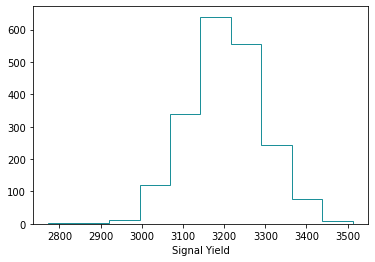

In [34]:
plt.figure()
plt.hist(new_bc_yield, histtype='step', color="#1c9099")
plt.xlabel('Signal Yield')
plt.plot()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -57.57                     │              Nfcn = 49               │
│ EDM = 9.39e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                  value    at limit
------------------  -------  ----------
mu_sig_[616198]        3205       False
sigma_sig_[616198]    90.12       False


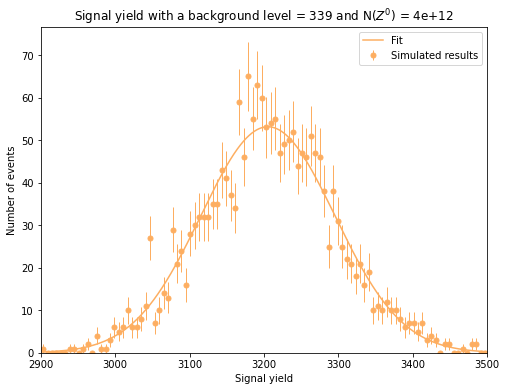

In [35]:
#Espace observable et data
min_sig = 2900 #int(sig_yield.min())
max_sig = 3500 #int(sig_yield.max()) + 1
obs = zfit.Space('x', limits=(min_sig,max_sig))
data = zfit.Data.from_numpy(obs=obs, array=new_bc_yield, weights=None) #

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_sig_ = zfit.Parameter(f"mu_sig_{rand_int}", 3200.)
sigma_sig_ = zfit.Parameter(f"sigma_sig_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs, mu=mu_sig_, sigma=sigma_sig_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_sig = minimizer.minimize(nll)

print(result_sig.info['original'])
print(result_sig.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs.limits
colour_bc = "#fdae61"

#Points du fit des yields de Bc+
x_plot_sig = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_sig = zfit.run(gauss.pdf(x_plot_sig, norm_range=obs))

#Points de l'histogramme des yields de Bc+
counts_sig, bin_edges_sig = np.histogram(new_bc_yield, bins=nb_bins, range=(lower[0][0], upper[0][0]))
#

#Tracé du plot
plt.figure(figsize = [8,6])

mplhep.histplot((counts_sig, bin_edges_sig), 
                yerr = True, 
                color = colour_bc, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_sig, 
         y_plot_sig * (len(new_bc_yield)/nb_bins*obs.area()), #
         color= colour_bc, 
         label= "Fit")

plt.xlabel("Signal yield")
plt.ylabel("Number of events")
plt.title("Signal yield with a background level = {} and N($Z^0$) = {:.0e}".format(round(N_BB_CC * bkg_var), N_Z0))
plt.xlim(lower[0][0], upper[0][0])
plt.legend()

plt.show()

##### $B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ Yield

[]

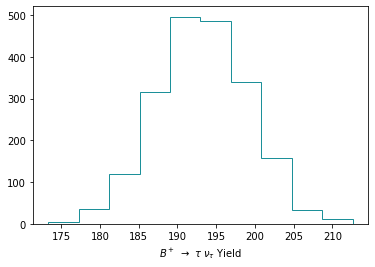

In [36]:
plt.figure()
plt.hist(new_bu_yield, histtype='step', color="#1c9099")
plt.xlabel(r'$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ Yield')
plt.plot()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 645.7                      │              Nfcn = 65               │
│ EDM = 8.71e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                 value    at limit
-----------------  -------  ----------
mu_bu_[784537]       193.3       False
sigma_bu_[784537]    5.916       False


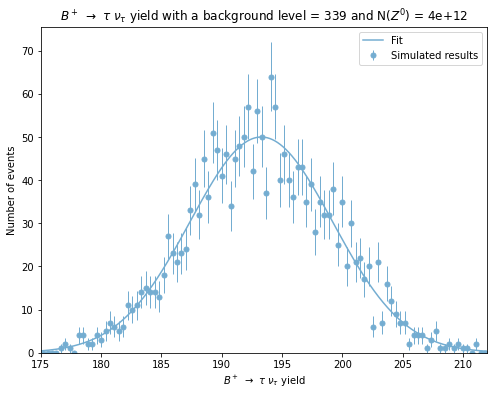

In [37]:
#Espace observable et data
min_bu = 175 #int(sig_yield.min())
max_bu = 212 #int(sig_yield.max())
obs_bu = zfit.Space('x', limits=(min_bu, max_bu))
data_bu = zfit.Data.from_numpy(obs=obs_bu, array=new_bu_yield, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_bu_ = zfit.Parameter(f"mu_bu_{rand_int}", 190.)
sigma_bu_ = zfit.Parameter(f"sigma_bu_{rand_int}", 10.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs_bu, mu=mu_bu_, sigma=sigma_bu_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data_bu )
minimizer = zfit.minimize.Minuit()
result_bu = minimizer.minimize(nll)

print(result_bu.info['original'])
print(result_bu.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs_bu.limits
colour_bu = "#74add1"
label_bu = r'$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ yield'

#Points du fit des yields de B+
x_plot_bu = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_bu = zfit.run(gauss.pdf(x_plot_bu, norm_range=obs_bu))

#Points de l'histogramme des yields de B+
counts_bu, bin_edges_bu = np.histogram(new_bu_yield, bins=nb_bins, range=(lower[0][0], upper[0][0]))

#Tracé du plot
plt.figure(figsize = [8,6])

mplhep.histplot((counts_bu, bin_edges_bu),
                yerr = True, 
                color = colour_bu, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_bu, 
         y_plot_bu * (len(new_bu_yield)/nb_bins*obs_bu.area()), 
         color= colour_bu, 
         label= "Fit")

plt.xlabel(label_bu)
plt.ylabel("Number of events")
plt.title(r"$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ yield with a background level = {} and N($Z^0$) = {:.0e}".format(round(N_BB_CC * bkg_var), N_Z0))
plt.xlim(lower[0][0], upper[0][0])

plt.legend()
plt.show()

##### Background

[]

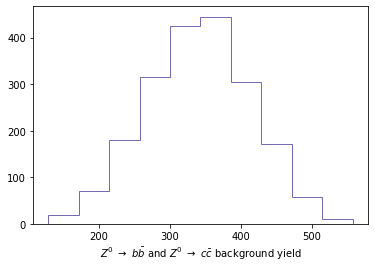

In [39]:
plt.figure()
plt.hist(new_bb_cc_yield, histtype='step', color="#756bb1")
plt.xlabel(r'$Z^0$ $\rightarrow$ $b\bar{b}$ and $Z^0$ $\rightarrow$ $c\bar{c}$ background yield')
plt.plot()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -33.79                     │              Nfcn = 48               │
│ EDM = 0.000161 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                  value    at limit
------------------  -------  ----------
mu_bkg_[339765]       340.7       False
sigma_bkg_[444084]    73.16       False


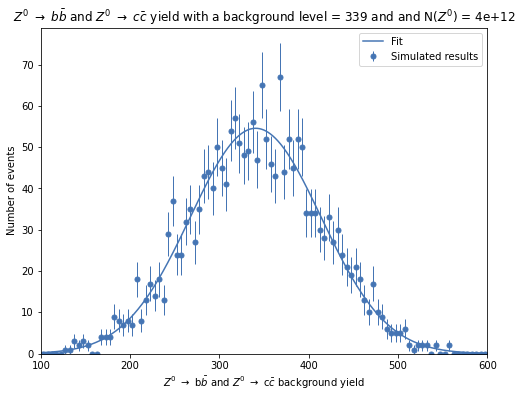

In [40]:
#Espace observable et data
min_bkg = 100 #int(bkg_yield.min())
max_bkg = 600 #int(bkg_yield.max()) + 1
obs_bkg = zfit.Space('x', limits=(min_bkg,max_bkg))
data = zfit.Data.from_numpy(obs=obs_bkg, array=new_bb_cc_yield, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_bkg_ = zfit.Parameter(f"mu_bkg_{rand_int}", 300.)

rand_int = random.randint(0,1000000,size=1)
sigma_bkg_ = zfit.Parameter(f"sigma_bkg_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs_bkg, mu=mu_bkg_, sigma=sigma_bkg_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_bkg = minimizer.minimize(nll)

print(result_bkg.info['original'])
print(result_bkg.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs_bkg.limits
colour_bb_cc = "#4575b4"#"#abd9e9"
label_bb_cc = r"$Z^0$ $\rightarrow$ b$\bar{b}$ and $Z^0$ $\rightarrow$ c$\bar{c}$ background yield"

#Points du fit des yields de Z->bb et Z->cc
x_plot_bkg = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_bkg = zfit.run(gauss.pdf(x_plot_bkg, norm_range=obs_bkg))

#Points de l'histogramme des yields de Z->bb et Z->cc
counts_bkg, bin_edges_bkg = np.histogram(new_bb_cc_yield, bins=nb_bins, range=(lower[0][0], upper[0][0]))

#Tracé du plot
plt.figure(figsize=[8,6])

mplhep.histplot((counts_bkg, bin_edges_bkg), 
                yerr = True, 
                color = colour_bb_cc, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_bkg, 
         y_plot_bkg * (len(new_bb_cc_yield)/nb_bins*obs_bkg.area()), 
         color= colour_bb_cc, 
         label= "Fit")


plt.xlabel(label_bb_cc)
plt.ylabel("Number of events")
plt.xlim(lower[0][0], upper[0][0])
plt.legend()
title_bb_cc = r"$Z^0$ $\rightarrow$ $b\bar{}$ and $Z^0$ $\rightarrow$ $c\bar{}$ yield with a background level = {} and and N($Z^0$) = {:.0e}".format("b", "c", round(N_BB_CC * bkg_var), N_Z0)
#r"$Z^0$ $\rightarrow$ $b\bar{b}$ and $Z^0$ $\rightarrow$ $c\bar{c}$ yield pull distribution with N($Z^0$)={:.0e}".format(N_Z0)
plt.title(title_bb_cc)
plt.show()

